In [1]:
import os
import nibabel as nib
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn.utils.parametrize as parametrize
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
data_dir = './Dataset'
print(os.listdir(data_dir))

img_dir = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
imgs = [nib.load(img_dir[i]) for i in [0,1,2,5]]
imgs_data = [torch.tensor(i.get_fdata()).unsqueeze(0) for i in imgs]

['I269254_I989324imagedata.nii.gz', 'I269254_I1304069imagedata.nii.gz', 'I269254_I1501115imagedata.nii.gz', 'I269254_I1241097imagedataLMCI.nii.gz', 'I269254_I235238imagedataLMCI.nii.gz', 'I269254_I1132801imagedata.nii.gz']


In [3]:
random_seed = 20220509
torch.manual_seed(random_seed);

In [4]:
def Data_Normalization(imgs_data):
    max_value = []
    min_value = []
    for img in imgs_data:
        max_value.append(torch.max(img))
        min_value.append(torch.min(img))
    imgs_data = [2*((x-mi)/(ma-mi)-0.5) for x, ma, mi in zip(imgs_data, max_value, min_value)]
    return imgs_data, max_value, min_value

In [5]:
imgs_data, max_value, min_value = Data_Normalization(imgs_data)

Create my own dataset:

In [6]:
imgs_data[2].shape

torch.Size([1, 91, 109, 91, 177])

Helper functions for using GPU

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True, dtype=torch.float)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now create PyTorch data loaders for training and validation.

In [8]:
val_size = 0
train_size = len(imgs) - val_size

# move to GPU
device = get_default_device()
print(device)
train_ds = to_device(imgs_data, device)

batch_size = train_size

# train_loader = DataLoader(train_ds, batch_size)
# # val_loader = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory = True)

# # move to GPU
# device = get_default_device()
# print(device)
# train_loader = DeviceDataLoader(train_loader, device)
# # val_loader = DeviceDataLoader(val_loader, device)

cuda


Next is the model

In [50]:
latent_dim = 50
F_matrices = torch.rand(batch_size, latent_dim, latent_dim, device = device, requires_grad = True)
F_matrices.shape

torch.Size([4, 50, 50])

In [15]:
def prox_mapping(x, lamb):
    return torch.sign(x)*(torch.abs(x)-lamb)*(torch.abs(x)>lamb)

In [10]:
class FrobeniusNormalization(nn.Module):
    def forward(self, X):
        F_norm = torch.linalg.matrix_norm(X).item()
        return(torch.div(X, F_norm))

In [51]:
class RecVAEModel(nn.Module):
    def __init__(self, enc_out_dim=100, latent_dim=latent_dim, sqr_sig_x=1., sqr_sig_h=1e-1):
        super().__init__()
        
        self.sqr_sig_x = sqr_sig_x
        self.sqr_sig_h = sqr_sig_h
        # Encoder: from input(x) to one of the inputs of the hidden layer (enc_x)
        # input: 1 x 91 x 109 x 91
        self.encoder1 = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace = True)) # output: 4 x 45 x 54 x 45
        
        self.encoder2 = nn.Sequential(
            nn.Conv3d(4, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, inplace = True)) # output: 8 x 22 x 27 x 22
        
        self.encoder3 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.2, inplace = True)) # output: 16 x 11 x 13 x 11
        
        self.encoder4 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace = True)) # output: 32 x 5 x 6 x 5
        
        self.encoder5 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(32*5*6*5, enc_out_dim),
            nn.Tanh()) # output: enc_out_dim
        
        
        # Hidden: from (enc_x,h_{t-1}) to h_t
        self.hidden2mu = nn.Linear(enc_out_dim+latent_dim, latent_dim)
        self.hidden2log_var = nn.Linear(enc_out_dim+latent_dim, latent_dim)
        
        # Decoder: from h_t to mu_t
        self.decoder1 = nn.Sequential(
            nn.Linear(latent_dim, 32*5*6*5),
            nn.Unflatten(1, (32, 5, 6, 5)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace = True))
          
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), 
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose3d(16, 8, kernel_size=4, stride=2, padding=1, output_padding=(0,1,0), bias=False), 
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose3d(8, 4, kernel_size=4, stride=2, padding=1, output_padding=(1,0,1), bias=False), 
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose3d(4, 1, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), 
            nn.Tanh())
                   
        
       
    def g_transform(self, h_old, which_ones):
        # h_old shape: batch_size x latent_dim
        #print(h_old.shape)
        h_old = h_old.unsqueeze(1)
        if len(which_ones)==1:
            h_new = torch.bmm(h_old, F_matrices[which_ones[0]:(which_ones[0]+1),:,:])
        else:
            h_new = torch.bmm(h_old, F_matrices[which_ones,:,:])
        #print(h_new.shape)
        #print(torch.max(h_new))
        return h_new.squeeze(1)
     
    
    def encode(self, x):
        enc_x = self.encoder1(x)
        enc_x = self.encoder2(enc_x)
        enc_x = self.encoder3(enc_x)
        enc_x = self.encoder4(enc_x)
        enc_x = self.encoder5(enc_x)
        return enc_x
    
    
    def decode(self, h):
        dec_h = self.decoder1(h)
        dec_h = self.decoder2(dec_h)
        dec_h = self.decoder3(dec_h)
        dec_h = self.decoder4(dec_h)
        dec_h = self.decoder5(dec_h)
        return dec_h
        
    
    def reparametrize(self, mu_h,log_var_h):
        # Reparametrization Trick to allow gradients to backpropagate from the stochastic part of the model
        sigma_h = torch.exp(log_var_h / 2)
        z = torch.randn(size = (mu_h.size(0),mu_h.size(1)))
        z = z.type_as(mu_h) # Setting z to be .cuda when using GPU training
        return mu_h + sigma_h*z
      
    
    def VAE(self, x, h):   
        # encode x and h to get the mu and variance parameters for the latent space
        enc_x = self.encode(x)
        combined = torch.cat((enc_x, h), 1)
        mu_h, log_var_h = self.hidden2mu(combined), self.hidden2log_var(combined)
        
        # sample h
        h = self.reparametrize(mu_h, log_var_h)
        
        # decode  
        mu = self.decode(h)
        return mu, h
    
    
    def training_step(self, batch, h, which_ones):
        '''h is h_0. It is of size batch_size*latent_dim'''
        batch = batch.to(torch.float32)
        x_list, mu_history, h_history, gh_history = self(batch, h, which_ones)
        
        temp = 2 * batch_size * len(h_history)
        # calculate loss
        loss1 = sum([torch.sum(torch.pow(x-mu, 2)) for x, mu in zip(x_list, mu_history)])
        loss1 = loss1 / self.sqr_sig_x / temp
        
        loss2 = sum([torch.sum(torch.pow(h-gh, 2)) for h, gh in zip(h_history, gh_history)])
        loss2 = loss2 / self.sqr_sig_h / temp
        
        loss3 = F.l1_loss(F_matrices, torch.zeros_like(F_matrices), reduction='sum')
        
        loss = loss1 + loss2
        
        return loss1, loss2, loss3, loss
    
    
    def forward(self, x, h, which_ones):
        # which_ones must be a list
        tol_time = x.size(-1) # x is of size batch_size*channel*x1*x2*x3*tol_time
        x_list = [x[:,:,:,:,:,t] for t in range(tol_time)]
        h_history = []
        gh_history = []
        mu_history = []
        for t in range(tol_time):
            #print(t)
            gh_history.append(self.g_transform(h, which_ones))
            mu, h = self.VAE(x_list[t], h)
            h_history.append(h)
            mu_history.append(mu)
        # print("h: ", h_history[50], "\n", "gh: ", gh_history[50])
        return x_list, mu_history, h_history, gh_history
    

model = RecVAEModel()
model = to_device(model, device)

In [48]:
def fit(epochs, lr, h0, model, lamb, train_loader=None, val_loader=None, opt_func=torch.optim.SGD):
    train_loss_history = []
    optimizer = opt_func([{'params': model.parameters()}, {'params': F_matrices}], lr)
    batch = torch.stack(train_ds)
    which_ones = [i for i in range(batch_size)]
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        loss1, loss2, loss3, loss = model.training_step(batch, h0.expand(batch.size(0), -1), which_ones)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            F_matrices_new = prox_mapping(F_matrices, lamb)
            F_matrices.copy_(F_matrices_new)
        optimizer.zero_grad()
        # train_loss_history.append(loss)
        # print("Epoch [{}], train_loss: {:.2f}".format(epoch, loss))
        print("Epoch [{}], train_loss: {:.2f} with loss1: {:.2f}, loss2: {:.2f} and loss3: {:.2f}".format(epoch, loss, loss1, loss2, loss3))
    return train_loss_history

In [18]:
h0 = torch.rand(1, 50)
h0 = to_device(h0, device)
h0

tensor([[0.3242, 0.8223, 0.4404, 0.2839, 0.7096, 0.8749, 0.6743, 0.8482, 0.2078,
         0.9575, 0.7758, 0.6036, 0.4181, 0.8889, 0.8722, 0.6919, 0.7953, 0.5428,
         0.1517, 0.7272, 0.5854, 0.5523, 0.6572, 0.7832, 0.1770, 0.1144, 0.7519,
         0.3479, 0.5873, 0.3989, 0.6967, 0.3291, 0.8412, 0.8612, 0.5244, 0.6021,
         0.6012, 0.0470, 0.2567, 0.7362, 0.8824, 0.0203, 0.3594, 0.2966, 0.9863,
         0.7287, 0.4492, 0.4691, 0.3128, 0.4787]], device='cuda:0')

In [46]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1., lamb=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=5000, lr=5e-6, h0=h0, model=model, lamb=1e-3)

Epoch [0], train_loss: 344228.66 with loss1: 343650.00, loss2: 578.67 and loss3: 5042.70
Epoch [1], train_loss: 134539.42 with loss1: 134006.14, loss2: 533.28 and loss3: 5032.70
Epoch [2], train_loss: 135185.92 with loss1: 134593.86, loss2: 592.06 and loss3: 5022.71
Epoch [3], train_loss: 204719.59 with loss1: 204080.86, loss2: 638.74 and loss3: 5012.73
Epoch [4], train_loss: 78048.16 with loss1: 77246.23, loss2: 801.94 and loss3: 5002.76
Epoch [5], train_loss: 57784.69 with loss1: 57177.11, loss2: 607.57 and loss3: 4992.79
Epoch [6], train_loss: 38913.80 with loss1: 38319.82, loss2: 593.98 and loss3: 4982.84
Epoch [7], train_loss: 29597.63 with loss1: 28892.67, loss2: 704.96 and loss3: 4972.90
Epoch [8], train_loss: 23919.14 with loss1: 23196.64, loss2: 722.50 and loss3: 4962.96
Epoch [9], train_loss: 20390.68 with loss1: 19692.22, loss2: 698.46 and loss3: 4953.04
Epoch [10], train_loss: 17585.33 with loss1: 16902.52, loss2: 682.81 and loss3: 4943.12
Epoch [11], train_loss: 15527.97 w

Epoch [95], train_loss: 4895.50 with loss1: 4438.97, loss2: 456.54 and loss3: 4137.31
Epoch [96], train_loss: 4830.57 with loss1: 4386.97, loss2: 443.60 and loss3: 4128.29
Epoch [97], train_loss: 4889.43 with loss1: 4433.36, loss2: 456.07 and loss3: 4119.27
Epoch [98], train_loss: 4771.53 with loss1: 4328.00, loss2: 443.53 and loss3: 4110.27
Epoch [99], train_loss: 4825.77 with loss1: 4378.34, loss2: 447.43 and loss3: 4101.27
Epoch [100], train_loss: 4688.27 with loss1: 4247.96, loss2: 440.31 and loss3: 4092.28
Epoch [101], train_loss: 4745.25 with loss1: 4300.99, loss2: 444.26 and loss3: 4083.30
Epoch [102], train_loss: 4647.89 with loss1: 4212.78, loss2: 435.11 and loss3: 4074.33
Epoch [103], train_loss: 4655.03 with loss1: 4211.62, loss2: 443.41 and loss3: 4065.37
Epoch [104], train_loss: 4521.30 with loss1: 4090.04, loss2: 431.26 and loss3: 4056.41
Epoch [105], train_loss: 4507.59 with loss1: 4072.79, loss2: 434.79 and loss3: 4047.47
Epoch [106], train_loss: 4431.93 with loss1: 400

Epoch [190], train_loss: 3157.13 with loss1: 2815.62, loss2: 341.51 and loss3: 3321.01
Epoch [191], train_loss: 3179.88 with loss1: 2842.83, loss2: 337.05 and loss3: 3312.88
Epoch [192], train_loss: 3131.89 with loss1: 2793.48, loss2: 338.41 and loss3: 3304.77
Epoch [193], train_loss: 3133.42 with loss1: 2795.81, loss2: 337.61 and loss3: 3296.67
Epoch [194], train_loss: 3095.86 with loss1: 2758.73, loss2: 337.13 and loss3: 3288.58
Epoch [195], train_loss: 3108.88 with loss1: 2774.14, loss2: 334.73 and loss3: 3280.50
Epoch [196], train_loss: 3071.56 with loss1: 2735.53, loss2: 336.03 and loss3: 3272.43
Epoch [197], train_loss: 3093.66 with loss1: 2761.03, loss2: 332.63 and loss3: 3264.36
Epoch [198], train_loss: 3048.90 with loss1: 2712.58, loss2: 336.32 and loss3: 3256.31
Epoch [199], train_loss: 3063.81 with loss1: 2732.98, loss2: 330.83 and loss3: 3248.26
Epoch [200], train_loss: 3034.39 with loss1: 2703.28, loss2: 331.11 and loss3: 3240.23
Epoch [201], train_loss: 3039.87 with loss1

Epoch [285], train_loss: 2561.94 with loss1: 2304.61, loss2: 257.33 and loss3: 2593.44
Epoch [286], train_loss: 2508.55 with loss1: 2250.04, loss2: 258.51 and loss3: 2586.26
Epoch [287], train_loss: 2536.97 with loss1: 2279.39, loss2: 257.58 and loss3: 2579.08
Epoch [288], train_loss: 2508.45 with loss1: 2250.96, loss2: 257.49 and loss3: 2571.92
Epoch [289], train_loss: 2519.64 with loss1: 2264.80, loss2: 254.84 and loss3: 2564.77
Epoch [290], train_loss: 2491.67 with loss1: 2234.63, loss2: 257.04 and loss3: 2557.63
Epoch [291], train_loss: 2518.16 with loss1: 2264.44, loss2: 253.73 and loss3: 2550.50
Epoch [292], train_loss: 2479.56 with loss1: 2224.80, loss2: 254.77 and loss3: 2543.38
Epoch [293], train_loss: 2494.59 with loss1: 2242.24, loss2: 252.35 and loss3: 2536.26
Epoch [294], train_loss: 2461.62 with loss1: 2209.03, loss2: 252.59 and loss3: 2529.16
Epoch [295], train_loss: 2466.22 with loss1: 2214.64, loss2: 251.58 and loss3: 2522.06
Epoch [296], train_loss: 2437.23 with loss1

Epoch [380], train_loss: 2014.26 with loss1: 1815.02, loss2: 199.24 and loss3: 1953.76
Epoch [381], train_loss: 2020.35 with loss1: 1820.60, loss2: 199.75 and loss3: 1947.48
Epoch [382], train_loss: 2007.35 with loss1: 1808.95, loss2: 198.40 and loss3: 1941.21
Epoch [383], train_loss: 2020.84 with loss1: 1821.99, loss2: 198.86 and loss3: 1934.95
Epoch [384], train_loss: 2007.53 with loss1: 1811.11, loss2: 196.42 and loss3: 1928.70
Epoch [385], train_loss: 2018.96 with loss1: 1821.70, loss2: 197.26 and loss3: 1922.46
Epoch [386], train_loss: 2000.19 with loss1: 1804.08, loss2: 196.10 and loss3: 1916.22
Epoch [387], train_loss: 2013.32 with loss1: 1817.18, loss2: 196.14 and loss3: 1910.00
Epoch [388], train_loss: 2006.98 with loss1: 1812.24, loss2: 194.74 and loss3: 1903.79
Epoch [389], train_loss: 2017.18 with loss1: 1821.70, loss2: 195.48 and loss3: 1897.59
Epoch [390], train_loss: 2001.45 with loss1: 1807.11, loss2: 194.34 and loss3: 1891.40
Epoch [391], train_loss: 2007.90 with loss1

Epoch [475], train_loss: 1715.95 with loss1: 1558.24, loss2: 157.71 and loss3: 1401.24
Epoch [476], train_loss: 1718.65 with loss1: 1561.24, loss2: 157.41 and loss3: 1395.90
Epoch [477], train_loss: 1706.22 with loss1: 1549.17, loss2: 157.05 and loss3: 1390.57
Epoch [478], train_loss: 1705.93 with loss1: 1549.34, loss2: 156.59 and loss3: 1385.25
Epoch [479], train_loss: 1704.88 with loss1: 1548.85, loss2: 156.03 and loss3: 1379.94
Epoch [480], train_loss: 1701.05 with loss1: 1544.61, loss2: 156.45 and loss3: 1374.64
Epoch [481], train_loss: 1700.48 with loss1: 1545.27, loss2: 155.22 and loss3: 1369.36
Epoch [482], train_loss: 1702.06 with loss1: 1546.48, loss2: 155.57 and loss3: 1364.08
Epoch [483], train_loss: 1690.88 with loss1: 1536.22, loss2: 154.67 and loss3: 1358.81
Epoch [484], train_loss: 1689.41 with loss1: 1534.44, loss2: 154.96 and loss3: 1353.55
Epoch [485], train_loss: 1692.98 with loss1: 1539.03, loss2: 153.95 and loss3: 1348.31
Epoch [486], train_loss: 1684.56 with loss1

Epoch [570], train_loss: 1538.88 with loss1: 1412.14, loss2: 126.73 and loss3: 939.66
Epoch [571], train_loss: 1547.53 with loss1: 1420.78, loss2: 126.74 and loss3: 935.28
Epoch [572], train_loss: 1538.55 with loss1: 1412.26, loss2: 126.29 and loss3: 930.91
Epoch [573], train_loss: 1549.97 with loss1: 1423.93, loss2: 126.05 and loss3: 926.56
Epoch [574], train_loss: 1535.63 with loss1: 1410.09, loss2: 125.53 and loss3: 922.21
Epoch [575], train_loss: 1543.92 with loss1: 1418.32, loss2: 125.60 and loss3: 917.88
Epoch [576], train_loss: 1528.65 with loss1: 1404.22, loss2: 124.43 and loss3: 913.56
Epoch [577], train_loss: 1539.88 with loss1: 1415.10, loss2: 124.78 and loss3: 909.24
Epoch [578], train_loss: 1521.57 with loss1: 1397.23, loss2: 124.34 and loss3: 904.94
Epoch [579], train_loss: 1537.37 with loss1: 1413.25, loss2: 124.12 and loss3: 900.65
Epoch [580], train_loss: 1531.43 with loss1: 1407.16, loss2: 124.27 and loss3: 896.36
Epoch [581], train_loss: 1530.35 with loss1: 1406.61, 

Epoch [666], train_loss: 1363.12 with loss1: 1256.46, loss2: 106.67 and loss3: 564.13
Epoch [667], train_loss: 1368.27 with loss1: 1262.00, loss2: 106.26 and loss3: 560.70
Epoch [668], train_loss: 1360.36 with loss1: 1254.01, loss2: 106.35 and loss3: 557.28
Epoch [669], train_loss: 1369.86 with loss1: 1263.58, loss2: 106.28 and loss3: 553.87
Epoch [670], train_loss: 1361.52 with loss1: 1255.49, loss2: 106.03 and loss3: 550.47
Epoch [671], train_loss: 1370.17 with loss1: 1264.68, loss2: 105.49 and loss3: 547.08
Epoch [672], train_loss: 1362.62 with loss1: 1257.07, loss2: 105.54 and loss3: 543.70
Epoch [673], train_loss: 1378.95 with loss1: 1273.53, loss2: 105.41 and loss3: 540.35
Epoch [674], train_loss: 1373.57 with loss1: 1268.21, loss2: 105.35 and loss3: 537.01
Epoch [675], train_loss: 1382.60 with loss1: 1277.58, loss2: 105.02 and loss3: 533.69
Epoch [676], train_loss: 1372.12 with loss1: 1267.24, loss2: 104.88 and loss3: 530.37
Epoch [677], train_loss: 1380.68 with loss1: 1275.63, 

Epoch [762], train_loss: 1233.98 with loss1: 1139.77, loss2: 94.22 and loss3: 285.29
Epoch [763], train_loss: 1236.10 with loss1: 1141.64, loss2: 94.45 and loss3: 282.90
Epoch [764], train_loss: 1225.04 with loss1: 1131.11, loss2: 93.93 and loss3: 280.51
Epoch [765], train_loss: 1229.68 with loss1: 1135.44, loss2: 94.24 and loss3: 278.14
Epoch [766], train_loss: 1227.24 with loss1: 1133.36, loss2: 93.88 and loss3: 275.77
Epoch [767], train_loss: 1218.09 with loss1: 1123.99, loss2: 94.09 and loss3: 273.43
Epoch [768], train_loss: 1211.44 with loss1: 1117.74, loss2: 93.71 and loss3: 271.09
Epoch [769], train_loss: 1214.24 with loss1: 1120.41, loss2: 93.83 and loss3: 268.76
Epoch [770], train_loss: 1201.74 with loss1: 1108.17, loss2: 93.58 and loss3: 266.44
Epoch [771], train_loss: 1203.80 with loss1: 1110.01, loss2: 93.79 and loss3: 264.12
Epoch [772], train_loss: 1196.09 with loss1: 1102.68, loss2: 93.41 and loss3: 261.82
Epoch [773], train_loss: 1200.72 with loss1: 1107.17, loss2: 93.5

Epoch [859], train_loss: 1154.66 with loss1: 1064.63, loss2: 90.03 and loss3: 99.23
Epoch [860], train_loss: 1151.39 with loss1: 1061.34, loss2: 90.05 and loss3: 97.80
Epoch [861], train_loss: 1147.42 with loss1: 1057.41, loss2: 90.01 and loss3: 96.39
Epoch [862], train_loss: 1139.48 with loss1: 1049.25, loss2: 90.23 and loss3: 94.98
Epoch [863], train_loss: 1133.32 with loss1: 1043.47, loss2: 89.84 and loss3: 93.58
Epoch [864], train_loss: 1127.81 with loss1: 1037.64, loss2: 90.17 and loss3: 92.20
Epoch [865], train_loss: 1125.76 with loss1: 1035.75, loss2: 90.01 and loss3: 90.82
Epoch [866], train_loss: 1121.58 with loss1: 1031.49, loss2: 90.08 and loss3: 89.45
Epoch [867], train_loss: 1115.51 with loss1: 1025.40, loss2: 90.11 and loss3: 88.09
Epoch [868], train_loss: 1110.06 with loss1: 1020.03, loss2: 90.04 and loss3: 86.74
Epoch [869], train_loss: 1105.88 with loss1: 1015.98, loss2: 89.90 and loss3: 85.40
Epoch [870], train_loss: 1105.59 with loss1: 1015.42, loss2: 90.17 and loss3

Epoch [958], train_loss: 1065.41 with loss1: 972.48, loss2: 92.92 and loss3: 8.67
Epoch [959], train_loss: 1064.95 with loss1: 971.85, loss2: 93.10 and loss3: 8.26
Epoch [960], train_loss: 1053.56 with loss1: 960.62, loss2: 92.93 and loss3: 7.87
Epoch [961], train_loss: 1049.75 with loss1: 956.67, loss2: 93.09 and loss3: 7.49
Epoch [962], train_loss: 1044.36 with loss1: 951.35, loss2: 93.01 and loss3: 7.11
Epoch [963], train_loss: 1039.82 with loss1: 946.44, loss2: 93.38 and loss3: 6.74
Epoch [964], train_loss: 1037.92 with loss1: 944.60, loss2: 93.31 and loss3: 6.39
Epoch [965], train_loss: 1035.66 with loss1: 942.22, loss2: 93.45 and loss3: 6.04
Epoch [966], train_loss: 1028.91 with loss1: 935.84, loss2: 93.07 and loss3: 5.70
Epoch [967], train_loss: 1032.43 with loss1: 939.09, loss2: 93.34 and loss3: 5.37
Epoch [968], train_loss: 1025.01 with loss1: 931.66, loss2: 93.35 and loss3: 5.05
Epoch [969], train_loss: 1027.34 with loss1: 933.92, loss2: 93.43 and loss3: 4.73
Epoch [970], tra

Epoch [1058], train_loss: 991.49 with loss1: 898.29, loss2: 93.20 and loss3: 0.00
Epoch [1059], train_loss: 995.40 with loss1: 901.92, loss2: 93.48 and loss3: 0.00
Epoch [1060], train_loss: 991.73 with loss1: 898.55, loss2: 93.18 and loss3: 0.00
Epoch [1061], train_loss: 995.01 with loss1: 901.84, loss2: 93.17 and loss3: 0.00
Epoch [1062], train_loss: 992.47 with loss1: 899.32, loss2: 93.16 and loss3: 0.00
Epoch [1063], train_loss: 988.97 with loss1: 895.80, loss2: 93.16 and loss3: 0.00
Epoch [1064], train_loss: 983.28 with loss1: 890.25, loss2: 93.03 and loss3: 0.00
Epoch [1065], train_loss: 988.46 with loss1: 895.28, loss2: 93.18 and loss3: 0.00
Epoch [1066], train_loss: 981.20 with loss1: 888.32, loss2: 92.89 and loss3: 0.00
Epoch [1067], train_loss: 983.11 with loss1: 889.99, loss2: 93.12 and loss3: 0.00
Epoch [1068], train_loss: 981.04 with loss1: 888.00, loss2: 93.05 and loss3: 0.00
Epoch [1069], train_loss: 986.59 with loss1: 893.58, loss2: 93.01 and loss3: 0.00
Epoch [1070], tr

Epoch [1158], train_loss: 929.60 with loss1: 838.75, loss2: 90.85 and loss3: 0.00
Epoch [1159], train_loss: 928.25 with loss1: 837.45, loss2: 90.80 and loss3: 0.00
Epoch [1160], train_loss: 927.53 with loss1: 836.68, loss2: 90.85 and loss3: 0.00
Epoch [1161], train_loss: 925.28 with loss1: 834.60, loss2: 90.69 and loss3: 0.00
Epoch [1162], train_loss: 921.74 with loss1: 830.99, loss2: 90.75 and loss3: 0.00
Epoch [1163], train_loss: 923.08 with loss1: 832.40, loss2: 90.68 and loss3: 0.00
Epoch [1164], train_loss: 923.16 with loss1: 832.38, loss2: 90.78 and loss3: 0.00
Epoch [1165], train_loss: 921.84 with loss1: 831.23, loss2: 90.60 and loss3: 0.00
Epoch [1166], train_loss: 922.70 with loss1: 832.01, loss2: 90.68 and loss3: 0.00
Epoch [1167], train_loss: 918.34 with loss1: 827.68, loss2: 90.66 and loss3: 0.00
Epoch [1168], train_loss: 919.06 with loss1: 828.32, loss2: 90.74 and loss3: 0.00
Epoch [1169], train_loss: 917.10 with loss1: 826.39, loss2: 90.71 and loss3: 0.00
Epoch [1170], tr

Epoch [1258], train_loss: 898.38 with loss1: 809.80, loss2: 88.58 and loss3: 0.00
Epoch [1259], train_loss: 903.24 with loss1: 814.45, loss2: 88.79 and loss3: 0.00
Epoch [1260], train_loss: 896.19 with loss1: 807.52, loss2: 88.67 and loss3: 0.00
Epoch [1261], train_loss: 897.31 with loss1: 808.51, loss2: 88.80 and loss3: 0.00
Epoch [1262], train_loss: 893.50 with loss1: 805.03, loss2: 88.47 and loss3: 0.00
Epoch [1263], train_loss: 900.01 with loss1: 811.26, loss2: 88.75 and loss3: 0.00
Epoch [1264], train_loss: 892.57 with loss1: 803.98, loss2: 88.59 and loss3: 0.00
Epoch [1265], train_loss: 897.57 with loss1: 808.96, loss2: 88.61 and loss3: 0.00
Epoch [1266], train_loss: 890.60 with loss1: 802.12, loss2: 88.48 and loss3: 0.00
Epoch [1267], train_loss: 891.29 with loss1: 802.71, loss2: 88.58 and loss3: 0.00
Epoch [1268], train_loss: 889.42 with loss1: 800.84, loss2: 88.58 and loss3: 0.00
Epoch [1269], train_loss: 891.86 with loss1: 803.34, loss2: 88.52 and loss3: 0.00
Epoch [1270], tr

Epoch [1358], train_loss: 858.72 with loss1: 771.82, loss2: 86.90 and loss3: 0.00
Epoch [1359], train_loss: 864.79 with loss1: 777.83, loss2: 86.96 and loss3: 0.00
Epoch [1360], train_loss: 861.05 with loss1: 774.12, loss2: 86.93 and loss3: 0.00
Epoch [1361], train_loss: 864.63 with loss1: 777.56, loss2: 87.07 and loss3: 0.00
Epoch [1362], train_loss: 865.97 with loss1: 779.20, loss2: 86.76 and loss3: 0.00
Epoch [1363], train_loss: 865.00 with loss1: 778.01, loss2: 86.99 and loss3: 0.00
Epoch [1364], train_loss: 864.28 with loss1: 777.51, loss2: 86.77 and loss3: 0.00
Epoch [1365], train_loss: 869.51 with loss1: 782.64, loss2: 86.86 and loss3: 0.00
Epoch [1366], train_loss: 865.91 with loss1: 779.17, loss2: 86.74 and loss3: 0.00
Epoch [1367], train_loss: 872.08 with loss1: 785.23, loss2: 86.85 and loss3: 0.00
Epoch [1368], train_loss: 867.59 with loss1: 780.93, loss2: 86.66 and loss3: 0.00
Epoch [1369], train_loss: 874.63 with loss1: 787.85, loss2: 86.78 and loss3: 0.00
Epoch [1370], tr

Epoch [1458], train_loss: 800.24 with loss1: 715.19, loss2: 85.05 and loss3: 0.00
Epoch [1459], train_loss: 802.58 with loss1: 717.79, loss2: 84.80 and loss3: 0.00
Epoch [1460], train_loss: 799.00 with loss1: 714.10, loss2: 84.90 and loss3: 0.00
Epoch [1461], train_loss: 801.49 with loss1: 716.48, loss2: 85.01 and loss3: 0.00
Epoch [1462], train_loss: 800.62 with loss1: 715.64, loss2: 84.98 and loss3: 0.00
Epoch [1463], train_loss: 802.04 with loss1: 717.14, loss2: 84.90 and loss3: 0.00
Epoch [1464], train_loss: 799.86 with loss1: 714.72, loss2: 85.14 and loss3: 0.00
Epoch [1465], train_loss: 799.74 with loss1: 714.92, loss2: 84.82 and loss3: 0.00
Epoch [1466], train_loss: 799.29 with loss1: 714.27, loss2: 85.02 and loss3: 0.00
Epoch [1467], train_loss: 801.79 with loss1: 716.95, loss2: 84.84 and loss3: 0.00
Epoch [1468], train_loss: 801.17 with loss1: 716.18, loss2: 84.99 and loss3: 0.00
Epoch [1469], train_loss: 803.85 with loss1: 719.07, loss2: 84.78 and loss3: 0.00
Epoch [1470], tr

Epoch [1558], train_loss: 756.79 with loss1: 673.50, loss2: 83.29 and loss3: 0.00
Epoch [1559], train_loss: 756.56 with loss1: 673.19, loss2: 83.37 and loss3: 0.00
Epoch [1560], train_loss: 754.46 with loss1: 671.21, loss2: 83.25 and loss3: 0.00
Epoch [1561], train_loss: 756.96 with loss1: 673.74, loss2: 83.22 and loss3: 0.00
Epoch [1562], train_loss: 754.86 with loss1: 671.82, loss2: 83.04 and loss3: 0.00
Epoch [1563], train_loss: 758.79 with loss1: 675.49, loss2: 83.30 and loss3: 0.00
Epoch [1564], train_loss: 756.94 with loss1: 673.86, loss2: 83.08 and loss3: 0.00
Epoch [1565], train_loss: 761.71 with loss1: 678.55, loss2: 83.16 and loss3: 0.00
Epoch [1566], train_loss: 756.76 with loss1: 673.68, loss2: 83.09 and loss3: 0.00
Epoch [1567], train_loss: 759.92 with loss1: 676.79, loss2: 83.14 and loss3: 0.00
Epoch [1568], train_loss: 764.35 with loss1: 681.33, loss2: 83.02 and loss3: 0.00
Epoch [1569], train_loss: 762.22 with loss1: 679.07, loss2: 83.15 and loss3: 0.00
Epoch [1570], tr

Epoch [1658], train_loss: 735.64 with loss1: 653.98, loss2: 81.66 and loss3: 0.00
Epoch [1659], train_loss: 736.82 with loss1: 655.17, loss2: 81.65 and loss3: 0.00
Epoch [1660], train_loss: 734.86 with loss1: 653.15, loss2: 81.71 and loss3: 0.00
Epoch [1661], train_loss: 737.65 with loss1: 656.06, loss2: 81.58 and loss3: 0.00
Epoch [1662], train_loss: 738.10 with loss1: 656.36, loss2: 81.73 and loss3: 0.00
Epoch [1663], train_loss: 740.72 with loss1: 659.14, loss2: 81.58 and loss3: 0.00
Epoch [1664], train_loss: 738.04 with loss1: 656.36, loss2: 81.68 and loss3: 0.00
Epoch [1665], train_loss: 742.05 with loss1: 660.42, loss2: 81.64 and loss3: 0.00
Epoch [1666], train_loss: 742.24 with loss1: 660.57, loss2: 81.68 and loss3: 0.00
Epoch [1667], train_loss: 742.69 with loss1: 661.17, loss2: 81.53 and loss3: 0.00
Epoch [1668], train_loss: 743.87 with loss1: 662.36, loss2: 81.51 and loss3: 0.00
Epoch [1669], train_loss: 744.48 with loss1: 663.07, loss2: 81.42 and loss3: 0.00
Epoch [1670], tr

Epoch [1758], train_loss: 711.58 with loss1: 631.60, loss2: 79.98 and loss3: 0.00
Epoch [1759], train_loss: 715.35 with loss1: 635.37, loss2: 79.98 and loss3: 0.00
Epoch [1760], train_loss: 715.09 with loss1: 635.19, loss2: 79.90 and loss3: 0.00
Epoch [1761], train_loss: 714.79 with loss1: 634.66, loss2: 80.13 and loss3: 0.00
Epoch [1762], train_loss: 713.59 with loss1: 633.64, loss2: 79.95 and loss3: 0.00
Epoch [1763], train_loss: 715.42 with loss1: 635.36, loss2: 80.06 and loss3: 0.00
Epoch [1764], train_loss: 714.14 with loss1: 634.17, loss2: 79.97 and loss3: 0.00
Epoch [1765], train_loss: 719.54 with loss1: 639.64, loss2: 79.91 and loss3: 0.00
Epoch [1766], train_loss: 716.18 with loss1: 636.22, loss2: 79.96 and loss3: 0.00
Epoch [1767], train_loss: 716.87 with loss1: 636.90, loss2: 79.97 and loss3: 0.00
Epoch [1768], train_loss: 715.03 with loss1: 635.13, loss2: 79.91 and loss3: 0.00
Epoch [1769], train_loss: 721.09 with loss1: 641.04, loss2: 80.05 and loss3: 0.00
Epoch [1770], tr

Epoch [1858], train_loss: 714.66 with loss1: 636.04, loss2: 78.62 and loss3: 0.00
Epoch [1859], train_loss: 715.33 with loss1: 636.82, loss2: 78.51 and loss3: 0.00
Epoch [1860], train_loss: 713.91 with loss1: 635.33, loss2: 78.58 and loss3: 0.00
Epoch [1861], train_loss: 718.22 with loss1: 639.55, loss2: 78.66 and loss3: 0.00
Epoch [1862], train_loss: 719.47 with loss1: 640.92, loss2: 78.54 and loss3: 0.00
Epoch [1863], train_loss: 720.36 with loss1: 641.79, loss2: 78.57 and loss3: 0.00
Epoch [1864], train_loss: 721.27 with loss1: 642.86, loss2: 78.41 and loss3: 0.00
Epoch [1865], train_loss: 724.63 with loss1: 646.12, loss2: 78.51 and loss3: 0.00
Epoch [1866], train_loss: 724.38 with loss1: 645.91, loss2: 78.47 and loss3: 0.00
Epoch [1867], train_loss: 727.29 with loss1: 648.77, loss2: 78.51 and loss3: 0.00
Epoch [1868], train_loss: 730.30 with loss1: 651.83, loss2: 78.47 and loss3: 0.00
Epoch [1869], train_loss: 734.96 with loss1: 656.52, loss2: 78.43 and loss3: 0.00
Epoch [1870], tr

Epoch [1958], train_loss: 696.83 with loss1: 619.72, loss2: 77.11 and loss3: 0.00
Epoch [1959], train_loss: 700.44 with loss1: 623.31, loss2: 77.14 and loss3: 0.00
Epoch [1960], train_loss: 701.83 with loss1: 624.56, loss2: 77.27 and loss3: 0.00
Epoch [1961], train_loss: 703.14 with loss1: 626.06, loss2: 77.08 and loss3: 0.00
Epoch [1962], train_loss: 701.85 with loss1: 624.73, loss2: 77.12 and loss3: 0.00
Epoch [1963], train_loss: 705.38 with loss1: 628.28, loss2: 77.10 and loss3: 0.00
Epoch [1964], train_loss: 702.65 with loss1: 625.43, loss2: 77.22 and loss3: 0.00
Epoch [1965], train_loss: 704.74 with loss1: 627.68, loss2: 77.06 and loss3: 0.00
Epoch [1966], train_loss: 704.00 with loss1: 626.89, loss2: 77.11 and loss3: 0.00
Epoch [1967], train_loss: 705.41 with loss1: 628.28, loss2: 77.13 and loss3: 0.00
Epoch [1968], train_loss: 701.32 with loss1: 624.13, loss2: 77.18 and loss3: 0.00
Epoch [1969], train_loss: 702.41 with loss1: 625.44, loss2: 76.96 and loss3: 0.00
Epoch [1970], tr

Epoch [2058], train_loss: 649.21 with loss1: 573.40, loss2: 75.81 and loss3: 0.00
Epoch [2059], train_loss: 649.94 with loss1: 574.09, loss2: 75.85 and loss3: 0.00
Epoch [2060], train_loss: 653.31 with loss1: 577.45, loss2: 75.87 and loss3: 0.00
Epoch [2061], train_loss: 656.64 with loss1: 580.92, loss2: 75.72 and loss3: 0.00
Epoch [2062], train_loss: 658.83 with loss1: 583.01, loss2: 75.82 and loss3: 0.00
Epoch [2063], train_loss: 659.69 with loss1: 583.92, loss2: 75.78 and loss3: 0.00
Epoch [2064], train_loss: 665.52 with loss1: 589.64, loss2: 75.88 and loss3: 0.00
Epoch [2065], train_loss: 668.54 with loss1: 592.87, loss2: 75.68 and loss3: 0.00
Epoch [2066], train_loss: 672.05 with loss1: 596.23, loss2: 75.82 and loss3: 0.00
Epoch [2067], train_loss: 675.16 with loss1: 599.54, loss2: 75.62 and loss3: 0.00
Epoch [2068], train_loss: 681.73 with loss1: 605.94, loss2: 75.79 and loss3: 0.00
Epoch [2069], train_loss: 681.26 with loss1: 605.69, loss2: 75.58 and loss3: 0.00
Epoch [2070], tr

Epoch [2158], train_loss: 637.44 with loss1: 563.07, loss2: 74.37 and loss3: 0.00
Epoch [2159], train_loss: 636.35 with loss1: 562.09, loss2: 74.26 and loss3: 0.00
Epoch [2160], train_loss: 638.29 with loss1: 563.97, loss2: 74.31 and loss3: 0.00
Epoch [2161], train_loss: 634.94 with loss1: 560.57, loss2: 74.37 and loss3: 0.00
Epoch [2162], train_loss: 636.93 with loss1: 562.72, loss2: 74.21 and loss3: 0.00
Epoch [2163], train_loss: 638.48 with loss1: 564.25, loss2: 74.23 and loss3: 0.00
Epoch [2164], train_loss: 637.43 with loss1: 563.22, loss2: 74.21 and loss3: 0.00
Epoch [2165], train_loss: 635.09 with loss1: 560.94, loss2: 74.15 and loss3: 0.00
Epoch [2166], train_loss: 637.27 with loss1: 563.11, loss2: 74.15 and loss3: 0.00
Epoch [2167], train_loss: 634.84 with loss1: 560.65, loss2: 74.20 and loss3: 0.00
Epoch [2168], train_loss: 637.28 with loss1: 563.01, loss2: 74.26 and loss3: 0.00
Epoch [2169], train_loss: 634.96 with loss1: 560.78, loss2: 74.18 and loss3: 0.00
Epoch [2170], tr

Epoch [2258], train_loss: 641.92 with loss1: 568.74, loss2: 73.18 and loss3: 0.00
Epoch [2259], train_loss: 639.74 with loss1: 566.63, loss2: 73.11 and loss3: 0.00
Epoch [2260], train_loss: 644.26 with loss1: 571.15, loss2: 73.11 and loss3: 0.00
Epoch [2261], train_loss: 643.59 with loss1: 570.52, loss2: 73.06 and loss3: 0.00
Epoch [2262], train_loss: 646.97 with loss1: 573.91, loss2: 73.07 and loss3: 0.00
Epoch [2263], train_loss: 638.70 with loss1: 565.74, loss2: 72.95 and loss3: 0.00
Epoch [2264], train_loss: 643.64 with loss1: 570.53, loss2: 73.11 and loss3: 0.00
Epoch [2265], train_loss: 643.85 with loss1: 570.84, loss2: 73.01 and loss3: 0.00
Epoch [2266], train_loss: 647.71 with loss1: 574.66, loss2: 73.05 and loss3: 0.00
Epoch [2267], train_loss: 645.77 with loss1: 572.84, loss2: 72.93 and loss3: 0.00
Epoch [2268], train_loss: 649.38 with loss1: 576.39, loss2: 72.99 and loss3: 0.00
Epoch [2269], train_loss: 649.61 with loss1: 576.65, loss2: 72.97 and loss3: 0.00
Epoch [2270], tr

Epoch [2358], train_loss: 593.43 with loss1: 521.54, loss2: 71.89 and loss3: 0.00
Epoch [2359], train_loss: 594.13 with loss1: 522.22, loss2: 71.90 and loss3: 0.00
Epoch [2360], train_loss: 591.64 with loss1: 519.69, loss2: 71.95 and loss3: 0.00
Epoch [2361], train_loss: 592.16 with loss1: 520.32, loss2: 71.84 and loss3: 0.00
Epoch [2362], train_loss: 592.04 with loss1: 520.09, loss2: 71.95 and loss3: 0.00
Epoch [2363], train_loss: 591.06 with loss1: 519.07, loss2: 71.99 and loss3: 0.00
Epoch [2364], train_loss: 592.29 with loss1: 520.42, loss2: 71.87 and loss3: 0.00
Epoch [2365], train_loss: 590.33 with loss1: 518.44, loss2: 71.89 and loss3: 0.00
Epoch [2366], train_loss: 592.33 with loss1: 520.52, loss2: 71.81 and loss3: 0.00
Epoch [2367], train_loss: 591.50 with loss1: 519.63, loss2: 71.88 and loss3: 0.00
Epoch [2368], train_loss: 591.85 with loss1: 519.98, loss2: 71.87 and loss3: 0.00
Epoch [2369], train_loss: 589.03 with loss1: 517.28, loss2: 71.75 and loss3: 0.00
Epoch [2370], tr

Epoch [2458], train_loss: 614.83 with loss1: 544.28, loss2: 70.55 and loss3: 0.00
Epoch [2459], train_loss: 614.73 with loss1: 544.07, loss2: 70.66 and loss3: 0.00
Epoch [2460], train_loss: 614.27 with loss1: 543.67, loss2: 70.59 and loss3: 0.00
Epoch [2461], train_loss: 611.31 with loss1: 540.70, loss2: 70.61 and loss3: 0.00
Epoch [2462], train_loss: 615.85 with loss1: 545.28, loss2: 70.57 and loss3: 0.00
Epoch [2463], train_loss: 612.17 with loss1: 541.63, loss2: 70.55 and loss3: 0.00
Epoch [2464], train_loss: 614.36 with loss1: 543.82, loss2: 70.54 and loss3: 0.00
Epoch [2465], train_loss: 613.16 with loss1: 542.65, loss2: 70.51 and loss3: 0.00
Epoch [2466], train_loss: 614.20 with loss1: 543.78, loss2: 70.42 and loss3: 0.00
Epoch [2467], train_loss: 612.94 with loss1: 542.48, loss2: 70.45 and loss3: 0.00
Epoch [2468], train_loss: 615.07 with loss1: 544.71, loss2: 70.36 and loss3: 0.00
Epoch [2469], train_loss: 610.03 with loss1: 539.46, loss2: 70.57 and loss3: 0.00
Epoch [2470], tr

Epoch [2558], train_loss: 592.38 with loss1: 522.74, loss2: 69.64 and loss3: 0.00
Epoch [2559], train_loss: 589.92 with loss1: 520.40, loss2: 69.52 and loss3: 0.00
Epoch [2560], train_loss: 592.52 with loss1: 522.97, loss2: 69.55 and loss3: 0.00
Epoch [2561], train_loss: 590.06 with loss1: 520.52, loss2: 69.53 and loss3: 0.00
Epoch [2562], train_loss: 592.09 with loss1: 522.63, loss2: 69.46 and loss3: 0.00
Epoch [2563], train_loss: 591.65 with loss1: 522.22, loss2: 69.43 and loss3: 0.00
Epoch [2564], train_loss: 592.90 with loss1: 523.48, loss2: 69.42 and loss3: 0.00
Epoch [2565], train_loss: 593.25 with loss1: 523.79, loss2: 69.46 and loss3: 0.00
Epoch [2566], train_loss: 593.73 with loss1: 524.26, loss2: 69.47 and loss3: 0.00
Epoch [2567], train_loss: 591.32 with loss1: 521.96, loss2: 69.37 and loss3: 0.00
Epoch [2568], train_loss: 593.15 with loss1: 523.74, loss2: 69.41 and loss3: 0.00
Epoch [2569], train_loss: 593.53 with loss1: 524.13, loss2: 69.40 and loss3: 0.00
Epoch [2570], tr

Epoch [2658], train_loss: 572.06 with loss1: 503.65, loss2: 68.40 and loss3: 0.00
Epoch [2659], train_loss: 571.23 with loss1: 502.84, loss2: 68.38 and loss3: 0.00
Epoch [2660], train_loss: 572.18 with loss1: 503.78, loss2: 68.40 and loss3: 0.00
Epoch [2661], train_loss: 570.82 with loss1: 502.53, loss2: 68.30 and loss3: 0.00
Epoch [2662], train_loss: 574.50 with loss1: 506.17, loss2: 68.33 and loss3: 0.00
Epoch [2663], train_loss: 573.36 with loss1: 505.08, loss2: 68.28 and loss3: 0.00
Epoch [2664], train_loss: 575.85 with loss1: 507.51, loss2: 68.34 and loss3: 0.00
Epoch [2665], train_loss: 576.88 with loss1: 508.58, loss2: 68.29 and loss3: 0.00
Epoch [2666], train_loss: 579.97 with loss1: 511.63, loss2: 68.34 and loss3: 0.00
Epoch [2667], train_loss: 582.42 with loss1: 514.06, loss2: 68.35 and loss3: 0.00
Epoch [2668], train_loss: 584.05 with loss1: 515.75, loss2: 68.30 and loss3: 0.00
Epoch [2669], train_loss: 583.49 with loss1: 515.11, loss2: 68.37 and loss3: 0.00
Epoch [2670], tr

Epoch [2758], train_loss: 559.86 with loss1: 492.29, loss2: 67.56 and loss3: 0.00
Epoch [2759], train_loss: 556.77 with loss1: 489.35, loss2: 67.43 and loss3: 0.00
Epoch [2760], train_loss: 556.53 with loss1: 488.99, loss2: 67.54 and loss3: 0.00
Epoch [2761], train_loss: 557.08 with loss1: 489.61, loss2: 67.47 and loss3: 0.00
Epoch [2762], train_loss: 556.96 with loss1: 489.44, loss2: 67.53 and loss3: 0.00
Epoch [2763], train_loss: 553.23 with loss1: 485.78, loss2: 67.45 and loss3: 0.00
Epoch [2764], train_loss: 557.49 with loss1: 489.95, loss2: 67.53 and loss3: 0.00
Epoch [2765], train_loss: 552.84 with loss1: 485.47, loss2: 67.38 and loss3: 0.00
Epoch [2766], train_loss: 554.69 with loss1: 487.30, loss2: 67.39 and loss3: 0.00
Epoch [2767], train_loss: 551.29 with loss1: 483.92, loss2: 67.37 and loss3: 0.00
Epoch [2768], train_loss: 550.36 with loss1: 482.91, loss2: 67.45 and loss3: 0.00
Epoch [2769], train_loss: 548.72 with loss1: 481.40, loss2: 67.32 and loss3: 0.00
Epoch [2770], tr

Epoch [2858], train_loss: 540.61 with loss1: 474.12, loss2: 66.50 and loss3: 0.00
Epoch [2859], train_loss: 541.99 with loss1: 475.66, loss2: 66.33 and loss3: 0.00
Epoch [2860], train_loss: 542.94 with loss1: 476.45, loss2: 66.50 and loss3: 0.00
Epoch [2861], train_loss: 541.36 with loss1: 474.92, loss2: 66.44 and loss3: 0.00
Epoch [2862], train_loss: 545.82 with loss1: 479.34, loss2: 66.48 and loss3: 0.00
Epoch [2863], train_loss: 545.63 with loss1: 479.26, loss2: 66.37 and loss3: 0.00
Epoch [2864], train_loss: 548.08 with loss1: 481.72, loss2: 66.35 and loss3: 0.00
Epoch [2865], train_loss: 549.40 with loss1: 482.95, loss2: 66.45 and loss3: 0.00
Epoch [2866], train_loss: 553.14 with loss1: 486.69, loss2: 66.45 and loss3: 0.00
Epoch [2867], train_loss: 554.83 with loss1: 488.41, loss2: 66.42 and loss3: 0.00
Epoch [2868], train_loss: 558.84 with loss1: 492.47, loss2: 66.38 and loss3: 0.00
Epoch [2869], train_loss: 561.31 with loss1: 494.94, loss2: 66.37 and loss3: 0.00
Epoch [2870], tr

Epoch [2958], train_loss: 535.10 with loss1: 469.72, loss2: 65.38 and loss3: 0.00
Epoch [2959], train_loss: 535.57 with loss1: 470.10, loss2: 65.47 and loss3: 0.00
Epoch [2960], train_loss: 536.32 with loss1: 470.87, loss2: 65.44 and loss3: 0.00
Epoch [2961], train_loss: 536.80 with loss1: 471.33, loss2: 65.47 and loss3: 0.00
Epoch [2962], train_loss: 539.35 with loss1: 473.90, loss2: 65.45 and loss3: 0.00
Epoch [2963], train_loss: 536.66 with loss1: 471.20, loss2: 65.46 and loss3: 0.00
Epoch [2964], train_loss: 539.28 with loss1: 473.89, loss2: 65.39 and loss3: 0.00
Epoch [2965], train_loss: 538.77 with loss1: 473.42, loss2: 65.35 and loss3: 0.00
Epoch [2966], train_loss: 539.94 with loss1: 474.54, loss2: 65.40 and loss3: 0.00
Epoch [2967], train_loss: 540.44 with loss1: 475.05, loss2: 65.40 and loss3: 0.00
Epoch [2968], train_loss: 540.73 with loss1: 475.47, loss2: 65.26 and loss3: 0.00
Epoch [2969], train_loss: 541.06 with loss1: 475.69, loss2: 65.36 and loss3: 0.00
Epoch [2970], tr

Epoch [3058], train_loss: 537.82 with loss1: 473.31, loss2: 64.51 and loss3: 0.00
Epoch [3059], train_loss: 535.52 with loss1: 471.17, loss2: 64.35 and loss3: 0.00
Epoch [3060], train_loss: 536.96 with loss1: 472.49, loss2: 64.48 and loss3: 0.00
Epoch [3061], train_loss: 538.46 with loss1: 474.02, loss2: 64.45 and loss3: 0.00
Epoch [3062], train_loss: 536.50 with loss1: 472.05, loss2: 64.45 and loss3: 0.00
Epoch [3063], train_loss: 536.84 with loss1: 472.48, loss2: 64.36 and loss3: 0.00
Epoch [3064], train_loss: 538.13 with loss1: 473.70, loss2: 64.42 and loss3: 0.00
Epoch [3065], train_loss: 540.78 with loss1: 476.47, loss2: 64.31 and loss3: 0.00
Epoch [3066], train_loss: 541.20 with loss1: 476.71, loss2: 64.49 and loss3: 0.00
Epoch [3067], train_loss: 536.68 with loss1: 472.26, loss2: 64.43 and loss3: 0.00
Epoch [3068], train_loss: 539.46 with loss1: 475.02, loss2: 64.43 and loss3: 0.00
Epoch [3069], train_loss: 535.74 with loss1: 471.38, loss2: 64.35 and loss3: 0.00
Epoch [3070], tr

Epoch [3158], train_loss: 505.34 with loss1: 441.63, loss2: 63.71 and loss3: 0.00
Epoch [3159], train_loss: 505.49 with loss1: 441.77, loss2: 63.72 and loss3: 0.00
Epoch [3160], train_loss: 506.21 with loss1: 442.50, loss2: 63.72 and loss3: 0.00
Epoch [3161], train_loss: 504.72 with loss1: 441.08, loss2: 63.64 and loss3: 0.00
Epoch [3162], train_loss: 504.88 with loss1: 441.20, loss2: 63.67 and loss3: 0.00
Epoch [3163], train_loss: 506.64 with loss1: 442.98, loss2: 63.67 and loss3: 0.00
Epoch [3164], train_loss: 507.09 with loss1: 443.45, loss2: 63.65 and loss3: 0.00
Epoch [3165], train_loss: 507.58 with loss1: 443.92, loss2: 63.66 and loss3: 0.00
Epoch [3166], train_loss: 509.80 with loss1: 446.23, loss2: 63.57 and loss3: 0.00
Epoch [3167], train_loss: 508.50 with loss1: 444.86, loss2: 63.64 and loss3: 0.00
Epoch [3168], train_loss: 509.62 with loss1: 446.03, loss2: 63.58 and loss3: 0.00
Epoch [3169], train_loss: 510.08 with loss1: 446.49, loss2: 63.59 and loss3: 0.00
Epoch [3170], tr

Epoch [3258], train_loss: 507.23 with loss1: 444.49, loss2: 62.74 and loss3: 0.00
Epoch [3259], train_loss: 506.77 with loss1: 444.00, loss2: 62.77 and loss3: 0.00
Epoch [3260], train_loss: 506.40 with loss1: 443.65, loss2: 62.74 and loss3: 0.00
Epoch [3261], train_loss: 507.46 with loss1: 444.76, loss2: 62.70 and loss3: 0.00
Epoch [3262], train_loss: 505.81 with loss1: 443.09, loss2: 62.72 and loss3: 0.00
Epoch [3263], train_loss: 507.58 with loss1: 444.94, loss2: 62.63 and loss3: 0.00
Epoch [3264], train_loss: 507.65 with loss1: 444.95, loss2: 62.70 and loss3: 0.00
Epoch [3265], train_loss: 508.41 with loss1: 445.83, loss2: 62.59 and loss3: 0.00
Epoch [3266], train_loss: 507.29 with loss1: 444.60, loss2: 62.69 and loss3: 0.00
Epoch [3267], train_loss: 508.64 with loss1: 446.02, loss2: 62.63 and loss3: 0.00
Epoch [3268], train_loss: 508.22 with loss1: 445.63, loss2: 62.59 and loss3: 0.00
Epoch [3269], train_loss: 509.15 with loss1: 446.59, loss2: 62.55 and loss3: 0.00
Epoch [3270], tr

Epoch [3358], train_loss: 524.47 with loss1: 462.61, loss2: 61.86 and loss3: 0.00
Epoch [3359], train_loss: 527.73 with loss1: 465.85, loss2: 61.88 and loss3: 0.00
Epoch [3360], train_loss: 524.58 with loss1: 462.71, loss2: 61.87 and loss3: 0.00
Epoch [3361], train_loss: 529.22 with loss1: 467.34, loss2: 61.88 and loss3: 0.00
Epoch [3362], train_loss: 526.86 with loss1: 465.03, loss2: 61.82 and loss3: 0.00
Epoch [3363], train_loss: 528.17 with loss1: 466.40, loss2: 61.77 and loss3: 0.00
Epoch [3364], train_loss: 528.61 with loss1: 466.73, loss2: 61.88 and loss3: 0.00
Epoch [3365], train_loss: 529.91 with loss1: 468.03, loss2: 61.88 and loss3: 0.00
Epoch [3366], train_loss: 529.80 with loss1: 467.95, loss2: 61.85 and loss3: 0.00
Epoch [3367], train_loss: 530.62 with loss1: 468.80, loss2: 61.82 and loss3: 0.00
Epoch [3368], train_loss: 530.73 with loss1: 468.99, loss2: 61.75 and loss3: 0.00
Epoch [3369], train_loss: 531.45 with loss1: 469.68, loss2: 61.77 and loss3: 0.00
Epoch [3370], tr

Epoch [3458], train_loss: 511.37 with loss1: 450.22, loss2: 61.15 and loss3: 0.00
Epoch [3459], train_loss: 515.15 with loss1: 454.02, loss2: 61.13 and loss3: 0.00
Epoch [3460], train_loss: 514.49 with loss1: 453.46, loss2: 61.03 and loss3: 0.00
Epoch [3461], train_loss: 515.87 with loss1: 454.76, loss2: 61.11 and loss3: 0.00
Epoch [3462], train_loss: 513.80 with loss1: 452.77, loss2: 61.03 and loss3: 0.00
Epoch [3463], train_loss: 517.17 with loss1: 456.06, loss2: 61.10 and loss3: 0.00
Epoch [3464], train_loss: 514.06 with loss1: 452.99, loss2: 61.07 and loss3: 0.00
Epoch [3465], train_loss: 516.96 with loss1: 455.85, loss2: 61.12 and loss3: 0.00
Epoch [3466], train_loss: 514.53 with loss1: 453.52, loss2: 61.01 and loss3: 0.00
Epoch [3467], train_loss: 518.53 with loss1: 457.43, loss2: 61.10 and loss3: 0.00
Epoch [3468], train_loss: 516.61 with loss1: 455.52, loss2: 61.08 and loss3: 0.00
Epoch [3469], train_loss: 517.96 with loss1: 456.82, loss2: 61.14 and loss3: 0.00
Epoch [3470], tr

Epoch [3558], train_loss: 479.06 with loss1: 418.68, loss2: 60.38 and loss3: 0.00
Epoch [3559], train_loss: 479.22 with loss1: 418.78, loss2: 60.44 and loss3: 0.00
Epoch [3560], train_loss: 479.22 with loss1: 418.78, loss2: 60.44 and loss3: 0.00
Epoch [3561], train_loss: 483.20 with loss1: 422.77, loss2: 60.43 and loss3: 0.00
Epoch [3562], train_loss: 478.85 with loss1: 418.48, loss2: 60.36 and loss3: 0.00
Epoch [3563], train_loss: 479.48 with loss1: 419.15, loss2: 60.34 and loss3: 0.00
Epoch [3564], train_loss: 478.15 with loss1: 417.76, loss2: 60.39 and loss3: 0.00
Epoch [3565], train_loss: 479.54 with loss1: 419.19, loss2: 60.36 and loss3: 0.00
Epoch [3566], train_loss: 479.24 with loss1: 418.90, loss2: 60.34 and loss3: 0.00
Epoch [3567], train_loss: 478.70 with loss1: 418.28, loss2: 60.42 and loss3: 0.00
Epoch [3568], train_loss: 479.38 with loss1: 419.11, loss2: 60.27 and loss3: 0.00
Epoch [3569], train_loss: 480.36 with loss1: 420.04, loss2: 60.33 and loss3: 0.00
Epoch [3570], tr

Epoch [3658], train_loss: 482.73 with loss1: 423.06, loss2: 59.67 and loss3: 0.00
Epoch [3659], train_loss: 482.38 with loss1: 422.77, loss2: 59.60 and loss3: 0.00
Epoch [3660], train_loss: 481.96 with loss1: 422.33, loss2: 59.63 and loss3: 0.00
Epoch [3661], train_loss: 482.73 with loss1: 423.10, loss2: 59.62 and loss3: 0.00
Epoch [3662], train_loss: 481.87 with loss1: 422.23, loss2: 59.65 and loss3: 0.00
Epoch [3663], train_loss: 481.31 with loss1: 421.69, loss2: 59.62 and loss3: 0.00
Epoch [3664], train_loss: 480.39 with loss1: 420.79, loss2: 59.60 and loss3: 0.00
Epoch [3665], train_loss: 483.21 with loss1: 423.65, loss2: 59.56 and loss3: 0.00
Epoch [3666], train_loss: 479.80 with loss1: 420.22, loss2: 59.58 and loss3: 0.00
Epoch [3667], train_loss: 480.92 with loss1: 421.41, loss2: 59.51 and loss3: 0.00
Epoch [3668], train_loss: 480.60 with loss1: 421.03, loss2: 59.58 and loss3: 0.00
Epoch [3669], train_loss: 479.55 with loss1: 420.06, loss2: 59.49 and loss3: 0.00
Epoch [3670], tr

Epoch [3758], train_loss: 478.96 with loss1: 420.14, loss2: 58.82 and loss3: 0.00
Epoch [3759], train_loss: 479.45 with loss1: 420.55, loss2: 58.90 and loss3: 0.00
Epoch [3760], train_loss: 478.18 with loss1: 419.41, loss2: 58.76 and loss3: 0.00
Epoch [3761], train_loss: 479.83 with loss1: 420.95, loss2: 58.87 and loss3: 0.00
Epoch [3762], train_loss: 478.67 with loss1: 419.82, loss2: 58.84 and loss3: 0.00
Epoch [3763], train_loss: 478.17 with loss1: 419.32, loss2: 58.85 and loss3: 0.00
Epoch [3764], train_loss: 477.95 with loss1: 419.19, loss2: 58.77 and loss3: 0.00
Epoch [3765], train_loss: 479.03 with loss1: 420.16, loss2: 58.87 and loss3: 0.00
Epoch [3766], train_loss: 480.55 with loss1: 421.74, loss2: 58.82 and loss3: 0.00
Epoch [3767], train_loss: 479.15 with loss1: 420.32, loss2: 58.83 and loss3: 0.00
Epoch [3768], train_loss: 478.60 with loss1: 419.81, loss2: 58.79 and loss3: 0.00
Epoch [3769], train_loss: 479.81 with loss1: 420.99, loss2: 58.83 and loss3: 0.00
Epoch [3770], tr

Epoch [3858], train_loss: 478.16 with loss1: 419.94, loss2: 58.22 and loss3: 0.00
Epoch [3859], train_loss: 477.36 with loss1: 419.21, loss2: 58.15 and loss3: 0.00
Epoch [3860], train_loss: 476.65 with loss1: 418.41, loss2: 58.23 and loss3: 0.00
Epoch [3861], train_loss: 475.62 with loss1: 417.44, loss2: 58.18 and loss3: 0.00
Epoch [3862], train_loss: 474.65 with loss1: 416.48, loss2: 58.17 and loss3: 0.00
Epoch [3863], train_loss: 475.46 with loss1: 417.28, loss2: 58.18 and loss3: 0.00
Epoch [3864], train_loss: 472.83 with loss1: 414.69, loss2: 58.14 and loss3: 0.00
Epoch [3865], train_loss: 473.80 with loss1: 415.69, loss2: 58.11 and loss3: 0.00
Epoch [3866], train_loss: 470.82 with loss1: 412.72, loss2: 58.09 and loss3: 0.00
Epoch [3867], train_loss: 471.90 with loss1: 413.77, loss2: 58.13 and loss3: 0.00
Epoch [3868], train_loss: 470.47 with loss1: 412.35, loss2: 58.13 and loss3: 0.00
Epoch [3869], train_loss: 469.76 with loss1: 411.69, loss2: 58.07 and loss3: 0.00
Epoch [3870], tr

Epoch [3958], train_loss: 461.20 with loss1: 403.66, loss2: 57.54 and loss3: 0.00
Epoch [3959], train_loss: 460.55 with loss1: 403.02, loss2: 57.54 and loss3: 0.00
Epoch [3960], train_loss: 460.10 with loss1: 402.57, loss2: 57.54 and loss3: 0.00
Epoch [3961], train_loss: 459.46 with loss1: 401.98, loss2: 57.48 and loss3: 0.00
Epoch [3962], train_loss: 459.17 with loss1: 401.70, loss2: 57.47 and loss3: 0.00
Epoch [3963], train_loss: 460.48 with loss1: 403.00, loss2: 57.49 and loss3: 0.00
Epoch [3964], train_loss: 460.02 with loss1: 402.50, loss2: 57.52 and loss3: 0.00
Epoch [3965], train_loss: 461.74 with loss1: 404.29, loss2: 57.45 and loss3: 0.00
Epoch [3966], train_loss: 461.30 with loss1: 403.89, loss2: 57.41 and loss3: 0.00
Epoch [3967], train_loss: 463.48 with loss1: 406.01, loss2: 57.47 and loss3: 0.00
Epoch [3968], train_loss: 462.65 with loss1: 405.18, loss2: 57.47 and loss3: 0.00
Epoch [3969], train_loss: 463.69 with loss1: 406.26, loss2: 57.43 and loss3: 0.00
Epoch [3970], tr

Epoch [4058], train_loss: 458.45 with loss1: 401.63, loss2: 56.83 and loss3: 0.00
Epoch [4059], train_loss: 458.84 with loss1: 402.06, loss2: 56.79 and loss3: 0.00
Epoch [4060], train_loss: 459.94 with loss1: 403.09, loss2: 56.84 and loss3: 0.00
Epoch [4061], train_loss: 459.48 with loss1: 402.69, loss2: 56.79 and loss3: 0.00
Epoch [4062], train_loss: 457.89 with loss1: 401.08, loss2: 56.81 and loss3: 0.00
Epoch [4063], train_loss: 458.94 with loss1: 402.19, loss2: 56.74 and loss3: 0.00
Epoch [4064], train_loss: 460.12 with loss1: 403.38, loss2: 56.74 and loss3: 0.00
Epoch [4065], train_loss: 459.92 with loss1: 403.16, loss2: 56.76 and loss3: 0.00
Epoch [4066], train_loss: 459.08 with loss1: 402.33, loss2: 56.75 and loss3: 0.00
Epoch [4067], train_loss: 461.14 with loss1: 404.41, loss2: 56.73 and loss3: 0.00
Epoch [4068], train_loss: 460.09 with loss1: 403.31, loss2: 56.78 and loss3: 0.00
Epoch [4069], train_loss: 461.06 with loss1: 404.35, loss2: 56.71 and loss3: 0.00
Epoch [4070], tr

Epoch [4158], train_loss: 448.51 with loss1: 392.31, loss2: 56.20 and loss3: 0.00
Epoch [4159], train_loss: 449.88 with loss1: 393.71, loss2: 56.16 and loss3: 0.00
Epoch [4160], train_loss: 447.54 with loss1: 391.36, loss2: 56.18 and loss3: 0.00
Epoch [4161], train_loss: 447.54 with loss1: 391.32, loss2: 56.22 and loss3: 0.00
Epoch [4162], train_loss: 448.17 with loss1: 391.96, loss2: 56.21 and loss3: 0.00
Epoch [4163], train_loss: 447.42 with loss1: 391.33, loss2: 56.09 and loss3: 0.00
Epoch [4164], train_loss: 446.85 with loss1: 390.66, loss2: 56.19 and loss3: 0.00
Epoch [4165], train_loss: 447.48 with loss1: 391.30, loss2: 56.17 and loss3: 0.00
Epoch [4166], train_loss: 447.46 with loss1: 391.28, loss2: 56.18 and loss3: 0.00
Epoch [4167], train_loss: 447.01 with loss1: 390.85, loss2: 56.16 and loss3: 0.00
Epoch [4168], train_loss: 446.49 with loss1: 390.29, loss2: 56.20 and loss3: 0.00
Epoch [4169], train_loss: 447.82 with loss1: 391.74, loss2: 56.08 and loss3: 0.00
Epoch [4170], tr

Epoch [4258], train_loss: 439.58 with loss1: 383.95, loss2: 55.63 and loss3: 0.00
Epoch [4259], train_loss: 438.89 with loss1: 383.22, loss2: 55.67 and loss3: 0.00
Epoch [4260], train_loss: 440.03 with loss1: 384.38, loss2: 55.64 and loss3: 0.00
Epoch [4261], train_loss: 441.14 with loss1: 385.53, loss2: 55.61 and loss3: 0.00
Epoch [4262], train_loss: 440.83 with loss1: 385.21, loss2: 55.62 and loss3: 0.00
Epoch [4263], train_loss: 442.36 with loss1: 386.73, loss2: 55.63 and loss3: 0.00
Epoch [4264], train_loss: 442.77 with loss1: 387.15, loss2: 55.62 and loss3: 0.00
Epoch [4265], train_loss: 443.23 with loss1: 387.60, loss2: 55.63 and loss3: 0.00
Epoch [4266], train_loss: 443.51 with loss1: 388.01, loss2: 55.50 and loss3: 0.00
Epoch [4267], train_loss: 445.46 with loss1: 389.92, loss2: 55.54 and loss3: 0.00
Epoch [4268], train_loss: 446.85 with loss1: 391.30, loss2: 55.55 and loss3: 0.00
Epoch [4269], train_loss: 448.26 with loss1: 392.70, loss2: 55.56 and loss3: 0.00
Epoch [4270], tr

Epoch [4358], train_loss: 442.96 with loss1: 387.97, loss2: 54.99 and loss3: 0.00
Epoch [4359], train_loss: 442.19 with loss1: 387.25, loss2: 54.94 and loss3: 0.00
Epoch [4360], train_loss: 441.26 with loss1: 386.27, loss2: 54.99 and loss3: 0.00
Epoch [4361], train_loss: 443.36 with loss1: 388.45, loss2: 54.91 and loss3: 0.00
Epoch [4362], train_loss: 442.57 with loss1: 387.63, loss2: 54.94 and loss3: 0.00
Epoch [4363], train_loss: 443.42 with loss1: 388.57, loss2: 54.85 and loss3: 0.00
Epoch [4364], train_loss: 442.59 with loss1: 387.70, loss2: 54.90 and loss3: 0.00
Epoch [4365], train_loss: 443.61 with loss1: 388.73, loss2: 54.88 and loss3: 0.00
Epoch [4366], train_loss: 445.22 with loss1: 390.30, loss2: 54.92 and loss3: 0.00
Epoch [4367], train_loss: 445.01 with loss1: 390.16, loss2: 54.85 and loss3: 0.00
Epoch [4368], train_loss: 443.35 with loss1: 388.45, loss2: 54.90 and loss3: 0.00
Epoch [4369], train_loss: 446.17 with loss1: 391.30, loss2: 54.87 and loss3: 0.00
Epoch [4370], tr

Epoch [4458], train_loss: 447.17 with loss1: 392.86, loss2: 54.31 and loss3: 0.00
Epoch [4459], train_loss: 448.54 with loss1: 394.29, loss2: 54.25 and loss3: 0.00
Epoch [4460], train_loss: 447.81 with loss1: 393.46, loss2: 54.35 and loss3: 0.00
Epoch [4461], train_loss: 449.97 with loss1: 395.74, loss2: 54.23 and loss3: 0.00
Epoch [4462], train_loss: 448.72 with loss1: 394.40, loss2: 54.32 and loss3: 0.00
Epoch [4463], train_loss: 452.88 with loss1: 398.63, loss2: 54.26 and loss3: 0.00
Epoch [4464], train_loss: 451.98 with loss1: 397.73, loss2: 54.25 and loss3: 0.00
Epoch [4465], train_loss: 453.33 with loss1: 399.06, loss2: 54.27 and loss3: 0.00
Epoch [4466], train_loss: 452.66 with loss1: 398.38, loss2: 54.28 and loss3: 0.00
Epoch [4467], train_loss: 455.11 with loss1: 400.85, loss2: 54.26 and loss3: 0.00
Epoch [4468], train_loss: 454.67 with loss1: 400.45, loss2: 54.22 and loss3: 0.00
Epoch [4469], train_loss: 459.33 with loss1: 405.05, loss2: 54.28 and loss3: 0.00
Epoch [4470], tr

Epoch [4558], train_loss: 431.36 with loss1: 377.57, loss2: 53.79 and loss3: 0.00
Epoch [4559], train_loss: 430.55 with loss1: 376.76, loss2: 53.79 and loss3: 0.00
Epoch [4560], train_loss: 429.73 with loss1: 375.95, loss2: 53.79 and loss3: 0.00
Epoch [4561], train_loss: 430.82 with loss1: 376.99, loss2: 53.83 and loss3: 0.00
Epoch [4562], train_loss: 429.71 with loss1: 376.01, loss2: 53.70 and loss3: 0.00
Epoch [4563], train_loss: 431.23 with loss1: 377.45, loss2: 53.78 and loss3: 0.00
Epoch [4564], train_loss: 431.47 with loss1: 377.76, loss2: 53.71 and loss3: 0.00
Epoch [4565], train_loss: 432.52 with loss1: 378.79, loss2: 53.73 and loss3: 0.00
Epoch [4566], train_loss: 432.25 with loss1: 378.57, loss2: 53.68 and loss3: 0.00
Epoch [4567], train_loss: 432.80 with loss1: 379.01, loss2: 53.79 and loss3: 0.00
Epoch [4568], train_loss: 432.67 with loss1: 378.99, loss2: 53.68 and loss3: 0.00
Epoch [4569], train_loss: 434.36 with loss1: 380.66, loss2: 53.71 and loss3: 0.00
Epoch [4570], tr

Epoch [4658], train_loss: 436.72 with loss1: 383.41, loss2: 53.31 and loss3: 0.00
Epoch [4659], train_loss: 437.37 with loss1: 384.13, loss2: 53.25 and loss3: 0.00
Epoch [4660], train_loss: 435.49 with loss1: 382.22, loss2: 53.27 and loss3: 0.00
Epoch [4661], train_loss: 436.81 with loss1: 383.50, loss2: 53.31 and loss3: 0.00
Epoch [4662], train_loss: 435.51 with loss1: 382.25, loss2: 53.26 and loss3: 0.00
Epoch [4663], train_loss: 435.32 with loss1: 382.11, loss2: 53.21 and loss3: 0.00
Epoch [4664], train_loss: 434.00 with loss1: 380.78, loss2: 53.22 and loss3: 0.00
Epoch [4665], train_loss: 436.28 with loss1: 383.04, loss2: 53.24 and loss3: 0.00
Epoch [4666], train_loss: 434.24 with loss1: 380.98, loss2: 53.26 and loss3: 0.00
Epoch [4667], train_loss: 435.78 with loss1: 382.57, loss2: 53.21 and loss3: 0.00
Epoch [4668], train_loss: 433.63 with loss1: 380.41, loss2: 53.22 and loss3: 0.00
Epoch [4669], train_loss: 434.15 with loss1: 380.99, loss2: 53.16 and loss3: 0.00
Epoch [4670], tr

Epoch [4758], train_loss: 458.91 with loss1: 406.18, loss2: 52.73 and loss3: 0.00
Epoch [4759], train_loss: 460.08 with loss1: 407.40, loss2: 52.68 and loss3: 0.00
Epoch [4760], train_loss: 460.71 with loss1: 408.02, loss2: 52.69 and loss3: 0.00
Epoch [4761], train_loss: 458.83 with loss1: 406.15, loss2: 52.68 and loss3: 0.00
Epoch [4762], train_loss: 455.70 with loss1: 402.98, loss2: 52.72 and loss3: 0.00
Epoch [4763], train_loss: 457.34 with loss1: 404.62, loss2: 52.72 and loss3: 0.00
Epoch [4764], train_loss: 452.65 with loss1: 399.98, loss2: 52.67 and loss3: 0.00
Epoch [4765], train_loss: 453.98 with loss1: 401.27, loss2: 52.70 and loss3: 0.00
Epoch [4766], train_loss: 449.78 with loss1: 397.12, loss2: 52.67 and loss3: 0.00
Epoch [4767], train_loss: 449.40 with loss1: 396.72, loss2: 52.69 and loss3: 0.00
Epoch [4768], train_loss: 446.52 with loss1: 393.80, loss2: 52.72 and loss3: 0.00
Epoch [4769], train_loss: 447.50 with loss1: 394.86, loss2: 52.63 and loss3: 0.00
Epoch [4770], tr

Epoch [4858], train_loss: 425.68 with loss1: 373.64, loss2: 52.04 and loss3: 0.00
Epoch [4859], train_loss: 428.31 with loss1: 376.14, loss2: 52.17 and loss3: 0.00
Epoch [4860], train_loss: 427.17 with loss1: 375.08, loss2: 52.09 and loss3: 0.00
Epoch [4861], train_loss: 428.50 with loss1: 376.40, loss2: 52.10 and loss3: 0.00
Epoch [4862], train_loss: 426.60 with loss1: 374.51, loss2: 52.09 and loss3: 0.00
Epoch [4863], train_loss: 428.26 with loss1: 376.17, loss2: 52.08 and loss3: 0.00
Epoch [4864], train_loss: 427.26 with loss1: 375.17, loss2: 52.09 and loss3: 0.00
Epoch [4865], train_loss: 430.20 with loss1: 378.16, loss2: 52.04 and loss3: 0.00
Epoch [4866], train_loss: 428.89 with loss1: 376.78, loss2: 52.11 and loss3: 0.00
Epoch [4867], train_loss: 429.00 with loss1: 376.90, loss2: 52.10 and loss3: 0.00
Epoch [4868], train_loss: 428.93 with loss1: 376.88, loss2: 52.06 and loss3: 0.00
Epoch [4869], train_loss: 428.46 with loss1: 376.40, loss2: 52.07 and loss3: 0.00
Epoch [4870], tr

Epoch [4958], train_loss: 426.95 with loss1: 375.30, loss2: 51.65 and loss3: 0.00
Epoch [4959], train_loss: 428.66 with loss1: 377.05, loss2: 51.61 and loss3: 0.00
Epoch [4960], train_loss: 427.62 with loss1: 375.96, loss2: 51.65 and loss3: 0.00
Epoch [4961], train_loss: 428.28 with loss1: 376.74, loss2: 51.55 and loss3: 0.00
Epoch [4962], train_loss: 428.41 with loss1: 376.80, loss2: 51.61 and loss3: 0.00
Epoch [4963], train_loss: 428.35 with loss1: 376.85, loss2: 51.50 and loss3: 0.00
Epoch [4964], train_loss: 427.64 with loss1: 376.01, loss2: 51.63 and loss3: 0.00
Epoch [4965], train_loss: 429.93 with loss1: 378.43, loss2: 51.50 and loss3: 0.00
Epoch [4966], train_loss: 429.09 with loss1: 377.51, loss2: 51.58 and loss3: 0.00
Epoch [4967], train_loss: 429.70 with loss1: 378.19, loss2: 51.51 and loss3: 0.00
Epoch [4968], train_loss: 429.10 with loss1: 377.49, loss2: 51.62 and loss3: 0.00
Epoch [4969], train_loss: 431.19 with loss1: 379.63, loss2: 51.56 and loss3: 0.00
Epoch [4970], tr

In [ ]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1e-1, lamb=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=5000, lr=5e-6, h0=h0, model=model, lamb=1e-3)

Epoch [0], train_loss: 329123.41 with loss1: 323455.31, loss2: 5668.11 and loss3: 4974.29
Epoch [1], train_loss: 108716.60 with loss1: 104278.55, loss2: 4438.04 and loss3: 4964.21
Epoch [2], train_loss: 98304.52 with loss1: 87122.17, loss2: 11182.34 and loss3: 4954.17
Epoch [3], train_loss: 102761.45 with loss1: 94071.50, loss2: 8689.95 and loss3: 4943.99
Epoch [4], train_loss: 89377.16 with loss1: 78407.27, loss2: 10969.88 and loss3: 4933.88
Epoch [5], train_loss: 59220.52 with loss1: 53239.18, loss2: 5981.34 and loss3: 4923.75
Epoch [6], train_loss: 46482.69 with loss1: 40215.39, loss2: 6267.30 and loss3: 4913.71
Epoch [7], train_loss: 45847.09 with loss1: 40732.93, loss2: 5114.16 and loss3: 4903.68
Epoch [8], train_loss: 36060.29 with loss1: 30861.48, loss2: 5198.81 and loss3: 4893.68
Epoch [9], train_loss: 35958.02 with loss1: 30857.61, loss2: 5100.41 and loss3: 4883.70
Epoch [10], train_loss: 28545.50 with loss1: 22262.40, loss2: 6283.10 and loss3: 4873.73
Epoch [11], train_loss: 

Epoch [94], train_loss: 5055.60 with loss1: 3862.99, loss2: 1192.61 and loss3: 4073.65
Epoch [95], train_loss: 4959.99 with loss1: 3761.03, loss2: 1198.96 and loss3: 4064.57
Epoch [96], train_loss: 4997.83 with loss1: 3805.47, loss2: 1192.36 and loss3: 4055.49
Epoch [97], train_loss: 4892.52 with loss1: 3689.89, loss2: 1202.64 and loss3: 4046.43
Epoch [98], train_loss: 4925.75 with loss1: 3768.88, loss2: 1156.87 and loss3: 4037.38
Epoch [99], train_loss: 4835.24 with loss1: 3629.34, loss2: 1205.91 and loss3: 4028.34
Epoch [100], train_loss: 4802.86 with loss1: 3656.89, loss2: 1145.97 and loss3: 4019.31
Epoch [101], train_loss: 4711.14 with loss1: 3547.56, loss2: 1163.57 and loss3: 4010.28
Epoch [102], train_loss: 4710.84 with loss1: 3577.26, loss2: 1133.58 and loss3: 4001.28
Epoch [103], train_loss: 4647.38 with loss1: 3513.17, loss2: 1134.21 and loss3: 3992.28
Epoch [104], train_loss: 4627.93 with loss1: 3528.17, loss2: 1099.76 and loss3: 3983.30
Epoch [105], train_loss: 4619.30 with 

Epoch [188], train_loss: 3140.02 with loss1: 2420.09, loss2: 719.93 and loss3: 3264.93
Epoch [189], train_loss: 3169.78 with loss1: 2471.39, loss2: 698.39 and loss3: 3256.81
Epoch [190], train_loss: 3143.05 with loss1: 2430.36, loss2: 712.69 and loss3: 3248.70
Epoch [191], train_loss: 3186.84 with loss1: 2506.64, loss2: 680.19 and loss3: 3240.60
Epoch [192], train_loss: 3184.24 with loss1: 2470.73, loss2: 713.51 and loss3: 3232.50
Epoch [193], train_loss: 3219.88 with loss1: 2531.75, loss2: 688.12 and loss3: 3224.42
Epoch [194], train_loss: 3154.61 with loss1: 2447.03, loss2: 707.59 and loss3: 3216.35
Epoch [195], train_loss: 3179.13 with loss1: 2498.67, loss2: 680.46 and loss3: 3208.28
Epoch [196], train_loss: 3124.28 with loss1: 2422.79, loss2: 701.48 and loss3: 3200.23
Epoch [197], train_loss: 3102.03 with loss1: 2426.90, loss2: 675.13 and loss3: 3192.18
Epoch [198], train_loss: 3048.06 with loss1: 2361.16, loss2: 686.90 and loss3: 3184.14
Epoch [199], train_loss: 3027.36 with loss1

Epoch [283], train_loss: 2389.56 with loss1: 1922.43, loss2: 467.13 and loss3: 2537.94
Epoch [284], train_loss: 2377.88 with loss1: 1907.74, loss2: 470.14 and loss3: 2530.79
Epoch [285], train_loss: 2401.51 with loss1: 1941.21, loss2: 460.30 and loss3: 2523.65
Epoch [286], train_loss: 2400.87 with loss1: 1932.23, loss2: 468.64 and loss3: 2516.52
Epoch [287], train_loss: 2426.70 with loss1: 1966.11, loss2: 460.59 and loss3: 2509.40
Epoch [288], train_loss: 2423.66 with loss1: 1955.74, loss2: 467.91 and loss3: 2502.30
Epoch [289], train_loss: 2464.84 with loss1: 2013.54, loss2: 451.30 and loss3: 2495.21
Epoch [290], train_loss: 2451.81 with loss1: 1990.67, loss2: 461.13 and loss3: 2488.13
Epoch [291], train_loss: 2499.06 with loss1: 2045.46, loss2: 453.60 and loss3: 2481.06
Epoch [292], train_loss: 2455.35 with loss1: 2000.24, loss2: 455.11 and loss3: 2474.00
Epoch [293], train_loss: 2487.05 with loss1: 2037.09, loss2: 449.96 and loss3: 2466.95
Epoch [294], train_loss: 2406.19 with loss1

Epoch [378], train_loss: 1945.51 with loss1: 1612.37, loss2: 333.14 and loss3: 1905.33
Epoch [379], train_loss: 1971.79 with loss1: 1638.40, loss2: 333.39 and loss3: 1899.15
Epoch [380], train_loss: 1976.44 with loss1: 1646.58, loss2: 329.86 and loss3: 1892.97
Epoch [381], train_loss: 2010.77 with loss1: 1678.76, loss2: 332.01 and loss3: 1886.79
Epoch [382], train_loss: 2000.52 with loss1: 1670.47, loss2: 330.05 and loss3: 1880.63
Epoch [383], train_loss: 2024.00 with loss1: 1693.56, loss2: 330.44 and loss3: 1874.49
Epoch [384], train_loss: 2019.30 with loss1: 1692.86, loss2: 326.44 and loss3: 1868.35
Epoch [385], train_loss: 2042.70 with loss1: 1712.53, loss2: 330.17 and loss3: 1862.23
Epoch [386], train_loss: 2027.71 with loss1: 1700.49, loss2: 327.22 and loss3: 1856.12
Epoch [387], train_loss: 2051.88 with loss1: 1725.84, loss2: 326.05 and loss3: 1850.01
Epoch [388], train_loss: 2033.22 with loss1: 1708.46, loss2: 324.77 and loss3: 1843.91
Epoch [389], train_loss: 2038.81 with loss1

Epoch [473], train_loss: 1635.49 with loss1: 1381.91, loss2: 253.58 and loss3: 1365.00
Epoch [474], train_loss: 1629.05 with loss1: 1375.40, loss2: 253.65 and loss3: 1359.82
Epoch [475], train_loss: 1636.35 with loss1: 1383.07, loss2: 253.28 and loss3: 1354.64
Epoch [476], train_loss: 1633.58 with loss1: 1379.87, loss2: 253.71 and loss3: 1349.49
Epoch [477], train_loss: 1641.52 with loss1: 1389.58, loss2: 251.94 and loss3: 1344.34
Epoch [478], train_loss: 1625.86 with loss1: 1372.94, loss2: 252.92 and loss3: 1339.19
Epoch [479], train_loss: 1635.81 with loss1: 1385.63, loss2: 250.18 and loss3: 1334.06
Epoch [480], train_loss: 1632.18 with loss1: 1380.98, loss2: 251.20 and loss3: 1328.94
Epoch [481], train_loss: 1645.56 with loss1: 1395.70, loss2: 249.86 and loss3: 1323.84
Epoch [482], train_loss: 1629.21 with loss1: 1380.87, loss2: 248.34 and loss3: 1318.74
Epoch [483], train_loss: 1648.26 with loss1: 1398.84, loss2: 249.42 and loss3: 1313.65
Epoch [484], train_loss: 1635.37 with loss1

Epoch [568], train_loss: 1447.79 with loss1: 1240.35, loss2: 207.45 and loss3: 917.39
Epoch [569], train_loss: 1470.14 with loss1: 1262.05, loss2: 208.08 and loss3: 913.15
Epoch [570], train_loss: 1460.34 with loss1: 1254.09, loss2: 206.25 and loss3: 908.92
Epoch [571], train_loss: 1474.94 with loss1: 1268.50, loss2: 206.44 and loss3: 904.70
Epoch [572], train_loss: 1453.74 with loss1: 1248.13, loss2: 205.61 and loss3: 900.50
Epoch [573], train_loss: 1457.97 with loss1: 1251.67, loss2: 206.31 and loss3: 896.30
Epoch [574], train_loss: 1431.22 with loss1: 1226.24, loss2: 204.98 and loss3: 892.12
Epoch [575], train_loss: 1428.62 with loss1: 1222.11, loss2: 206.51 and loss3: 887.94
Epoch [576], train_loss: 1398.11 with loss1: 1194.10, loss2: 204.01 and loss3: 883.78
Epoch [577], train_loss: 1398.59 with loss1: 1193.99, loss2: 204.60 and loss3: 879.62
Epoch [578], train_loss: 1379.14 with loss1: 1176.99, loss2: 202.15 and loss3: 875.47
Epoch [579], train_loss: 1384.58 with loss1: 1180.40, 

Epoch [664], train_loss: 1244.99 with loss1: 1058.81, loss2: 186.18 and loss3: 556.61
Epoch [665], train_loss: 1240.76 with loss1: 1055.63, loss2: 185.13 and loss3: 553.34
Epoch [666], train_loss: 1239.82 with loss1: 1054.37, loss2: 185.45 and loss3: 550.08
Epoch [667], train_loss: 1235.30 with loss1: 1050.40, loss2: 184.91 and loss3: 546.83
Epoch [668], train_loss: 1231.88 with loss1: 1046.69, loss2: 185.19 and loss3: 543.59
Epoch [669], train_loss: 1231.85 with loss1: 1046.76, loss2: 185.09 and loss3: 540.36
Epoch [670], train_loss: 1228.34 with loss1: 1043.13, loss2: 185.21 and loss3: 537.14
Epoch [671], train_loss: 1228.72 with loss1: 1043.92, loss2: 184.80 and loss3: 533.94
Epoch [672], train_loss: 1222.74 with loss1: 1038.62, loss2: 184.12 and loss3: 530.74
Epoch [673], train_loss: 1230.99 with loss1: 1046.32, loss2: 184.67 and loss3: 527.56
Epoch [674], train_loss: 1222.81 with loss1: 1038.72, loss2: 184.09 and loss3: 524.37
Epoch [675], train_loss: 1230.14 with loss1: 1045.18, 

Epoch [760], train_loss: 1149.29 with loss1: 973.39, loss2: 175.90 and loss3: 287.06
Epoch [761], train_loss: 1150.77 with loss1: 973.13, loss2: 177.64 and loss3: 284.69
Epoch [762], train_loss: 1143.34 with loss1: 966.99, loss2: 176.35 and loss3: 282.34
Epoch [763], train_loss: 1146.38 with loss1: 969.22, loss2: 177.16 and loss3: 280.00
Epoch [764], train_loss: 1142.98 with loss1: 966.95, loss2: 176.02 and loss3: 277.68
Epoch [765], train_loss: 1146.12 with loss1: 969.19, loss2: 176.93 and loss3: 275.36
Epoch [766], train_loss: 1143.90 with loss1: 967.27, loss2: 176.63 and loss3: 273.05
Epoch [767], train_loss: 1147.13 with loss1: 970.16, loss2: 176.97 and loss3: 270.75
Epoch [768], train_loss: 1148.67 with loss1: 972.62, loss2: 176.05 and loss3: 268.46
Epoch [769], train_loss: 1151.81 with loss1: 974.92, loss2: 176.89 and loss3: 266.18
Epoch [770], train_loss: 1147.34 with loss1: 971.37, loss2: 175.97 and loss3: 263.90
Epoch [771], train_loss: 1161.67 with loss1: 984.70, loss2: 176.9

Epoch [857], train_loss: 1168.09 with loss1: 991.61, loss2: 176.48 and loss3: 102.40
Epoch [858], train_loss: 1161.48 with loss1: 985.86, loss2: 175.61 and loss3: 100.96
Epoch [859], train_loss: 1170.89 with loss1: 993.74, loss2: 177.14 and loss3: 99.54
Epoch [860], train_loss: 1161.74 with loss1: 985.69, loss2: 176.05 and loss3: 98.12
Epoch [861], train_loss: 1172.59 with loss1: 995.58, loss2: 177.01 and loss3: 96.70
Epoch [862], train_loss: 1161.90 with loss1: 986.13, loss2: 175.77 and loss3: 95.31
Epoch [863], train_loss: 1170.01 with loss1: 993.06, loss2: 176.94 and loss3: 93.92
Epoch [864], train_loss: 1154.01 with loss1: 977.93, loss2: 176.08 and loss3: 92.54
Epoch [865], train_loss: 1158.29 with loss1: 981.55, loss2: 176.74 and loss3: 91.17
Epoch [866], train_loss: 1147.54 with loss1: 970.87, loss2: 176.67 and loss3: 89.81
Epoch [867], train_loss: 1156.95 with loss1: 979.98, loss2: 176.98 and loss3: 88.47
Epoch [868], train_loss: 1137.39 with loss1: 961.25, loss2: 176.15 and los

Epoch [955], train_loss: 1098.17 with loss1: 917.17, loss2: 181.00 and loss3: 9.85
Epoch [956], train_loss: 1091.80 with loss1: 911.26, loss2: 180.54 and loss3: 9.42
Epoch [957], train_loss: 1107.40 with loss1: 926.45, loss2: 180.95 and loss3: 9.00
Epoch [958], train_loss: 1105.90 with loss1: 925.59, loss2: 180.31 and loss3: 8.60
Epoch [959], train_loss: 1114.17 with loss1: 933.33, loss2: 180.84 and loss3: 8.20
Epoch [960], train_loss: 1111.62 with loss1: 931.26, loss2: 180.36 and loss3: 7.82
Epoch [961], train_loss: 1122.31 with loss1: 941.37, loss2: 180.94 and loss3: 7.45
Epoch [962], train_loss: 1117.35 with loss1: 936.44, loss2: 180.91 and loss3: 7.09
Epoch [963], train_loss: 1128.32 with loss1: 947.04, loss2: 181.28 and loss3: 6.74
Epoch [964], train_loss: 1120.29 with loss1: 939.42, loss2: 180.86 and loss3: 6.39
Epoch [965], train_loss: 1124.49 with loss1: 943.54, loss2: 180.96 and loss3: 6.05
Epoch [966], train_loss: 1116.44 with loss1: 935.62, loss2: 180.82 and loss3: 5.72
Epoc

Epoch [1054], train_loss: 1041.97 with loss1: 869.80, loss2: 172.17 and loss3: 0.00
Epoch [1055], train_loss: 1042.08 with loss1: 869.57, loss2: 172.52 and loss3: 0.00
Epoch [1056], train_loss: 1036.63 with loss1: 864.61, loss2: 172.02 and loss3: 0.00
Epoch [1057], train_loss: 1040.98 with loss1: 868.47, loss2: 172.51 and loss3: 0.00
Epoch [1058], train_loss: 1030.12 with loss1: 858.35, loss2: 171.77 and loss3: 0.00
Epoch [1059], train_loss: 1039.59 with loss1: 867.17, loss2: 172.41 and loss3: 0.00
Epoch [1060], train_loss: 1029.15 with loss1: 858.08, loss2: 171.07 and loss3: 0.00
Epoch [1061], train_loss: 1032.82 with loss1: 860.80, loss2: 172.01 and loss3: 0.00
Epoch [1062], train_loss: 1020.27 with loss1: 849.03, loss2: 171.24 and loss3: 0.00
Epoch [1063], train_loss: 1022.22 with loss1: 850.61, loss2: 171.61 and loss3: 0.00
Epoch [1064], train_loss: 1020.90 with loss1: 849.81, loss2: 171.09 and loss3: 0.00
Epoch [1065], train_loss: 1020.98 with loss1: 849.08, loss2: 171.90 and loss

Epoch [1153], train_loss: 906.78 with loss1: 743.99, loss2: 162.79 and loss3: 0.00
Epoch [1154], train_loss: 909.63 with loss1: 746.47, loss2: 163.16 and loss3: 0.00
Epoch [1155], train_loss: 908.64 with loss1: 746.39, loss2: 162.25 and loss3: 0.00
Epoch [1156], train_loss: 907.09 with loss1: 744.81, loss2: 162.28 and loss3: 0.00
Epoch [1157], train_loss: 909.66 with loss1: 747.52, loss2: 162.14 and loss3: 0.00
Epoch [1158], train_loss: 908.69 with loss1: 746.49, loss2: 162.20 and loss3: 0.00
Epoch [1159], train_loss: 908.75 with loss1: 746.12, loss2: 162.63 and loss3: 0.00
Epoch [1160], train_loss: 906.52 with loss1: 744.06, loss2: 162.46 and loss3: 0.00
Epoch [1161], train_loss: 906.78 with loss1: 744.51, loss2: 162.27 and loss3: 0.00
Epoch [1162], train_loss: 905.31 with loss1: 743.29, loss2: 162.01 and loss3: 0.00
Epoch [1163], train_loss: 903.79 with loss1: 741.54, loss2: 162.25 and loss3: 0.00
Epoch [1164], train_loss: 901.04 with loss1: 739.41, loss2: 161.63 and loss3: 0.00
Epoc

Epoch [1252], train_loss: 894.02 with loss1: 739.98, loss2: 154.04 and loss3: 0.00
Epoch [1253], train_loss: 889.95 with loss1: 735.85, loss2: 154.10 and loss3: 0.00
Epoch [1254], train_loss: 895.19 with loss1: 741.11, loss2: 154.08 and loss3: 0.00
Epoch [1255], train_loss: 894.38 with loss1: 740.64, loss2: 153.74 and loss3: 0.00
Epoch [1256], train_loss: 896.27 with loss1: 742.41, loss2: 153.86 and loss3: 0.00
Epoch [1257], train_loss: 893.27 with loss1: 739.78, loss2: 153.48 and loss3: 0.00
Epoch [1258], train_loss: 900.76 with loss1: 747.29, loss2: 153.47 and loss3: 0.00
Epoch [1259], train_loss: 898.86 with loss1: 745.59, loss2: 153.27 and loss3: 0.00
Epoch [1260], train_loss: 902.12 with loss1: 748.41, loss2: 153.71 and loss3: 0.00
Epoch [1261], train_loss: 896.40 with loss1: 742.81, loss2: 153.59 and loss3: 0.00
Epoch [1262], train_loss: 900.95 with loss1: 747.30, loss2: 153.65 and loss3: 0.00
Epoch [1263], train_loss: 898.20 with loss1: 745.06, loss2: 153.13 and loss3: 0.00
Epoc

Epoch [1351], train_loss: 839.51 with loss1: 691.55, loss2: 147.96 and loss3: 0.00
Epoch [1352], train_loss: 835.77 with loss1: 687.67, loss2: 148.10 and loss3: 0.00
Epoch [1353], train_loss: 831.40 with loss1: 683.74, loss2: 147.66 and loss3: 0.00
Epoch [1354], train_loss: 834.43 with loss1: 686.44, loss2: 147.98 and loss3: 0.00
Epoch [1355], train_loss: 832.00 with loss1: 684.30, loss2: 147.70 and loss3: 0.00
Epoch [1356], train_loss: 832.93 with loss1: 685.05, loss2: 147.87 and loss3: 0.00
Epoch [1357], train_loss: 833.24 with loss1: 685.30, loss2: 147.94 and loss3: 0.00
Epoch [1358], train_loss: 832.21 with loss1: 684.35, loss2: 147.86 and loss3: 0.00
Epoch [1359], train_loss: 828.54 with loss1: 680.81, loss2: 147.73 and loss3: 0.00
Epoch [1360], train_loss: 828.80 with loss1: 681.23, loss2: 147.58 and loss3: 0.00
Epoch [1361], train_loss: 830.41 with loss1: 682.78, loss2: 147.63 and loss3: 0.00
Epoch [1362], train_loss: 827.44 with loss1: 679.80, loss2: 147.64 and loss3: 0.00
Epoc

Epoch [1450], train_loss: 841.07 with loss1: 699.90, loss2: 141.17 and loss3: 0.00
Epoch [1451], train_loss: 837.77 with loss1: 695.98, loss2: 141.78 and loss3: 0.00
Epoch [1452], train_loss: 828.34 with loss1: 687.45, loss2: 140.89 and loss3: 0.00
Epoch [1453], train_loss: 827.93 with loss1: 686.49, loss2: 141.44 and loss3: 0.00
Epoch [1454], train_loss: 821.25 with loss1: 680.28, loss2: 140.98 and loss3: 0.00
Epoch [1455], train_loss: 819.30 with loss1: 678.51, loss2: 140.79 and loss3: 0.00
Epoch [1456], train_loss: 812.92 with loss1: 672.24, loss2: 140.68 and loss3: 0.00
Epoch [1457], train_loss: 812.51 with loss1: 671.77, loss2: 140.74 and loss3: 0.00
Epoch [1458], train_loss: 808.81 with loss1: 668.08, loss2: 140.73 and loss3: 0.00
Epoch [1459], train_loss: 809.09 with loss1: 668.44, loss2: 140.66 and loss3: 0.00
Epoch [1460], train_loss: 807.16 with loss1: 666.49, loss2: 140.67 and loss3: 0.00
Epoch [1461], train_loss: 803.84 with loss1: 663.11, loss2: 140.73 and loss3: 0.00
Epoc

Epoch [1549], train_loss: 787.38 with loss1: 650.12, loss2: 137.26 and loss3: 0.00
Epoch [1550], train_loss: 785.35 with loss1: 647.68, loss2: 137.68 and loss3: 0.00
Epoch [1551], train_loss: 787.79 with loss1: 650.64, loss2: 137.14 and loss3: 0.00
Epoch [1552], train_loss: 789.60 with loss1: 651.83, loss2: 137.77 and loss3: 0.00
Epoch [1553], train_loss: 788.24 with loss1: 651.41, loss2: 136.84 and loss3: 0.00
Epoch [1554], train_loss: 787.14 with loss1: 649.81, loss2: 137.32 and loss3: 0.00
Epoch [1555], train_loss: 783.94 with loss1: 646.86, loss2: 137.08 and loss3: 0.00
Epoch [1556], train_loss: 783.43 with loss1: 646.61, loss2: 136.83 and loss3: 0.00
Epoch [1557], train_loss: 783.67 with loss1: 647.03, loss2: 136.64 and loss3: 0.00
Epoch [1558], train_loss: 785.91 with loss1: 649.15, loss2: 136.76 and loss3: 0.00
Epoch [1559], train_loss: 787.40 with loss1: 651.03, loss2: 136.37 and loss3: 0.00
Epoch [1560], train_loss: 789.76 with loss1: 653.39, loss2: 136.38 and loss3: 0.00
Epoc

Epoch [1648], train_loss: 768.62 with loss1: 637.96, loss2: 130.67 and loss3: 0.00
Epoch [1649], train_loss: 767.77 with loss1: 637.44, loss2: 130.33 and loss3: 0.00
Epoch [1650], train_loss: 770.58 with loss1: 640.03, loss2: 130.55 and loss3: 0.00
Epoch [1651], train_loss: 767.71 with loss1: 637.50, loss2: 130.22 and loss3: 0.00
Epoch [1652], train_loss: 767.51 with loss1: 637.08, loss2: 130.42 and loss3: 0.00
Epoch [1653], train_loss: 765.91 with loss1: 635.88, loss2: 130.03 and loss3: 0.00
Epoch [1654], train_loss: 768.15 with loss1: 638.02, loss2: 130.12 and loss3: 0.00
Epoch [1655], train_loss: 768.05 with loss1: 637.91, loss2: 130.13 and loss3: 0.00
Epoch [1656], train_loss: 766.00 with loss1: 635.54, loss2: 130.46 and loss3: 0.00
Epoch [1657], train_loss: 762.89 with loss1: 633.44, loss2: 129.45 and loss3: 0.00
Epoch [1658], train_loss: 767.90 with loss1: 637.56, loss2: 130.34 and loss3: 0.00
Epoch [1659], train_loss: 761.85 with loss1: 632.10, loss2: 129.75 and loss3: 0.00
Epoc

Epoch [1747], train_loss: 703.14 with loss1: 577.18, loss2: 125.96 and loss3: 0.00
Epoch [1748], train_loss: 702.13 with loss1: 576.11, loss2: 126.02 and loss3: 0.00
Epoch [1749], train_loss: 701.97 with loss1: 575.99, loss2: 125.98 and loss3: 0.00
Epoch [1750], train_loss: 701.95 with loss1: 575.76, loss2: 126.19 and loss3: 0.00
Epoch [1751], train_loss: 700.91 with loss1: 575.22, loss2: 125.69 and loss3: 0.00
Epoch [1752], train_loss: 700.02 with loss1: 574.21, loss2: 125.81 and loss3: 0.00
Epoch [1753], train_loss: 699.52 with loss1: 573.89, loss2: 125.63 and loss3: 0.00
Epoch [1754], train_loss: 701.87 with loss1: 576.30, loss2: 125.57 and loss3: 0.00
Epoch [1755], train_loss: 701.52 with loss1: 575.80, loss2: 125.71 and loss3: 0.00
Epoch [1756], train_loss: 703.03 with loss1: 577.62, loss2: 125.41 and loss3: 0.00
Epoch [1757], train_loss: 702.67 with loss1: 577.24, loss2: 125.43 and loss3: 0.00
Epoch [1758], train_loss: 704.61 with loss1: 579.07, loss2: 125.55 and loss3: 0.00
Epoc

Epoch [1846], train_loss: 717.35 with loss1: 595.58, loss2: 121.78 and loss3: 0.00
Epoch [1847], train_loss: 713.50 with loss1: 592.19, loss2: 121.31 and loss3: 0.00
Epoch [1848], train_loss: 716.87 with loss1: 595.26, loss2: 121.60 and loss3: 0.00
Epoch [1849], train_loss: 714.51 with loss1: 593.54, loss2: 120.97 and loss3: 0.00
Epoch [1850], train_loss: 717.59 with loss1: 596.12, loss2: 121.47 and loss3: 0.00
Epoch [1851], train_loss: 717.59 with loss1: 596.83, loss2: 120.76 and loss3: 0.00
Epoch [1852], train_loss: 722.02 with loss1: 600.54, loss2: 121.48 and loss3: 0.00
Epoch [1853], train_loss: 720.86 with loss1: 599.93, loss2: 120.93 and loss3: 0.00
Epoch [1854], train_loss: 721.43 with loss1: 599.74, loss2: 121.70 and loss3: 0.00
Epoch [1855], train_loss: 720.52 with loss1: 599.67, loss2: 120.85 and loss3: 0.00
Epoch [1856], train_loss: 722.62 with loss1: 601.16, loss2: 121.47 and loss3: 0.00
Epoch [1857], train_loss: 725.54 with loss1: 604.61, loss2: 120.92 and loss3: 0.00
Epoc

Epoch [1945], train_loss: 743.15 with loss1: 625.22, loss2: 117.93 and loss3: 0.00
Epoch [1946], train_loss: 745.89 with loss1: 627.66, loss2: 118.23 and loss3: 0.00
Epoch [1947], train_loss: 742.16 with loss1: 624.21, loss2: 117.94 and loss3: 0.00
Epoch [1948], train_loss: 746.83 with loss1: 628.31, loss2: 118.52 and loss3: 0.00
Epoch [1949], train_loss: 740.89 with loss1: 623.28, loss2: 117.62 and loss3: 0.00
Epoch [1950], train_loss: 741.37 with loss1: 623.21, loss2: 118.16 and loss3: 0.00
Epoch [1951], train_loss: 738.41 with loss1: 620.64, loss2: 117.77 and loss3: 0.00
Epoch [1952], train_loss: 741.90 with loss1: 623.68, loss2: 118.22 and loss3: 0.00
Epoch [1953], train_loss: 738.14 with loss1: 620.73, loss2: 117.41 and loss3: 0.00
Epoch [1954], train_loss: 738.16 with loss1: 620.24, loss2: 117.93 and loss3: 0.00
Epoch [1955], train_loss: 736.73 with loss1: 618.84, loss2: 117.90 and loss3: 0.00
Epoch [1956], train_loss: 736.97 with loss1: 618.58, loss2: 118.39 and loss3: 0.00
Epoc

Epoch [2044], train_loss: 651.81 with loss1: 536.94, loss2: 114.87 and loss3: 0.00
Epoch [2045], train_loss: 650.17 with loss1: 535.35, loss2: 114.82 and loss3: 0.00
Epoch [2046], train_loss: 650.58 with loss1: 535.81, loss2: 114.77 and loss3: 0.00
Epoch [2047], train_loss: 648.48 with loss1: 533.91, loss2: 114.57 and loss3: 0.00
Epoch [2048], train_loss: 649.87 with loss1: 535.24, loss2: 114.63 and loss3: 0.00
Epoch [2049], train_loss: 649.15 with loss1: 534.55, loss2: 114.60 and loss3: 0.00
Epoch [2050], train_loss: 650.29 with loss1: 536.01, loss2: 114.28 and loss3: 0.00
Epoch [2051], train_loss: 649.70 with loss1: 535.35, loss2: 114.35 and loss3: 0.00
Epoch [2052], train_loss: 653.14 with loss1: 538.88, loss2: 114.26 and loss3: 0.00
Epoch [2053], train_loss: 648.69 with loss1: 534.68, loss2: 114.01 and loss3: 0.00
Epoch [2054], train_loss: 649.31 with loss1: 534.97, loss2: 114.34 and loss3: 0.00
Epoch [2055], train_loss: 647.27 with loss1: 533.06, loss2: 114.22 and loss3: 0.00
Epoc

Epoch [2143], train_loss: 640.14 with loss1: 529.28, loss2: 110.86 and loss3: 0.00
Epoch [2144], train_loss: 642.23 with loss1: 531.38, loss2: 110.85 and loss3: 0.00
Epoch [2145], train_loss: 642.53 with loss1: 531.96, loss2: 110.56 and loss3: 0.00
Epoch [2146], train_loss: 643.38 with loss1: 532.63, loss2: 110.75 and loss3: 0.00
Epoch [2147], train_loss: 641.98 with loss1: 531.51, loss2: 110.47 and loss3: 0.00
Epoch [2148], train_loss: 645.21 with loss1: 534.66, loss2: 110.55 and loss3: 0.00
Epoch [2149], train_loss: 646.01 with loss1: 535.33, loss2: 110.68 and loss3: 0.00
Epoch [2150], train_loss: 648.21 with loss1: 537.72, loss2: 110.48 and loss3: 0.00
Epoch [2151], train_loss: 649.11 with loss1: 538.64, loss2: 110.47 and loss3: 0.00
Epoch [2152], train_loss: 649.68 with loss1: 539.14, loss2: 110.54 and loss3: 0.00
Epoch [2153], train_loss: 649.32 with loss1: 538.75, loss2: 110.57 and loss3: 0.00
Epoch [2154], train_loss: 648.23 with loss1: 537.70, loss2: 110.52 and loss3: 0.00
Epoc

Epoch [2242], train_loss: 668.70 with loss1: 560.66, loss2: 108.04 and loss3: 0.00
Epoch [2243], train_loss: 666.04 with loss1: 557.20, loss2: 108.85 and loss3: 0.00
Epoch [2244], train_loss: 658.24 with loss1: 550.25, loss2: 107.99 and loss3: 0.00
Epoch [2245], train_loss: 653.19 with loss1: 544.73, loss2: 108.46 and loss3: 0.00
Epoch [2246], train_loss: 646.26 with loss1: 538.26, loss2: 107.99 and loss3: 0.00
Epoch [2247], train_loss: 643.13 with loss1: 534.97, loss2: 108.16 and loss3: 0.00
Epoch [2248], train_loss: 637.70 with loss1: 529.81, loss2: 107.89 and loss3: 0.00
Epoch [2249], train_loss: 634.83 with loss1: 526.92, loss2: 107.90 and loss3: 0.00
Epoch [2250], train_loss: 632.43 with loss1: 524.91, loss2: 107.52 and loss3: 0.00
Epoch [2251], train_loss: 628.70 with loss1: 520.78, loss2: 107.92 and loss3: 0.00
Epoch [2252], train_loss: 627.50 with loss1: 520.29, loss2: 107.21 and loss3: 0.00
Epoch [2253], train_loss: 625.64 with loss1: 517.93, loss2: 107.70 and loss3: 0.00
Epoc

Epoch [2341], train_loss: 643.41 with loss1: 538.54, loss2: 104.87 and loss3: 0.00
Epoch [2342], train_loss: 642.94 with loss1: 538.27, loss2: 104.67 and loss3: 0.00
Epoch [2343], train_loss: 645.63 with loss1: 540.72, loss2: 104.91 and loss3: 0.00
Epoch [2344], train_loss: 645.89 with loss1: 541.26, loss2: 104.64 and loss3: 0.00
Epoch [2345], train_loss: 647.08 with loss1: 542.24, loss2: 104.84 and loss3: 0.00
Epoch [2346], train_loss: 643.31 with loss1: 538.63, loss2: 104.68 and loss3: 0.00
Epoch [2347], train_loss: 644.09 with loss1: 539.15, loss2: 104.93 and loss3: 0.00
Epoch [2348], train_loss: 642.97 with loss1: 538.21, loss2: 104.76 and loss3: 0.00
Epoch [2349], train_loss: 644.22 with loss1: 539.31, loss2: 104.91 and loss3: 0.00
Epoch [2350], train_loss: 641.38 with loss1: 536.52, loss2: 104.85 and loss3: 0.00
Epoch [2351], train_loss: 640.11 with loss1: 535.09, loss2: 105.02 and loss3: 0.00
Epoch [2352], train_loss: 634.73 with loss1: 529.97, loss2: 104.76 and loss3: 0.00
Epoc

Epoch [2440], train_loss: 609.60 with loss1: 507.11, loss2: 102.49 and loss3: 0.00
Epoch [2441], train_loss: 609.41 with loss1: 506.88, loss2: 102.53 and loss3: 0.00
Epoch [2442], train_loss: 605.87 with loss1: 503.64, loss2: 102.23 and loss3: 0.00
Epoch [2443], train_loss: 606.54 with loss1: 504.20, loss2: 102.35 and loss3: 0.00
Epoch [2444], train_loss: 603.60 with loss1: 501.46, loss2: 102.13 and loss3: 0.00
Epoch [2445], train_loss: 605.37 with loss1: 503.09, loss2: 102.27 and loss3: 0.00
Epoch [2446], train_loss: 600.41 with loss1: 498.10, loss2: 102.31 and loss3: 0.00
Epoch [2447], train_loss: 601.54 with loss1: 499.13, loss2: 102.41 and loss3: 0.00
Epoch [2448], train_loss: 597.26 with loss1: 495.07, loss2: 102.19 and loss3: 0.00
Epoch [2449], train_loss: 599.71 with loss1: 497.51, loss2: 102.21 and loss3: 0.00
Epoch [2450], train_loss: 597.72 with loss1: 495.56, loss2: 102.16 and loss3: 0.00
Epoch [2451], train_loss: 597.69 with loss1: 495.50, loss2: 102.19 and loss3: 0.00
Epoc

Epoch [2539], train_loss: 605.13 with loss1: 505.72, loss2: 99.41 and loss3: 0.00
Epoch [2540], train_loss: 606.05 with loss1: 506.48, loss2: 99.56 and loss3: 0.00
Epoch [2541], train_loss: 605.20 with loss1: 506.01, loss2: 99.20 and loss3: 0.00
Epoch [2542], train_loss: 604.68 with loss1: 505.20, loss2: 99.47 and loss3: 0.00
Epoch [2543], train_loss: 603.58 with loss1: 504.32, loss2: 99.26 and loss3: 0.00
Epoch [2544], train_loss: 606.42 with loss1: 506.92, loss2: 99.50 and loss3: 0.00
Epoch [2545], train_loss: 603.87 with loss1: 504.54, loss2: 99.34 and loss3: 0.00
Epoch [2546], train_loss: 605.73 with loss1: 506.51, loss2: 99.22 and loss3: 0.00
Epoch [2547], train_loss: 602.08 with loss1: 503.23, loss2: 98.85 and loss3: 0.00
Epoch [2548], train_loss: 605.12 with loss1: 505.95, loss2: 99.17 and loss3: 0.00
Epoch [2549], train_loss: 601.33 with loss1: 502.04, loss2: 99.29 and loss3: 0.00
Epoch [2550], train_loss: 602.63 with loss1: 503.70, loss2: 98.93 and loss3: 0.00
Epoch [2551], tr

Epoch [2639], train_loss: 568.99 with loss1: 472.61, loss2: 96.39 and loss3: 0.00
Epoch [2640], train_loss: 570.00 with loss1: 473.79, loss2: 96.21 and loss3: 0.00
Epoch [2641], train_loss: 568.25 with loss1: 472.32, loss2: 95.93 and loss3: 0.00
Epoch [2642], train_loss: 571.66 with loss1: 475.67, loss2: 95.99 and loss3: 0.00
Epoch [2643], train_loss: 570.83 with loss1: 474.84, loss2: 95.99 and loss3: 0.00
Epoch [2644], train_loss: 572.50 with loss1: 476.18, loss2: 96.31 and loss3: 0.00
Epoch [2645], train_loss: 571.39 with loss1: 475.33, loss2: 96.06 and loss3: 0.00
Epoch [2646], train_loss: 572.16 with loss1: 475.87, loss2: 96.29 and loss3: 0.00
Epoch [2647], train_loss: 573.68 with loss1: 477.97, loss2: 95.71 and loss3: 0.00
Epoch [2648], train_loss: 572.80 with loss1: 476.77, loss2: 96.03 and loss3: 0.00
Epoch [2649], train_loss: 574.34 with loss1: 478.55, loss2: 95.80 and loss3: 0.00
Epoch [2650], train_loss: 576.29 with loss1: 480.21, loss2: 96.08 and loss3: 0.00
Epoch [2651], tr

Epoch [2739], train_loss: 567.11 with loss1: 473.32, loss2: 93.79 and loss3: 0.00
Epoch [2740], train_loss: 568.84 with loss1: 474.81, loss2: 94.02 and loss3: 0.00
Epoch [2741], train_loss: 567.85 with loss1: 474.24, loss2: 93.62 and loss3: 0.00
Epoch [2742], train_loss: 570.87 with loss1: 477.23, loss2: 93.64 and loss3: 0.00
Epoch [2743], train_loss: 569.43 with loss1: 475.74, loss2: 93.69 and loss3: 0.00
Epoch [2744], train_loss: 573.10 with loss1: 479.43, loss2: 93.67 and loss3: 0.00
Epoch [2745], train_loss: 572.68 with loss1: 479.02, loss2: 93.67 and loss3: 0.00
Epoch [2746], train_loss: 576.67 with loss1: 483.06, loss2: 93.60 and loss3: 0.00
Epoch [2747], train_loss: 574.99 with loss1: 481.55, loss2: 93.44 and loss3: 0.00
Epoch [2748], train_loss: 577.22 with loss1: 483.42, loss2: 93.81 and loss3: 0.00
Epoch [2749], train_loss: 579.15 with loss1: 485.46, loss2: 93.69 and loss3: 0.00
Epoch [2750], train_loss: 581.45 with loss1: 487.72, loss2: 93.72 and loss3: 0.00
Epoch [2751], tr

Epoch [2839], train_loss: 548.11 with loss1: 457.41, loss2: 90.69 and loss3: 0.00
Epoch [2840], train_loss: 552.28 with loss1: 461.37, loss2: 90.91 and loss3: 0.00
Epoch [2841], train_loss: 550.35 with loss1: 459.54, loss2: 90.81 and loss3: 0.00
Epoch [2842], train_loss: 551.71 with loss1: 460.85, loss2: 90.86 and loss3: 0.00
Epoch [2843], train_loss: 551.36 with loss1: 460.76, loss2: 90.60 and loss3: 0.00
Epoch [2844], train_loss: 554.03 with loss1: 463.28, loss2: 90.74 and loss3: 0.00
Epoch [2845], train_loss: 553.85 with loss1: 463.31, loss2: 90.55 and loss3: 0.00
Epoch [2846], train_loss: 554.46 with loss1: 463.65, loss2: 90.81 and loss3: 0.00
Epoch [2847], train_loss: 556.11 with loss1: 465.25, loss2: 90.87 and loss3: 0.00
Epoch [2848], train_loss: 556.61 with loss1: 465.91, loss2: 90.70 and loss3: 0.00
Epoch [2849], train_loss: 557.90 with loss1: 467.46, loss2: 90.44 and loss3: 0.00
Epoch [2850], train_loss: 560.11 with loss1: 469.30, loss2: 90.80 and loss3: 0.00
Epoch [2851], tr

Epoch [2939], train_loss: 566.55 with loss1: 477.22, loss2: 89.33 and loss3: 0.00
Epoch [2940], train_loss: 572.07 with loss1: 482.50, loss2: 89.57 and loss3: 0.00
Epoch [2941], train_loss: 570.60 with loss1: 481.10, loss2: 89.50 and loss3: 0.00
Epoch [2942], train_loss: 573.68 with loss1: 484.29, loss2: 89.39 and loss3: 0.00
Epoch [2943], train_loss: 572.96 with loss1: 483.69, loss2: 89.27 and loss3: 0.00
Epoch [2944], train_loss: 577.98 with loss1: 488.61, loss2: 89.37 and loss3: 0.00
Epoch [2945], train_loss: 576.05 with loss1: 486.52, loss2: 89.53 and loss3: 0.00
Epoch [2946], train_loss: 578.92 with loss1: 489.32, loss2: 89.60 and loss3: 0.00
Epoch [2947], train_loss: 577.65 with loss1: 488.04, loss2: 89.61 and loss3: 0.00
Epoch [2948], train_loss: 582.05 with loss1: 492.28, loss2: 89.77 and loss3: 0.00
Epoch [2949], train_loss: 579.48 with loss1: 489.76, loss2: 89.72 and loss3: 0.00
Epoch [2950], train_loss: 581.16 with loss1: 491.53, loss2: 89.63 and loss3: 0.00
Epoch [2951], tr

Epoch [3039], train_loss: 551.68 with loss1: 464.76, loss2: 86.92 and loss3: 0.00
Epoch [3040], train_loss: 556.23 with loss1: 468.90, loss2: 87.32 and loss3: 0.00
Epoch [3041], train_loss: 558.37 with loss1: 471.58, loss2: 86.79 and loss3: 0.00
Epoch [3042], train_loss: 563.73 with loss1: 476.55, loss2: 87.18 and loss3: 0.00
Epoch [3043], train_loss: 564.49 with loss1: 477.60, loss2: 86.89 and loss3: 0.00
Epoch [3044], train_loss: 571.45 with loss1: 484.19, loss2: 87.27 and loss3: 0.00
Epoch [3045], train_loss: 572.97 with loss1: 486.36, loss2: 86.61 and loss3: 0.00
Epoch [3046], train_loss: 578.77 with loss1: 491.72, loss2: 87.05 and loss3: 0.00
Epoch [3047], train_loss: 583.80 with loss1: 496.97, loss2: 86.83 and loss3: 0.00
Epoch [3048], train_loss: 589.27 with loss1: 502.18, loss2: 87.09 and loss3: 0.00
Epoch [3049], train_loss: 589.38 with loss1: 502.52, loss2: 86.86 and loss3: 0.00
Epoch [3050], train_loss: 597.66 with loss1: 510.53, loss2: 87.12 and loss3: 0.00
Epoch [3051], tr

Epoch [3139], train_loss: 528.02 with loss1: 442.67, loss2: 85.35 and loss3: 0.00
Epoch [3140], train_loss: 528.45 with loss1: 442.71, loss2: 85.74 and loss3: 0.00
Epoch [3141], train_loss: 527.43 with loss1: 442.00, loss2: 85.43 and loss3: 0.00
Epoch [3142], train_loss: 529.30 with loss1: 443.53, loss2: 85.77 and loss3: 0.00
Epoch [3143], train_loss: 530.10 with loss1: 444.71, loss2: 85.39 and loss3: 0.00
Epoch [3144], train_loss: 531.07 with loss1: 445.45, loss2: 85.62 and loss3: 0.00
Epoch [3145], train_loss: 530.38 with loss1: 445.34, loss2: 85.04 and loss3: 0.00
Epoch [3146], train_loss: 529.78 with loss1: 444.48, loss2: 85.31 and loss3: 0.00
Epoch [3147], train_loss: 531.90 with loss1: 446.68, loss2: 85.22 and loss3: 0.00
Epoch [3148], train_loss: 534.19 with loss1: 448.78, loss2: 85.41 and loss3: 0.00
Epoch [3149], train_loss: 533.12 with loss1: 448.15, loss2: 84.97 and loss3: 0.00
Epoch [3150], train_loss: 534.95 with loss1: 449.65, loss2: 85.30 and loss3: 0.00
Epoch [3151], tr

Epoch [3239], train_loss: 546.32 with loss1: 462.07, loss2: 84.25 and loss3: 0.00
Epoch [3240], train_loss: 543.79 with loss1: 459.24, loss2: 84.55 and loss3: 0.00
Epoch [3241], train_loss: 545.62 with loss1: 461.21, loss2: 84.41 and loss3: 0.00
Epoch [3242], train_loss: 543.64 with loss1: 459.07, loss2: 84.56 and loss3: 0.00
Epoch [3243], train_loss: 543.13 with loss1: 458.92, loss2: 84.22 and loss3: 0.00
Epoch [3244], train_loss: 539.65 with loss1: 455.12, loss2: 84.53 and loss3: 0.00
Epoch [3245], train_loss: 538.90 with loss1: 454.43, loss2: 84.47 and loss3: 0.00
Epoch [3246], train_loss: 536.18 with loss1: 451.48, loss2: 84.71 and loss3: 0.00
Epoch [3247], train_loss: 535.23 with loss1: 450.79, loss2: 84.45 and loss3: 0.00
Epoch [3248], train_loss: 531.74 with loss1: 447.15, loss2: 84.59 and loss3: 0.00
Epoch [3249], train_loss: 530.83 with loss1: 446.50, loss2: 84.33 and loss3: 0.00
Epoch [3250], train_loss: 526.05 with loss1: 441.39, loss2: 84.66 and loss3: 0.00
Epoch [3251], tr

Epoch [3339], train_loss: 537.51 with loss1: 456.46, loss2: 81.05 and loss3: 0.00
Epoch [3340], train_loss: 543.96 with loss1: 462.44, loss2: 81.51 and loss3: 0.00
Epoch [3341], train_loss: 544.94 with loss1: 464.01, loss2: 80.92 and loss3: 0.00
Epoch [3342], train_loss: 552.72 with loss1: 471.11, loss2: 81.61 and loss3: 0.00
Epoch [3343], train_loss: 553.83 with loss1: 472.73, loss2: 81.10 and loss3: 0.00
Epoch [3344], train_loss: 560.73 with loss1: 479.05, loss2: 81.69 and loss3: 0.00
Epoch [3345], train_loss: 562.02 with loss1: 480.97, loss2: 81.05 and loss3: 0.00
Epoch [3346], train_loss: 567.76 with loss1: 486.26, loss2: 81.50 and loss3: 0.00
Epoch [3347], train_loss: 570.12 with loss1: 489.01, loss2: 81.11 and loss3: 0.00
Epoch [3348], train_loss: 576.96 with loss1: 495.30, loss2: 81.66 and loss3: 0.00
Epoch [3349], train_loss: 575.13 with loss1: 493.98, loss2: 81.14 and loss3: 0.00
Epoch [3350], train_loss: 581.25 with loss1: 499.52, loss2: 81.73 and loss3: 0.00
Epoch [3351], tr

Epoch [3439], train_loss: 505.60 with loss1: 425.53, loss2: 80.07 and loss3: 0.00
Epoch [3440], train_loss: 504.30 with loss1: 424.07, loss2: 80.23 and loss3: 0.00
Epoch [3441], train_loss: 503.52 with loss1: 423.44, loss2: 80.09 and loss3: 0.00
Epoch [3442], train_loss: 503.70 with loss1: 423.62, loss2: 80.08 and loss3: 0.00
Epoch [3443], train_loss: 503.13 with loss1: 423.15, loss2: 79.98 and loss3: 0.00
Epoch [3444], train_loss: 504.11 with loss1: 424.00, loss2: 80.11 and loss3: 0.00
Epoch [3445], train_loss: 504.00 with loss1: 423.99, loss2: 80.01 and loss3: 0.00
Epoch [3446], train_loss: 503.49 with loss1: 423.35, loss2: 80.14 and loss3: 0.00
Epoch [3447], train_loss: 502.96 with loss1: 422.89, loss2: 80.07 and loss3: 0.00
Epoch [3448], train_loss: 503.27 with loss1: 423.14, loss2: 80.13 and loss3: 0.00
Epoch [3449], train_loss: 504.39 with loss1: 424.40, loss2: 79.99 and loss3: 0.00
Epoch [3450], train_loss: 505.26 with loss1: 425.20, loss2: 80.07 and loss3: 0.00
Epoch [3451], tr

Epoch [3539], train_loss: 506.49 with loss1: 428.06, loss2: 78.43 and loss3: 0.00
Epoch [3540], train_loss: 505.17 with loss1: 427.03, loss2: 78.15 and loss3: 0.00
Epoch [3541], train_loss: 506.33 with loss1: 428.05, loss2: 78.29 and loss3: 0.00
Epoch [3542], train_loss: 504.23 with loss1: 426.12, loss2: 78.11 and loss3: 0.00
Epoch [3543], train_loss: 504.50 with loss1: 426.12, loss2: 78.38 and loss3: 0.00
Epoch [3544], train_loss: 502.73 with loss1: 424.52, loss2: 78.22 and loss3: 0.00
Epoch [3545], train_loss: 502.16 with loss1: 423.98, loss2: 78.19 and loss3: 0.00
Epoch [3546], train_loss: 502.72 with loss1: 424.65, loss2: 78.07 and loss3: 0.00
Epoch [3547], train_loss: 501.79 with loss1: 423.70, loss2: 78.08 and loss3: 0.00
Epoch [3548], train_loss: 500.39 with loss1: 422.38, loss2: 78.01 and loss3: 0.00
Epoch [3549], train_loss: 500.52 with loss1: 422.45, loss2: 78.08 and loss3: 0.00
Epoch [3550], train_loss: 500.31 with loss1: 422.37, loss2: 77.93 and loss3: 0.00
Epoch [3551], tr

Epoch [3639], train_loss: 495.37 with loss1: 418.97, loss2: 76.40 and loss3: 0.00
Epoch [3640], train_loss: 494.01 with loss1: 417.92, loss2: 76.09 and loss3: 0.00
Epoch [3641], train_loss: 495.30 with loss1: 418.71, loss2: 76.59 and loss3: 0.00
Epoch [3642], train_loss: 493.53 with loss1: 417.54, loss2: 75.99 and loss3: 0.00
Epoch [3643], train_loss: 492.64 with loss1: 416.21, loss2: 76.43 and loss3: 0.00
Epoch [3644], train_loss: 491.79 with loss1: 415.68, loss2: 76.12 and loss3: 0.00
Epoch [3645], train_loss: 492.32 with loss1: 415.79, loss2: 76.52 and loss3: 0.00
Epoch [3646], train_loss: 489.33 with loss1: 413.33, loss2: 76.01 and loss3: 0.00
Epoch [3647], train_loss: 488.01 with loss1: 411.50, loss2: 76.52 and loss3: 0.00
Epoch [3648], train_loss: 486.64 with loss1: 410.60, loss2: 76.04 and loss3: 0.00
Epoch [3649], train_loss: 487.21 with loss1: 410.68, loss2: 76.52 and loss3: 0.00
Epoch [3650], train_loss: 484.84 with loss1: 408.87, loss2: 75.97 and loss3: 0.00
Epoch [3651], tr

Epoch [3739], train_loss: 496.56 with loss1: 420.89, loss2: 75.67 and loss3: 0.00
Epoch [3740], train_loss: 493.15 with loss1: 417.78, loss2: 75.37 and loss3: 0.00
Epoch [3741], train_loss: 493.07 with loss1: 417.29, loss2: 75.79 and loss3: 0.00
Epoch [3742], train_loss: 489.23 with loss1: 413.89, loss2: 75.33 and loss3: 0.00
Epoch [3743], train_loss: 489.68 with loss1: 414.13, loss2: 75.55 and loss3: 0.00
Epoch [3744], train_loss: 486.79 with loss1: 411.48, loss2: 75.31 and loss3: 0.00
Epoch [3745], train_loss: 487.34 with loss1: 411.79, loss2: 75.55 and loss3: 0.00
Epoch [3746], train_loss: 484.74 with loss1: 409.45, loss2: 75.29 and loss3: 0.00
Epoch [3747], train_loss: 483.25 with loss1: 407.75, loss2: 75.50 and loss3: 0.00
Epoch [3748], train_loss: 483.29 with loss1: 408.10, loss2: 75.19 and loss3: 0.00
Epoch [3749], train_loss: 483.74 with loss1: 408.39, loss2: 75.34 and loss3: 0.00
Epoch [3750], train_loss: 482.44 with loss1: 407.33, loss2: 75.11 and loss3: 0.00
Epoch [3751], tr

Epoch [3839], train_loss: 465.26 with loss1: 391.99, loss2: 73.27 and loss3: 0.00
Epoch [3840], train_loss: 463.74 with loss1: 390.33, loss2: 73.41 and loss3: 0.00
Epoch [3841], train_loss: 463.51 with loss1: 390.18, loss2: 73.33 and loss3: 0.00
Epoch [3842], train_loss: 464.20 with loss1: 391.04, loss2: 73.16 and loss3: 0.00
Epoch [3843], train_loss: 464.95 with loss1: 391.68, loss2: 73.27 and loss3: 0.00
Epoch [3844], train_loss: 464.49 with loss1: 391.27, loss2: 73.22 and loss3: 0.00
Epoch [3845], train_loss: 465.45 with loss1: 392.30, loss2: 73.15 and loss3: 0.00
Epoch [3846], train_loss: 465.28 with loss1: 392.27, loss2: 73.01 and loss3: 0.00
Epoch [3847], train_loss: 466.09 with loss1: 393.00, loss2: 73.09 and loss3: 0.00
Epoch [3848], train_loss: 467.13 with loss1: 394.11, loss2: 73.02 and loss3: 0.00
Epoch [3849], train_loss: 468.43 with loss1: 395.43, loss2: 73.00 and loss3: 0.00
Epoch [3850], train_loss: 468.99 with loss1: 395.91, loss2: 73.08 and loss3: 0.00
Epoch [3851], tr

Epoch [3939], train_loss: 490.63 with loss1: 418.36, loss2: 72.27 and loss3: 0.00
Epoch [3940], train_loss: 491.23 with loss1: 419.29, loss2: 71.94 and loss3: 0.00
Epoch [3941], train_loss: 494.77 with loss1: 422.46, loss2: 72.31 and loss3: 0.00
Epoch [3942], train_loss: 493.20 with loss1: 421.27, loss2: 71.93 and loss3: 0.00
Epoch [3943], train_loss: 497.68 with loss1: 425.48, loss2: 72.19 and loss3: 0.00
Epoch [3944], train_loss: 497.52 with loss1: 425.73, loss2: 71.79 and loss3: 0.00
Epoch [3945], train_loss: 501.25 with loss1: 429.12, loss2: 72.13 and loss3: 0.00
Epoch [3946], train_loss: 501.58 with loss1: 429.73, loss2: 71.85 and loss3: 0.00
Epoch [3947], train_loss: 504.64 with loss1: 432.53, loss2: 72.11 and loss3: 0.00
Epoch [3948], train_loss: 502.76 with loss1: 431.12, loss2: 71.64 and loss3: 0.00
Epoch [3949], train_loss: 507.63 with loss1: 435.47, loss2: 72.16 and loss3: 0.00
Epoch [3950], train_loss: 507.50 with loss1: 435.83, loss2: 71.67 and loss3: 0.00
Epoch [3951], tr

Epoch [4039], train_loss: 468.00 with loss1: 397.87, loss2: 70.13 and loss3: 0.00
Epoch [4040], train_loss: 465.78 with loss1: 395.88, loss2: 69.90 and loss3: 0.00
Epoch [4041], train_loss: 467.52 with loss1: 397.35, loss2: 70.16 and loss3: 0.00
Epoch [4042], train_loss: 466.20 with loss1: 396.36, loss2: 69.84 and loss3: 0.00
Epoch [4043], train_loss: 467.67 with loss1: 397.52, loss2: 70.15 and loss3: 0.00
Epoch [4044], train_loss: 466.48 with loss1: 396.63, loss2: 69.85 and loss3: 0.00
Epoch [4045], train_loss: 468.79 with loss1: 398.80, loss2: 69.99 and loss3: 0.00
Epoch [4046], train_loss: 469.41 with loss1: 399.67, loss2: 69.75 and loss3: 0.00
Epoch [4047], train_loss: 471.04 with loss1: 400.74, loss2: 70.30 and loss3: 0.00
Epoch [4048], train_loss: 470.86 with loss1: 401.09, loss2: 69.77 and loss3: 0.00
Epoch [4049], train_loss: 474.38 with loss1: 404.07, loss2: 70.31 and loss3: 0.00
Epoch [4050], train_loss: 472.40 with loss1: 402.55, loss2: 69.85 and loss3: 0.00
Epoch [4051], tr

Epoch [4139], train_loss: 452.75 with loss1: 383.46, loss2: 69.29 and loss3: 0.00
Epoch [4140], train_loss: 452.71 with loss1: 383.55, loss2: 69.16 and loss3: 0.00
Epoch [4141], train_loss: 455.62 with loss1: 386.37, loss2: 69.26 and loss3: 0.00
Epoch [4142], train_loss: 455.45 with loss1: 386.35, loss2: 69.10 and loss3: 0.00
Epoch [4143], train_loss: 459.36 with loss1: 390.09, loss2: 69.27 and loss3: 0.00
Epoch [4144], train_loss: 460.09 with loss1: 391.04, loss2: 69.05 and loss3: 0.00
Epoch [4145], train_loss: 462.54 with loss1: 393.23, loss2: 69.31 and loss3: 0.00
Epoch [4146], train_loss: 464.77 with loss1: 395.84, loss2: 68.92 and loss3: 0.00
Epoch [4147], train_loss: 466.53 with loss1: 397.30, loss2: 69.23 and loss3: 0.00
Epoch [4148], train_loss: 469.63 with loss1: 400.56, loss2: 69.07 and loss3: 0.00
Epoch [4149], train_loss: 472.62 with loss1: 403.34, loss2: 69.28 and loss3: 0.00
Epoch [4150], train_loss: 473.58 with loss1: 404.58, loss2: 69.00 and loss3: 0.00
Epoch [4151], tr

Epoch [4239], train_loss: 453.90 with loss1: 385.85, loss2: 68.05 and loss3: 0.00
Epoch [4240], train_loss: 451.98 with loss1: 384.18, loss2: 67.80 and loss3: 0.00
Epoch [4241], train_loss: 452.51 with loss1: 384.66, loss2: 67.85 and loss3: 0.00
Epoch [4242], train_loss: 452.65 with loss1: 384.83, loss2: 67.82 and loss3: 0.00
Epoch [4243], train_loss: 451.93 with loss1: 384.07, loss2: 67.86 and loss3: 0.00
Epoch [4244], train_loss: 453.42 with loss1: 385.67, loss2: 67.75 and loss3: 0.00
Epoch [4245], train_loss: 453.64 with loss1: 385.74, loss2: 67.90 and loss3: 0.00
Epoch [4246], train_loss: 453.50 with loss1: 385.79, loss2: 67.72 and loss3: 0.00
Epoch [4247], train_loss: 452.86 with loss1: 384.93, loss2: 67.93 and loss3: 0.00
Epoch [4248], train_loss: 453.15 with loss1: 385.44, loss2: 67.70 and loss3: 0.00
Epoch [4249], train_loss: 452.91 with loss1: 385.16, loss2: 67.75 and loss3: 0.00
Epoch [4250], train_loss: 452.89 with loss1: 385.32, loss2: 67.57 and loss3: 0.00
Epoch [4251], tr

Epoch [4339], train_loss: 473.05 with loss1: 405.90, loss2: 67.15 and loss3: 0.00
Epoch [4340], train_loss: 469.85 with loss1: 403.01, loss2: 66.83 and loss3: 0.00
Epoch [4341], train_loss: 469.48 with loss1: 402.36, loss2: 67.12 and loss3: 0.00
Epoch [4342], train_loss: 466.05 with loss1: 399.33, loss2: 66.72 and loss3: 0.00
Epoch [4343], train_loss: 465.91 with loss1: 398.89, loss2: 67.02 and loss3: 0.00
Epoch [4344], train_loss: 463.80 with loss1: 396.98, loss2: 66.81 and loss3: 0.00
Epoch [4345], train_loss: 464.05 with loss1: 397.00, loss2: 67.05 and loss3: 0.00
Epoch [4346], train_loss: 462.03 with loss1: 395.26, loss2: 66.76 and loss3: 0.00
Epoch [4347], train_loss: 460.08 with loss1: 393.13, loss2: 66.94 and loss3: 0.00
Epoch [4348], train_loss: 458.55 with loss1: 391.79, loss2: 66.76 and loss3: 0.00
Epoch [4349], train_loss: 456.61 with loss1: 389.64, loss2: 66.96 and loss3: 0.00
Epoch [4350], train_loss: 456.14 with loss1: 389.43, loss2: 66.71 and loss3: 0.00
Epoch [4351], tr

Epoch [4439], train_loss: 443.30 with loss1: 377.83, loss2: 65.47 and loss3: 0.00
Epoch [4440], train_loss: 444.73 with loss1: 379.53, loss2: 65.19 and loss3: 0.00
Epoch [4441], train_loss: 446.00 with loss1: 380.48, loss2: 65.52 and loss3: 0.00
Epoch [4442], train_loss: 446.50 with loss1: 381.36, loss2: 65.13 and loss3: 0.00
Epoch [4443], train_loss: 448.89 with loss1: 383.54, loss2: 65.35 and loss3: 0.00
Epoch [4444], train_loss: 448.70 with loss1: 383.55, loss2: 65.15 and loss3: 0.00
Epoch [4445], train_loss: 453.43 with loss1: 388.15, loss2: 65.28 and loss3: 0.00
Epoch [4446], train_loss: 453.11 with loss1: 387.94, loss2: 65.16 and loss3: 0.00
Epoch [4447], train_loss: 457.98 with loss1: 392.74, loss2: 65.24 and loss3: 0.00
Epoch [4448], train_loss: 458.70 with loss1: 393.66, loss2: 65.04 and loss3: 0.00
Epoch [4449], train_loss: 461.92 with loss1: 396.56, loss2: 65.36 and loss3: 0.00
Epoch [4450], train_loss: 461.59 with loss1: 396.47, loss2: 65.11 and loss3: 0.00
Epoch [4451], tr

Epoch [4539], train_loss: 425.73 with loss1: 361.62, loss2: 64.10 and loss3: 0.00
Epoch [4540], train_loss: 425.08 with loss1: 361.12, loss2: 63.95 and loss3: 0.00
Epoch [4541], train_loss: 426.52 with loss1: 362.39, loss2: 64.12 and loss3: 0.00
Epoch [4542], train_loss: 425.52 with loss1: 361.53, loss2: 64.00 and loss3: 0.00
Epoch [4543], train_loss: 427.86 with loss1: 363.84, loss2: 64.01 and loss3: 0.00
Epoch [4544], train_loss: 426.67 with loss1: 362.99, loss2: 63.68 and loss3: 0.00
Epoch [4545], train_loss: 427.26 with loss1: 363.28, loss2: 63.98 and loss3: 0.00
Epoch [4546], train_loss: 425.53 with loss1: 361.81, loss2: 63.72 and loss3: 0.00
Epoch [4547], train_loss: 428.88 with loss1: 365.03, loss2: 63.85 and loss3: 0.00
Epoch [4548], train_loss: 428.51 with loss1: 364.97, loss2: 63.54 and loss3: 0.00
Epoch [4549], train_loss: 428.87 with loss1: 364.90, loss2: 63.97 and loss3: 0.00
Epoch [4550], train_loss: 428.78 with loss1: 365.28, loss2: 63.50 and loss3: 0.00
Epoch [4551], tr

Epoch [4639], train_loss: 423.00 with loss1: 359.72, loss2: 63.28 and loss3: 0.00
Epoch [4640], train_loss: 421.95 with loss1: 358.98, loss2: 62.97 and loss3: 0.00
Epoch [4641], train_loss: 422.81 with loss1: 359.77, loss2: 63.04 and loss3: 0.00
Epoch [4642], train_loss: 421.99 with loss1: 359.01, loss2: 62.98 and loss3: 0.00
Epoch [4643], train_loss: 423.85 with loss1: 360.76, loss2: 63.09 and loss3: 0.00
Epoch [4644], train_loss: 422.19 with loss1: 359.22, loss2: 62.97 and loss3: 0.00
Epoch [4645], train_loss: 423.60 with loss1: 360.56, loss2: 63.04 and loss3: 0.00
Epoch [4646], train_loss: 424.43 with loss1: 361.54, loss2: 62.90 and loss3: 0.00
Epoch [4647], train_loss: 425.15 with loss1: 362.12, loss2: 63.03 and loss3: 0.00
Epoch [4648], train_loss: 425.75 with loss1: 362.79, loss2: 62.96 and loss3: 0.00
Epoch [4649], train_loss: 425.96 with loss1: 362.94, loss2: 63.02 and loss3: 0.00
Epoch [4650], train_loss: 426.56 with loss1: 363.60, loss2: 62.95 and loss3: 0.00
Epoch [4651], tr

Epoch [4739], train_loss: 451.58 with loss1: 389.05, loss2: 62.54 and loss3: 0.00
Epoch [4740], train_loss: 454.92 with loss1: 392.15, loss2: 62.77 and loss3: 0.00
Epoch [4741], train_loss: 453.43 with loss1: 391.07, loss2: 62.35 and loss3: 0.00
Epoch [4742], train_loss: 454.54 with loss1: 391.79, loss2: 62.75 and loss3: 0.00
Epoch [4743], train_loss: 454.50 with loss1: 392.15, loss2: 62.35 and loss3: 0.00
Epoch [4744], train_loss: 455.48 with loss1: 392.68, loss2: 62.80 and loss3: 0.00
Epoch [4745], train_loss: 453.56 with loss1: 391.23, loss2: 62.33 and loss3: 0.00
Epoch [4746], train_loss: 455.99 with loss1: 393.32, loss2: 62.68 and loss3: 0.00
Epoch [4747], train_loss: 453.32 with loss1: 391.17, loss2: 62.15 and loss3: 0.00
Epoch [4748], train_loss: 454.08 with loss1: 391.40, loss2: 62.68 and loss3: 0.00
Epoch [4749], train_loss: 450.30 with loss1: 388.08, loss2: 62.22 and loss3: 0.00
Epoch [4750], train_loss: 450.66 with loss1: 388.12, loss2: 62.54 and loss3: 0.00
Epoch [4751], tr

Epoch [4839], train_loss: 416.11 with loss1: 355.66, loss2: 60.45 and loss3: 0.00
Epoch [4840], train_loss: 417.44 with loss1: 356.65, loss2: 60.79 and loss3: 0.00
Epoch [4841], train_loss: 415.10 with loss1: 354.59, loss2: 60.51 and loss3: 0.00
Epoch [4842], train_loss: 418.16 with loss1: 357.41, loss2: 60.75 and loss3: 0.00
Epoch [4843], train_loss: 415.87 with loss1: 355.48, loss2: 60.39 and loss3: 0.00
Epoch [4844], train_loss: 416.82 with loss1: 356.08, loss2: 60.74 and loss3: 0.00
Epoch [4845], train_loss: 415.85 with loss1: 355.53, loss2: 60.31 and loss3: 0.00
Epoch [4846], train_loss: 416.35 with loss1: 355.79, loss2: 60.56 and loss3: 0.00
Epoch [4847], train_loss: 415.40 with loss1: 355.08, loss2: 60.32 and loss3: 0.00
Epoch [4848], train_loss: 416.96 with loss1: 356.40, loss2: 60.55 and loss3: 0.00
Epoch [4849], train_loss: 416.80 with loss1: 356.57, loss2: 60.23 and loss3: 0.00
Epoch [4850], train_loss: 417.57 with loss1: 357.09, loss2: 60.47 and loss3: 0.00
Epoch [4851], tr

Epoch [4939], train_loss: 436.24 with loss1: 376.12, loss2: 60.12 and loss3: 0.00
Epoch [4940], train_loss: 437.91 with loss1: 377.64, loss2: 60.27 and loss3: 0.00
Epoch [4941], train_loss: 436.72 with loss1: 376.58, loss2: 60.15 and loss3: 0.00
Epoch [4942], train_loss: 439.26 with loss1: 379.07, loss2: 60.19 and loss3: 0.00
Epoch [4943], train_loss: 437.60 with loss1: 377.48, loss2: 60.12 and loss3: 0.00
Epoch [4944], train_loss: 440.34 with loss1: 380.02, loss2: 60.32 and loss3: 0.00
Epoch [4945], train_loss: 438.35 with loss1: 378.18, loss2: 60.17 and loss3: 0.00
Epoch [4946], train_loss: 438.30 with loss1: 377.95, loss2: 60.35 and loss3: 0.00
Epoch [4947], train_loss: 436.89 with loss1: 376.67, loss2: 60.22 and loss3: 0.00
Epoch [4948], train_loss: 437.97 with loss1: 377.52, loss2: 60.45 and loss3: 0.00
Epoch [4949], train_loss: 436.52 with loss1: 376.33, loss2: 60.19 and loss3: 0.00
Epoch [4950], train_loss: 437.30 with loss1: 376.96, loss2: 60.34 and loss3: 0.00
Epoch [4951], tr

New decoder

In [22]:
# enc_out_dim=200, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=1e-6, h0=h0, model=model)

Epoch [0], train_loss: 194742.62 with loss1: 194742.62 and loss2: 0.00
Epoch [1], train_loss: 104011.70 with loss1: 104011.70 and loss2: 0.00
Epoch [2], train_loss: 80626.57 with loss1: 80626.57 and loss2: 0.00
Epoch [3], train_loss: 69839.09 with loss1: 69839.09 and loss2: 0.00
Epoch [4], train_loss: 58970.20 with loss1: 58970.20 and loss2: 0.00
Epoch [5], train_loss: 54786.08 with loss1: 54786.08 and loss2: 0.00
Epoch [6], train_loss: 58546.38 with loss1: 58546.38 and loss2: 0.00
Epoch [7], train_loss: 53538.83 with loss1: 53538.83 and loss2: 0.00
Epoch [8], train_loss: 48686.29 with loss1: 48686.29 and loss2: 0.00
Epoch [9], train_loss: 51127.53 with loss1: 51127.53 and loss2: 0.00
Epoch [10], train_loss: 48807.86 with loss1: 48807.86 and loss2: 0.00
Epoch [11], train_loss: 41193.52 with loss1: 41193.52 and loss2: 0.00
Epoch [12], train_loss: 43514.22 with loss1: 43514.22 and loss2: 0.00
Epoch [13], train_loss: 40934.07 with loss1: 40934.07 and loss2: 0.00
Epoch [14], train_loss: 38

Epoch [119], train_loss: 6989.63 with loss1: 6989.63 and loss2: 0.00
Epoch [120], train_loss: 6976.28 with loss1: 6976.28 and loss2: 0.00
Epoch [121], train_loss: 7180.56 with loss1: 7180.56 and loss2: 0.00
Epoch [122], train_loss: 6838.21 with loss1: 6838.21 and loss2: 0.00
Epoch [123], train_loss: 7150.52 with loss1: 7150.52 and loss2: 0.00
Epoch [124], train_loss: 7097.39 with loss1: 7097.39 and loss2: 0.00
Epoch [125], train_loss: 6617.31 with loss1: 6617.31 and loss2: 0.00
Epoch [126], train_loss: 6398.66 with loss1: 6398.66 and loss2: 0.00
Epoch [127], train_loss: 6778.54 with loss1: 6778.54 and loss2: 0.00
Epoch [128], train_loss: 6379.75 with loss1: 6379.75 and loss2: 0.00
Epoch [129], train_loss: 6341.45 with loss1: 6341.45 and loss2: 0.00
Epoch [130], train_loss: 7607.26 with loss1: 7607.26 and loss2: 0.00
Epoch [131], train_loss: 6340.53 with loss1: 6340.53 and loss2: 0.00
Epoch [132], train_loss: 6514.80 with loss1: 6514.80 and loss2: 0.00
Epoch [133], train_loss: 6753.79 w

Epoch [238], train_loss: 6887.66 with loss1: 6887.66 and loss2: 0.00
Epoch [239], train_loss: 6725.36 with loss1: 6725.36 and loss2: 0.00
Epoch [240], train_loss: 6113.94 with loss1: 6113.94 and loss2: 0.00
Epoch [241], train_loss: 5772.13 with loss1: 5772.13 and loss2: 0.00
Epoch [242], train_loss: 5997.25 with loss1: 5997.25 and loss2: 0.00
Epoch [243], train_loss: 6848.79 with loss1: 6848.79 and loss2: 0.00
Epoch [244], train_loss: 6185.34 with loss1: 6185.34 and loss2: 0.00
Epoch [245], train_loss: 6069.22 with loss1: 6069.22 and loss2: 0.00
Epoch [246], train_loss: 5953.27 with loss1: 5953.27 and loss2: 0.00
Epoch [247], train_loss: 6846.04 with loss1: 6846.04 and loss2: 0.00
Epoch [248], train_loss: 6065.34 with loss1: 6065.34 and loss2: 0.00
Epoch [249], train_loss: 5525.98 with loss1: 5525.98 and loss2: 0.00
Epoch [250], train_loss: 6198.79 with loss1: 6198.79 and loss2: 0.00
Epoch [251], train_loss: 5710.17 with loss1: 5710.17 and loss2: 0.00
Epoch [252], train_loss: 6035.80 w

Epoch [357], train_loss: 6200.45 with loss1: 6200.45 and loss2: 0.00
Epoch [358], train_loss: 6102.05 with loss1: 6102.05 and loss2: 0.00
Epoch [359], train_loss: 5853.05 with loss1: 5853.05 and loss2: 0.00
Epoch [360], train_loss: 5593.33 with loss1: 5593.33 and loss2: 0.00
Epoch [361], train_loss: 5455.84 with loss1: 5455.84 and loss2: 0.00
Epoch [362], train_loss: 4957.16 with loss1: 4957.16 and loss2: 0.00
Epoch [363], train_loss: 6151.73 with loss1: 6151.73 and loss2: 0.00
Epoch [364], train_loss: 5132.87 with loss1: 5132.87 and loss2: 0.00
Epoch [365], train_loss: 5127.86 with loss1: 5127.86 and loss2: 0.00
Epoch [366], train_loss: 5112.59 with loss1: 5112.59 and loss2: 0.00
Epoch [367], train_loss: 5453.71 with loss1: 5453.71 and loss2: 0.00
Epoch [368], train_loss: 5553.46 with loss1: 5553.46 and loss2: 0.00
Epoch [369], train_loss: 5129.71 with loss1: 5129.71 and loss2: 0.00
Epoch [370], train_loss: 5098.52 with loss1: 5098.52 and loss2: 0.00
Epoch [371], train_loss: 6052.64 w

Epoch [476], train_loss: 4584.70 with loss1: 4584.70 and loss2: 0.00
Epoch [477], train_loss: 4335.53 with loss1: 4335.53 and loss2: 0.00
Epoch [478], train_loss: 4567.22 with loss1: 4567.22 and loss2: 0.00
Epoch [479], train_loss: 4309.35 with loss1: 4309.35 and loss2: 0.00
Epoch [480], train_loss: 4892.52 with loss1: 4892.52 and loss2: 0.00
Epoch [481], train_loss: 5392.86 with loss1: 5392.86 and loss2: 0.00
Epoch [482], train_loss: 5607.52 with loss1: 5607.52 and loss2: 0.00
Epoch [483], train_loss: 4563.71 with loss1: 4563.71 and loss2: 0.00
Epoch [484], train_loss: 5370.04 with loss1: 5370.04 and loss2: 0.00
Epoch [485], train_loss: 4294.14 with loss1: 4294.14 and loss2: 0.00
Epoch [486], train_loss: 5623.77 with loss1: 5623.77 and loss2: 0.00
Epoch [487], train_loss: 4547.22 with loss1: 4547.22 and loss2: 0.00
Epoch [488], train_loss: 4301.48 with loss1: 4301.48 and loss2: 0.00
Epoch [489], train_loss: 4870.01 with loss1: 4870.01 and loss2: 0.00
Epoch [490], train_loss: 5636.11 w

In [24]:
# continued
# enc_out_dim=200, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-5, h0=h0, model=model)

Epoch [0], train_loss: 26639.27 with loss1: 26639.27 and loss2: 0.00
Epoch [1], train_loss: 99967.50 with loss1: 99967.50 and loss2: 0.00
Epoch [2], train_loss: 90690.41 with loss1: 90690.41 and loss2: 0.00
Epoch [3], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [4], train_loss: 96516.62 with loss1: 96516.62 and loss2: 0.00
Epoch [5], train_loss: 99967.50 with loss1: 99967.50 and loss2: 0.00
Epoch [6], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [7], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [8], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [9], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [10], train_loss: 105970.28 with loss1: 105970.28 and loss2: 0.00
Epoch [11], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [12], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [13], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [14], train_

KeyboardInterrupt: 

In [27]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 99433.16 with loss1: 99433.16 and loss2: 0.00
Epoch [1], train_loss: 59789.14 with loss1: 59789.14 and loss2: 0.00
Epoch [2], train_loss: 58515.09 with loss1: 58515.09 and loss2: 0.00
Epoch [3], train_loss: 47473.84 with loss1: 47473.84 and loss2: 0.00
Epoch [4], train_loss: 45237.55 with loss1: 45237.55 and loss2: 0.00
Epoch [5], train_loss: 36444.26 with loss1: 36444.26 and loss2: 0.00
Epoch [6], train_loss: 27717.99 with loss1: 27717.99 and loss2: 0.00
Epoch [7], train_loss: 18050.49 with loss1: 18050.49 and loss2: 0.00
Epoch [8], train_loss: 21614.59 with loss1: 21614.59 and loss2: 0.00
Epoch [9], train_loss: 13650.98 with loss1: 13650.98 and loss2: 0.00
Epoch [10], train_loss: 10935.08 with loss1: 10935.08 and loss2: 0.00
Epoch [11], train_loss: 11332.80 with loss1: 11332.80 and loss2: 0.00
Epoch [12], train_loss: 9497.66 with loss1: 9497.66 and loss2: 0.00
Epoch [13], train_loss: 9187.84 with loss1: 9187.84 and loss2: 0.00
Epoch [14], train_loss: 8991.74 wi

Epoch [120], train_loss: 6037.15 with loss1: 6037.15 and loss2: 0.00
Epoch [121], train_loss: 7012.71 with loss1: 7012.71 and loss2: 0.00
Epoch [122], train_loss: 5950.04 with loss1: 5950.04 and loss2: 0.00
Epoch [123], train_loss: 5759.92 with loss1: 5759.92 and loss2: 0.00
Epoch [124], train_loss: 5950.07 with loss1: 5950.07 and loss2: 0.00
Epoch [125], train_loss: 5730.65 with loss1: 5730.65 and loss2: 0.00
Epoch [126], train_loss: 5683.56 with loss1: 5683.56 and loss2: 0.00
Epoch [127], train_loss: 7233.43 with loss1: 7233.43 and loss2: 0.00
Epoch [128], train_loss: 5954.90 with loss1: 5954.90 and loss2: 0.00
Epoch [129], train_loss: 5735.08 with loss1: 5735.08 and loss2: 0.00
Epoch [130], train_loss: 5556.94 with loss1: 5556.94 and loss2: 0.00
Epoch [131], train_loss: 6010.86 with loss1: 6010.86 and loss2: 0.00
Epoch [132], train_loss: 7252.82 with loss1: 7252.82 and loss2: 0.00
Epoch [133], train_loss: 5574.28 with loss1: 5574.28 and loss2: 0.00
Epoch [134], train_loss: 5974.77 w

Epoch [239], train_loss: 5257.14 with loss1: 5257.14 and loss2: 0.00
Epoch [240], train_loss: 5024.77 with loss1: 5024.77 and loss2: 0.00
Epoch [241], train_loss: 6501.08 with loss1: 6501.08 and loss2: 0.00
Epoch [242], train_loss: 5458.52 with loss1: 5458.52 and loss2: 0.00
Epoch [243], train_loss: 5782.76 with loss1: 5782.76 and loss2: 0.00
Epoch [244], train_loss: 6131.38 with loss1: 6131.38 and loss2: 0.00
Epoch [245], train_loss: 5551.84 with loss1: 5551.84 and loss2: 0.00
Epoch [246], train_loss: 6363.19 with loss1: 6363.19 and loss2: 0.00
Epoch [247], train_loss: 6468.12 with loss1: 6468.12 and loss2: 0.00
Epoch [248], train_loss: 5197.91 with loss1: 5197.91 and loss2: 0.00
Epoch [249], train_loss: 5493.80 with loss1: 5493.80 and loss2: 0.00
Epoch [250], train_loss: 5896.02 with loss1: 5896.02 and loss2: 0.00
Epoch [251], train_loss: 6144.61 with loss1: 6144.61 and loss2: 0.00
Epoch [252], train_loss: 5387.96 with loss1: 5387.96 and loss2: 0.00
Epoch [253], train_loss: 5395.56 w

Epoch [358], train_loss: 4299.65 with loss1: 4299.65 and loss2: 0.00
Epoch [359], train_loss: 5211.18 with loss1: 5211.18 and loss2: 0.00
Epoch [360], train_loss: 3884.29 with loss1: 3884.29 and loss2: 0.00
Epoch [361], train_loss: 4471.90 with loss1: 4471.90 and loss2: 0.00
Epoch [362], train_loss: 4848.57 with loss1: 4848.57 and loss2: 0.00
Epoch [363], train_loss: 4696.26 with loss1: 4696.26 and loss2: 0.00
Epoch [364], train_loss: 5167.29 with loss1: 5167.29 and loss2: 0.00
Epoch [365], train_loss: 4316.56 with loss1: 4316.56 and loss2: 0.00
Epoch [366], train_loss: 5162.63 with loss1: 5162.63 and loss2: 0.00
Epoch [367], train_loss: 5268.40 with loss1: 5268.40 and loss2: 0.00
Epoch [368], train_loss: 4255.43 with loss1: 4255.43 and loss2: 0.00
Epoch [369], train_loss: 4102.75 with loss1: 4102.75 and loss2: 0.00
Epoch [370], train_loss: 3822.71 with loss1: 3822.71 and loss2: 0.00
Epoch [371], train_loss: 5194.83 with loss1: 5194.83 and loss2: 0.00
Epoch [372], train_loss: 5234.47 w

Epoch [477], train_loss: 4198.28 with loss1: 4198.28 and loss2: 0.00
Epoch [478], train_loss: 4199.22 with loss1: 4199.22 and loss2: 0.00
Epoch [479], train_loss: 4201.58 with loss1: 4201.58 and loss2: 0.00
Epoch [480], train_loss: 4249.04 with loss1: 4249.04 and loss2: 0.00
Epoch [481], train_loss: 5003.00 with loss1: 5003.00 and loss2: 0.00
Epoch [482], train_loss: 3871.00 with loss1: 3871.00 and loss2: 0.00
Epoch [483], train_loss: 4092.38 with loss1: 4092.38 and loss2: 0.00
Epoch [484], train_loss: 4383.12 with loss1: 4383.12 and loss2: 0.00
Epoch [485], train_loss: 4357.51 with loss1: 4357.51 and loss2: 0.00
Epoch [486], train_loss: 4233.48 with loss1: 4233.48 and loss2: 0.00
Epoch [487], train_loss: 4185.08 with loss1: 4185.08 and loss2: 0.00
Epoch [488], train_loss: 4152.99 with loss1: 4152.99 and loss2: 0.00
Epoch [489], train_loss: 4154.94 with loss1: 4154.94 and loss2: 0.00
Epoch [490], train_loss: 4291.90 with loss1: 4291.90 and loss2: 0.00
Epoch [491], train_loss: 4172.88 w

Epoch [596], train_loss: 3458.61 with loss1: 3458.61 and loss2: 0.00
Epoch [597], train_loss: 3906.37 with loss1: 3906.37 and loss2: 0.00
Epoch [598], train_loss: 4019.28 with loss1: 4019.28 and loss2: 0.00
Epoch [599], train_loss: 2959.14 with loss1: 2959.14 and loss2: 0.00
Epoch [600], train_loss: 3466.25 with loss1: 3466.25 and loss2: 0.00
Epoch [601], train_loss: 4594.80 with loss1: 4594.80 and loss2: 0.00
Epoch [602], train_loss: 3929.01 with loss1: 3929.01 and loss2: 0.00
Epoch [603], train_loss: 2985.33 with loss1: 2985.33 and loss2: 0.00
Epoch [604], train_loss: 4549.44 with loss1: 4549.44 and loss2: 0.00
Epoch [605], train_loss: 3906.88 with loss1: 3906.88 and loss2: 0.00
Epoch [606], train_loss: 3552.94 with loss1: 3552.94 and loss2: 0.00
Epoch [607], train_loss: 3777.13 with loss1: 3777.13 and loss2: 0.00
Epoch [608], train_loss: 4514.67 with loss1: 4514.67 and loss2: 0.00
Epoch [609], train_loss: 3007.01 with loss1: 3007.01 and loss2: 0.00
Epoch [610], train_loss: 4547.23 w

Epoch [715], train_loss: 3770.91 with loss1: 3770.91 and loss2: 0.00
Epoch [716], train_loss: 3739.85 with loss1: 3739.85 and loss2: 0.00
Epoch [717], train_loss: 4461.04 with loss1: 4461.04 and loss2: 0.00
Epoch [718], train_loss: 4085.34 with loss1: 4085.34 and loss2: 0.00
Epoch [719], train_loss: 4481.47 with loss1: 4481.47 and loss2: 0.00
Epoch [720], train_loss: 4424.89 with loss1: 4424.89 and loss2: 0.00
Epoch [721], train_loss: 3352.10 with loss1: 3352.10 and loss2: 0.00
Epoch [722], train_loss: 4349.88 with loss1: 4349.88 and loss2: 0.00
Epoch [723], train_loss: 4397.84 with loss1: 4397.84 and loss2: 0.00
Epoch [724], train_loss: 4399.01 with loss1: 4399.01 and loss2: 0.00
Epoch [725], train_loss: 3979.67 with loss1: 3979.67 and loss2: 0.00
Epoch [726], train_loss: 4420.32 with loss1: 4420.32 and loss2: 0.00
Epoch [727], train_loss: 3927.66 with loss1: 3927.66 and loss2: 0.00
Epoch [728], train_loss: 3772.59 with loss1: 3772.59 and loss2: 0.00
Epoch [729], train_loss: 4397.68 w

Epoch [834], train_loss: 4323.46 with loss1: 4323.46 and loss2: 0.00
Epoch [835], train_loss: 3902.28 with loss1: 3902.28 and loss2: 0.00
Epoch [836], train_loss: 4351.94 with loss1: 4351.94 and loss2: 0.00
Epoch [837], train_loss: 4285.20 with loss1: 4285.20 and loss2: 0.00
Epoch [838], train_loss: 3635.16 with loss1: 3635.16 and loss2: 0.00
Epoch [839], train_loss: 3202.06 with loss1: 3202.06 and loss2: 0.00
Epoch [840], train_loss: 2711.59 with loss1: 2711.59 and loss2: 0.00
Epoch [841], train_loss: 2659.58 with loss1: 2659.58 and loss2: 0.00
Epoch [842], train_loss: 2630.59 with loss1: 2630.59 and loss2: 0.00
Epoch [843], train_loss: 3275.29 with loss1: 3275.29 and loss2: 0.00
Epoch [844], train_loss: 3310.98 with loss1: 3310.98 and loss2: 0.00
Epoch [845], train_loss: 3208.11 with loss1: 3208.11 and loss2: 0.00
Epoch [846], train_loss: 3264.45 with loss1: 3264.45 and loss2: 0.00
Epoch [847], train_loss: 4220.92 with loss1: 4220.92 and loss2: 0.00
Epoch [848], train_loss: 2621.07 w

Epoch [953], train_loss: 3296.86 with loss1: 3296.86 and loss2: 0.00
Epoch [954], train_loss: 2601.20 with loss1: 2601.20 and loss2: 0.00
Epoch [955], train_loss: 3473.50 with loss1: 3473.50 and loss2: 0.00
Epoch [956], train_loss: 3123.09 with loss1: 3123.09 and loss2: 0.00
Epoch [957], train_loss: 3230.76 with loss1: 3230.76 and loss2: 0.00
Epoch [958], train_loss: 2781.26 with loss1: 2781.26 and loss2: 0.00
Epoch [959], train_loss: 3486.60 with loss1: 3486.60 and loss2: 0.00
Epoch [960], train_loss: 3644.07 with loss1: 3644.07 and loss2: 0.00
Epoch [961], train_loss: 3679.50 with loss1: 3679.50 and loss2: 0.00
Epoch [962], train_loss: 4220.29 with loss1: 4220.29 and loss2: 0.00
Epoch [963], train_loss: 3559.68 with loss1: 3559.68 and loss2: 0.00
Epoch [964], train_loss: 3740.39 with loss1: 3740.39 and loss2: 0.00
Epoch [965], train_loss: 3552.41 with loss1: 3552.41 and loss2: 0.00
Epoch [966], train_loss: 3083.21 with loss1: 3083.21 and loss2: 0.00
Epoch [967], train_loss: 3476.91 w

In [ ]:
# enc_out_dim=100, latent_dim=100, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 82938.25 with loss1: 82938.25 and loss2: 0.00
Epoch [1], train_loss: 59790.07 with loss1: 59790.07 and loss2: 0.00
Epoch [2], train_loss: 56011.70 with loss1: 56011.70 and loss2: 0.00
Epoch [3], train_loss: 49071.40 with loss1: 49071.40 and loss2: 0.00
Epoch [4], train_loss: 32797.59 with loss1: 32797.59 and loss2: 0.00
Epoch [5], train_loss: 24859.16 with loss1: 24859.16 and loss2: 0.00
Epoch [6], train_loss: 22937.26 with loss1: 22937.26 and loss2: 0.00
Epoch [7], train_loss: 12778.61 with loss1: 12778.61 and loss2: 0.00
Epoch [8], train_loss: 12235.31 with loss1: 12235.31 and loss2: 0.00
Epoch [9], train_loss: 11393.92 with loss1: 11393.92 and loss2: 0.00
Epoch [10], train_loss: 10219.99 with loss1: 10219.99 and loss2: 0.00
Epoch [11], train_loss: 10087.34 with loss1: 10087.34 and loss2: 0.00
Epoch [12], train_loss: 9793.68 with loss1: 9793.68 and loss2: 0.00
Epoch [13], train_loss: 9259.64 with loss1: 9259.64 and loss2: 0.00
Epoch [14], train_loss: 9932.75 wi

Epoch [120], train_loss: 5817.48 with loss1: 5817.48 and loss2: 0.00
Epoch [121], train_loss: 5825.54 with loss1: 5825.54 and loss2: 0.00
Epoch [122], train_loss: 6092.05 with loss1: 6092.05 and loss2: 0.00
Epoch [123], train_loss: 5954.06 with loss1: 5954.06 and loss2: 0.00
Epoch [124], train_loss: 7226.69 with loss1: 7226.69 and loss2: 0.00
Epoch [125], train_loss: 5900.05 with loss1: 5900.05 and loss2: 0.00
Epoch [126], train_loss: 5713.09 with loss1: 5713.09 and loss2: 0.00
Epoch [127], train_loss: 5800.07 with loss1: 5800.07 and loss2: 0.00
Epoch [128], train_loss: 5622.43 with loss1: 5622.43 and loss2: 0.00
Epoch [129], train_loss: 5689.13 with loss1: 5689.13 and loss2: 0.00
Epoch [130], train_loss: 7212.95 with loss1: 7212.95 and loss2: 0.00
Epoch [131], train_loss: 5988.74 with loss1: 5988.74 and loss2: 0.00
Epoch [132], train_loss: 5752.96 with loss1: 5752.96 and loss2: 0.00
Epoch [133], train_loss: 5707.03 with loss1: 5707.03 and loss2: 0.00
Epoch [134], train_loss: 6967.09 w

Epoch [239], train_loss: 5779.59 with loss1: 5779.59 and loss2: 0.00
Epoch [240], train_loss: 5479.03 with loss1: 5479.03 and loss2: 0.00
Epoch [241], train_loss: 5530.39 with loss1: 5530.39 and loss2: 0.00
Epoch [242], train_loss: 5447.96 with loss1: 5447.96 and loss2: 0.00
Epoch [243], train_loss: 5281.57 with loss1: 5281.57 and loss2: 0.00
Epoch [244], train_loss: 5723.83 with loss1: 5723.83 and loss2: 0.00
Epoch [245], train_loss: 6392.44 with loss1: 6392.44 and loss2: 0.00
Epoch [246], train_loss: 5572.52 with loss1: 5572.52 and loss2: 0.00
Epoch [247], train_loss: 5473.90 with loss1: 5473.90 and loss2: 0.00
Epoch [248], train_loss: 5440.16 with loss1: 5440.16 and loss2: 0.00
Epoch [249], train_loss: 5581.73 with loss1: 5581.73 and loss2: 0.00
Epoch [250], train_loss: 6383.41 with loss1: 6383.41 and loss2: 0.00
Epoch [251], train_loss: 6544.18 with loss1: 6544.18 and loss2: 0.00
Epoch [252], train_loss: 5538.41 with loss1: 5538.41 and loss2: 0.00
Epoch [253], train_loss: 5625.55 w

Epoch [358], train_loss: 5055.15 with loss1: 5055.15 and loss2: 0.00
Epoch [359], train_loss: 5334.35 with loss1: 5334.35 and loss2: 0.00
Epoch [360], train_loss: 5472.51 with loss1: 5472.51 and loss2: 0.00
Epoch [361], train_loss: 5281.90 with loss1: 5281.90 and loss2: 0.00
Epoch [362], train_loss: 5225.04 with loss1: 5225.04 and loss2: 0.00
Epoch [363], train_loss: 5149.39 with loss1: 5149.39 and loss2: 0.00
Epoch [364], train_loss: 5468.02 with loss1: 5468.02 and loss2: 0.00
Epoch [365], train_loss: 5195.13 with loss1: 5195.13 and loss2: 0.00
Epoch [366], train_loss: 5335.48 with loss1: 5335.48 and loss2: 0.00
Epoch [367], train_loss: 5250.24 with loss1: 5250.24 and loss2: 0.00
Epoch [368], train_loss: 5439.14 with loss1: 5439.14 and loss2: 0.00
Epoch [369], train_loss: 5255.84 with loss1: 5255.84 and loss2: 0.00
Epoch [370], train_loss: 6424.66 with loss1: 6424.66 and loss2: 0.00
Epoch [371], train_loss: 5266.40 with loss1: 5266.40 and loss2: 0.00
Epoch [372], train_loss: 5233.40 w

Epoch [477], train_loss: 4853.61 with loss1: 4853.61 and loss2: 0.00
Epoch [478], train_loss: 6230.73 with loss1: 6230.73 and loss2: 0.00
Epoch [479], train_loss: 5167.80 with loss1: 5167.80 and loss2: 0.00
Epoch [480], train_loss: 5276.36 with loss1: 5276.36 and loss2: 0.00
Epoch [481], train_loss: 5362.32 with loss1: 5362.32 and loss2: 0.00
Epoch [482], train_loss: 4986.26 with loss1: 4986.26 and loss2: 0.00
Epoch [483], train_loss: 5107.26 with loss1: 5107.26 and loss2: 0.00
Epoch [484], train_loss: 6219.76 with loss1: 6219.76 and loss2: 0.00
Epoch [485], train_loss: 6052.40 with loss1: 6052.40 and loss2: 0.00
Epoch [486], train_loss: 4897.01 with loss1: 4897.01 and loss2: 0.00
Epoch [487], train_loss: 5025.70 with loss1: 5025.70 and loss2: 0.00
Epoch [488], train_loss: 4993.82 with loss1: 4993.82 and loss2: 0.00
Epoch [489], train_loss: 6127.57 with loss1: 6127.57 and loss2: 0.00
Epoch [490], train_loss: 4882.76 with loss1: 4882.76 and loss2: 0.00
Epoch [491], train_loss: 5003.16 w

Epoch [596], train_loss: 4843.66 with loss1: 4843.66 and loss2: 0.00
Epoch [597], train_loss: 4849.54 with loss1: 4849.54 and loss2: 0.00
Epoch [598], train_loss: 4721.96 with loss1: 4721.96 and loss2: 0.00
Epoch [599], train_loss: 5081.71 with loss1: 5081.71 and loss2: 0.00
Epoch [600], train_loss: 4978.00 with loss1: 4978.00 and loss2: 0.00
Epoch [601], train_loss: 4960.11 with loss1: 4960.11 and loss2: 0.00
Epoch [602], train_loss: 4748.07 with loss1: 4748.07 and loss2: 0.00
Epoch [603], train_loss: 4694.94 with loss1: 4694.94 and loss2: 0.00
Epoch [604], train_loss: 5741.23 with loss1: 5741.23 and loss2: 0.00
Epoch [605], train_loss: 5033.15 with loss1: 5033.15 and loss2: 0.00
Epoch [606], train_loss: 4958.68 with loss1: 4958.68 and loss2: 0.00
Epoch [607], train_loss: 4733.02 with loss1: 4733.02 and loss2: 0.00
Epoch [608], train_loss: 4647.46 with loss1: 4647.46 and loss2: 0.00
Epoch [609], train_loss: 4698.31 with loss1: 4698.31 and loss2: 0.00
Epoch [610], train_loss: 4716.01 w

Epoch [715], train_loss: 4551.65 with loss1: 4551.65 and loss2: 0.00
Epoch [716], train_loss: 3932.81 with loss1: 3932.81 and loss2: 0.00
Epoch [717], train_loss: 3558.44 with loss1: 3558.44 and loss2: 0.00
Epoch [718], train_loss: 3611.64 with loss1: 3611.64 and loss2: 0.00
Epoch [719], train_loss: 3903.30 with loss1: 3903.30 and loss2: 0.00
Epoch [720], train_loss: 4213.75 with loss1: 4213.75 and loss2: 0.00
Epoch [721], train_loss: 3103.26 with loss1: 3103.26 and loss2: 0.00
Epoch [722], train_loss: 3904.70 with loss1: 3904.70 and loss2: 0.00
Epoch [723], train_loss: 3680.35 with loss1: 3680.35 and loss2: 0.00
Epoch [724], train_loss: 4229.09 with loss1: 4229.09 and loss2: 0.00
Epoch [725], train_loss: 4388.76 with loss1: 4388.76 and loss2: 0.00
Epoch [726], train_loss: 4786.82 with loss1: 4786.82 and loss2: 0.00
Epoch [727], train_loss: 7092.87 with loss1: 7092.87 and loss2: 0.00
Epoch [728], train_loss: 4319.81 with loss1: 4319.81 and loss2: 0.00
Epoch [729], train_loss: 4102.03 w

Epoch [834], train_loss: 2744.56 with loss1: 2744.56 and loss2: 0.00
Epoch [835], train_loss: 3677.58 with loss1: 3677.58 and loss2: 0.00
Epoch [836], train_loss: 4348.55 with loss1: 4348.55 and loss2: 0.00
Epoch [837], train_loss: 3320.57 with loss1: 3320.57 and loss2: 0.00
Epoch [838], train_loss: 4322.13 with loss1: 4322.13 and loss2: 0.00
Epoch [839], train_loss: 3317.23 with loss1: 3317.23 and loss2: 0.00
Epoch [840], train_loss: 2733.92 with loss1: 2733.92 and loss2: 0.00
Epoch [841], train_loss: 3312.64 with loss1: 3312.64 and loss2: 0.00
Epoch [842], train_loss: 3660.29 with loss1: 3660.29 and loss2: 0.00
Epoch [843], train_loss: 3327.05 with loss1: 3327.05 and loss2: 0.00
Epoch [844], train_loss: 3791.86 with loss1: 3791.86 and loss2: 0.00
Epoch [845], train_loss: 2718.38 with loss1: 2718.38 and loss2: 0.00
Epoch [846], train_loss: 3814.08 with loss1: 3814.08 and loss2: 0.00
Epoch [847], train_loss: 3292.42 with loss1: 3292.42 and loss2: 0.00
Epoch [848], train_loss: 2859.11 w

Epoch [953], train_loss: 3187.57 with loss1: 3187.57 and loss2: 0.00
Epoch [954], train_loss: 3534.75 with loss1: 3534.75 and loss2: 0.00
Epoch [955], train_loss: 3212.89 with loss1: 3212.89 and loss2: 0.00
Epoch [956], train_loss: 3652.05 with loss1: 3652.05 and loss2: 0.00
Epoch [957], train_loss: 2582.51 with loss1: 2582.51 and loss2: 0.00
Epoch [958], train_loss: 4189.23 with loss1: 4189.23 and loss2: 0.00
Epoch [959], train_loss: 3537.07 with loss1: 3537.07 and loss2: 0.00
Epoch [960], train_loss: 4278.96 with loss1: 4278.96 and loss2: 0.00
Epoch [961], train_loss: 2545.75 with loss1: 2545.75 and loss2: 0.00
Epoch [962], train_loss: 3193.21 with loss1: 3193.21 and loss2: 0.00
Epoch [963], train_loss: 3172.55 with loss1: 3172.55 and loss2: 0.00
Epoch [964], train_loss: 2587.41 with loss1: 2587.41 and loss2: 0.00
Epoch [965], train_loss: 4184.86 with loss1: 4184.86 and loss2: 0.00
Epoch [966], train_loss: 3896.04 with loss1: 3896.04 and loss2: 0.00
Epoch [967], train_loss: 3207.47 w

In [17]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# original model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=5, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 4270.23 with loss1: 4270.23 and loss2: 0.00
Epoch [1], train_loss: 2890.31 with loss1: 2890.31 and loss2: 0.00
Epoch [2], train_loss: 3517.77 with loss1: 3517.77 and loss2: 0.00
Epoch [3], train_loss: 4440.01 with loss1: 4440.01 and loss2: 0.00
Epoch [4], train_loss: 3445.12 with loss1: 3445.12 and loss2: 0.00


In [42]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 306755.75 with loss1: 306755.75 and loss2: 0.00
Epoch [1], train_loss: 306134.22 with loss1: 306134.22 and loss2: 0.00
Epoch [2], train_loss: 306399.94 with loss1: 306399.94 and loss2: 0.00
Epoch [3], train_loss: 309384.38 with loss1: 309384.38 and loss2: 0.00
Epoch [4], train_loss: 305904.59 with loss1: 305904.59 and loss2: 0.00
Epoch [5], train_loss: 309634.50 with loss1: 309634.50 and loss2: 0.00
Epoch [6], train_loss: 309598.00 with loss1: 309598.00 and loss2: 0.00
Epoch [7], train_loss: 303805.41 with loss1: 303805.41 and loss2: 0.00
Epoch [8], train_loss: 305740.41 with loss1: 305740.41 and loss2: 0.00
Epoch [9], train_loss: 305711.44 with loss1: 305711.44 and loss2: 0.00
Epoch [10], train_loss: 309469.06 with loss1: 309469.06 and loss2: 0.00
Epoch [11], train_loss: 306000.38 with loss1: 306000.38 and loss2: 0.00
Epoch [12], train_loss: 309057.03 with loss1: 309057.03 and loss2: 0.00
Epoch [13], train_loss: 305610.69 with loss1: 305610.69 and loss2: 0.00
Ep

Epoch [114], train_loss: 304786.16 with loss1: 304786.16 and loss2: 0.00
Epoch [115], train_loss: 308560.62 with loss1: 308560.62 and loss2: 0.00
Epoch [116], train_loss: 302810.41 with loss1: 302810.41 and loss2: 0.00
Epoch [117], train_loss: 304764.16 with loss1: 304764.16 and loss2: 0.00
Epoch [118], train_loss: 305115.22 with loss1: 305115.22 and loss2: 0.00
Epoch [119], train_loss: 308534.56 with loss1: 308534.56 and loss2: 0.00
Epoch [120], train_loss: 304745.53 with loss1: 304745.53 and loss2: 0.00
Epoch [121], train_loss: 304739.88 with loss1: 304739.88 and loss2: 0.00
Epoch [122], train_loss: 305089.41 with loss1: 305089.41 and loss2: 0.00
Epoch [123], train_loss: 310468.12 with loss1: 310468.12 and loss2: 0.00
Epoch [124], train_loss: 308145.59 with loss1: 308145.59 and loss2: 0.00
Epoch [125], train_loss: 310455.97 with loss1: 310455.97 and loss2: 0.00
Epoch [126], train_loss: 302747.62 with loss1: 302747.62 and loss2: 0.00
Epoch [127], train_loss: 308483.25 with loss1: 3084

KeyboardInterrupt: 

In [15]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=1e-6, h0=h0, model=model)

Epoch [0], train_loss: 250011.30 with loss1: 250011.30 and loss2: 0.00
Epoch [1], train_loss: 113181.12 with loss1: 113181.12 and loss2: 0.00
Epoch [2], train_loss: 66515.07 with loss1: 66515.07 and loss2: 0.00
Epoch [3], train_loss: 50718.62 with loss1: 50718.62 and loss2: 0.00
Epoch [4], train_loss: 43674.10 with loss1: 43674.10 and loss2: 0.00
Epoch [5], train_loss: 38498.85 with loss1: 38498.85 and loss2: 0.00
Epoch [6], train_loss: 35532.88 with loss1: 35532.88 and loss2: 0.00
Epoch [7], train_loss: 29453.29 with loss1: 29453.29 and loss2: 0.00
Epoch [8], train_loss: 24550.56 with loss1: 24550.56 and loss2: 0.00
Epoch [9], train_loss: 23573.29 with loss1: 23573.29 and loss2: 0.00
Epoch [10], train_loss: 23536.45 with loss1: 23536.45 and loss2: 0.00
Epoch [11], train_loss: 22324.34 with loss1: 22324.34 and loss2: 0.00
Epoch [12], train_loss: 17646.66 with loss1: 17646.66 and loss2: 0.00
Epoch [13], train_loss: 16546.18 with loss1: 16546.18 and loss2: 0.00
Epoch [14], train_loss: 14

Epoch [120], train_loss: 5095.67 with loss1: 5095.67 and loss2: 0.00
Epoch [121], train_loss: 5715.13 with loss1: 5715.13 and loss2: 0.00
Epoch [122], train_loss: 5749.95 with loss1: 5749.95 and loss2: 0.00
Epoch [123], train_loss: 4935.41 with loss1: 4935.41 and loss2: 0.00
Epoch [124], train_loss: 5997.08 with loss1: 5997.08 and loss2: 0.00
Epoch [125], train_loss: 5864.33 with loss1: 5864.33 and loss2: 0.00
Epoch [126], train_loss: 5805.13 with loss1: 5805.13 and loss2: 0.00
Epoch [127], train_loss: 5032.26 with loss1: 5032.26 and loss2: 0.00
Epoch [128], train_loss: 4370.32 with loss1: 4370.32 and loss2: 0.00
Epoch [129], train_loss: 4729.99 with loss1: 4729.99 and loss2: 0.00
Epoch [130], train_loss: 4303.10 with loss1: 4303.10 and loss2: 0.00
Epoch [131], train_loss: 4653.32 with loss1: 4653.32 and loss2: 0.00
Epoch [132], train_loss: 4919.67 with loss1: 4919.67 and loss2: 0.00
Epoch [133], train_loss: 5038.60 with loss1: 5038.60 and loss2: 0.00
Epoch [134], train_loss: 5623.49 w

Epoch [239], train_loss: 3220.87 with loss1: 3220.87 and loss2: 0.00
Epoch [240], train_loss: 3639.11 with loss1: 3639.11 and loss2: 0.00
Epoch [241], train_loss: 3834.82 with loss1: 3834.82 and loss2: 0.00
Epoch [242], train_loss: 3907.32 with loss1: 3907.32 and loss2: 0.00
Epoch [243], train_loss: 3867.67 with loss1: 3867.67 and loss2: 0.00
Epoch [244], train_loss: 3052.97 with loss1: 3052.97 and loss2: 0.00
Epoch [245], train_loss: 3840.29 with loss1: 3840.29 and loss2: 0.00
Epoch [246], train_loss: 3107.24 with loss1: 3107.24 and loss2: 0.00
Epoch [247], train_loss: 3693.08 with loss1: 3693.08 and loss2: 0.00
Epoch [248], train_loss: 3480.24 with loss1: 3480.24 and loss2: 0.00
Epoch [249], train_loss: 3157.13 with loss1: 3157.13 and loss2: 0.00
Epoch [250], train_loss: 3020.33 with loss1: 3020.33 and loss2: 0.00
Epoch [251], train_loss: 2962.47 with loss1: 2962.47 and loss2: 0.00
Epoch [252], train_loss: 3736.32 with loss1: 3736.32 and loss2: 0.00
Epoch [253], train_loss: 3412.07 w

Epoch [358], train_loss: 2212.80 with loss1: 2212.80 and loss2: 0.00
Epoch [359], train_loss: 2493.83 with loss1: 2493.83 and loss2: 0.00
Epoch [360], train_loss: 2730.97 with loss1: 2730.97 and loss2: 0.00
Epoch [361], train_loss: 2878.26 with loss1: 2878.26 and loss2: 0.00
Epoch [362], train_loss: 2466.51 with loss1: 2466.51 and loss2: 0.00
Epoch [363], train_loss: 2658.09 with loss1: 2658.09 and loss2: 0.00
Epoch [364], train_loss: 2754.61 with loss1: 2754.61 and loss2: 0.00
Epoch [365], train_loss: 2885.03 with loss1: 2885.03 and loss2: 0.00
Epoch [366], train_loss: 2174.73 with loss1: 2174.73 and loss2: 0.00
Epoch [367], train_loss: 2152.87 with loss1: 2152.87 and loss2: 0.00
Epoch [368], train_loss: 2663.71 with loss1: 2663.71 and loss2: 0.00
Epoch [369], train_loss: 2722.20 with loss1: 2722.20 and loss2: 0.00
Epoch [370], train_loss: 2880.64 with loss1: 2880.64 and loss2: 0.00
Epoch [371], train_loss: 2560.75 with loss1: 2560.75 and loss2: 0.00
Epoch [372], train_loss: 2734.05 w

Epoch [477], train_loss: 2254.31 with loss1: 2254.31 and loss2: 0.00
Epoch [478], train_loss: 2203.90 with loss1: 2203.90 and loss2: 0.00
Epoch [479], train_loss: 2358.45 with loss1: 2358.45 and loss2: 0.00
Epoch [480], train_loss: 2361.07 with loss1: 2361.07 and loss2: 0.00
Epoch [481], train_loss: 2092.31 with loss1: 2092.31 and loss2: 0.00
Epoch [482], train_loss: 2487.65 with loss1: 2487.65 and loss2: 0.00
Epoch [483], train_loss: 2294.98 with loss1: 2294.98 and loss2: 0.00
Epoch [484], train_loss: 2523.07 with loss1: 2523.07 and loss2: 0.00
Epoch [485], train_loss: 2306.03 with loss1: 2306.03 and loss2: 0.00
Epoch [486], train_loss: 2070.56 with loss1: 2070.56 and loss2: 0.00
Epoch [487], train_loss: 1838.69 with loss1: 1838.69 and loss2: 0.00
Epoch [488], train_loss: 2448.99 with loss1: 2448.99 and loss2: 0.00
Epoch [489], train_loss: 2309.43 with loss1: 2309.43 and loss2: 0.00
Epoch [490], train_loss: 1821.79 with loss1: 1821.79 and loss2: 0.00
Epoch [491], train_loss: 2243.01 w

In [20]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=2e-6, h0=h0, model=model)

Epoch [0], train_loss: 2837.28 with loss1: 2837.28 and loss2: 0.00
Epoch [1], train_loss: 3926.54 with loss1: 3926.54 and loss2: 0.00
Epoch [2], train_loss: 2714.78 with loss1: 2714.78 and loss2: 0.00
Epoch [3], train_loss: 1974.15 with loss1: 1974.15 and loss2: 0.00
Epoch [4], train_loss: 2070.35 with loss1: 2070.35 and loss2: 0.00
Epoch [5], train_loss: 3129.99 with loss1: 3129.99 and loss2: 0.00
Epoch [6], train_loss: 2387.63 with loss1: 2387.63 and loss2: 0.00
Epoch [7], train_loss: 2321.27 with loss1: 2321.27 and loss2: 0.00
Epoch [8], train_loss: 2493.09 with loss1: 2493.09 and loss2: 0.00
Epoch [9], train_loss: 2083.81 with loss1: 2083.81 and loss2: 0.00
Epoch [10], train_loss: 2485.81 with loss1: 2485.81 and loss2: 0.00
Epoch [11], train_loss: 2484.39 with loss1: 2484.39 and loss2: 0.00
Epoch [12], train_loss: 2020.65 with loss1: 2020.65 and loss2: 0.00
Epoch [13], train_loss: 2239.99 with loss1: 2239.99 and loss2: 0.00
Epoch [14], train_loss: 2261.72 with loss1: 2261.72 and lo

Epoch [121], train_loss: 1719.73 with loss1: 1719.73 and loss2: 0.00
Epoch [122], train_loss: 1997.47 with loss1: 1997.47 and loss2: 0.00
Epoch [123], train_loss: 1735.01 with loss1: 1735.01 and loss2: 0.00
Epoch [124], train_loss: 1887.80 with loss1: 1887.80 and loss2: 0.00
Epoch [125], train_loss: 1635.03 with loss1: 1635.03 and loss2: 0.00
Epoch [126], train_loss: 1705.54 with loss1: 1705.54 and loss2: 0.00
Epoch [127], train_loss: 1925.92 with loss1: 1925.92 and loss2: 0.00
Epoch [128], train_loss: 1688.17 with loss1: 1688.17 and loss2: 0.00
Epoch [129], train_loss: 1737.19 with loss1: 1737.19 and loss2: 0.00
Epoch [130], train_loss: 2497.80 with loss1: 2497.80 and loss2: 0.00
Epoch [131], train_loss: 1596.17 with loss1: 1596.17 and loss2: 0.00
Epoch [132], train_loss: 1786.45 with loss1: 1786.45 and loss2: 0.00
Epoch [133], train_loss: 1683.14 with loss1: 1683.14 and loss2: 0.00
Epoch [134], train_loss: 2153.34 with loss1: 2153.34 and loss2: 0.00
Epoch [135], train_loss: 2632.32 w

Epoch [240], train_loss: 1961.88 with loss1: 1961.88 and loss2: 0.00
Epoch [241], train_loss: 2007.90 with loss1: 2007.90 and loss2: 0.00
Epoch [242], train_loss: 1913.66 with loss1: 1913.66 and loss2: 0.00
Epoch [243], train_loss: 1465.31 with loss1: 1465.31 and loss2: 0.00
Epoch [244], train_loss: 1562.87 with loss1: 1562.87 and loss2: 0.00
Epoch [245], train_loss: 1458.80 with loss1: 1458.80 and loss2: 0.00
Epoch [246], train_loss: 1816.93 with loss1: 1816.93 and loss2: 0.00
Epoch [247], train_loss: 1334.03 with loss1: 1334.03 and loss2: 0.00
Epoch [248], train_loss: 1575.48 with loss1: 1575.48 and loss2: 0.00
Epoch [249], train_loss: 1800.08 with loss1: 1800.08 and loss2: 0.00
Epoch [250], train_loss: 1448.57 with loss1: 1448.57 and loss2: 0.00
Epoch [251], train_loss: 1541.79 with loss1: 1541.79 and loss2: 0.00
Epoch [252], train_loss: 1714.36 with loss1: 1714.36 and loss2: 0.00
Epoch [253], train_loss: 2011.07 with loss1: 2011.07 and loss2: 0.00
Epoch [254], train_loss: 1656.81 w

Epoch [359], train_loss: 1256.90 with loss1: 1256.90 and loss2: 0.00
Epoch [360], train_loss: 1261.01 with loss1: 1261.01 and loss2: 0.00
Epoch [361], train_loss: 1409.40 with loss1: 1409.40 and loss2: 0.00
Epoch [362], train_loss: 1255.33 with loss1: 1255.33 and loss2: 0.00
Epoch [363], train_loss: 1141.09 with loss1: 1141.09 and loss2: 0.00
Epoch [364], train_loss: 1578.92 with loss1: 1578.92 and loss2: 0.00
Epoch [365], train_loss: 1244.03 with loss1: 1244.03 and loss2: 0.00
Epoch [366], train_loss: 1087.24 with loss1: 1087.24 and loss2: 0.00
Epoch [367], train_loss: 1126.16 with loss1: 1126.16 and loss2: 0.00
Epoch [368], train_loss: 1508.63 with loss1: 1508.63 and loss2: 0.00
Epoch [369], train_loss: 1240.21 with loss1: 1240.21 and loss2: 0.00
Epoch [370], train_loss: 1616.47 with loss1: 1616.47 and loss2: 0.00
Epoch [371], train_loss: 1224.93 with loss1: 1224.93 and loss2: 0.00
Epoch [372], train_loss: 1413.18 with loss1: 1413.18 and loss2: 0.00
Epoch [373], train_loss: 1825.20 w

Epoch [478], train_loss: 1139.26 with loss1: 1139.26 and loss2: 0.00
Epoch [479], train_loss: 1098.65 with loss1: 1098.65 and loss2: 0.00
Epoch [480], train_loss: 1114.46 with loss1: 1114.46 and loss2: 0.00
Epoch [481], train_loss: 1087.11 with loss1: 1087.11 and loss2: 0.00
Epoch [482], train_loss: 1379.45 with loss1: 1379.45 and loss2: 0.00
Epoch [483], train_loss: 1116.12 with loss1: 1116.12 and loss2: 0.00
Epoch [484], train_loss: 1110.35 with loss1: 1110.35 and loss2: 0.00
Epoch [485], train_loss: 1113.93 with loss1: 1113.93 and loss2: 0.00
Epoch [486], train_loss: 953.38 with loss1: 953.38 and loss2: 0.00
Epoch [487], train_loss: 1345.01 with loss1: 1345.01 and loss2: 0.00
Epoch [488], train_loss: 1076.66 with loss1: 1076.66 and loss2: 0.00
Epoch [489], train_loss: 1017.13 with loss1: 1017.13 and loss2: 0.00
Epoch [490], train_loss: 1064.71 with loss1: 1064.71 and loss2: 0.00
Epoch [491], train_loss: 1263.54 with loss1: 1263.54 and loss2: 0.00
Epoch [492], train_loss: 1031.86 wit

In [23]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=2e-6, h0=h0, model=model)

Epoch [0], train_loss: 935.64 with loss1: 935.64 and loss2: 0.00
Epoch [1], train_loss: 1203.69 with loss1: 1203.69 and loss2: 0.00
Epoch [2], train_loss: 1012.59 with loss1: 1012.59 and loss2: 0.00
Epoch [3], train_loss: 1007.32 with loss1: 1007.32 and loss2: 0.00
Epoch [4], train_loss: 1237.06 with loss1: 1237.06 and loss2: 0.00
Epoch [5], train_loss: 1477.44 with loss1: 1477.44 and loss2: 0.00
Epoch [6], train_loss: 1053.03 with loss1: 1053.03 and loss2: 0.00
Epoch [7], train_loss: 1044.75 with loss1: 1044.75 and loss2: 0.00
Epoch [8], train_loss: 1243.70 with loss1: 1243.70 and loss2: 0.00
Epoch [9], train_loss: 1510.00 with loss1: 1510.00 and loss2: 0.00
Epoch [10], train_loss: 1036.81 with loss1: 1036.81 and loss2: 0.00
Epoch [11], train_loss: 1283.10 with loss1: 1283.10 and loss2: 0.00
Epoch [12], train_loss: 1173.04 with loss1: 1173.04 and loss2: 0.00
Epoch [13], train_loss: 909.06 with loss1: 909.06 and loss2: 0.00
Epoch [14], train_loss: 1162.23 with loss1: 1162.23 and loss2:

Epoch [122], train_loss: 901.07 with loss1: 901.07 and loss2: 0.00
Epoch [123], train_loss: 1202.64 with loss1: 1202.64 and loss2: 0.00
Epoch [124], train_loss: 992.93 with loss1: 992.93 and loss2: 0.00
Epoch [125], train_loss: 1095.53 with loss1: 1095.53 and loss2: 0.00
Epoch [126], train_loss: 991.76 with loss1: 991.76 and loss2: 0.00
Epoch [127], train_loss: 969.83 with loss1: 969.83 and loss2: 0.00
Epoch [128], train_loss: 1037.13 with loss1: 1037.13 and loss2: 0.00
Epoch [129], train_loss: 1332.06 with loss1: 1332.06 and loss2: 0.00
Epoch [130], train_loss: 987.61 with loss1: 987.61 and loss2: 0.00
Epoch [131], train_loss: 973.70 with loss1: 973.70 and loss2: 0.00
Epoch [132], train_loss: 935.26 with loss1: 935.26 and loss2: 0.00
Epoch [133], train_loss: 1016.82 with loss1: 1016.82 and loss2: 0.00
Epoch [134], train_loss: 934.94 with loss1: 934.94 and loss2: 0.00
Epoch [135], train_loss: 1077.53 with loss1: 1077.53 and loss2: 0.00
Epoch [136], train_loss: 830.66 with loss1: 830.66

Epoch [243], train_loss: 940.05 with loss1: 940.05 and loss2: 0.00
Epoch [244], train_loss: 919.76 with loss1: 919.76 and loss2: 0.00
Epoch [245], train_loss: 1056.52 with loss1: 1056.52 and loss2: 0.00
Epoch [246], train_loss: 966.10 with loss1: 966.10 and loss2: 0.00
Epoch [247], train_loss: 1155.17 with loss1: 1155.17 and loss2: 0.00
Epoch [248], train_loss: 1012.15 with loss1: 1012.15 and loss2: 0.00
Epoch [249], train_loss: 1166.26 with loss1: 1166.26 and loss2: 0.00
Epoch [250], train_loss: 1244.88 with loss1: 1244.88 and loss2: 0.00
Epoch [251], train_loss: 1163.69 with loss1: 1163.69 and loss2: 0.00
Epoch [252], train_loss: 866.56 with loss1: 866.56 and loss2: 0.00
Epoch [253], train_loss: 928.86 with loss1: 928.86 and loss2: 0.00
Epoch [254], train_loss: 739.66 with loss1: 739.66 and loss2: 0.00
Epoch [255], train_loss: 783.56 with loss1: 783.56 and loss2: 0.00
Epoch [256], train_loss: 865.16 with loss1: 865.16 and loss2: 0.00
Epoch [257], train_loss: 896.14 with loss1: 896.14

Epoch [365], train_loss: 935.54 with loss1: 935.54 and loss2: 0.00
Epoch [366], train_loss: 833.83 with loss1: 833.83 and loss2: 0.00
Epoch [367], train_loss: 839.21 with loss1: 839.21 and loss2: 0.00
Epoch [368], train_loss: 695.41 with loss1: 695.41 and loss2: 0.00
Epoch [369], train_loss: 920.79 with loss1: 920.79 and loss2: 0.00
Epoch [370], train_loss: 807.53 with loss1: 807.53 and loss2: 0.00
Epoch [371], train_loss: 910.13 with loss1: 910.13 and loss2: 0.00
Epoch [372], train_loss: 820.25 with loss1: 820.25 and loss2: 0.00
Epoch [373], train_loss: 680.07 with loss1: 680.07 and loss2: 0.00
Epoch [374], train_loss: 921.58 with loss1: 921.58 and loss2: 0.00
Epoch [375], train_loss: 815.24 with loss1: 815.24 and loss2: 0.00
Epoch [376], train_loss: 907.82 with loss1: 907.82 and loss2: 0.00
Epoch [377], train_loss: 922.98 with loss1: 922.98 and loss2: 0.00
Epoch [378], train_loss: 824.98 with loss1: 824.98 and loss2: 0.00
Epoch [379], train_loss: 738.78 with loss1: 738.78 and loss2: 

Epoch [487], train_loss: 722.29 with loss1: 722.29 and loss2: 0.00
Epoch [488], train_loss: 921.08 with loss1: 921.08 and loss2: 0.00
Epoch [489], train_loss: 753.39 with loss1: 753.39 and loss2: 0.00
Epoch [490], train_loss: 694.48 with loss1: 694.48 and loss2: 0.00
Epoch [491], train_loss: 721.07 with loss1: 721.07 and loss2: 0.00
Epoch [492], train_loss: 747.56 with loss1: 747.56 and loss2: 0.00
Epoch [493], train_loss: 867.09 with loss1: 867.09 and loss2: 0.00
Epoch [494], train_loss: 666.37 with loss1: 666.37 and loss2: 0.00
Epoch [495], train_loss: 697.53 with loss1: 697.53 and loss2: 0.00
Epoch [496], train_loss: 805.02 with loss1: 805.02 and loss2: 0.00
Epoch [497], train_loss: 796.52 with loss1: 796.52 and loss2: 0.00
Epoch [498], train_loss: 757.75 with loss1: 757.75 and loss2: 0.00
Epoch [499], train_loss: 810.82 with loss1: 810.82 and loss2: 0.00


In [26]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 1690.04 with loss1: 1690.04 and loss2: 0.00
Epoch [1], train_loss: 25270.99 with loss1: 25270.99 and loss2: 0.00
Epoch [2], train_loss: 7796.91 with loss1: 7796.91 and loss2: 0.00
Epoch [3], train_loss: 6368.46 with loss1: 6368.46 and loss2: 0.00
Epoch [4], train_loss: 5159.51 with loss1: 5159.51 and loss2: 0.00
Epoch [5], train_loss: 4377.92 with loss1: 4377.92 and loss2: 0.00
Epoch [6], train_loss: 6268.36 with loss1: 6268.36 and loss2: 0.00
Epoch [7], train_loss: 5298.87 with loss1: 5298.87 and loss2: 0.00
Epoch [8], train_loss: 5589.13 with loss1: 5589.13 and loss2: 0.00
Epoch [9], train_loss: 4226.54 with loss1: 4226.54 and loss2: 0.00
Epoch [10], train_loss: 2583.08 with loss1: 2583.08 and loss2: 0.00
Epoch [11], train_loss: 3197.10 with loss1: 3197.10 and loss2: 0.00
Epoch [12], train_loss: 2609.66 with loss1: 2609.66 and loss2: 0.00
Epoch [13], train_loss: 2013.29 with loss1: 2013.29 and loss2: 0.00
Epoch [14], train_loss: 4701.47 with loss1: 4701.47 and 

Epoch [122], train_loss: 845.61 with loss1: 845.61 and loss2: 0.00
Epoch [123], train_loss: 945.28 with loss1: 945.28 and loss2: 0.00
Epoch [124], train_loss: 975.74 with loss1: 975.74 and loss2: 0.00
Epoch [125], train_loss: 845.20 with loss1: 845.20 and loss2: 0.00
Epoch [126], train_loss: 720.64 with loss1: 720.64 and loss2: 0.00
Epoch [127], train_loss: 1071.21 with loss1: 1071.21 and loss2: 0.00
Epoch [128], train_loss: 822.49 with loss1: 822.49 and loss2: 0.00
Epoch [129], train_loss: 1388.49 with loss1: 1388.49 and loss2: 0.00
Epoch [130], train_loss: 968.71 with loss1: 968.71 and loss2: 0.00
Epoch [131], train_loss: 772.56 with loss1: 772.56 and loss2: 0.00
Epoch [132], train_loss: 678.25 with loss1: 678.25 and loss2: 0.00
Epoch [133], train_loss: 1301.85 with loss1: 1301.85 and loss2: 0.00
Epoch [134], train_loss: 831.52 with loss1: 831.52 and loss2: 0.00
Epoch [135], train_loss: 814.57 with loss1: 814.57 and loss2: 0.00
Epoch [136], train_loss: 1105.38 with loss1: 1105.38 and

Epoch [244], train_loss: 694.69 with loss1: 694.69 and loss2: 0.00
Epoch [245], train_loss: 782.65 with loss1: 782.65 and loss2: 0.00
Epoch [246], train_loss: 779.84 with loss1: 779.84 and loss2: 0.00
Epoch [247], train_loss: 689.40 with loss1: 689.40 and loss2: 0.00
Epoch [248], train_loss: 1018.06 with loss1: 1018.06 and loss2: 0.00
Epoch [249], train_loss: 1291.83 with loss1: 1291.83 and loss2: 0.00
Epoch [250], train_loss: 1477.57 with loss1: 1477.57 and loss2: 0.00
Epoch [251], train_loss: 843.74 with loss1: 843.74 and loss2: 0.00
Epoch [252], train_loss: 1037.75 with loss1: 1037.75 and loss2: 0.00
Epoch [253], train_loss: 1217.41 with loss1: 1217.41 and loss2: 0.00
Epoch [254], train_loss: 729.13 with loss1: 729.13 and loss2: 0.00
Epoch [255], train_loss: 731.91 with loss1: 731.91 and loss2: 0.00
Epoch [256], train_loss: 981.13 with loss1: 981.13 and loss2: 0.00
Epoch [257], train_loss: 630.70 with loss1: 630.70 and loss2: 0.00
Epoch [258], train_loss: 908.04 with loss1: 908.04 a

Epoch [366], train_loss: 1229.07 with loss1: 1229.07 and loss2: 0.00
Epoch [367], train_loss: 1205.76 with loss1: 1205.76 and loss2: 0.00
Epoch [368], train_loss: 844.36 with loss1: 844.36 and loss2: 0.00
Epoch [369], train_loss: 555.80 with loss1: 555.80 and loss2: 0.00
Epoch [370], train_loss: 498.81 with loss1: 498.81 and loss2: 0.00
Epoch [371], train_loss: 583.11 with loss1: 583.11 and loss2: 0.00
Epoch [372], train_loss: 512.66 with loss1: 512.66 and loss2: 0.00
Epoch [373], train_loss: 508.24 with loss1: 508.24 and loss2: 0.00
Epoch [374], train_loss: 831.38 with loss1: 831.38 and loss2: 0.00
Epoch [375], train_loss: 600.94 with loss1: 600.94 and loss2: 0.00
Epoch [376], train_loss: 678.74 with loss1: 678.74 and loss2: 0.00
Epoch [377], train_loss: 1028.84 with loss1: 1028.84 and loss2: 0.00
Epoch [378], train_loss: 585.75 with loss1: 585.75 and loss2: 0.00
Epoch [379], train_loss: 673.62 with loss1: 673.62 and loss2: 0.00
Epoch [380], train_loss: 532.96 with loss1: 532.96 and l

Epoch [488], train_loss: 601.08 with loss1: 601.08 and loss2: 0.00
Epoch [489], train_loss: 650.72 with loss1: 650.72 and loss2: 0.00
Epoch [490], train_loss: 535.66 with loss1: 535.66 and loss2: 0.00
Epoch [491], train_loss: 757.13 with loss1: 757.13 and loss2: 0.00
Epoch [492], train_loss: 962.26 with loss1: 962.26 and loss2: 0.00
Epoch [493], train_loss: 511.32 with loss1: 511.32 and loss2: 0.00
Epoch [494], train_loss: 808.73 with loss1: 808.73 and loss2: 0.00
Epoch [495], train_loss: 568.52 with loss1: 568.52 and loss2: 0.00
Epoch [496], train_loss: 727.84 with loss1: 727.84 and loss2: 0.00
Epoch [497], train_loss: 650.36 with loss1: 650.36 and loss2: 0.00
Epoch [498], train_loss: 641.34 with loss1: 641.34 and loss2: 0.00
Epoch [499], train_loss: 521.39 with loss1: 521.39 and loss2: 0.00


In [33]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 702.30 with loss1: 702.30 and loss2: 0.00
Epoch [1], train_loss: 930.80 with loss1: 930.80 and loss2: 0.00
Epoch [2], train_loss: 929.00 with loss1: 929.00 and loss2: 0.00
Epoch [3], train_loss: 617.83 with loss1: 617.83 and loss2: 0.00
Epoch [4], train_loss: 582.96 with loss1: 582.96 and loss2: 0.00
Epoch [5], train_loss: 753.48 with loss1: 753.48 and loss2: 0.00
Epoch [6], train_loss: 670.15 with loss1: 670.15 and loss2: 0.00
Epoch [7], train_loss: 507.01 with loss1: 507.01 and loss2: 0.00
Epoch [8], train_loss: 818.00 with loss1: 818.00 and loss2: 0.00
Epoch [9], train_loss: 530.46 with loss1: 530.46 and loss2: 0.00
Epoch [10], train_loss: 692.39 with loss1: 692.39 and loss2: 0.00
Epoch [11], train_loss: 457.00 with loss1: 457.00 and loss2: 0.00
Epoch [12], train_loss: 540.25 with loss1: 540.25 and loss2: 0.00
Epoch [13], train_loss: 750.00 with loss1: 750.00 and loss2: 0.00
Epoch [14], train_loss: 510.83 with loss1: 510.83 and loss2: 0.00
Epoch [15], train_lo

Epoch [124], train_loss: 582.65 with loss1: 582.65 and loss2: 0.00
Epoch [125], train_loss: 808.14 with loss1: 808.14 and loss2: 0.00
Epoch [126], train_loss: 864.75 with loss1: 864.75 and loss2: 0.00
Epoch [127], train_loss: 851.53 with loss1: 851.53 and loss2: 0.00
Epoch [128], train_loss: 734.81 with loss1: 734.81 and loss2: 0.00
Epoch [129], train_loss: 542.84 with loss1: 542.84 and loss2: 0.00
Epoch [130], train_loss: 514.00 with loss1: 514.00 and loss2: 0.00
Epoch [131], train_loss: 532.89 with loss1: 532.89 and loss2: 0.00
Epoch [132], train_loss: 513.81 with loss1: 513.81 and loss2: 0.00
Epoch [133], train_loss: 735.14 with loss1: 735.14 and loss2: 0.00
Epoch [134], train_loss: 450.87 with loss1: 450.87 and loss2: 0.00
Epoch [135], train_loss: 643.76 with loss1: 643.76 and loss2: 0.00
Epoch [136], train_loss: 585.56 with loss1: 585.56 and loss2: 0.00
Epoch [137], train_loss: 586.87 with loss1: 586.87 and loss2: 0.00
Epoch [138], train_loss: 741.51 with loss1: 741.51 and loss2: 

Epoch [247], train_loss: 471.20 with loss1: 471.20 and loss2: 0.00
Epoch [248], train_loss: 553.69 with loss1: 553.69 and loss2: 0.00
Epoch [249], train_loss: 677.75 with loss1: 677.75 and loss2: 0.00
Epoch [250], train_loss: 483.18 with loss1: 483.18 and loss2: 0.00
Epoch [251], train_loss: 486.49 with loss1: 486.49 and loss2: 0.00
Epoch [252], train_loss: 605.19 with loss1: 605.19 and loss2: 0.00
Epoch [253], train_loss: 491.67 with loss1: 491.67 and loss2: 0.00
Epoch [254], train_loss: 494.36 with loss1: 494.36 and loss2: 0.00
Epoch [255], train_loss: 632.22 with loss1: 632.22 and loss2: 0.00
Epoch [256], train_loss: 495.98 with loss1: 495.98 and loss2: 0.00
Epoch [257], train_loss: 492.40 with loss1: 492.40 and loss2: 0.00
Epoch [258], train_loss: 475.53 with loss1: 475.53 and loss2: 0.00
Epoch [259], train_loss: 482.47 with loss1: 482.47 and loss2: 0.00
Epoch [260], train_loss: 466.81 with loss1: 466.81 and loss2: 0.00
Epoch [261], train_loss: 454.87 with loss1: 454.87 and loss2: 

Epoch [370], train_loss: 413.76 with loss1: 413.76 and loss2: 0.00
Epoch [371], train_loss: 679.07 with loss1: 679.07 and loss2: 0.00
Epoch [372], train_loss: 495.13 with loss1: 495.13 and loss2: 0.00
Epoch [373], train_loss: 464.54 with loss1: 464.54 and loss2: 0.00
Epoch [374], train_loss: 481.55 with loss1: 481.55 and loss2: 0.00
Epoch [375], train_loss: 669.30 with loss1: 669.30 and loss2: 0.00
Epoch [376], train_loss: 676.15 with loss1: 676.15 and loss2: 0.00
Epoch [377], train_loss: 766.47 with loss1: 766.47 and loss2: 0.00
Epoch [378], train_loss: 520.38 with loss1: 520.38 and loss2: 0.00
Epoch [379], train_loss: 611.41 with loss1: 611.41 and loss2: 0.00
Epoch [380], train_loss: 691.48 with loss1: 691.48 and loss2: 0.00
Epoch [381], train_loss: 399.70 with loss1: 399.70 and loss2: 0.00
Epoch [382], train_loss: 477.94 with loss1: 477.94 and loss2: 0.00
Epoch [383], train_loss: 543.61 with loss1: 543.61 and loss2: 0.00
Epoch [384], train_loss: 483.00 with loss1: 483.00 and loss2: 

Epoch [493], train_loss: 419.55 with loss1: 419.55 and loss2: 0.00
Epoch [494], train_loss: 427.75 with loss1: 427.75 and loss2: 0.00
Epoch [495], train_loss: 466.35 with loss1: 466.35 and loss2: 0.00
Epoch [496], train_loss: 426.74 with loss1: 426.74 and loss2: 0.00
Epoch [497], train_loss: 435.06 with loss1: 435.06 and loss2: 0.00
Epoch [498], train_loss: 463.07 with loss1: 463.07 and loss2: 0.00
Epoch [499], train_loss: 370.93 with loss1: 370.93 and loss2: 0.00


In [16]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 88813.73 with loss1: 88813.73 and loss2: 0.00
Epoch [1], train_loss: 80939.30 with loss1: 80939.30 and loss2: 0.00
Epoch [2], train_loss: 45135.54 with loss1: 45135.54 and loss2: 0.00
Epoch [3], train_loss: 29181.13 with loss1: 29181.13 and loss2: 0.00
Epoch [4], train_loss: 24441.10 with loss1: 24441.10 and loss2: 0.00
Epoch [5], train_loss: 19065.02 with loss1: 19065.02 and loss2: 0.00
Epoch [6], train_loss: 30772.89 with loss1: 30772.89 and loss2: 0.00
Epoch [7], train_loss: 11755.60 with loss1: 11755.60 and loss2: 0.00
Epoch [8], train_loss: 11085.99 with loss1: 11085.99 and loss2: 0.00
Epoch [9], train_loss: 9607.16 with loss1: 9607.16 and loss2: 0.00
Epoch [10], train_loss: 10700.05 with loss1: 10700.05 and loss2: 0.00
Epoch [11], train_loss: 14642.04 with loss1: 14642.04 and loss2: 0.00
Epoch [12], train_loss: 8521.03 with loss1: 8521.03 and loss2: 0.00
Epoch [13], train_loss: 9034.17 with loss1: 9034.17 and loss2: 0.00
Epoch [14], train_loss: 9725.47 with

Epoch [121], train_loss: 3606.88 with loss1: 3606.88 and loss2: 0.00
Epoch [122], train_loss: 3157.82 with loss1: 3157.82 and loss2: 0.00
Epoch [123], train_loss: 3746.16 with loss1: 3746.16 and loss2: 0.00
Epoch [124], train_loss: 3291.70 with loss1: 3291.70 and loss2: 0.00
Epoch [125], train_loss: 3067.20 with loss1: 3067.20 and loss2: 0.00
Epoch [126], train_loss: 3778.14 with loss1: 3778.14 and loss2: 0.00
Epoch [127], train_loss: 4294.10 with loss1: 4294.10 and loss2: 0.00
Epoch [128], train_loss: 3868.67 with loss1: 3868.67 and loss2: 0.00
Epoch [129], train_loss: 3083.32 with loss1: 3083.32 and loss2: 0.00
Epoch [130], train_loss: 3408.57 with loss1: 3408.57 and loss2: 0.00
Epoch [131], train_loss: 3612.58 with loss1: 3612.58 and loss2: 0.00
Epoch [132], train_loss: 2974.57 with loss1: 2974.57 and loss2: 0.00
Epoch [133], train_loss: 3438.03 with loss1: 3438.03 and loss2: 0.00
Epoch [134], train_loss: 3089.08 with loss1: 3089.08 and loss2: 0.00
Epoch [135], train_loss: 3719.74 w

Epoch [240], train_loss: 1505.02 with loss1: 1505.02 and loss2: 0.00
Epoch [241], train_loss: 1998.04 with loss1: 1998.04 and loss2: 0.00
Epoch [242], train_loss: 2226.14 with loss1: 2226.14 and loss2: 0.00
Epoch [243], train_loss: 1884.11 with loss1: 1884.11 and loss2: 0.00
Epoch [244], train_loss: 1652.80 with loss1: 1652.80 and loss2: 0.00
Epoch [245], train_loss: 2050.34 with loss1: 2050.34 and loss2: 0.00
Epoch [246], train_loss: 1799.64 with loss1: 1799.64 and loss2: 0.00
Epoch [247], train_loss: 2034.33 with loss1: 2034.33 and loss2: 0.00
Epoch [248], train_loss: 1641.69 with loss1: 1641.69 and loss2: 0.00
Epoch [249], train_loss: 2024.09 with loss1: 2024.09 and loss2: 0.00
Epoch [250], train_loss: 2244.94 with loss1: 2244.94 and loss2: 0.00
Epoch [251], train_loss: 2160.01 with loss1: 2160.01 and loss2: 0.00
Epoch [252], train_loss: 2060.47 with loss1: 2060.47 and loss2: 0.00
Epoch [253], train_loss: 1738.19 with loss1: 1738.19 and loss2: 0.00
Epoch [254], train_loss: 1635.73 w

Epoch [359], train_loss: 1319.05 with loss1: 1319.05 and loss2: 0.00
Epoch [360], train_loss: 1616.91 with loss1: 1616.91 and loss2: 0.00
Epoch [361], train_loss: 1691.56 with loss1: 1691.56 and loss2: 0.00
Epoch [362], train_loss: 1280.21 with loss1: 1280.21 and loss2: 0.00
Epoch [363], train_loss: 1356.22 with loss1: 1356.22 and loss2: 0.00
Epoch [364], train_loss: 1282.51 with loss1: 1282.51 and loss2: 0.00
Epoch [365], train_loss: 1272.40 with loss1: 1272.40 and loss2: 0.00
Epoch [366], train_loss: 1566.32 with loss1: 1566.32 and loss2: 0.00
Epoch [367], train_loss: 1391.98 with loss1: 1391.98 and loss2: 0.00
Epoch [368], train_loss: 1329.57 with loss1: 1329.57 and loss2: 0.00
Epoch [369], train_loss: 1716.43 with loss1: 1716.43 and loss2: 0.00
Epoch [370], train_loss: 1288.27 with loss1: 1288.27 and loss2: 0.00
Epoch [371], train_loss: 1436.59 with loss1: 1436.59 and loss2: 0.00
Epoch [372], train_loss: 1547.57 with loss1: 1547.57 and loss2: 0.00
Epoch [373], train_loss: 1469.05 w

Epoch [478], train_loss: 991.87 with loss1: 991.87 and loss2: 0.00
Epoch [479], train_loss: 1243.84 with loss1: 1243.84 and loss2: 0.00
Epoch [480], train_loss: 1062.44 with loss1: 1062.44 and loss2: 0.00
Epoch [481], train_loss: 1006.40 with loss1: 1006.40 and loss2: 0.00
Epoch [482], train_loss: 1364.85 with loss1: 1364.85 and loss2: 0.00
Epoch [483], train_loss: 1352.99 with loss1: 1352.99 and loss2: 0.00
Epoch [484], train_loss: 1194.38 with loss1: 1194.38 and loss2: 0.00
Epoch [485], train_loss: 1304.39 with loss1: 1304.39 and loss2: 0.00
Epoch [486], train_loss: 1122.46 with loss1: 1122.46 and loss2: 0.00
Epoch [487], train_loss: 1234.48 with loss1: 1234.48 and loss2: 0.00
Epoch [488], train_loss: 1330.67 with loss1: 1330.67 and loss2: 0.00
Epoch [489], train_loss: 1124.51 with loss1: 1124.51 and loss2: 0.00
Epoch [490], train_loss: 1039.09 with loss1: 1039.09 and loss2: 0.00
Epoch [491], train_loss: 1232.07 with loss1: 1232.07 and loss2: 0.00
Epoch [492], train_loss: 1049.46 wit

In [17]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 951.24 with loss1: 951.24 and loss2: 0.00
Epoch [1], train_loss: 932.78 with loss1: 932.78 and loss2: 0.00
Epoch [2], train_loss: 976.49 with loss1: 976.49 and loss2: 0.00
Epoch [3], train_loss: 923.78 with loss1: 923.78 and loss2: 0.00
Epoch [4], train_loss: 1004.21 with loss1: 1004.21 and loss2: 0.00
Epoch [5], train_loss: 963.82 with loss1: 963.82 and loss2: 0.00
Epoch [6], train_loss: 1145.92 with loss1: 1145.92 and loss2: 0.00
Epoch [7], train_loss: 1554.02 with loss1: 1554.02 and loss2: 0.00
Epoch [8], train_loss: 1541.57 with loss1: 1541.57 and loss2: 0.00
Epoch [9], train_loss: 1373.69 with loss1: 1373.69 and loss2: 0.00
Epoch [10], train_loss: 994.47 with loss1: 994.47 and loss2: 0.00
Epoch [11], train_loss: 1315.73 with loss1: 1315.73 and loss2: 0.00
Epoch [12], train_loss: 1401.27 with loss1: 1401.27 and loss2: 0.00
Epoch [13], train_loss: 1391.48 with loss1: 1391.48 and loss2: 0.00
Epoch [14], train_loss: 1168.31 with loss1: 1168.31 and loss2: 0.00
Ep

Epoch [123], train_loss: 840.62 with loss1: 840.62 and loss2: 0.00
Epoch [124], train_loss: 868.28 with loss1: 868.28 and loss2: 0.00
Epoch [125], train_loss: 1004.07 with loss1: 1004.07 and loss2: 0.00
Epoch [126], train_loss: 1137.56 with loss1: 1137.56 and loss2: 0.00
Epoch [127], train_loss: 872.58 with loss1: 872.58 and loss2: 0.00
Epoch [128], train_loss: 789.90 with loss1: 789.90 and loss2: 0.00
Epoch [129], train_loss: 794.13 with loss1: 794.13 and loss2: 0.00
Epoch [130], train_loss: 973.52 with loss1: 973.52 and loss2: 0.00
Epoch [131], train_loss: 723.87 with loss1: 723.87 and loss2: 0.00
Epoch [132], train_loss: 1011.95 with loss1: 1011.95 and loss2: 0.00
Epoch [133], train_loss: 752.70 with loss1: 752.70 and loss2: 0.00
Epoch [134], train_loss: 774.71 with loss1: 774.71 and loss2: 0.00
Epoch [135], train_loss: 928.61 with loss1: 928.61 and loss2: 0.00
Epoch [136], train_loss: 897.14 with loss1: 897.14 and loss2: 0.00
Epoch [137], train_loss: 950.48 with loss1: 950.48 and l

Epoch [245], train_loss: 1003.94 with loss1: 1003.94 and loss2: 0.00
Epoch [246], train_loss: 617.00 with loss1: 617.00 and loss2: 0.00
Epoch [247], train_loss: 741.01 with loss1: 741.01 and loss2: 0.00
Epoch [248], train_loss: 882.32 with loss1: 882.32 and loss2: 0.00
Epoch [249], train_loss: 658.17 with loss1: 658.17 and loss2: 0.00
Epoch [250], train_loss: 699.88 with loss1: 699.88 and loss2: 0.00
Epoch [251], train_loss: 906.76 with loss1: 906.76 and loss2: 0.00
Epoch [252], train_loss: 893.60 with loss1: 893.60 and loss2: 0.00
Epoch [253], train_loss: 810.20 with loss1: 810.20 and loss2: 0.00
Epoch [254], train_loss: 788.48 with loss1: 788.48 and loss2: 0.00
Epoch [255], train_loss: 1033.37 with loss1: 1033.37 and loss2: 0.00
Epoch [256], train_loss: 668.03 with loss1: 668.03 and loss2: 0.00
Epoch [257], train_loss: 787.52 with loss1: 787.52 and loss2: 0.00
Epoch [258], train_loss: 839.61 with loss1: 839.61 and loss2: 0.00
Epoch [259], train_loss: 790.19 with loss1: 790.19 and los

Epoch [368], train_loss: 644.08 with loss1: 644.08 and loss2: 0.00
Epoch [369], train_loss: 677.93 with loss1: 677.93 and loss2: 0.00
Epoch [370], train_loss: 675.79 with loss1: 675.79 and loss2: 0.00
Epoch [371], train_loss: 594.02 with loss1: 594.02 and loss2: 0.00
Epoch [372], train_loss: 634.39 with loss1: 634.39 and loss2: 0.00
Epoch [373], train_loss: 697.60 with loss1: 697.60 and loss2: 0.00
Epoch [374], train_loss: 748.84 with loss1: 748.84 and loss2: 0.00
Epoch [375], train_loss: 763.15 with loss1: 763.15 and loss2: 0.00
Epoch [376], train_loss: 587.15 with loss1: 587.15 and loss2: 0.00
Epoch [377], train_loss: 653.78 with loss1: 653.78 and loss2: 0.00
Epoch [378], train_loss: 559.51 with loss1: 559.51 and loss2: 0.00
Epoch [379], train_loss: 608.23 with loss1: 608.23 and loss2: 0.00
Epoch [380], train_loss: 687.72 with loss1: 687.72 and loss2: 0.00
Epoch [381], train_loss: 571.49 with loss1: 571.49 and loss2: 0.00
Epoch [382], train_loss: 864.33 with loss1: 864.33 and loss2: 

Epoch [491], train_loss: 732.18 with loss1: 732.18 and loss2: 0.00
Epoch [492], train_loss: 706.84 with loss1: 706.84 and loss2: 0.00
Epoch [493], train_loss: 661.49 with loss1: 661.49 and loss2: 0.00
Epoch [494], train_loss: 624.87 with loss1: 624.87 and loss2: 0.00
Epoch [495], train_loss: 598.49 with loss1: 598.49 and loss2: 0.00
Epoch [496], train_loss: 758.74 with loss1: 758.74 and loss2: 0.00
Epoch [497], train_loss: 613.27 with loss1: 613.27 and loss2: 0.00
Epoch [498], train_loss: 618.54 with loss1: 618.54 and loss2: 0.00
Epoch [499], train_loss: 606.90 with loss1: 606.90 and loss2: 0.00


In [18]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 630.49 with loss1: 630.49 and loss2: 0.00
Epoch [1], train_loss: 646.98 with loss1: 646.98 and loss2: 0.00
Epoch [2], train_loss: 707.62 with loss1: 707.62 and loss2: 0.00
Epoch [3], train_loss: 679.71 with loss1: 679.71 and loss2: 0.00
Epoch [4], train_loss: 643.82 with loss1: 643.82 and loss2: 0.00
Epoch [5], train_loss: 546.10 with loss1: 546.10 and loss2: 0.00
Epoch [6], train_loss: 714.74 with loss1: 714.74 and loss2: 0.00
Epoch [7], train_loss: 607.78 with loss1: 607.78 and loss2: 0.00
Epoch [8], train_loss: 629.06 with loss1: 629.06 and loss2: 0.00
Epoch [9], train_loss: 564.82 with loss1: 564.82 and loss2: 0.00
Epoch [10], train_loss: 634.43 with loss1: 634.43 and loss2: 0.00
Epoch [11], train_loss: 657.92 with loss1: 657.92 and loss2: 0.00
Epoch [12], train_loss: 733.79 with loss1: 733.79 and loss2: 0.00
Epoch [13], train_loss: 655.79 with loss1: 655.79 and loss2: 0.00
Epoch [14], train_loss: 636.94 with loss1: 636.94 and loss2: 0.00
Epoch [15], train_lo

Epoch [124], train_loss: 568.06 with loss1: 568.06 and loss2: 0.00
Epoch [125], train_loss: 687.28 with loss1: 687.28 and loss2: 0.00
Epoch [126], train_loss: 510.76 with loss1: 510.76 and loss2: 0.00
Epoch [127], train_loss: 471.06 with loss1: 471.06 and loss2: 0.00
Epoch [128], train_loss: 577.83 with loss1: 577.83 and loss2: 0.00
Epoch [129], train_loss: 535.94 with loss1: 535.94 and loss2: 0.00
Epoch [130], train_loss: 572.91 with loss1: 572.91 and loss2: 0.00
Epoch [131], train_loss: 686.60 with loss1: 686.60 and loss2: 0.00
Epoch [132], train_loss: 513.33 with loss1: 513.33 and loss2: 0.00
Epoch [133], train_loss: 507.03 with loss1: 507.03 and loss2: 0.00
Epoch [134], train_loss: 567.74 with loss1: 567.74 and loss2: 0.00
Epoch [135], train_loss: 491.46 with loss1: 491.46 and loss2: 0.00
Epoch [136], train_loss: 584.89 with loss1: 584.89 and loss2: 0.00
Epoch [137], train_loss: 663.09 with loss1: 663.09 and loss2: 0.00
Epoch [138], train_loss: 687.21 with loss1: 687.21 and loss2: 

Epoch [247], train_loss: 522.71 with loss1: 522.71 and loss2: 0.00
Epoch [248], train_loss: 598.74 with loss1: 598.74 and loss2: 0.00
Epoch [249], train_loss: 554.74 with loss1: 554.74 and loss2: 0.00
Epoch [250], train_loss: 609.55 with loss1: 609.55 and loss2: 0.00
Epoch [251], train_loss: 514.72 with loss1: 514.72 and loss2: 0.00
Epoch [252], train_loss: 571.22 with loss1: 571.22 and loss2: 0.00
Epoch [253], train_loss: 603.82 with loss1: 603.82 and loss2: 0.00
Epoch [254], train_loss: 802.50 with loss1: 802.50 and loss2: 0.00
Epoch [255], train_loss: 736.32 with loss1: 736.32 and loss2: 0.00
Epoch [256], train_loss: 604.41 with loss1: 604.41 and loss2: 0.00
Epoch [257], train_loss: 511.71 with loss1: 511.71 and loss2: 0.00
Epoch [258], train_loss: 485.96 with loss1: 485.96 and loss2: 0.00
Epoch [259], train_loss: 570.17 with loss1: 570.17 and loss2: 0.00
Epoch [260], train_loss: 492.02 with loss1: 492.02 and loss2: 0.00
Epoch [261], train_loss: 566.53 with loss1: 566.53 and loss2: 

Epoch [370], train_loss: 590.51 with loss1: 590.51 and loss2: 0.00
Epoch [371], train_loss: 495.17 with loss1: 495.17 and loss2: 0.00
Epoch [372], train_loss: 488.10 with loss1: 488.10 and loss2: 0.00
Epoch [373], train_loss: 491.45 with loss1: 491.45 and loss2: 0.00
Epoch [374], train_loss: 552.90 with loss1: 552.90 and loss2: 0.00
Epoch [375], train_loss: 460.35 with loss1: 460.35 and loss2: 0.00
Epoch [376], train_loss: 498.70 with loss1: 498.70 and loss2: 0.00
Epoch [377], train_loss: 538.60 with loss1: 538.60 and loss2: 0.00
Epoch [378], train_loss: 513.87 with loss1: 513.87 and loss2: 0.00
Epoch [379], train_loss: 584.57 with loss1: 584.57 and loss2: 0.00
Epoch [380], train_loss: 468.29 with loss1: 468.29 and loss2: 0.00
Epoch [381], train_loss: 434.79 with loss1: 434.79 and loss2: 0.00
Epoch [382], train_loss: 542.52 with loss1: 542.52 and loss2: 0.00
Epoch [383], train_loss: 436.21 with loss1: 436.21 and loss2: 0.00
Epoch [384], train_loss: 547.23 with loss1: 547.23 and loss2: 

Epoch [493], train_loss: 594.98 with loss1: 594.98 and loss2: 0.00
Epoch [494], train_loss: 682.01 with loss1: 682.01 and loss2: 0.00
Epoch [495], train_loss: 541.48 with loss1: 541.48 and loss2: 0.00
Epoch [496], train_loss: 452.16 with loss1: 452.16 and loss2: 0.00
Epoch [497], train_loss: 476.62 with loss1: 476.62 and loss2: 0.00
Epoch [498], train_loss: 408.29 with loss1: 408.29 and loss2: 0.00
Epoch [499], train_loss: 432.81 with loss1: 432.81 and loss2: 0.00
Epoch [500], train_loss: 504.87 with loss1: 504.87 and loss2: 0.00
Epoch [501], train_loss: 420.26 with loss1: 420.26 and loss2: 0.00
Epoch [502], train_loss: 500.70 with loss1: 500.70 and loss2: 0.00
Epoch [503], train_loss: 478.61 with loss1: 478.61 and loss2: 0.00
Epoch [504], train_loss: 528.20 with loss1: 528.20 and loss2: 0.00
Epoch [505], train_loss: 448.40 with loss1: 448.40 and loss2: 0.00
Epoch [506], train_loss: 505.24 with loss1: 505.24 and loss2: 0.00
Epoch [507], train_loss: 534.86 with loss1: 534.86 and loss2: 

Epoch [616], train_loss: 496.79 with loss1: 496.79 and loss2: 0.00
Epoch [617], train_loss: 452.21 with loss1: 452.21 and loss2: 0.00
Epoch [618], train_loss: 392.96 with loss1: 392.96 and loss2: 0.00
Epoch [619], train_loss: 444.68 with loss1: 444.68 and loss2: 0.00
Epoch [620], train_loss: 400.81 with loss1: 400.81 and loss2: 0.00
Epoch [621], train_loss: 492.93 with loss1: 492.93 and loss2: 0.00
Epoch [622], train_loss: 576.31 with loss1: 576.31 and loss2: 0.00
Epoch [623], train_loss: 647.62 with loss1: 647.62 and loss2: 0.00
Epoch [624], train_loss: 506.73 with loss1: 506.73 and loss2: 0.00
Epoch [625], train_loss: 474.80 with loss1: 474.80 and loss2: 0.00
Epoch [626], train_loss: 544.30 with loss1: 544.30 and loss2: 0.00
Epoch [627], train_loss: 524.06 with loss1: 524.06 and loss2: 0.00
Epoch [628], train_loss: 447.63 with loss1: 447.63 and loss2: 0.00
Epoch [629], train_loss: 472.87 with loss1: 472.87 and loss2: 0.00
Epoch [630], train_loss: 487.04 with loss1: 487.04 and loss2: 

Epoch [739], train_loss: 537.38 with loss1: 537.38 and loss2: 0.00
Epoch [740], train_loss: 478.71 with loss1: 478.71 and loss2: 0.00
Epoch [741], train_loss: 609.24 with loss1: 609.24 and loss2: 0.00
Epoch [742], train_loss: 601.06 with loss1: 601.06 and loss2: 0.00
Epoch [743], train_loss: 503.50 with loss1: 503.50 and loss2: 0.00
Epoch [744], train_loss: 536.25 with loss1: 536.25 and loss2: 0.00
Epoch [745], train_loss: 505.93 with loss1: 505.93 and loss2: 0.00
Epoch [746], train_loss: 443.83 with loss1: 443.83 and loss2: 0.00
Epoch [747], train_loss: 383.07 with loss1: 383.07 and loss2: 0.00
Epoch [748], train_loss: 465.45 with loss1: 465.45 and loss2: 0.00
Epoch [749], train_loss: 403.95 with loss1: 403.95 and loss2: 0.00
Epoch [750], train_loss: 461.13 with loss1: 461.13 and loss2: 0.00
Epoch [751], train_loss: 451.62 with loss1: 451.62 and loss2: 0.00
Epoch [752], train_loss: 411.46 with loss1: 411.46 and loss2: 0.00
Epoch [753], train_loss: 423.74 with loss1: 423.74 and loss2: 

Epoch [862], train_loss: 429.74 with loss1: 429.74 and loss2: 0.00
Epoch [863], train_loss: 396.05 with loss1: 396.05 and loss2: 0.00
Epoch [864], train_loss: 479.52 with loss1: 479.52 and loss2: 0.00
Epoch [865], train_loss: 500.09 with loss1: 500.09 and loss2: 0.00
Epoch [866], train_loss: 559.42 with loss1: 559.42 and loss2: 0.00
Epoch [867], train_loss: 456.65 with loss1: 456.65 and loss2: 0.00
Epoch [868], train_loss: 477.52 with loss1: 477.52 and loss2: 0.00
Epoch [869], train_loss: 402.07 with loss1: 402.07 and loss2: 0.00
Epoch [870], train_loss: 372.99 with loss1: 372.99 and loss2: 0.00
Epoch [871], train_loss: 429.21 with loss1: 429.21 and loss2: 0.00
Epoch [872], train_loss: 406.89 with loss1: 406.89 and loss2: 0.00
Epoch [873], train_loss: 404.99 with loss1: 404.99 and loss2: 0.00
Epoch [874], train_loss: 440.95 with loss1: 440.95 and loss2: 0.00
Epoch [875], train_loss: 445.61 with loss1: 445.61 and loss2: 0.00
Epoch [876], train_loss: 391.92 with loss1: 391.92 and loss2: 

Epoch [985], train_loss: 457.22 with loss1: 457.22 and loss2: 0.00
Epoch [986], train_loss: 386.61 with loss1: 386.61 and loss2: 0.00
Epoch [987], train_loss: 388.25 with loss1: 388.25 and loss2: 0.00
Epoch [988], train_loss: 410.53 with loss1: 410.53 and loss2: 0.00
Epoch [989], train_loss: 383.80 with loss1: 383.80 and loss2: 0.00
Epoch [990], train_loss: 396.29 with loss1: 396.29 and loss2: 0.00
Epoch [991], train_loss: 419.22 with loss1: 419.22 and loss2: 0.00
Epoch [992], train_loss: 358.36 with loss1: 358.36 and loss2: 0.00
Epoch [993], train_loss: 340.97 with loss1: 340.97 and loss2: 0.00
Epoch [994], train_loss: 399.17 with loss1: 399.17 and loss2: 0.00
Epoch [995], train_loss: 458.35 with loss1: 458.35 and loss2: 0.00
Epoch [996], train_loss: 491.53 with loss1: 491.53 and loss2: 0.00
Epoch [997], train_loss: 486.82 with loss1: 486.82 and loss2: 0.00
Epoch [998], train_loss: 432.78 with loss1: 432.78 and loss2: 0.00
Epoch [999], train_loss: 421.32 with loss1: 421.32 and loss2: 

In [21]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=1e-6, h0=h0, model=model)

Epoch [0], train_loss: 324116.62 with loss1: 324116.62 and loss2: 0.00
Epoch [1], train_loss: 247498.59 with loss1: 247498.59 and loss2: 0.00
Epoch [2], train_loss: 186540.31 with loss1: 186540.31 and loss2: 0.00
Epoch [3], train_loss: 130488.12 with loss1: 130488.12 and loss2: 0.00
Epoch [4], train_loss: 94067.79 with loss1: 94067.79 and loss2: 0.00
Epoch [5], train_loss: 74234.16 with loss1: 74234.16 and loss2: 0.00
Epoch [6], train_loss: 62876.54 with loss1: 62876.54 and loss2: 0.00
Epoch [7], train_loss: 55911.56 with loss1: 55911.56 and loss2: 0.00
Epoch [8], train_loss: 50518.67 with loss1: 50518.67 and loss2: 0.00
Epoch [9], train_loss: 46328.07 with loss1: 46328.07 and loss2: 0.00
Epoch [10], train_loss: 42661.52 with loss1: 42661.52 and loss2: 0.00
Epoch [11], train_loss: 39075.46 with loss1: 39075.46 and loss2: 0.00
Epoch [12], train_loss: 36512.82 with loss1: 36512.82 and loss2: 0.00
Epoch [13], train_loss: 33550.15 with loss1: 33550.15 and loss2: 0.00
Epoch [14], train_loss

Epoch [119], train_loss: 5179.68 with loss1: 5179.68 and loss2: 0.00
Epoch [120], train_loss: 5127.67 with loss1: 5127.67 and loss2: 0.00
Epoch [121], train_loss: 5125.60 with loss1: 5125.60 and loss2: 0.00
Epoch [122], train_loss: 5115.43 with loss1: 5115.43 and loss2: 0.00
Epoch [123], train_loss: 5123.41 with loss1: 5123.41 and loss2: 0.00
Epoch [124], train_loss: 5118.99 with loss1: 5118.99 and loss2: 0.00
Epoch [125], train_loss: 5082.29 with loss1: 5082.29 and loss2: 0.00
Epoch [126], train_loss: 5065.16 with loss1: 5065.16 and loss2: 0.00
Epoch [127], train_loss: 5052.27 with loss1: 5052.27 and loss2: 0.00
Epoch [128], train_loss: 5025.98 with loss1: 5025.98 and loss2: 0.00
Epoch [129], train_loss: 5021.22 with loss1: 5021.22 and loss2: 0.00
Epoch [130], train_loss: 5021.88 with loss1: 5021.88 and loss2: 0.00
Epoch [131], train_loss: 4965.95 with loss1: 4965.95 and loss2: 0.00
Epoch [132], train_loss: 5006.45 with loss1: 5006.45 and loss2: 0.00
Epoch [133], train_loss: 4981.29 w

Epoch [238], train_loss: 4142.06 with loss1: 4142.06 and loss2: 0.00
Epoch [239], train_loss: 4123.97 with loss1: 4123.97 and loss2: 0.00
Epoch [240], train_loss: 4116.65 with loss1: 4116.65 and loss2: 0.00
Epoch [241], train_loss: 4154.38 with loss1: 4154.38 and loss2: 0.00
Epoch [242], train_loss: 4109.85 with loss1: 4109.85 and loss2: 0.00
Epoch [243], train_loss: 4117.61 with loss1: 4117.61 and loss2: 0.00
Epoch [244], train_loss: 4107.98 with loss1: 4107.98 and loss2: 0.00
Epoch [245], train_loss: 4111.10 with loss1: 4111.10 and loss2: 0.00
Epoch [246], train_loss: 4093.32 with loss1: 4093.32 and loss2: 0.00
Epoch [247], train_loss: 4089.21 with loss1: 4089.21 and loss2: 0.00
Epoch [248], train_loss: 4086.49 with loss1: 4086.49 and loss2: 0.00
Epoch [249], train_loss: 4094.06 with loss1: 4094.06 and loss2: 0.00
Epoch [250], train_loss: 4111.18 with loss1: 4111.18 and loss2: 0.00
Epoch [251], train_loss: 4073.70 with loss1: 4073.70 and loss2: 0.00
Epoch [252], train_loss: 4092.43 w

Epoch [357], train_loss: 3573.82 with loss1: 3573.82 and loss2: 0.00
Epoch [358], train_loss: 3602.04 with loss1: 3602.04 and loss2: 0.00
Epoch [359], train_loss: 3551.52 with loss1: 3551.52 and loss2: 0.00
Epoch [360], train_loss: 3580.00 with loss1: 3580.00 and loss2: 0.00
Epoch [361], train_loss: 3590.10 with loss1: 3590.10 and loss2: 0.00
Epoch [362], train_loss: 3568.27 with loss1: 3568.27 and loss2: 0.00
Epoch [363], train_loss: 3552.77 with loss1: 3552.77 and loss2: 0.00
Epoch [364], train_loss: 3557.18 with loss1: 3557.18 and loss2: 0.00
Epoch [365], train_loss: 3543.32 with loss1: 3543.32 and loss2: 0.00
Epoch [366], train_loss: 3545.71 with loss1: 3545.71 and loss2: 0.00
Epoch [367], train_loss: 3539.03 with loss1: 3539.03 and loss2: 0.00
Epoch [368], train_loss: 3548.34 with loss1: 3548.34 and loss2: 0.00
Epoch [369], train_loss: 3552.83 with loss1: 3552.83 and loss2: 0.00
Epoch [370], train_loss: 3503.45 with loss1: 3503.45 and loss2: 0.00
Epoch [371], train_loss: 3536.08 w

Epoch [476], train_loss: 3032.65 with loss1: 3032.65 and loss2: 0.00
Epoch [477], train_loss: 3001.40 with loss1: 3001.40 and loss2: 0.00
Epoch [478], train_loss: 3009.60 with loss1: 3009.60 and loss2: 0.00
Epoch [479], train_loss: 3012.46 with loss1: 3012.46 and loss2: 0.00
Epoch [480], train_loss: 2982.30 with loss1: 2982.30 and loss2: 0.00
Epoch [481], train_loss: 2996.72 with loss1: 2996.72 and loss2: 0.00
Epoch [482], train_loss: 2986.46 with loss1: 2986.46 and loss2: 0.00
Epoch [483], train_loss: 2982.80 with loss1: 2982.80 and loss2: 0.00
Epoch [484], train_loss: 2982.13 with loss1: 2982.13 and loss2: 0.00
Epoch [485], train_loss: 2980.78 with loss1: 2980.78 and loss2: 0.00
Epoch [486], train_loss: 2994.60 with loss1: 2994.60 and loss2: 0.00
Epoch [487], train_loss: 2954.38 with loss1: 2954.38 and loss2: 0.00
Epoch [488], train_loss: 2948.99 with loss1: 2948.99 and loss2: 0.00
Epoch [489], train_loss: 2965.72 with loss1: 2965.72 and loss2: 0.00
Epoch [490], train_loss: 2946.99 w

Epoch [595], train_loss: 2615.26 with loss1: 2615.26 and loss2: 0.00
Epoch [596], train_loss: 2622.03 with loss1: 2622.03 and loss2: 0.00
Epoch [597], train_loss: 2588.92 with loss1: 2588.92 and loss2: 0.00
Epoch [598], train_loss: 2598.06 with loss1: 2598.06 and loss2: 0.00
Epoch [599], train_loss: 2598.27 with loss1: 2598.27 and loss2: 0.00
Epoch [600], train_loss: 2583.65 with loss1: 2583.65 and loss2: 0.00
Epoch [601], train_loss: 2583.72 with loss1: 2583.72 and loss2: 0.00
Epoch [602], train_loss: 2570.46 with loss1: 2570.46 and loss2: 0.00
Epoch [603], train_loss: 2541.94 with loss1: 2541.94 and loss2: 0.00
Epoch [604], train_loss: 2565.88 with loss1: 2565.88 and loss2: 0.00
Epoch [605], train_loss: 2549.17 with loss1: 2549.17 and loss2: 0.00
Epoch [606], train_loss: 2522.81 with loss1: 2522.81 and loss2: 0.00
Epoch [607], train_loss: 2540.06 with loss1: 2540.06 and loss2: 0.00
Epoch [608], train_loss: 2526.33 with loss1: 2526.33 and loss2: 0.00
Epoch [609], train_loss: 2519.78 w

Epoch [714], train_loss: 2270.14 with loss1: 2270.14 and loss2: 0.00
Epoch [715], train_loss: 2279.73 with loss1: 2279.73 and loss2: 0.00
Epoch [716], train_loss: 2278.88 with loss1: 2278.88 and loss2: 0.00
Epoch [717], train_loss: 2269.22 with loss1: 2269.22 and loss2: 0.00
Epoch [718], train_loss: 2266.90 with loss1: 2266.90 and loss2: 0.00
Epoch [719], train_loss: 2245.54 with loss1: 2245.54 and loss2: 0.00
Epoch [720], train_loss: 2260.12 with loss1: 2260.12 and loss2: 0.00
Epoch [721], train_loss: 2281.33 with loss1: 2281.33 and loss2: 0.00
Epoch [722], train_loss: 2253.98 with loss1: 2253.98 and loss2: 0.00
Epoch [723], train_loss: 2255.88 with loss1: 2255.88 and loss2: 0.00
Epoch [724], train_loss: 2244.32 with loss1: 2244.32 and loss2: 0.00
Epoch [725], train_loss: 2255.43 with loss1: 2255.43 and loss2: 0.00
Epoch [726], train_loss: 2244.94 with loss1: 2244.94 and loss2: 0.00
Epoch [727], train_loss: 2237.56 with loss1: 2237.56 and loss2: 0.00
Epoch [728], train_loss: 2238.47 w

Epoch [833], train_loss: 2058.21 with loss1: 2058.21 and loss2: 0.00
Epoch [834], train_loss: 2084.41 with loss1: 2084.41 and loss2: 0.00
Epoch [835], train_loss: 2092.58 with loss1: 2092.58 and loss2: 0.00
Epoch [836], train_loss: 2069.58 with loss1: 2069.58 and loss2: 0.00
Epoch [837], train_loss: 2061.66 with loss1: 2061.66 and loss2: 0.00
Epoch [838], train_loss: 2049.09 with loss1: 2049.09 and loss2: 0.00
Epoch [839], train_loss: 2051.08 with loss1: 2051.08 and loss2: 0.00
Epoch [840], train_loss: 2063.81 with loss1: 2063.81 and loss2: 0.00
Epoch [841], train_loss: 2031.84 with loss1: 2031.84 and loss2: 0.00
Epoch [842], train_loss: 2060.20 with loss1: 2060.20 and loss2: 0.00
Epoch [843], train_loss: 2031.71 with loss1: 2031.71 and loss2: 0.00
Epoch [844], train_loss: 2032.79 with loss1: 2032.79 and loss2: 0.00
Epoch [845], train_loss: 2038.73 with loss1: 2038.73 and loss2: 0.00
Epoch [846], train_loss: 2027.00 with loss1: 2027.00 and loss2: 0.00
Epoch [847], train_loss: 2026.05 w

Epoch [952], train_loss: 1909.26 with loss1: 1909.26 and loss2: 0.00
Epoch [953], train_loss: 1900.89 with loss1: 1900.89 and loss2: 0.00
Epoch [954], train_loss: 1901.34 with loss1: 1901.34 and loss2: 0.00
Epoch [955], train_loss: 1896.60 with loss1: 1896.60 and loss2: 0.00
Epoch [956], train_loss: 1898.15 with loss1: 1898.15 and loss2: 0.00
Epoch [957], train_loss: 1876.33 with loss1: 1876.33 and loss2: 0.00
Epoch [958], train_loss: 1886.69 with loss1: 1886.69 and loss2: 0.00
Epoch [959], train_loss: 1892.40 with loss1: 1892.40 and loss2: 0.00
Epoch [960], train_loss: 1892.04 with loss1: 1892.04 and loss2: 0.00
Epoch [961], train_loss: 1908.44 with loss1: 1908.44 and loss2: 0.00
Epoch [962], train_loss: 1889.61 with loss1: 1889.61 and loss2: 0.00
Epoch [963], train_loss: 1877.12 with loss1: 1877.12 and loss2: 0.00
Epoch [964], train_loss: 1895.16 with loss1: 1895.16 and loss2: 0.00
Epoch [965], train_loss: 1876.57 with loss1: 1876.57 and loss2: 0.00
Epoch [966], train_loss: 1889.81 w

In [65]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# with loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 344594.56 with loss1: 343991.06 and loss2: 603.49
Epoch [1], train_loss: 97680.33 with loss1: 97122.01 and loss2: 558.32
Epoch [2], train_loss: 134971.22 with loss1: 134445.17 and loss2: 526.05
Epoch [3], train_loss: 55012.54 with loss1: 54404.86 and loss2: 607.68
Epoch [4], train_loss: 40242.79 with loss1: 39676.96 and loss2: 565.83
Epoch [5], train_loss: 35231.79 with loss1: 34620.36 and loss2: 611.42
Epoch [6], train_loss: 34301.95 with loss1: 33679.62 and loss2: 622.33
Epoch [7], train_loss: 24158.23 with loss1: 23509.59 and loss2: 648.64
Epoch [8], train_loss: 22778.75 with loss1: 22123.98 and loss2: 654.76
Epoch [9], train_loss: 16671.33 with loss1: 15965.41 and loss2: 705.92
Epoch [10], train_loss: 15318.68 with loss1: 14595.30 and loss2: 723.38
Epoch [11], train_loss: 13296.25 with loss1: 12530.77 and loss2: 765.48
Epoch [12], train_loss: 12570.10 with loss1: 11781.57 and loss2: 788.53
Epoch [13], train_loss: 11830.20 with loss1: 11009.23 and loss2: 820.9

Epoch [117], train_loss: 4706.33 with loss1: 4244.85 and loss2: 461.48
Epoch [118], train_loss: 4816.00 with loss1: 4349.44 and loss2: 466.57
Epoch [119], train_loss: 4755.45 with loss1: 4290.17 and loss2: 465.28
Epoch [120], train_loss: 4874.64 with loss1: 4407.32 and loss2: 467.32
Epoch [121], train_loss: 4775.48 with loss1: 4315.68 and loss2: 459.80
Epoch [122], train_loss: 4836.26 with loss1: 4373.79 and loss2: 462.47
Epoch [123], train_loss: 4750.83 with loss1: 4294.28 and loss2: 456.55
Epoch [124], train_loss: 4810.16 with loss1: 4345.75 and loss2: 464.42
Epoch [125], train_loss: 4675.61 with loss1: 4221.84 and loss2: 453.77
Epoch [126], train_loss: 4730.63 with loss1: 4273.59 and loss2: 457.04
Epoch [127], train_loss: 4593.29 with loss1: 4141.89 and loss2: 451.40
Epoch [128], train_loss: 4664.68 with loss1: 4212.03 and loss2: 452.65
Epoch [129], train_loss: 4533.65 with loss1: 4089.48 and loss2: 444.16
Epoch [130], train_loss: 4604.20 with loss1: 4152.01 and loss2: 452.19
Epoch 

Epoch [233], train_loss: 2991.09 with loss1: 2625.70 and loss2: 365.39
Epoch [234], train_loss: 3040.25 with loss1: 2672.92 and loss2: 367.33
Epoch [235], train_loss: 2955.59 with loss1: 2590.78 and loss2: 364.81
Epoch [236], train_loss: 3012.16 with loss1: 2648.06 and loss2: 364.10
Epoch [237], train_loss: 2925.71 with loss1: 2565.95 and loss2: 359.76
Epoch [238], train_loss: 2967.53 with loss1: 2606.40 and loss2: 361.13
Epoch [239], train_loss: 2870.71 with loss1: 2509.86 and loss2: 360.85
Epoch [240], train_loss: 2909.81 with loss1: 2548.61 and loss2: 361.20
Epoch [241], train_loss: 2825.64 with loss1: 2465.85 and loss2: 359.79
Epoch [242], train_loss: 2835.18 with loss1: 2475.91 and loss2: 359.28
Epoch [243], train_loss: 2764.94 with loss1: 2405.42 and loss2: 359.52
Epoch [244], train_loss: 2757.89 with loss1: 2399.63 and loss2: 358.26
Epoch [245], train_loss: 2686.97 with loss1: 2330.10 and loss2: 356.87
Epoch [246], train_loss: 2694.38 with loss1: 2335.27 and loss2: 359.11
Epoch 

Epoch [349], train_loss: 2172.01 with loss1: 1867.97 and loss2: 304.04
Epoch [350], train_loss: 2184.43 with loss1: 1880.30 and loss2: 304.14
Epoch [351], train_loss: 2174.25 with loss1: 1872.86 and loss2: 301.39
Epoch [352], train_loss: 2200.57 with loss1: 1894.85 and loss2: 305.73
Epoch [353], train_loss: 2171.43 with loss1: 1870.43 and loss2: 301.01
Epoch [354], train_loss: 2201.15 with loss1: 1899.15 and loss2: 302.00
Epoch [355], train_loss: 2171.21 with loss1: 1872.25 and loss2: 298.96
Epoch [356], train_loss: 2205.59 with loss1: 1903.69 and loss2: 301.89
Epoch [357], train_loss: 2185.73 with loss1: 1884.25 and loss2: 301.48
Epoch [358], train_loss: 2211.06 with loss1: 1910.22 and loss2: 300.83
Epoch [359], train_loss: 2197.60 with loss1: 1900.03 and loss2: 297.57
Epoch [360], train_loss: 2217.16 with loss1: 1917.93 and loss2: 299.23
Epoch [361], train_loss: 2186.75 with loss1: 1888.64 and loss2: 298.11
Epoch [362], train_loss: 2233.10 with loss1: 1933.80 and loss2: 299.30
Epoch 

Epoch [465], train_loss: 1822.10 with loss1: 1561.87 and loss2: 260.23
Epoch [466], train_loss: 1856.05 with loss1: 1594.39 and loss2: 261.66
Epoch [467], train_loss: 1837.77 with loss1: 1577.81 and loss2: 259.96
Epoch [468], train_loss: 1860.36 with loss1: 1598.73 and loss2: 261.63
Epoch [469], train_loss: 1837.30 with loss1: 1576.31 and loss2: 260.98
Epoch [470], train_loss: 1856.95 with loss1: 1596.73 and loss2: 260.22
Epoch [471], train_loss: 1844.06 with loss1: 1585.34 and loss2: 258.73
Epoch [472], train_loss: 1874.68 with loss1: 1614.75 and loss2: 259.92
Epoch [473], train_loss: 1844.93 with loss1: 1587.35 and loss2: 257.58
Epoch [474], train_loss: 1874.14 with loss1: 1614.14 and loss2: 260.00
Epoch [475], train_loss: 1853.82 with loss1: 1596.26 and loss2: 257.56
Epoch [476], train_loss: 1880.07 with loss1: 1621.73 and loss2: 258.34
Epoch [477], train_loss: 1857.72 with loss1: 1600.15 and loss2: 257.57
Epoch [478], train_loss: 1867.97 with loss1: 1610.48 and loss2: 257.49
Epoch 

Epoch [581], train_loss: 1633.80 with loss1: 1404.47 and loss2: 229.32
Epoch [582], train_loss: 1645.88 with loss1: 1414.06 and loss2: 231.82
Epoch [583], train_loss: 1629.28 with loss1: 1399.28 and loss2: 230.00
Epoch [584], train_loss: 1641.90 with loss1: 1410.34 and loss2: 231.56
Epoch [585], train_loss: 1618.27 with loss1: 1390.05 and loss2: 228.22
Epoch [586], train_loss: 1625.26 with loss1: 1394.21 and loss2: 231.05
Epoch [587], train_loss: 1605.89 with loss1: 1377.65 and loss2: 228.24
Epoch [588], train_loss: 1618.19 with loss1: 1387.40 and loss2: 230.79
Epoch [589], train_loss: 1599.18 with loss1: 1370.98 and loss2: 228.21
Epoch [590], train_loss: 1612.04 with loss1: 1383.32 and loss2: 228.72
Epoch [591], train_loss: 1589.07 with loss1: 1361.36 and loss2: 227.72
Epoch [592], train_loss: 1599.66 with loss1: 1370.64 and loss2: 229.03
Epoch [593], train_loss: 1580.74 with loss1: 1352.21 and loss2: 228.52
Epoch [594], train_loss: 1586.75 with loss1: 1358.20 and loss2: 228.55
Epoch 

Epoch [697], train_loss: 1384.80 with loss1: 1177.52 and loss2: 207.28
Epoch [698], train_loss: 1397.69 with loss1: 1189.60 and loss2: 208.09
Epoch [699], train_loss: 1391.55 with loss1: 1184.08 and loss2: 207.47
Epoch [700], train_loss: 1406.08 with loss1: 1198.94 and loss2: 207.14
Epoch [701], train_loss: 1407.40 with loss1: 1199.18 and loss2: 208.23
Epoch [702], train_loss: 1415.39 with loss1: 1207.78 and loss2: 207.62
Epoch [703], train_loss: 1407.23 with loss1: 1200.22 and loss2: 207.00
Epoch [704], train_loss: 1429.26 with loss1: 1221.52 and loss2: 207.74
Epoch [705], train_loss: 1418.13 with loss1: 1211.34 and loss2: 206.79
Epoch [706], train_loss: 1437.32 with loss1: 1229.21 and loss2: 208.10
Epoch [707], train_loss: 1434.26 with loss1: 1227.96 and loss2: 206.31
Epoch [708], train_loss: 1460.01 with loss1: 1252.68 and loss2: 207.32
Epoch [709], train_loss: 1465.76 with loss1: 1258.45 and loss2: 207.31
Epoch [710], train_loss: 1486.69 with loss1: 1279.73 and loss2: 206.96
Epoch 

Epoch [813], train_loss: 1254.54 with loss1: 1064.32 and loss2: 190.22
Epoch [814], train_loss: 1256.29 with loss1: 1066.43 and loss2: 189.86
Epoch [815], train_loss: 1251.11 with loss1: 1061.28 and loss2: 189.83
Epoch [816], train_loss: 1261.22 with loss1: 1070.92 and loss2: 190.30
Epoch [817], train_loss: 1257.99 with loss1: 1068.59 and loss2: 189.40
Epoch [818], train_loss: 1264.60 with loss1: 1074.92 and loss2: 189.68
Epoch [819], train_loss: 1259.49 with loss1: 1070.24 and loss2: 189.25
Epoch [820], train_loss: 1269.21 with loss1: 1078.91 and loss2: 190.29
Epoch [821], train_loss: 1259.28 with loss1: 1070.16 and loss2: 189.12
Epoch [822], train_loss: 1262.98 with loss1: 1073.65 and loss2: 189.34
Epoch [823], train_loss: 1255.27 with loss1: 1066.44 and loss2: 188.83
Epoch [824], train_loss: 1268.69 with loss1: 1080.04 and loss2: 188.65
Epoch [825], train_loss: 1261.93 with loss1: 1073.41 and loss2: 188.52
Epoch [826], train_loss: 1270.35 with loss1: 1081.39 and loss2: 188.96
Epoch 

Epoch [929], train_loss: 1138.10 with loss1: 962.54 and loss2: 175.56
Epoch [930], train_loss: 1143.60 with loss1: 968.40 and loss2: 175.20
Epoch [931], train_loss: 1142.34 with loss1: 967.08 and loss2: 175.27
Epoch [932], train_loss: 1150.68 with loss1: 974.92 and loss2: 175.76
Epoch [933], train_loss: 1143.14 with loss1: 969.24 and loss2: 173.90
Epoch [934], train_loss: 1156.30 with loss1: 980.76 and loss2: 175.54
Epoch [935], train_loss: 1154.12 with loss1: 979.24 and loss2: 174.88
Epoch [936], train_loss: 1165.25 with loss1: 990.15 and loss2: 175.10
Epoch [937], train_loss: 1161.34 with loss1: 986.26 and loss2: 175.08
Epoch [938], train_loss: 1164.53 with loss1: 989.76 and loss2: 174.77
Epoch [939], train_loss: 1166.63 with loss1: 991.19 and loss2: 175.44
Epoch [940], train_loss: 1167.90 with loss1: 993.57 and loss2: 174.33
Epoch [941], train_loss: 1161.68 with loss1: 987.65 and loss2: 174.03
Epoch [942], train_loss: 1161.86 with loss1: 986.97 and loss2: 174.89
Epoch [943], train_l

In [66]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# with loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 1124.87 with loss1: 956.06 and loss2: 168.81
Epoch [1], train_loss: 1118.14 with loss1: 950.29 and loss2: 167.85
Epoch [2], train_loss: 1128.26 with loss1: 959.87 and loss2: 168.39
Epoch [3], train_loss: 1120.25 with loss1: 952.13 and loss2: 168.12
Epoch [4], train_loss: 1126.45 with loss1: 958.06 and loss2: 168.39
Epoch [5], train_loss: 1119.86 with loss1: 952.50 and loss2: 167.36
Epoch [6], train_loss: 1134.44 with loss1: 966.71 and loss2: 167.73
Epoch [7], train_loss: 1124.53 with loss1: 957.22 and loss2: 167.31
Epoch [8], train_loss: 1133.58 with loss1: 965.99 and loss2: 167.58
Epoch [9], train_loss: 1123.92 with loss1: 956.54 and loss2: 167.39
Epoch [10], train_loss: 1138.55 with loss1: 971.04 and loss2: 167.51
Epoch [11], train_loss: 1131.37 with loss1: 965.12 and loss2: 166.25
Epoch [12], train_loss: 1140.10 with loss1: 973.37 and loss2: 166.73
Epoch [13], train_loss: 1126.99 with loss1: 960.71 and loss2: 166.28
Epoch [14], train_loss: 1133.74 with loss1: 

Epoch [119], train_loss: 1001.73 with loss1: 845.78 and loss2: 155.95
Epoch [120], train_loss: 1003.14 with loss1: 847.36 and loss2: 155.78
Epoch [121], train_loss: 998.40 with loss1: 842.50 and loss2: 155.90
Epoch [122], train_loss: 1002.04 with loss1: 846.58 and loss2: 155.46
Epoch [123], train_loss: 994.17 with loss1: 838.90 and loss2: 155.27
Epoch [124], train_loss: 1000.95 with loss1: 844.82 and loss2: 156.13
Epoch [125], train_loss: 995.44 with loss1: 839.73 and loss2: 155.71
Epoch [126], train_loss: 997.48 with loss1: 841.41 and loss2: 156.07
Epoch [127], train_loss: 991.01 with loss1: 836.31 and loss2: 154.70
Epoch [128], train_loss: 996.73 with loss1: 840.99 and loss2: 155.75
Epoch [129], train_loss: 989.01 with loss1: 834.05 and loss2: 154.96
Epoch [130], train_loss: 991.23 with loss1: 836.21 and loss2: 155.01
Epoch [131], train_loss: 988.42 with loss1: 833.31 and loss2: 155.11
Epoch [132], train_loss: 991.76 with loss1: 836.63 and loss2: 155.14
Epoch [133], train_loss: 986.3

Epoch [238], train_loss: 954.58 with loss1: 808.71 and loss2: 145.87
Epoch [239], train_loss: 945.33 with loss1: 799.90 and loss2: 145.43
Epoch [240], train_loss: 947.80 with loss1: 801.01 and loss2: 146.79
Epoch [241], train_loss: 935.32 with loss1: 790.10 and loss2: 145.22
Epoch [242], train_loss: 939.01 with loss1: 792.91 and loss2: 146.10
Epoch [243], train_loss: 933.05 with loss1: 787.82 and loss2: 145.23
Epoch [244], train_loss: 935.85 with loss1: 790.06 and loss2: 145.79
Epoch [245], train_loss: 926.22 with loss1: 781.20 and loss2: 145.02
Epoch [246], train_loss: 927.60 with loss1: 781.23 and loss2: 146.37
Epoch [247], train_loss: 921.51 with loss1: 775.58 and loss2: 145.94
Epoch [248], train_loss: 927.82 with loss1: 782.03 and loss2: 145.79
Epoch [249], train_loss: 914.83 with loss1: 769.93 and loss2: 144.90
Epoch [250], train_loss: 920.04 with loss1: 774.20 and loss2: 145.84
Epoch [251], train_loss: 913.25 with loss1: 768.81 and loss2: 144.44
Epoch [252], train_loss: 912.49 wi

Epoch [357], train_loss: 867.47 with loss1: 730.25 and loss2: 137.22
Epoch [358], train_loss: 864.68 with loss1: 726.53 and loss2: 138.15
Epoch [359], train_loss: 859.03 with loss1: 722.13 and loss2: 136.90
Epoch [360], train_loss: 861.41 with loss1: 723.76 and loss2: 137.65
Epoch [361], train_loss: 857.36 with loss1: 720.71 and loss2: 136.64
Epoch [362], train_loss: 858.21 with loss1: 720.98 and loss2: 137.23
Epoch [363], train_loss: 856.88 with loss1: 719.99 and loss2: 136.89
Epoch [364], train_loss: 862.69 with loss1: 725.46 and loss2: 137.23
Epoch [365], train_loss: 862.67 with loss1: 725.68 and loss2: 136.99
Epoch [366], train_loss: 864.79 with loss1: 727.54 and loss2: 137.25
Epoch [367], train_loss: 865.11 with loss1: 728.05 and loss2: 137.06
Epoch [368], train_loss: 866.86 with loss1: 728.95 and loss2: 137.91
Epoch [369], train_loss: 862.08 with loss1: 725.87 and loss2: 136.21
Epoch [370], train_loss: 865.67 with loss1: 728.72 and loss2: 136.95
Epoch [371], train_loss: 864.41 wi

Epoch [476], train_loss: 837.48 with loss1: 707.17 and loss2: 130.31
Epoch [477], train_loss: 828.61 with loss1: 699.17 and loss2: 129.45
Epoch [478], train_loss: 832.85 with loss1: 702.66 and loss2: 130.19
Epoch [479], train_loss: 824.76 with loss1: 695.31 and loss2: 129.46
Epoch [480], train_loss: 828.65 with loss1: 699.33 and loss2: 129.32
Epoch [481], train_loss: 824.65 with loss1: 695.41 and loss2: 129.24
Epoch [482], train_loss: 826.05 with loss1: 696.14 and loss2: 129.91
Epoch [483], train_loss: 826.78 with loss1: 697.32 and loss2: 129.47
Epoch [484], train_loss: 823.66 with loss1: 693.93 and loss2: 129.74
Epoch [485], train_loss: 818.58 with loss1: 689.26 and loss2: 129.33
Epoch [486], train_loss: 821.96 with loss1: 692.47 and loss2: 129.49
Epoch [487], train_loss: 817.28 with loss1: 688.29 and loss2: 128.99
Epoch [488], train_loss: 821.96 with loss1: 692.50 and loss2: 129.46
Epoch [489], train_loss: 817.90 with loss1: 689.23 and loss2: 128.67
Epoch [490], train_loss: 822.71 wi

Epoch [595], train_loss: 785.32 with loss1: 662.68 and loss2: 122.64
Epoch [596], train_loss: 788.02 with loss1: 664.97 and loss2: 123.05
Epoch [597], train_loss: 786.61 with loss1: 663.67 and loss2: 122.94
Epoch [598], train_loss: 787.26 with loss1: 664.26 and loss2: 123.00
Epoch [599], train_loss: 783.90 with loss1: 661.72 and loss2: 122.19
Epoch [600], train_loss: 785.91 with loss1: 663.11 and loss2: 122.81
Epoch [601], train_loss: 777.99 with loss1: 655.38 and loss2: 122.61
Epoch [602], train_loss: 783.33 with loss1: 660.84 and loss2: 122.49
Epoch [603], train_loss: 777.93 with loss1: 655.47 and loss2: 122.46
Epoch [604], train_loss: 781.60 with loss1: 659.05 and loss2: 122.55
Epoch [605], train_loss: 776.77 with loss1: 654.46 and loss2: 122.31
Epoch [606], train_loss: 784.22 with loss1: 661.17 and loss2: 123.04
Epoch [607], train_loss: 778.35 with loss1: 656.17 and loss2: 122.18
Epoch [608], train_loss: 784.27 with loss1: 661.67 and loss2: 122.60
Epoch [609], train_loss: 778.55 wi

Epoch [714], train_loss: 752.02 with loss1: 635.11 and loss2: 116.91
Epoch [715], train_loss: 749.67 with loss1: 632.93 and loss2: 116.74
Epoch [716], train_loss: 758.55 with loss1: 641.22 and loss2: 117.33
Epoch [717], train_loss: 751.90 with loss1: 635.17 and loss2: 116.74
Epoch [718], train_loss: 761.30 with loss1: 644.19 and loss2: 117.11
Epoch [719], train_loss: 757.95 with loss1: 641.11 and loss2: 116.84
Epoch [720], train_loss: 760.65 with loss1: 644.00 and loss2: 116.65
Epoch [721], train_loss: 756.28 with loss1: 639.76 and loss2: 116.52
Epoch [722], train_loss: 763.95 with loss1: 647.12 and loss2: 116.83
Epoch [723], train_loss: 758.13 with loss1: 641.81 and loss2: 116.33
Epoch [724], train_loss: 763.32 with loss1: 646.86 and loss2: 116.47
Epoch [725], train_loss: 758.27 with loss1: 642.12 and loss2: 116.15
Epoch [726], train_loss: 770.10 with loss1: 653.36 and loss2: 116.74
Epoch [727], train_loss: 762.52 with loss1: 646.24 and loss2: 116.28
Epoch [728], train_loss: 770.89 wi

Epoch [833], train_loss: 726.16 with loss1: 614.97 and loss2: 111.19
Epoch [834], train_loss: 732.37 with loss1: 620.23 and loss2: 112.13
Epoch [835], train_loss: 726.77 with loss1: 615.31 and loss2: 111.46
Epoch [836], train_loss: 731.25 with loss1: 619.75 and loss2: 111.50
Epoch [837], train_loss: 726.21 with loss1: 615.31 and loss2: 110.90
Epoch [838], train_loss: 731.25 with loss1: 619.72 and loss2: 111.53
Epoch [839], train_loss: 728.45 with loss1: 617.59 and loss2: 110.86
Epoch [840], train_loss: 727.13 with loss1: 616.02 and loss2: 111.11
Epoch [841], train_loss: 724.13 with loss1: 613.09 and loss2: 111.04
Epoch [842], train_loss: 726.05 with loss1: 614.79 and loss2: 111.26
Epoch [843], train_loss: 724.15 with loss1: 613.51 and loss2: 110.64
Epoch [844], train_loss: 723.33 with loss1: 612.17 and loss2: 111.16
Epoch [845], train_loss: 718.80 with loss1: 608.27 and loss2: 110.53
Epoch [846], train_loss: 723.73 with loss1: 612.71 and loss2: 111.02
Epoch [847], train_loss: 716.88 wi

Epoch [952], train_loss: 658.32 with loss1: 551.28 and loss2: 107.04
Epoch [953], train_loss: 657.23 with loss1: 551.00 and loss2: 106.22
Epoch [954], train_loss: 656.11 with loss1: 549.52 and loss2: 106.59
Epoch [955], train_loss: 656.38 with loss1: 549.91 and loss2: 106.46
Epoch [956], train_loss: 653.43 with loss1: 547.07 and loss2: 106.36
Epoch [957], train_loss: 653.44 with loss1: 547.17 and loss2: 106.27
Epoch [958], train_loss: 657.37 with loss1: 551.05 and loss2: 106.32
Epoch [959], train_loss: 654.81 with loss1: 548.32 and loss2: 106.49
Epoch [960], train_loss: 656.79 with loss1: 550.26 and loss2: 106.53
Epoch [961], train_loss: 658.03 with loss1: 551.63 and loss2: 106.39
Epoch [962], train_loss: 662.57 with loss1: 555.75 and loss2: 106.82
Epoch [963], train_loss: 660.28 with loss1: 554.33 and loss2: 105.95
Epoch [964], train_loss: 661.69 with loss1: 555.07 and loss2: 106.62
Epoch [965], train_loss: 664.44 with loss1: 558.34 and loss2: 106.10
Epoch [966], train_loss: 665.23 wi

In [83]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 378940.03 with loss1: 373303.91, loss2: 625.83 and loss3: 5010.29
Epoch [1], train_loss: 166990.52 with loss1: 161371.38, loss2: 608.90 and loss3: 5010.23
Epoch [2], train_loss: 140083.45 with loss1: 134216.44, loss2: 856.84 and loss3: 5010.17
Epoch [3], train_loss: 193912.08 with loss1: 187932.34, loss2: 969.63 and loss3: 5010.11
Epoch [4], train_loss: 103601.93 with loss1: 97910.79, loss2: 681.09 and loss3: 5010.05
Epoch [5], train_loss: 103475.23 with loss1: 97834.99, loss2: 630.25 and loss3: 5009.99
Epoch [6], train_loss: 103376.92 with loss1: 97769.99, loss2: 597.00 and loss3: 5009.93
Epoch [7], train_loss: 103323.93 with loss1: 97712.94, loss2: 601.13 and loss3: 5009.87
Epoch [8], train_loss: 103266.63 with loss1: 97638.03, loss2: 618.79 and loss3: 5009.81
Epoch [9], train_loss: 103173.91 with loss1: 97567.29, loss2: 596.87 and loss3: 5009.75
Epoch [10], train_loss: 103069.88 with loss1: 97491.64, loss2: 568.54 and loss3: 5009.70
Epoch [11], train_loss: 103

Epoch [94], train_loss: 10520.30 with loss1: 5003.04, loss2: 512.02 and loss3: 5005.25
Epoch [95], train_loss: 10585.89 with loss1: 5070.79, loss2: 509.90 and loss3: 5005.20
Epoch [96], train_loss: 10446.88 with loss1: 4938.68, loss2: 503.05 and loss3: 5005.15
Epoch [97], train_loss: 10528.93 with loss1: 5018.45, loss2: 505.38 and loss3: 5005.10
Epoch [98], train_loss: 10409.98 with loss1: 4907.67, loss2: 497.27 and loss3: 5005.04
Epoch [99], train_loss: 10449.02 with loss1: 4941.46, loss2: 502.57 and loss3: 5004.99
Epoch [100], train_loss: 10326.02 with loss1: 4835.09, loss2: 485.99 and loss3: 5004.94
Epoch [101], train_loss: 10385.46 with loss1: 4877.93, loss2: 502.63 and loss3: 5004.89
Epoch [102], train_loss: 10246.02 with loss1: 4768.95, loss2: 472.23 and loss3: 5004.84
Epoch [103], train_loss: 10293.60 with loss1: 4793.87, loss2: 494.95 and loss3: 5004.79
Epoch [104], train_loss: 10164.42 with loss1: 4689.90, loss2: 469.78 and loss3: 5004.74
Epoch [105], train_loss: 10231.76 with

Epoch [189], train_loss: 8317.73 with loss1: 2938.89, loss2: 378.45 and loss3: 5000.39
Epoch [190], train_loss: 8278.22 with loss1: 2904.47, loss2: 373.41 and loss3: 5000.34
Epoch [191], train_loss: 8302.88 with loss1: 2923.53, loss2: 379.06 and loss3: 5000.29
Epoch [192], train_loss: 8260.01 with loss1: 2885.31, loss2: 374.46 and loss3: 5000.24
Epoch [193], train_loss: 8308.82 with loss1: 2931.21, loss2: 377.43 and loss3: 5000.19
Epoch [194], train_loss: 8264.04 with loss1: 2890.74, loss2: 373.16 and loss3: 5000.14
Epoch [195], train_loss: 8274.94 with loss1: 2905.11, loss2: 369.74 and loss3: 5000.09
Epoch [196], train_loss: 8232.48 with loss1: 2859.76, loss2: 372.68 and loss3: 5000.04
Epoch [197], train_loss: 8258.12 with loss1: 2892.01, loss2: 366.13 and loss3: 4999.98
Epoch [198], train_loss: 8201.91 with loss1: 2831.90, loss2: 370.08 and loss3: 4999.93
Epoch [199], train_loss: 8227.79 with loss1: 2857.29, loss2: 370.62 and loss3: 4999.88
Epoch [200], train_loss: 8177.63 with loss1

Epoch [284], train_loss: 7533.23 with loss1: 2232.82, loss2: 304.84 and loss3: 4995.57
Epoch [285], train_loss: 7535.83 with loss1: 2232.97, loss2: 307.33 and loss3: 4995.52
Epoch [286], train_loss: 7516.20 with loss1: 2214.18, loss2: 306.55 and loss3: 4995.47
Epoch [287], train_loss: 7528.02 with loss1: 2225.56, loss2: 307.04 and loss3: 4995.42
Epoch [288], train_loss: 7511.79 with loss1: 2212.97, loss2: 303.45 and loss3: 4995.37
Epoch [289], train_loss: 7526.97 with loss1: 2226.17, loss2: 305.48 and loss3: 4995.32
Epoch [290], train_loss: 7499.91 with loss1: 2201.99, loss2: 302.66 and loss3: 4995.27
Epoch [291], train_loss: 7534.39 with loss1: 2235.72, loss2: 303.45 and loss3: 4995.22
Epoch [292], train_loss: 7511.51 with loss1: 2211.33, loss2: 305.01 and loss3: 4995.17
Epoch [293], train_loss: 7526.74 with loss1: 2229.01, loss2: 302.61 and loss3: 4995.12
Epoch [294], train_loss: 7496.95 with loss1: 2201.77, loss2: 300.12 and loss3: 4995.07
Epoch [295], train_loss: 7518.32 with loss1

Epoch [379], train_loss: 7150.45 with loss1: 1895.19, loss2: 264.49 and loss3: 4990.77
Epoch [380], train_loss: 7126.67 with loss1: 1872.31, loss2: 263.64 and loss3: 4990.72
Epoch [381], train_loss: 7138.69 with loss1: 1883.34, loss2: 264.68 and loss3: 4990.67
Epoch [382], train_loss: 7118.75 with loss1: 1866.00, loss2: 262.13 and loss3: 4990.62
Epoch [383], train_loss: 7139.20 with loss1: 1884.84, loss2: 263.80 and loss3: 4990.57
Epoch [384], train_loss: 7112.82 with loss1: 1858.66, loss2: 263.64 and loss3: 4990.52
Epoch [385], train_loss: 7121.42 with loss1: 1869.30, loss2: 261.66 and loss3: 4990.46
Epoch [386], train_loss: 7104.41 with loss1: 1855.32, loss2: 258.68 and loss3: 4990.41
Epoch [387], train_loss: 7119.60 with loss1: 1866.61, loss2: 262.63 and loss3: 4990.36
Epoch [388], train_loss: 7094.29 with loss1: 1845.57, loss2: 258.41 and loss3: 4990.31
Epoch [389], train_loss: 7104.57 with loss1: 1853.12, loss2: 261.19 and loss3: 4990.26
Epoch [390], train_loss: 7081.00 with loss1

Epoch [474], train_loss: 6854.59 with loss1: 1636.72, loss2: 231.91 and loss3: 4985.97
Epoch [475], train_loss: 6875.41 with loss1: 1655.35, loss2: 234.14 and loss3: 4985.92
Epoch [476], train_loss: 6851.73 with loss1: 1632.85, loss2: 233.01 and loss3: 4985.87
Epoch [477], train_loss: 6863.51 with loss1: 1643.55, loss2: 234.13 and loss3: 4985.82
Epoch [478], train_loss: 6856.26 with loss1: 1636.04, loss2: 234.45 and loss3: 4985.77
Epoch [479], train_loss: 6859.73 with loss1: 1640.61, loss2: 233.41 and loss3: 4985.72
Epoch [480], train_loss: 6841.84 with loss1: 1624.12, loss2: 232.06 and loss3: 4985.67
Epoch [481], train_loss: 6845.11 with loss1: 1624.31, loss2: 235.19 and loss3: 4985.62
Epoch [482], train_loss: 6836.79 with loss1: 1620.14, loss2: 231.08 and loss3: 4985.57
Epoch [483], train_loss: 6845.62 with loss1: 1629.19, loss2: 230.91 and loss3: 4985.52
Epoch [484], train_loss: 6832.09 with loss1: 1615.87, loss2: 230.75 and loss3: 4985.46
Epoch [485], train_loss: 6836.90 with loss1

Epoch [569], train_loss: 6658.54 with loss1: 1465.32, loss2: 212.04 and loss3: 4981.18
Epoch [570], train_loss: 6646.89 with loss1: 1456.04, loss2: 209.72 and loss3: 4981.13
Epoch [571], train_loss: 6662.77 with loss1: 1470.33, loss2: 211.36 and loss3: 4981.08
Epoch [572], train_loss: 6645.12 with loss1: 1455.27, loss2: 208.83 and loss3: 4981.03
Epoch [573], train_loss: 6652.91 with loss1: 1459.94, loss2: 211.99 and loss3: 4980.98
Epoch [574], train_loss: 6633.57 with loss1: 1443.78, loss2: 208.86 and loss3: 4980.93
Epoch [575], train_loss: 6648.14 with loss1: 1456.64, loss2: 210.62 and loss3: 4980.88
Epoch [576], train_loss: 6631.47 with loss1: 1441.74, loss2: 208.89 and loss3: 4980.83
Epoch [577], train_loss: 6645.72 with loss1: 1453.59, loss2: 211.36 and loss3: 4980.78
Epoch [578], train_loss: 6634.16 with loss1: 1444.77, loss2: 208.67 and loss3: 4980.73
Epoch [579], train_loss: 6640.70 with loss1: 1450.01, loss2: 210.01 and loss3: 4980.68
Epoch [580], train_loss: 6622.82 with loss1

Epoch [664], train_loss: 6488.93 with loss1: 1319.91, loss2: 192.62 and loss3: 4976.40
Epoch [665], train_loss: 6500.18 with loss1: 1329.66, loss2: 194.17 and loss3: 4976.35
Epoch [666], train_loss: 6490.76 with loss1: 1321.39, loss2: 193.07 and loss3: 4976.30
Epoch [667], train_loss: 6493.33 with loss1: 1323.34, loss2: 193.74 and loss3: 4976.25
Epoch [668], train_loss: 6480.43 with loss1: 1312.73, loss2: 191.50 and loss3: 4976.20
Epoch [669], train_loss: 6494.43 with loss1: 1324.05, loss2: 194.24 and loss3: 4976.15
Epoch [670], train_loss: 6479.86 with loss1: 1312.05, loss2: 191.71 and loss3: 4976.10
Epoch [671], train_loss: 6492.38 with loss1: 1322.36, loss2: 193.97 and loss3: 4976.05
Epoch [672], train_loss: 6480.75 with loss1: 1314.00, loss2: 190.76 and loss3: 4976.00
Epoch [673], train_loss: 6491.17 with loss1: 1321.83, loss2: 193.40 and loss3: 4975.95
Epoch [674], train_loss: 6474.59 with loss1: 1308.13, loss2: 190.56 and loss3: 4975.90
Epoch [675], train_loss: 6485.22 with loss1

Epoch [759], train_loss: 6352.68 with loss1: 1200.76, loss2: 180.30 and loss3: 4971.62
Epoch [760], train_loss: 6340.15 with loss1: 1191.44, loss2: 177.14 and loss3: 4971.57
Epoch [761], train_loss: 6341.36 with loss1: 1190.26, loss2: 179.58 and loss3: 4971.52
Epoch [762], train_loss: 6329.42 with loss1: 1180.95, loss2: 177.00 and loss3: 4971.47
Epoch [763], train_loss: 6341.57 with loss1: 1190.16, loss2: 179.99 and loss3: 4971.42
Epoch [764], train_loss: 6323.80 with loss1: 1175.16, loss2: 177.27 and loss3: 4971.37
Epoch [765], train_loss: 6328.52 with loss1: 1177.98, loss2: 179.23 and loss3: 4971.32
Epoch [766], train_loss: 6325.05 with loss1: 1176.34, loss2: 177.44 and loss3: 4971.27
Epoch [767], train_loss: 6326.31 with loss1: 1176.32, loss2: 178.77 and loss3: 4971.22
Epoch [768], train_loss: 6318.05 with loss1: 1171.43, loss2: 175.45 and loss3: 4971.17
Epoch [769], train_loss: 6323.93 with loss1: 1174.90, loss2: 177.91 and loss3: 4971.12
Epoch [770], train_loss: 6315.48 with loss1

Epoch [854], train_loss: 6229.21 with loss1: 1096.72, loss2: 165.65 and loss3: 4966.84
Epoch [855], train_loss: 6231.77 with loss1: 1097.24, loss2: 167.75 and loss3: 4966.79
Epoch [856], train_loss: 6221.72 with loss1: 1089.36, loss2: 165.62 and loss3: 4966.74
Epoch [857], train_loss: 6228.36 with loss1: 1094.71, loss2: 166.96 and loss3: 4966.69
Epoch [858], train_loss: 6220.39 with loss1: 1089.10, loss2: 164.65 and loss3: 4966.64
Epoch [859], train_loss: 6228.68 with loss1: 1096.24, loss2: 165.85 and loss3: 4966.59
Epoch [860], train_loss: 6220.50 with loss1: 1089.36, loss2: 164.61 and loss3: 4966.54
Epoch [861], train_loss: 6229.73 with loss1: 1097.10, loss2: 166.14 and loss3: 4966.49
Epoch [862], train_loss: 6224.03 with loss1: 1092.56, loss2: 165.02 and loss3: 4966.44
Epoch [863], train_loss: 6231.49 with loss1: 1099.29, loss2: 165.82 and loss3: 4966.39
Epoch [864], train_loss: 6226.18 with loss1: 1095.74, loss2: 164.10 and loss3: 4966.34
Epoch [865], train_loss: 6238.78 with loss1

Epoch [949], train_loss: 6187.53 with loss1: 1068.97, loss2: 156.49 and loss3: 4962.07
Epoch [950], train_loss: 6182.40 with loss1: 1065.93, loss2: 154.45 and loss3: 4962.02
Epoch [951], train_loss: 6186.53 with loss1: 1067.88, loss2: 156.68 and loss3: 4961.97
Epoch [952], train_loss: 6179.27 with loss1: 1063.08, loss2: 154.27 and loss3: 4961.92
Epoch [953], train_loss: 6190.64 with loss1: 1072.58, loss2: 156.19 and loss3: 4961.86
Epoch [954], train_loss: 6180.29 with loss1: 1062.77, loss2: 155.71 and loss3: 4961.81
Epoch [955], train_loss: 6194.07 with loss1: 1076.65, loss2: 155.66 and loss3: 4961.76
Epoch [956], train_loss: 6180.12 with loss1: 1064.62, loss2: 153.79 and loss3: 4961.71
Epoch [957], train_loss: 6193.39 with loss1: 1075.34, loss2: 156.39 and loss3: 4961.66
Epoch [958], train_loss: 6181.91 with loss1: 1065.97, loss2: 154.32 and loss3: 4961.61
Epoch [959], train_loss: 6192.25 with loss1: 1075.05, loss2: 155.63 and loss3: 4961.56
Epoch [960], train_loss: 6181.29 with loss1

In [92]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 6089.68 with loss1: 980.02, loss2: 150.15 and loss3: 4959.50
Epoch [1], train_loss: 6094.20 with loss1: 984.11, loss2: 150.64 and loss3: 4959.45
Epoch [2], train_loss: 6090.55 with loss1: 981.64, loss2: 149.50 and loss3: 4959.40
Epoch [3], train_loss: 6096.25 with loss1: 986.09, loss2: 150.80 and loss3: 4959.35
Epoch [4], train_loss: 6086.63 with loss1: 978.20, loss2: 149.13 and loss3: 4959.30
Epoch [5], train_loss: 6092.77 with loss1: 983.06, loss2: 150.46 and loss3: 4959.25
Epoch [6], train_loss: 6085.84 with loss1: 977.25, loss2: 149.39 and loss3: 4959.20
Epoch [7], train_loss: 6091.93 with loss1: 982.37, loss2: 150.40 and loss3: 4959.15
Epoch [8], train_loss: 6086.69 with loss1: 978.47, loss2: 149.12 and loss3: 4959.10
Epoch [9], train_loss: 6089.75 with loss1: 980.89, loss2: 149.81 and loss3: 4959.05
Epoch [10], train_loss: 6083.53 with loss1: 975.20, loss2: 149.32 and loss3: 4959.00
Epoch [11], train_loss: 6089.85 with loss1: 981.02, loss2: 149.88 and loss3

Epoch [97], train_loss: 6050.76 with loss1: 954.84, loss2: 141.28 and loss3: 4954.63
Epoch [98], train_loss: 6042.99 with loss1: 947.78, loss2: 140.63 and loss3: 4954.58
Epoch [99], train_loss: 6047.50 with loss1: 951.33, loss2: 141.64 and loss3: 4954.53
Epoch [100], train_loss: 6036.67 with loss1: 940.73, loss2: 141.46 and loss3: 4954.48
Epoch [101], train_loss: 6037.46 with loss1: 941.57, loss2: 141.46 and loss3: 4954.43
Epoch [102], train_loss: 6026.15 with loss1: 931.83, loss2: 139.93 and loss3: 4954.38
Epoch [103], train_loss: 6034.87 with loss1: 938.69, loss2: 141.85 and loss3: 4954.33
Epoch [104], train_loss: 6021.02 with loss1: 926.37, loss2: 140.37 and loss3: 4954.28
Epoch [105], train_loss: 6024.73 with loss1: 929.57, loss2: 140.92 and loss3: 4954.23
Epoch [106], train_loss: 6017.21 with loss1: 923.50, loss2: 139.54 and loss3: 4954.18
Epoch [107], train_loss: 6018.61 with loss1: 923.48, loss2: 140.99 and loss3: 4954.13
Epoch [108], train_loss: 6013.68 with loss1: 919.65, loss

Epoch [193], train_loss: 5989.80 with loss1: 905.84, loss2: 134.14 and loss3: 4949.82
Epoch [194], train_loss: 5984.02 with loss1: 900.69, loss2: 133.56 and loss3: 4949.77
Epoch [195], train_loss: 5992.84 with loss1: 909.64, loss2: 133.49 and loss3: 4949.72
Epoch [196], train_loss: 5985.83 with loss1: 903.70, loss2: 132.46 and loss3: 4949.67
Epoch [197], train_loss: 5997.55 with loss1: 913.69, loss2: 134.23 and loss3: 4949.62
Epoch [198], train_loss: 5995.57 with loss1: 912.61, loss2: 133.39 and loss3: 4949.57
Epoch [199], train_loss: 6000.31 with loss1: 916.66, loss2: 134.13 and loss3: 4949.52
Epoch [200], train_loss: 5991.59 with loss1: 909.29, loss2: 132.83 and loss3: 4949.47
Epoch [201], train_loss: 6001.13 with loss1: 917.30, loss2: 134.41 and loss3: 4949.42
Epoch [202], train_loss: 5990.90 with loss1: 909.71, loss2: 131.83 and loss3: 4949.37
Epoch [203], train_loss: 6000.66 with loss1: 917.74, loss2: 133.59 and loss3: 4949.32
Epoch [204], train_loss: 5990.29 with loss1: 908.76, l

Epoch [289], train_loss: 5915.98 with loss1: 843.43, loss2: 127.55 and loss3: 4945.01
Epoch [290], train_loss: 5909.35 with loss1: 837.79, loss2: 126.60 and loss3: 4944.96
Epoch [291], train_loss: 5907.49 with loss1: 835.87, loss2: 126.71 and loss3: 4944.91
Epoch [292], train_loss: 5898.33 with loss1: 827.72, loss2: 125.75 and loss3: 4944.86
Epoch [293], train_loss: 5904.06 with loss1: 832.54, loss2: 126.72 and loss3: 4944.81
Epoch [294], train_loss: 5894.86 with loss1: 824.59, loss2: 125.51 and loss3: 4944.76
Epoch [295], train_loss: 5897.09 with loss1: 824.91, loss2: 127.48 and loss3: 4944.71
Epoch [296], train_loss: 5895.09 with loss1: 824.61, loss2: 125.82 and loss3: 4944.66
Epoch [297], train_loss: 5894.40 with loss1: 823.43, loss2: 126.36 and loss3: 4944.61
Epoch [298], train_loss: 5887.12 with loss1: 816.97, loss2: 125.59 and loss3: 4944.56
Epoch [299], train_loss: 5892.51 with loss1: 820.89, loss2: 127.11 and loss3: 4944.51
Epoch [300], train_loss: 5884.95 with loss1: 814.96, l

Epoch [385], train_loss: 5876.09 with loss1: 815.31, loss2: 120.59 and loss3: 4940.20
Epoch [386], train_loss: 5871.30 with loss1: 811.02, loss2: 120.14 and loss3: 4940.15
Epoch [387], train_loss: 5880.07 with loss1: 819.31, loss2: 120.66 and loss3: 4940.10
Epoch [388], train_loss: 5870.88 with loss1: 811.15, loss2: 119.68 and loss3: 4940.05
Epoch [389], train_loss: 5879.66 with loss1: 818.90, loss2: 120.76 and loss3: 4940.00
Epoch [390], train_loss: 5872.91 with loss1: 812.73, loss2: 120.23 and loss3: 4939.95
Epoch [391], train_loss: 5878.94 with loss1: 818.49, loss2: 120.55 and loss3: 4939.90
Epoch [392], train_loss: 5873.71 with loss1: 813.77, loss2: 120.09 and loss3: 4939.85
Epoch [393], train_loss: 5881.57 with loss1: 821.86, loss2: 119.92 and loss3: 4939.80
Epoch [394], train_loss: 5874.88 with loss1: 815.42, loss2: 119.71 and loss3: 4939.75
Epoch [395], train_loss: 5879.71 with loss1: 819.80, loss2: 120.20 and loss3: 4939.70
Epoch [396], train_loss: 5874.28 with loss1: 815.13, l

Epoch [481], train_loss: 5822.88 with loss1: 772.17, loss2: 115.32 and loss3: 4935.39
Epoch [482], train_loss: 5817.04 with loss1: 767.23, loss2: 114.47 and loss3: 4935.34
Epoch [483], train_loss: 5823.31 with loss1: 772.88, loss2: 115.14 and loss3: 4935.29
Epoch [484], train_loss: 5816.76 with loss1: 767.34, loss2: 114.18 and loss3: 4935.24
Epoch [485], train_loss: 5828.32 with loss1: 777.99, loss2: 115.14 and loss3: 4935.19
Epoch [486], train_loss: 5820.49 with loss1: 771.55, loss2: 113.80 and loss3: 4935.14
Epoch [487], train_loss: 5828.06 with loss1: 778.24, loss2: 114.73 and loss3: 4935.09
Epoch [488], train_loss: 5822.42 with loss1: 773.22, loss2: 114.16 and loss3: 4935.04
Epoch [489], train_loss: 5832.33 with loss1: 782.62, loss2: 114.72 and loss3: 4934.99
Epoch [490], train_loss: 5827.87 with loss1: 778.61, loss2: 114.32 and loss3: 4934.94
Epoch [491], train_loss: 5838.11 with loss1: 788.38, loss2: 114.84 and loss3: 4934.89
Epoch [492], train_loss: 5830.71 with loss1: 781.76, l

Epoch [577], train_loss: 5768.09 with loss1: 727.39, loss2: 110.11 and loss3: 4930.58
Epoch [578], train_loss: 5761.59 with loss1: 721.32, loss2: 109.73 and loss3: 4930.53
Epoch [579], train_loss: 5768.12 with loss1: 727.56, loss2: 110.08 and loss3: 4930.48
Epoch [580], train_loss: 5758.85 with loss1: 719.11, loss2: 109.30 and loss3: 4930.43
Epoch [581], train_loss: 5767.12 with loss1: 726.41, loss2: 110.33 and loss3: 4930.38
Epoch [582], train_loss: 5759.22 with loss1: 719.62, loss2: 109.26 and loss3: 4930.33
Epoch [583], train_loss: 5761.71 with loss1: 722.01, loss2: 109.41 and loss3: 4930.28
Epoch [584], train_loss: 5756.38 with loss1: 717.06, loss2: 109.08 and loss3: 4930.23
Epoch [585], train_loss: 5761.29 with loss1: 721.37, loss2: 109.74 and loss3: 4930.18
Epoch [586], train_loss: 5757.02 with loss1: 718.12, loss2: 108.77 and loss3: 4930.13
Epoch [587], train_loss: 5760.92 with loss1: 721.24, loss2: 109.60 and loss3: 4930.08
Epoch [588], train_loss: 5756.99 with loss1: 718.02, l

Epoch [673], train_loss: 5752.08 with loss1: 721.03, loss2: 105.27 and loss3: 4925.78
Epoch [674], train_loss: 5746.81 with loss1: 716.26, loss2: 104.82 and loss3: 4925.73
Epoch [675], train_loss: 5751.16 with loss1: 720.34, loss2: 105.13 and loss3: 4925.68
Epoch [676], train_loss: 5744.75 with loss1: 714.10, loss2: 105.01 and loss3: 4925.63
Epoch [677], train_loss: 5748.01 with loss1: 717.34, loss2: 105.09 and loss3: 4925.58
Epoch [678], train_loss: 5743.25 with loss1: 712.54, loss2: 105.18 and loss3: 4925.53
Epoch [679], train_loss: 5745.23 with loss1: 714.93, loss2: 104.82 and loss3: 4925.48
Epoch [680], train_loss: 5741.29 with loss1: 711.40, loss2: 104.46 and loss3: 4925.43
Epoch [681], train_loss: 5745.20 with loss1: 714.57, loss2: 105.24 and loss3: 4925.38
Epoch [682], train_loss: 5738.20 with loss1: 708.68, loss2: 104.19 and loss3: 4925.33
Epoch [683], train_loss: 5742.57 with loss1: 712.18, loss2: 105.11 and loss3: 4925.28
Epoch [684], train_loss: 5737.31 with loss1: 707.85, l

Epoch [769], train_loss: 5745.99 with loss1: 723.50, loss2: 101.50 and loss3: 4920.99
Epoch [770], train_loss: 5733.13 with loss1: 711.87, loss2: 100.33 and loss3: 4920.94
Epoch [771], train_loss: 5740.63 with loss1: 718.63, loss2: 101.12 and loss3: 4920.89
Epoch [772], train_loss: 5727.26 with loss1: 705.85, loss2: 100.58 and loss3: 4920.84
Epoch [773], train_loss: 5731.60 with loss1: 709.79, loss2: 101.02 and loss3: 4920.79
Epoch [774], train_loss: 5720.75 with loss1: 700.05, loss2: 99.96 and loss3: 4920.74
Epoch [775], train_loss: 5725.69 with loss1: 704.00, loss2: 101.01 and loss3: 4920.69
Epoch [776], train_loss: 5717.56 with loss1: 696.31, loss2: 100.61 and loss3: 4920.64
Epoch [777], train_loss: 5718.38 with loss1: 696.86, loss2: 100.94 and loss3: 4920.59
Epoch [778], train_loss: 5709.61 with loss1: 688.91, loss2: 100.17 and loss3: 4920.54
Epoch [779], train_loss: 5712.36 with loss1: 691.01, loss2: 100.87 and loss3: 4920.49
Epoch [780], train_loss: 5703.72 with loss1: 682.78, lo

Epoch [866], train_loss: 5663.84 with loss1: 651.16, loss2: 96.54 and loss3: 4916.14
Epoch [867], train_loss: 5671.35 with loss1: 658.27, loss2: 96.98 and loss3: 4916.09
Epoch [868], train_loss: 5667.92 with loss1: 655.63, loss2: 96.25 and loss3: 4916.04
Epoch [869], train_loss: 5671.25 with loss1: 658.28, loss2: 96.97 and loss3: 4915.99
Epoch [870], train_loss: 5667.39 with loss1: 654.46, loss2: 96.99 and loss3: 4915.94
Epoch [871], train_loss: 5672.19 with loss1: 659.44, loss2: 96.86 and loss3: 4915.89
Epoch [872], train_loss: 5669.69 with loss1: 657.33, loss2: 96.52 and loss3: 4915.84
Epoch [873], train_loss: 5672.18 with loss1: 659.69, loss2: 96.69 and loss3: 4915.79
Epoch [874], train_loss: 5667.97 with loss1: 656.16, loss2: 96.08 and loss3: 4915.74
Epoch [875], train_loss: 5675.72 with loss1: 662.97, loss2: 97.06 and loss3: 4915.69
Epoch [876], train_loss: 5668.67 with loss1: 656.92, loss2: 96.11 and loss3: 4915.64
Epoch [877], train_loss: 5672.87 with loss1: 660.72, loss2: 96.56

Epoch [963], train_loss: 5636.49 with loss1: 631.36, loss2: 93.84 and loss3: 4911.30
Epoch [964], train_loss: 5629.85 with loss1: 625.42, loss2: 93.19 and loss3: 4911.25
Epoch [965], train_loss: 5634.17 with loss1: 629.69, loss2: 93.27 and loss3: 4911.20
Epoch [966], train_loss: 5626.81 with loss1: 622.60, loss2: 93.06 and loss3: 4911.15
Epoch [967], train_loss: 5629.38 with loss1: 625.11, loss2: 93.17 and loss3: 4911.10
Epoch [968], train_loss: 5624.86 with loss1: 620.46, loss2: 93.35 and loss3: 4911.05
Epoch [969], train_loss: 5626.55 with loss1: 622.33, loss2: 93.22 and loss3: 4911.00
Epoch [970], train_loss: 5622.35 with loss1: 618.50, loss2: 92.91 and loss3: 4910.95
Epoch [971], train_loss: 5624.76 with loss1: 620.78, loss2: 93.08 and loss3: 4910.90
Epoch [972], train_loss: 5620.68 with loss1: 617.18, loss2: 92.65 and loss3: 4910.85
Epoch [973], train_loss: 5621.56 with loss1: 617.80, loss2: 92.96 and loss3: 4910.80
Epoch [974], train_loss: 5620.43 with loss1: 617.44, loss2: 92.24

In [96]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 5635.77 with loss1: 634.73, loss2: 91.59 and loss3: 4909.45
Epoch [1], train_loss: 5641.42 with loss1: 639.91, loss2: 92.11 and loss3: 4909.40
Epoch [2], train_loss: 5635.41 with loss1: 634.45, loss2: 91.60 and loss3: 4909.35
Epoch [3], train_loss: 5641.43 with loss1: 640.45, loss2: 91.68 and loss3: 4909.30
Epoch [4], train_loss: 5636.75 with loss1: 636.14, loss2: 91.35 and loss3: 4909.25
Epoch [5], train_loss: 5641.24 with loss1: 639.87, loss2: 92.17 and loss3: 4909.20
Epoch [6], train_loss: 5635.51 with loss1: 635.02, loss2: 91.33 and loss3: 4909.15
Epoch [7], train_loss: 5640.09 with loss1: 639.14, loss2: 91.85 and loss3: 4909.10
Epoch [8], train_loss: 5635.19 with loss1: 634.29, loss2: 91.85 and loss3: 4909.05
Epoch [9], train_loss: 5639.52 with loss1: 638.82, loss2: 91.70 and loss3: 4909.00
Epoch [10], train_loss: 5636.67 with loss1: 635.63, loss2: 92.09 and loss3: 4908.95
Epoch [11], train_loss: 5641.40 with loss1: 640.32, loss2: 92.17 and loss3: 4908.90
Ep

Epoch [98], train_loss: 5591.13 with loss1: 598.39, loss2: 88.17 and loss3: 4904.57
Epoch [99], train_loss: 5595.55 with loss1: 602.28, loss2: 88.76 and loss3: 4904.52
Epoch [100], train_loss: 5589.03 with loss1: 596.16, loss2: 88.41 and loss3: 4904.47
Epoch [101], train_loss: 5588.17 with loss1: 595.02, loss2: 88.72 and loss3: 4904.42
Epoch [102], train_loss: 5584.30 with loss1: 591.65, loss2: 88.29 and loss3: 4904.37
Epoch [103], train_loss: 5585.36 with loss1: 592.50, loss2: 88.54 and loss3: 4904.32
Epoch [104], train_loss: 5582.50 with loss1: 590.20, loss2: 88.03 and loss3: 4904.27
Epoch [105], train_loss: 5584.10 with loss1: 591.54, loss2: 88.34 and loss3: 4904.22
Epoch [106], train_loss: 5579.04 with loss1: 586.77, loss2: 88.10 and loss3: 4904.17
Epoch [107], train_loss: 5581.43 with loss1: 589.17, loss2: 88.15 and loss3: 4904.12
Epoch [108], train_loss: 5582.25 with loss1: 589.62, loss2: 88.56 and loss3: 4904.07
Epoch [109], train_loss: 5581.29 with loss1: 588.68, loss2: 88.59 a

Epoch [195], train_loss: 5569.03 with loss1: 584.11, loss2: 85.19 and loss3: 4899.73
Epoch [196], train_loss: 5566.33 with loss1: 581.40, loss2: 85.25 and loss3: 4899.68
Epoch [197], train_loss: 5570.85 with loss1: 585.90, loss2: 85.32 and loss3: 4899.63
Epoch [198], train_loss: 5564.93 with loss1: 580.45, loss2: 84.91 and loss3: 4899.58
Epoch [199], train_loss: 5568.72 with loss1: 583.66, loss2: 85.54 and loss3: 4899.53
Epoch [200], train_loss: 5565.62 with loss1: 581.02, loss2: 85.12 and loss3: 4899.48
Epoch [201], train_loss: 5568.63 with loss1: 583.69, loss2: 85.51 and loss3: 4899.43
Epoch [202], train_loss: 5566.25 with loss1: 581.82, loss2: 85.05 and loss3: 4899.38
Epoch [203], train_loss: 5569.74 with loss1: 584.93, loss2: 85.47 and loss3: 4899.33
Epoch [204], train_loss: 5566.92 with loss1: 582.60, loss2: 85.04 and loss3: 4899.28
Epoch [205], train_loss: 5571.20 with loss1: 586.59, loss2: 85.39 and loss3: 4899.23
Epoch [206], train_loss: 5568.31 with loss1: 584.55, loss2: 84.58

Epoch [292], train_loss: 5545.81 with loss1: 568.59, loss2: 82.33 and loss3: 4894.89
Epoch [293], train_loss: 5551.25 with loss1: 573.51, loss2: 82.90 and loss3: 4894.84
Epoch [294], train_loss: 5545.92 with loss1: 568.68, loss2: 82.45 and loss3: 4894.79
Epoch [295], train_loss: 5550.51 with loss1: 573.10, loss2: 82.66 and loss3: 4894.75
Epoch [296], train_loss: 5545.23 with loss1: 568.51, loss2: 82.02 and loss3: 4894.70
Epoch [297], train_loss: 5549.55 with loss1: 572.31, loss2: 82.60 and loss3: 4894.65
Epoch [298], train_loss: 5546.61 with loss1: 569.77, loss2: 82.25 and loss3: 4894.60
Epoch [299], train_loss: 5549.56 with loss1: 572.23, loss2: 82.79 and loss3: 4894.55
Epoch [300], train_loss: 5545.04 with loss1: 568.47, loss2: 82.08 and loss3: 4894.50
Epoch [301], train_loss: 5549.41 with loss1: 572.62, loss2: 82.34 and loss3: 4894.45
Epoch [302], train_loss: 5544.93 with loss1: 568.52, loss2: 82.01 and loss3: 4894.40
Epoch [303], train_loss: 5546.71 with loss1: 570.03, loss2: 82.33

Epoch [389], train_loss: 5529.11 with loss1: 559.12, loss2: 79.92 and loss3: 4890.06
Epoch [390], train_loss: 5524.23 with loss1: 554.75, loss2: 79.46 and loss3: 4890.01
Epoch [391], train_loss: 5529.38 with loss1: 559.57, loss2: 79.85 and loss3: 4889.96
Epoch [392], train_loss: 5526.39 with loss1: 556.85, loss2: 79.64 and loss3: 4889.91
Epoch [393], train_loss: 5530.75 with loss1: 561.18, loss2: 79.71 and loss3: 4889.86
Epoch [394], train_loss: 5528.85 with loss1: 559.62, loss2: 79.42 and loss3: 4889.81
Epoch [395], train_loss: 5533.01 with loss1: 563.57, loss2: 79.67 and loss3: 4889.76
Epoch [396], train_loss: 5528.98 with loss1: 559.72, loss2: 79.55 and loss3: 4889.71
Epoch [397], train_loss: 5533.94 with loss1: 564.30, loss2: 79.97 and loss3: 4889.66
Epoch [398], train_loss: 5529.18 with loss1: 560.11, loss2: 79.45 and loss3: 4889.61
Epoch [399], train_loss: 5534.04 with loss1: 564.64, loss2: 79.83 and loss3: 4889.56
Epoch [400], train_loss: 5530.23 with loss1: 561.13, loss2: 79.58

Epoch [486], train_loss: 5497.87 with loss1: 535.25, loss2: 77.39 and loss3: 4885.23
Epoch [487], train_loss: 5501.96 with loss1: 539.29, loss2: 77.49 and loss3: 4885.18
Epoch [488], train_loss: 5498.55 with loss1: 536.43, loss2: 76.99 and loss3: 4885.13
Epoch [489], train_loss: 5502.23 with loss1: 539.90, loss2: 77.24 and loss3: 4885.08
Epoch [490], train_loss: 5501.15 with loss1: 539.18, loss2: 76.94 and loss3: 4885.03
Epoch [491], train_loss: 5505.50 with loss1: 543.06, loss2: 77.45 and loss3: 4884.98
Epoch [492], train_loss: 5502.02 with loss1: 540.29, loss2: 76.80 and loss3: 4884.93
Epoch [493], train_loss: 5506.36 with loss1: 544.05, loss2: 77.43 and loss3: 4884.88
Epoch [494], train_loss: 5504.32 with loss1: 542.46, loss2: 77.02 and loss3: 4884.83
Epoch [495], train_loss: 5509.57 with loss1: 547.43, loss2: 77.36 and loss3: 4884.78
Epoch [496], train_loss: 5505.98 with loss1: 544.05, loss2: 77.19 and loss3: 4884.74
Epoch [497], train_loss: 5511.03 with loss1: 549.12, loss2: 77.22

Epoch [583], train_loss: 5481.85 with loss1: 525.93, loss2: 75.51 and loss3: 4880.41
Epoch [584], train_loss: 5479.55 with loss1: 524.25, loss2: 74.94 and loss3: 4880.36
Epoch [585], train_loss: 5481.69 with loss1: 526.36, loss2: 75.02 and loss3: 4880.31
Epoch [586], train_loss: 5479.13 with loss1: 523.76, loss2: 75.11 and loss3: 4880.26
Epoch [587], train_loss: 5482.23 with loss1: 526.89, loss2: 75.13 and loss3: 4880.21
Epoch [588], train_loss: 5478.82 with loss1: 523.99, loss2: 74.67 and loss3: 4880.16
Epoch [589], train_loss: 5479.75 with loss1: 524.55, loss2: 75.09 and loss3: 4880.11
Epoch [590], train_loss: 5477.31 with loss1: 522.59, loss2: 74.66 and loss3: 4880.06
Epoch [591], train_loss: 5482.13 with loss1: 527.06, loss2: 75.07 and loss3: 4880.01
Epoch [592], train_loss: 5475.58 with loss1: 521.18, loss2: 74.44 and loss3: 4879.96
Epoch [593], train_loss: 5478.88 with loss1: 524.05, loss2: 74.92 and loss3: 4879.91
Epoch [594], train_loss: 5475.85 with loss1: 521.67, loss2: 74.32

Epoch [680], train_loss: 5449.10 with loss1: 500.94, loss2: 72.58 and loss3: 4875.58
Epoch [681], train_loss: 5452.54 with loss1: 504.42, loss2: 72.59 and loss3: 4875.53
Epoch [682], train_loss: 5451.17 with loss1: 503.30, loss2: 72.39 and loss3: 4875.48
Epoch [683], train_loss: 5454.14 with loss1: 505.67, loss2: 73.04 and loss3: 4875.43
Epoch [684], train_loss: 5450.47 with loss1: 502.62, loss2: 72.47 and loss3: 4875.38
Epoch [685], train_loss: 5454.89 with loss1: 506.41, loss2: 73.14 and loss3: 4875.33
Epoch [686], train_loss: 5452.56 with loss1: 504.71, loss2: 72.57 and loss3: 4875.28
Epoch [687], train_loss: 5455.89 with loss1: 508.26, loss2: 72.39 and loss3: 4875.23
Epoch [688], train_loss: 5454.44 with loss1: 506.73, loss2: 72.53 and loss3: 4875.18
Epoch [689], train_loss: 5457.59 with loss1: 509.70, loss2: 72.76 and loss3: 4875.13
Epoch [690], train_loss: 5454.78 with loss1: 506.78, loss2: 72.91 and loss3: 4875.08
Epoch [691], train_loss: 5459.12 with loss1: 511.25, loss2: 72.83

Epoch [777], train_loss: 5460.17 with loss1: 518.63, loss2: 70.78 and loss3: 4870.76
Epoch [778], train_loss: 5457.42 with loss1: 516.30, loss2: 70.41 and loss3: 4870.71
Epoch [779], train_loss: 5459.71 with loss1: 517.83, loss2: 71.22 and loss3: 4870.66
Epoch [780], train_loss: 5454.68 with loss1: 513.75, loss2: 70.32 and loss3: 4870.61
Epoch [781], train_loss: 5459.13 with loss1: 517.47, loss2: 71.10 and loss3: 4870.56
Epoch [782], train_loss: 5454.07 with loss1: 513.27, loss2: 70.29 and loss3: 4870.51
Epoch [783], train_loss: 5456.83 with loss1: 515.41, loss2: 70.96 and loss3: 4870.46
Epoch [784], train_loss: 5453.60 with loss1: 512.90, loss2: 70.29 and loss3: 4870.41
Epoch [785], train_loss: 5454.49 with loss1: 513.55, loss2: 70.58 and loss3: 4870.36
Epoch [786], train_loss: 5452.48 with loss1: 512.02, loss2: 70.15 and loss3: 4870.31
Epoch [787], train_loss: 5454.32 with loss1: 513.52, loss2: 70.54 and loss3: 4870.26
Epoch [788], train_loss: 5448.36 with loss1: 508.27, loss2: 69.87

Epoch [874], train_loss: 5422.44 with loss1: 488.28, loss2: 68.23 and loss3: 4865.94
Epoch [875], train_loss: 5425.21 with loss1: 490.67, loss2: 68.65 and loss3: 4865.89
Epoch [876], train_loss: 5421.93 with loss1: 487.83, loss2: 68.26 and loss3: 4865.84
Epoch [877], train_loss: 5426.27 with loss1: 491.77, loss2: 68.71 and loss3: 4865.79
Epoch [878], train_loss: 5422.71 with loss1: 488.32, loss2: 68.64 and loss3: 4865.74
Epoch [879], train_loss: 5424.21 with loss1: 490.02, loss2: 68.50 and loss3: 4865.69
Epoch [880], train_loss: 5421.47 with loss1: 487.56, loss2: 68.26 and loss3: 4865.64
Epoch [881], train_loss: 5425.07 with loss1: 490.75, loss2: 68.72 and loss3: 4865.59
Epoch [882], train_loss: 5421.88 with loss1: 488.00, loss2: 68.33 and loss3: 4865.54
Epoch [883], train_loss: 5425.66 with loss1: 491.73, loss2: 68.43 and loss3: 4865.49
Epoch [884], train_loss: 5422.17 with loss1: 488.30, loss2: 68.42 and loss3: 4865.44
Epoch [885], train_loss: 5424.12 with loss1: 490.50, loss2: 68.22

Epoch [971], train_loss: 5393.18 with loss1: 465.35, loss2: 66.71 and loss3: 4861.12
Epoch [972], train_loss: 5390.48 with loss1: 462.95, loss2: 66.45 and loss3: 4861.07
Epoch [973], train_loss: 5391.08 with loss1: 463.14, loss2: 66.92 and loss3: 4861.02
Epoch [974], train_loss: 5390.75 with loss1: 463.30, loss2: 66.48 and loss3: 4860.98
Epoch [975], train_loss: 5393.23 with loss1: 465.77, loss2: 66.54 and loss3: 4860.93
Epoch [976], train_loss: 5390.26 with loss1: 462.87, loss2: 66.51 and loss3: 4860.88
Epoch [977], train_loss: 5393.78 with loss1: 466.41, loss2: 66.55 and loss3: 4860.83
Epoch [978], train_loss: 5391.35 with loss1: 464.08, loss2: 66.49 and loss3: 4860.78
Epoch [979], train_loss: 5392.17 with loss1: 465.06, loss2: 66.38 and loss3: 4860.73
Epoch [980], train_loss: 5392.15 with loss1: 465.00, loss2: 66.48 and loss3: 4860.68
Epoch [981], train_loss: 5393.85 with loss1: 466.79, loss2: 66.43 and loss3: 4860.63
Epoch [982], train_loss: 5394.00 with loss1: 467.35, loss2: 66.07

In [103]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1., lamb=1.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=2000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 5411.40 with loss1: 485.95, loss2: 65.76 and loss3: 4859.68
Epoch [1], train_loss: 5416.79 with loss1: 490.91, loss2: 66.25 and loss3: 4859.63
Epoch [2], train_loss: 5415.05 with loss1: 489.62, loss2: 65.85 and loss3: 4859.58
Epoch [3], train_loss: 5420.06 with loss1: 494.33, loss2: 66.20 and loss3: 4859.54
Epoch [4], train_loss: 5417.21 with loss1: 491.77, loss2: 65.95 and loss3: 4859.49
Epoch [5], train_loss: 5423.61 with loss1: 498.05, loss2: 66.12 and loss3: 4859.44
Epoch [6], train_loss: 5419.52 with loss1: 494.48, loss2: 65.66 and loss3: 4859.39
Epoch [7], train_loss: 5426.50 with loss1: 501.19, loss2: 65.97 and loss3: 4859.34
Epoch [8], train_loss: 5424.80 with loss1: 499.85, loss2: 65.65 and loss3: 4859.29
Epoch [9], train_loss: 5429.48 with loss1: 504.23, loss2: 66.01 and loss3: 4859.24
Epoch [10], train_loss: 5426.93 with loss1: 501.78, loss2: 65.96 and loss3: 4859.19
Epoch [11], train_loss: 5433.04 with loss1: 507.77, loss2: 66.13 and loss3: 4859.14
Ep

Epoch [98], train_loss: 5390.46 with loss1: 471.38, loss2: 64.25 and loss3: 4854.82
Epoch [99], train_loss: 5393.86 with loss1: 474.79, loss2: 64.29 and loss3: 4854.77
Epoch [100], train_loss: 5390.63 with loss1: 471.68, loss2: 64.23 and loss3: 4854.72
Epoch [101], train_loss: 5394.00 with loss1: 474.81, loss2: 64.51 and loss3: 4854.67
Epoch [102], train_loss: 5388.90 with loss1: 470.26, loss2: 64.02 and loss3: 4854.62
Epoch [103], train_loss: 5391.62 with loss1: 472.73, loss2: 64.32 and loss3: 4854.58
Epoch [104], train_loss: 5388.16 with loss1: 469.54, loss2: 64.09 and loss3: 4854.53
Epoch [105], train_loss: 5392.13 with loss1: 473.52, loss2: 64.13 and loss3: 4854.48
Epoch [106], train_loss: 5388.12 with loss1: 469.42, loss2: 64.28 and loss3: 4854.43
Epoch [107], train_loss: 5391.75 with loss1: 473.09, loss2: 64.29 and loss3: 4854.38
Epoch [108], train_loss: 5389.43 with loss1: 470.94, loss2: 64.17 and loss3: 4854.33
Epoch [109], train_loss: 5392.11 with loss1: 473.47, loss2: 64.36 a

Epoch [195], train_loss: 5366.66 with loss1: 453.88, loss2: 62.77 and loss3: 4850.02
Epoch [196], train_loss: 5364.12 with loss1: 451.68, loss2: 62.48 and loss3: 4849.97
Epoch [197], train_loss: 5366.58 with loss1: 454.02, loss2: 62.64 and loss3: 4849.92
Epoch [198], train_loss: 5363.65 with loss1: 451.38, loss2: 62.40 and loss3: 4849.87
Epoch [199], train_loss: 5365.23 with loss1: 452.54, loss2: 62.88 and loss3: 4849.82
Epoch [200], train_loss: 5362.14 with loss1: 450.11, loss2: 62.26 and loss3: 4849.77
Epoch [201], train_loss: 5365.74 with loss1: 452.87, loss2: 63.15 and loss3: 4849.72
Epoch [202], train_loss: 5362.43 with loss1: 450.32, loss2: 62.45 and loss3: 4849.67
Epoch [203], train_loss: 5364.94 with loss1: 452.31, loss2: 63.02 and loss3: 4849.62
Epoch [204], train_loss: 5362.02 with loss1: 449.86, loss2: 62.59 and loss3: 4849.57
Epoch [205], train_loss: 5364.73 with loss1: 452.62, loss2: 62.59 and loss3: 4849.52
Epoch [206], train_loss: 5362.21 with loss1: 450.52, loss2: 62.22

Epoch [292], train_loss: 5360.39 with loss1: 454.43, loss2: 60.75 and loss3: 4845.21
Epoch [293], train_loss: 5363.37 with loss1: 457.29, loss2: 60.92 and loss3: 4845.16
Epoch [294], train_loss: 5361.82 with loss1: 455.84, loss2: 60.87 and loss3: 4845.11
Epoch [295], train_loss: 5365.69 with loss1: 459.51, loss2: 61.12 and loss3: 4845.06
Epoch [296], train_loss: 5363.45 with loss1: 457.40, loss2: 61.04 and loss3: 4845.01
Epoch [297], train_loss: 5364.97 with loss1: 459.18, loss2: 60.82 and loss3: 4844.96
Epoch [298], train_loss: 5365.88 with loss1: 460.18, loss2: 60.79 and loss3: 4844.91
Epoch [299], train_loss: 5367.69 with loss1: 461.64, loss2: 61.18 and loss3: 4844.86
Epoch [300], train_loss: 5365.30 with loss1: 459.44, loss2: 61.05 and loss3: 4844.81
Epoch [301], train_loss: 5369.23 with loss1: 463.26, loss2: 61.20 and loss3: 4844.76
Epoch [302], train_loss: 5365.53 with loss1: 460.29, loss2: 60.53 and loss3: 4844.71
Epoch [303], train_loss: 5370.65 with loss1: 465.01, loss2: 60.98

Epoch [389], train_loss: 5348.66 with loss1: 448.74, loss2: 59.52 and loss3: 4840.41
Epoch [390], train_loss: 5346.57 with loss1: 446.79, loss2: 59.43 and loss3: 4840.36
Epoch [391], train_loss: 5349.21 with loss1: 449.43, loss2: 59.47 and loss3: 4840.31
Epoch [392], train_loss: 5345.62 with loss1: 445.93, loss2: 59.43 and loss3: 4840.26
Epoch [393], train_loss: 5348.58 with loss1: 448.76, loss2: 59.62 and loss3: 4840.21
Epoch [394], train_loss: 5344.58 with loss1: 445.02, loss2: 59.40 and loss3: 4840.16
Epoch [395], train_loss: 5347.68 with loss1: 448.01, loss2: 59.56 and loss3: 4840.11
Epoch [396], train_loss: 5343.91 with loss1: 444.47, loss2: 59.38 and loss3: 4840.06
Epoch [397], train_loss: 5347.43 with loss1: 448.06, loss2: 59.37 and loss3: 4840.01
Epoch [398], train_loss: 5344.23 with loss1: 444.83, loss2: 59.44 and loss3: 4839.96
Epoch [399], train_loss: 5347.41 with loss1: 448.12, loss2: 59.38 and loss3: 4839.91
Epoch [400], train_loss: 5343.93 with loss1: 444.67, loss2: 59.40

Epoch [486], train_loss: 5330.62 with loss1: 436.85, loss2: 58.18 and loss3: 4835.60
Epoch [487], train_loss: 5330.19 with loss1: 436.57, loss2: 58.07 and loss3: 4835.55
Epoch [488], train_loss: 5328.53 with loss1: 435.25, loss2: 57.78 and loss3: 4835.50
Epoch [489], train_loss: 5329.95 with loss1: 436.51, loss2: 57.99 and loss3: 4835.45
Epoch [490], train_loss: 5326.59 with loss1: 433.47, loss2: 57.71 and loss3: 4835.40
Epoch [491], train_loss: 5329.44 with loss1: 435.81, loss2: 58.27 and loss3: 4835.35
Epoch [492], train_loss: 5326.75 with loss1: 433.59, loss2: 57.86 and loss3: 4835.31
Epoch [493], train_loss: 5327.34 with loss1: 433.92, loss2: 58.17 and loss3: 4835.26
Epoch [494], train_loss: 5324.78 with loss1: 431.78, loss2: 57.80 and loss3: 4835.21
Epoch [495], train_loss: 5327.47 with loss1: 434.29, loss2: 58.03 and loss3: 4835.16
Epoch [496], train_loss: 5327.37 with loss1: 434.45, loss2: 57.81 and loss3: 4835.11
Epoch [497], train_loss: 5327.34 with loss1: 434.36, loss2: 57.92

Epoch [583], train_loss: 5322.99 with loss1: 435.50, loss2: 56.69 and loss3: 4830.80
Epoch [584], train_loss: 5320.80 with loss1: 433.61, loss2: 56.44 and loss3: 4830.75
Epoch [585], train_loss: 5322.69 with loss1: 434.64, loss2: 57.34 and loss3: 4830.70
Epoch [586], train_loss: 5317.50 with loss1: 430.49, loss2: 56.36 and loss3: 4830.65
Epoch [587], train_loss: 5321.27 with loss1: 433.98, loss2: 56.69 and loss3: 4830.60
Epoch [588], train_loss: 5317.53 with loss1: 430.23, loss2: 56.75 and loss3: 4830.55
Epoch [589], train_loss: 5319.98 with loss1: 432.85, loss2: 56.63 and loss3: 4830.50
Epoch [590], train_loss: 5316.31 with loss1: 429.29, loss2: 56.56 and loss3: 4830.46
Epoch [591], train_loss: 5317.62 with loss1: 430.64, loss2: 56.57 and loss3: 4830.41
Epoch [592], train_loss: 5316.04 with loss1: 429.08, loss2: 56.61 and loss3: 4830.36
Epoch [593], train_loss: 5318.13 with loss1: 431.39, loss2: 56.43 and loss3: 4830.31
Epoch [594], train_loss: 5315.27 with loss1: 428.63, loss2: 56.38

Epoch [680], train_loss: 5312.08 with loss1: 430.85, loss2: 55.23 and loss3: 4826.00
Epoch [681], train_loss: 5317.39 with loss1: 436.03, loss2: 55.40 and loss3: 4825.95
Epoch [682], train_loss: 5313.95 with loss1: 432.90, loss2: 55.14 and loss3: 4825.90
Epoch [683], train_loss: 5318.06 with loss1: 436.89, loss2: 55.31 and loss3: 4825.85
Epoch [684], train_loss: 5315.84 with loss1: 435.00, loss2: 55.03 and loss3: 4825.81
Epoch [685], train_loss: 5319.20 with loss1: 438.06, loss2: 55.38 and loss3: 4825.76
Epoch [686], train_loss: 5316.01 with loss1: 435.35, loss2: 54.96 and loss3: 4825.71
Epoch [687], train_loss: 5320.76 with loss1: 439.66, loss2: 55.44 and loss3: 4825.66
Epoch [688], train_loss: 5317.63 with loss1: 437.03, loss2: 54.99 and loss3: 4825.61
Epoch [689], train_loss: 5321.45 with loss1: 440.47, loss2: 55.42 and loss3: 4825.56
Epoch [690], train_loss: 5317.59 with loss1: 437.07, loss2: 55.01 and loss3: 4825.51
Epoch [691], train_loss: 5321.18 with loss1: 440.22, loss2: 55.50

Epoch [777], train_loss: 5301.08 with loss1: 425.73, loss2: 54.13 and loss3: 4821.21
Epoch [778], train_loss: 5299.00 with loss1: 424.02, loss2: 53.81 and loss3: 4821.16
Epoch [779], train_loss: 5301.75 with loss1: 426.48, loss2: 54.16 and loss3: 4821.11
Epoch [780], train_loss: 5300.55 with loss1: 425.18, loss2: 54.31 and loss3: 4821.06
Epoch [781], train_loss: 5302.64 with loss1: 427.46, loss2: 54.17 and loss3: 4821.01
Epoch [782], train_loss: 5299.75 with loss1: 425.00, loss2: 53.79 and loss3: 4820.96
Epoch [783], train_loss: 5303.94 with loss1: 429.02, loss2: 54.01 and loss3: 4820.91
Epoch [784], train_loss: 5299.18 with loss1: 424.72, loss2: 53.60 and loss3: 4820.86
Epoch [785], train_loss: 5303.51 with loss1: 428.70, loss2: 54.00 and loss3: 4820.81
Epoch [786], train_loss: 5301.45 with loss1: 426.90, loss2: 53.78 and loss3: 4820.76
Epoch [787], train_loss: 5303.99 with loss1: 429.31, loss2: 53.97 and loss3: 4820.71
Epoch [788], train_loss: 5300.52 with loss1: 426.16, loss2: 53.69

Epoch [874], train_loss: 5285.16 with loss1: 415.74, loss2: 53.00 and loss3: 4816.42
Epoch [875], train_loss: 5287.10 with loss1: 417.97, loss2: 52.77 and loss3: 4816.37
Epoch [876], train_loss: 5287.08 with loss1: 418.00, loss2: 52.76 and loss3: 4816.32
Epoch [877], train_loss: 5288.74 with loss1: 419.41, loss2: 53.07 and loss3: 4816.27
Epoch [878], train_loss: 5286.90 with loss1: 418.07, loss2: 52.61 and loss3: 4816.22
Epoch [879], train_loss: 5289.81 with loss1: 420.69, loss2: 52.94 and loss3: 4816.17
Epoch [880], train_loss: 5286.93 with loss1: 417.98, loss2: 52.83 and loss3: 4816.12
Epoch [881], train_loss: 5290.94 with loss1: 421.94, loss2: 52.93 and loss3: 4816.07
Epoch [882], train_loss: 5288.99 with loss1: 420.30, loss2: 52.66 and loss3: 4816.02
Epoch [883], train_loss: 5289.92 with loss1: 421.27, loss2: 52.69 and loss3: 4815.97
Epoch [884], train_loss: 5287.54 with loss1: 419.23, loss2: 52.39 and loss3: 4815.92
Epoch [885], train_loss: 5292.22 with loss1: 423.09, loss2: 53.26

Epoch [971], train_loss: 5273.92 with loss1: 410.57, loss2: 51.71 and loss3: 4811.63
Epoch [972], train_loss: 5272.77 with loss1: 409.50, loss2: 51.69 and loss3: 4811.58
Epoch [973], train_loss: 5275.44 with loss1: 411.81, loss2: 52.10 and loss3: 4811.53
Epoch [974], train_loss: 5272.84 with loss1: 409.93, loss2: 51.43 and loss3: 4811.48
Epoch [975], train_loss: 5276.29 with loss1: 413.22, loss2: 51.64 and loss3: 4811.43
Epoch [976], train_loss: 5274.50 with loss1: 411.51, loss2: 51.61 and loss3: 4811.38
Epoch [977], train_loss: 5275.99 with loss1: 413.01, loss2: 51.66 and loss3: 4811.33
Epoch [978], train_loss: 5276.29 with loss1: 413.32, loss2: 51.69 and loss3: 4811.28
Epoch [979], train_loss: 5275.80 with loss1: 412.87, loss2: 51.70 and loss3: 4811.23
Epoch [980], train_loss: 5274.83 with loss1: 411.97, loss2: 51.67 and loss3: 4811.18
Epoch [981], train_loss: 5276.58 with loss1: 413.62, loss2: 51.83 and loss3: 4811.13
Epoch [982], train_loss: 5273.99 with loss1: 411.44, loss2: 51.47

Epoch [1067], train_loss: 5266.33 with loss1: 408.99, loss2: 50.45 and loss3: 4806.89
Epoch [1068], train_loss: 5263.45 with loss1: 406.13, loss2: 50.48 and loss3: 4806.84
Epoch [1069], train_loss: 5265.50 with loss1: 408.15, loss2: 50.55 and loss3: 4806.79
Epoch [1070], train_loss: 5263.64 with loss1: 406.36, loss2: 50.54 and loss3: 4806.74
Epoch [1071], train_loss: 5266.10 with loss1: 408.87, loss2: 50.54 and loss3: 4806.69
Epoch [1072], train_loss: 5263.87 with loss1: 406.76, loss2: 50.47 and loss3: 4806.64
Epoch [1073], train_loss: 5267.79 with loss1: 410.56, loss2: 50.64 and loss3: 4806.59
Epoch [1074], train_loss: 5264.92 with loss1: 407.85, loss2: 50.53 and loss3: 4806.54
Epoch [1075], train_loss: 5267.30 with loss1: 409.96, loss2: 50.85 and loss3: 4806.50
Epoch [1076], train_loss: 5264.02 with loss1: 407.27, loss2: 50.31 and loss3: 4806.45
Epoch [1077], train_loss: 5267.22 with loss1: 410.36, loss2: 50.47 and loss3: 4806.40
Epoch [1078], train_loss: 5263.28 with loss1: 406.71, 

Epoch [1163], train_loss: 5257.77 with loss1: 405.66, loss2: 49.95 and loss3: 4802.15
Epoch [1164], train_loss: 5254.32 with loss1: 402.94, loss2: 49.28 and loss3: 4802.10
Epoch [1165], train_loss: 5257.40 with loss1: 405.81, loss2: 49.53 and loss3: 4802.05
Epoch [1166], train_loss: 5254.81 with loss1: 403.37, loss2: 49.43 and loss3: 4802.01
Epoch [1167], train_loss: 5257.71 with loss1: 406.11, loss2: 49.64 and loss3: 4801.96
Epoch [1168], train_loss: 5253.84 with loss1: 402.52, loss2: 49.41 and loss3: 4801.91
Epoch [1169], train_loss: 5256.56 with loss1: 405.26, loss2: 49.45 and loss3: 4801.86
Epoch [1170], train_loss: 5253.73 with loss1: 402.74, loss2: 49.18 and loss3: 4801.81
Epoch [1171], train_loss: 5256.90 with loss1: 405.72, loss2: 49.43 and loss3: 4801.76
Epoch [1172], train_loss: 5253.08 with loss1: 402.07, loss2: 49.30 and loss3: 4801.71
Epoch [1173], train_loss: 5257.39 with loss1: 406.28, loss2: 49.45 and loss3: 4801.66
Epoch [1174], train_loss: 5254.06 with loss1: 402.95, 

Epoch [1259], train_loss: 5241.57 with loss1: 395.62, loss2: 48.53 and loss3: 4797.42
Epoch [1260], train_loss: 5239.31 with loss1: 393.52, loss2: 48.41 and loss3: 4797.37
Epoch [1261], train_loss: 5240.98 with loss1: 395.29, loss2: 48.38 and loss3: 4797.32
Epoch [1262], train_loss: 5237.62 with loss1: 392.04, loss2: 48.30 and loss3: 4797.27
Epoch [1263], train_loss: 5239.13 with loss1: 393.30, loss2: 48.61 and loss3: 4797.22
Epoch [1264], train_loss: 5237.51 with loss1: 392.07, loss2: 48.26 and loss3: 4797.17
Epoch [1265], train_loss: 5238.72 with loss1: 392.99, loss2: 48.61 and loss3: 4797.12
Epoch [1266], train_loss: 5236.88 with loss1: 391.23, loss2: 48.58 and loss3: 4797.07
Epoch [1267], train_loss: 5238.93 with loss1: 393.44, loss2: 48.46 and loss3: 4797.02
Epoch [1268], train_loss: 5235.22 with loss1: 389.98, loss2: 48.27 and loss3: 4796.98
Epoch [1269], train_loss: 5237.46 with loss1: 392.17, loss2: 48.36 and loss3: 4796.93
Epoch [1270], train_loss: 5235.93 with loss1: 390.85, 

Epoch [1355], train_loss: 5232.47 with loss1: 392.37, loss2: 47.41 and loss3: 4792.69
Epoch [1356], train_loss: 5231.20 with loss1: 391.32, loss2: 47.25 and loss3: 4792.64
Epoch [1357], train_loss: 5235.10 with loss1: 394.77, loss2: 47.75 and loss3: 4792.59
Epoch [1358], train_loss: 5232.66 with loss1: 392.61, loss2: 47.51 and loss3: 4792.54
Epoch [1359], train_loss: 5236.50 with loss1: 396.17, loss2: 47.84 and loss3: 4792.49
Epoch [1360], train_loss: 5233.54 with loss1: 393.84, loss2: 47.26 and loss3: 4792.44
Epoch [1361], train_loss: 5237.74 with loss1: 397.84, loss2: 47.50 and loss3: 4792.39
Epoch [1362], train_loss: 5235.34 with loss1: 395.65, loss2: 47.35 and loss3: 4792.34
Epoch [1363], train_loss: 5238.43 with loss1: 398.82, loss2: 47.32 and loss3: 4792.29
Epoch [1364], train_loss: 5236.33 with loss1: 396.77, loss2: 47.32 and loss3: 4792.24
Epoch [1365], train_loss: 5240.15 with loss1: 400.54, loss2: 47.41 and loss3: 4792.19
Epoch [1366], train_loss: 5238.52 with loss1: 398.81, 

Epoch [1451], train_loss: 5234.63 with loss1: 400.10, loss2: 46.58 and loss3: 4787.96
Epoch [1452], train_loss: 5233.28 with loss1: 398.90, loss2: 46.48 and loss3: 4787.91
Epoch [1453], train_loss: 5236.52 with loss1: 402.13, loss2: 46.54 and loss3: 4787.86
Epoch [1454], train_loss: 5233.20 with loss1: 399.14, loss2: 46.24 and loss3: 4787.81
Epoch [1455], train_loss: 5236.15 with loss1: 401.80, loss2: 46.59 and loss3: 4787.76
Epoch [1456], train_loss: 5233.27 with loss1: 399.26, loss2: 46.30 and loss3: 4787.71
Epoch [1457], train_loss: 5236.60 with loss1: 402.25, loss2: 46.68 and loss3: 4787.66
Epoch [1458], train_loss: 5232.48 with loss1: 398.33, loss2: 46.54 and loss3: 4787.61
Epoch [1459], train_loss: 5235.84 with loss1: 401.36, loss2: 46.92 and loss3: 4787.56
Epoch [1460], train_loss: 5231.76 with loss1: 397.90, loss2: 46.34 and loss3: 4787.51
Epoch [1461], train_loss: 5235.33 with loss1: 401.32, loss2: 46.55 and loss3: 4787.47
Epoch [1462], train_loss: 5231.63 with loss1: 397.67, 

Epoch [1547], train_loss: 5215.42 with loss1: 386.54, loss2: 45.65 and loss3: 4783.23
Epoch [1548], train_loss: 5212.20 with loss1: 383.57, loss2: 45.45 and loss3: 4783.18
Epoch [1549], train_loss: 5215.22 with loss1: 386.26, loss2: 45.83 and loss3: 4783.13
Epoch [1550], train_loss: 5212.06 with loss1: 383.45, loss2: 45.53 and loss3: 4783.08
Epoch [1551], train_loss: 5213.04 with loss1: 384.45, loss2: 45.56 and loss3: 4783.03
Epoch [1552], train_loss: 5211.83 with loss1: 383.19, loss2: 45.66 and loss3: 4782.98
Epoch [1553], train_loss: 5213.67 with loss1: 385.18, loss2: 45.56 and loss3: 4782.94
Epoch [1554], train_loss: 5210.80 with loss1: 381.99, loss2: 45.92 and loss3: 4782.89
Epoch [1555], train_loss: 5212.83 with loss1: 384.53, loss2: 45.46 and loss3: 4782.84
Epoch [1556], train_loss: 5209.05 with loss1: 380.97, loss2: 45.30 and loss3: 4782.79
Epoch [1557], train_loss: 5211.93 with loss1: 383.66, loss2: 45.53 and loss3: 4782.74
Epoch [1558], train_loss: 5209.70 with loss1: 381.65, 

Epoch [1643], train_loss: 5205.28 with loss1: 381.87, loss2: 44.90 and loss3: 4778.51
Epoch [1644], train_loss: 5202.81 with loss1: 379.25, loss2: 45.11 and loss3: 4778.46
Epoch [1645], train_loss: 5205.86 with loss1: 382.72, loss2: 44.74 and loss3: 4778.41
Epoch [1646], train_loss: 5203.74 with loss1: 380.76, loss2: 44.63 and loss3: 4778.36
Epoch [1647], train_loss: 5204.79 with loss1: 381.82, loss2: 44.66 and loss3: 4778.31
Epoch [1648], train_loss: 5203.68 with loss1: 380.87, loss2: 44.55 and loss3: 4778.26
Epoch [1649], train_loss: 5205.91 with loss1: 382.87, loss2: 44.83 and loss3: 4778.21
Epoch [1650], train_loss: 5202.86 with loss1: 380.16, loss2: 44.54 and loss3: 4778.16
Epoch [1651], train_loss: 5206.84 with loss1: 383.95, loss2: 44.78 and loss3: 4778.11
Epoch [1652], train_loss: 5206.31 with loss1: 383.67, loss2: 44.57 and loss3: 4778.06
Epoch [1653], train_loss: 5207.53 with loss1: 384.71, loss2: 44.80 and loss3: 4778.01
Epoch [1654], train_loss: 5205.23 with loss1: 382.80, 

Epoch [1739], train_loss: 5189.02 with loss1: 371.39, loss2: 43.84 and loss3: 4773.78
Epoch [1740], train_loss: 5186.92 with loss1: 369.53, loss2: 43.65 and loss3: 4773.73
Epoch [1741], train_loss: 5189.78 with loss1: 372.24, loss2: 43.86 and loss3: 4773.68
Epoch [1742], train_loss: 5188.21 with loss1: 370.58, loss2: 44.00 and loss3: 4773.63
Epoch [1743], train_loss: 5190.34 with loss1: 373.01, loss2: 43.75 and loss3: 4773.58
Epoch [1744], train_loss: 5188.86 with loss1: 371.47, loss2: 43.86 and loss3: 4773.54
Epoch [1745], train_loss: 5191.95 with loss1: 374.67, loss2: 43.80 and loss3: 4773.49
Epoch [1746], train_loss: 5189.69 with loss1: 372.67, loss2: 43.58 and loss3: 4773.44
Epoch [1747], train_loss: 5192.45 with loss1: 375.15, loss2: 43.91 and loss3: 4773.39
Epoch [1748], train_loss: 5192.60 with loss1: 375.62, loss2: 43.64 and loss3: 4773.34
Epoch [1749], train_loss: 5193.84 with loss1: 376.62, loss2: 43.93 and loss3: 4773.29
Epoch [1750], train_loss: 5190.36 with loss1: 373.51, 

Epoch [1835], train_loss: 5193.21 with loss1: 381.04, loss2: 43.11 and loss3: 4769.06
Epoch [1836], train_loss: 5191.23 with loss1: 379.18, loss2: 43.03 and loss3: 4769.01
Epoch [1837], train_loss: 5193.11 with loss1: 381.01, loss2: 43.14 and loss3: 4768.96
Epoch [1838], train_loss: 5190.38 with loss1: 378.37, loss2: 43.10 and loss3: 4768.91
Epoch [1839], train_loss: 5194.50 with loss1: 382.35, loss2: 43.28 and loss3: 4768.86
Epoch [1840], train_loss: 5190.22 with loss1: 378.65, loss2: 42.76 and loss3: 4768.81
Epoch [1841], train_loss: 5193.81 with loss1: 382.16, loss2: 42.89 and loss3: 4768.76
Epoch [1842], train_loss: 5189.08 with loss1: 377.54, loss2: 42.83 and loss3: 4768.72
Epoch [1843], train_loss: 5191.97 with loss1: 380.27, loss2: 43.03 and loss3: 4768.67
Epoch [1844], train_loss: 5188.29 with loss1: 376.80, loss2: 42.88 and loss3: 4768.62
Epoch [1845], train_loss: 5191.22 with loss1: 379.49, loss2: 43.16 and loss3: 4768.57
Epoch [1846], train_loss: 5188.51 with loss1: 377.19, 

Epoch [1931], train_loss: 5196.49 with loss1: 389.88, loss2: 42.26 and loss3: 4764.34
Epoch [1932], train_loss: 5194.25 with loss1: 387.73, loss2: 42.22 and loss3: 4764.29
Epoch [1933], train_loss: 5198.68 with loss1: 392.07, loss2: 42.37 and loss3: 4764.25
Epoch [1934], train_loss: 5195.74 with loss1: 389.45, loss2: 42.09 and loss3: 4764.20
Epoch [1935], train_loss: 5200.94 with loss1: 394.52, loss2: 42.28 and loss3: 4764.15
Epoch [1936], train_loss: 5196.52 with loss1: 390.47, loss2: 41.95 and loss3: 4764.10
Epoch [1937], train_loss: 5200.52 with loss1: 394.18, loss2: 42.30 and loss3: 4764.05
Epoch [1938], train_loss: 5197.03 with loss1: 390.92, loss2: 42.11 and loss3: 4764.00
Epoch [1939], train_loss: 5200.67 with loss1: 394.43, loss2: 42.29 and loss3: 4763.95
Epoch [1940], train_loss: 5195.78 with loss1: 390.01, loss2: 41.87 and loss3: 4763.90
Epoch [1941], train_loss: 5199.07 with loss1: 392.91, loss2: 42.31 and loss3: 4763.85
Epoch [1942], train_loss: 5195.94 with loss1: 390.05, 

In [108]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1., lamb=10.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=5000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 411619.00 with loss1: 363459.47, loss2: 550.01 and loss3: 47609.53
Epoch [1], train_loss: 266158.97 with loss1: 218017.52, loss2: 536.78 and loss3: 47604.67
Epoch [2], train_loss: 187249.59 with loss1: 139064.62, loss2: 585.38 and loss3: 47599.60
Epoch [3], train_loss: 113174.75 with loss1: 64740.56, loss2: 839.46 and loss3: 47594.73
Epoch [4], train_loss: 83393.62 with loss1: 35176.15, loss2: 627.85 and loss3: 47589.62
Epoch [5], train_loss: 74817.36 with loss1: 26591.66, loss2: 640.95 and loss3: 47584.76
Epoch [6], train_loss: 69917.67 with loss1: 21653.63, loss2: 684.34 and loss3: 47579.71
Epoch [7], train_loss: 66237.04 with loss1: 17969.59, loss2: 692.61 and loss3: 47574.84
Epoch [8], train_loss: 63233.22 with loss1: 14931.50, loss2: 731.91 and loss3: 47569.81
Epoch [9], train_loss: 61371.78 with loss1: 13050.34, loss2: 756.53 and loss3: 47564.92
Epoch [10], train_loss: 60069.26 with loss1: 11736.72, loss2: 772.60 and loss3: 47559.94
Epoch [11], train_loss: 

Epoch [93], train_loss: 51906.13 with loss1: 4272.65, loss2: 480.50 and loss3: 47152.98
Epoch [94], train_loss: 51989.13 with loss1: 4354.85, loss2: 486.19 and loss3: 47148.09
Epoch [95], train_loss: 51843.12 with loss1: 4217.88, loss2: 482.04 and loss3: 47143.21
Epoch [96], train_loss: 51913.59 with loss1: 4287.82, loss2: 487.45 and loss3: 47138.33
Epoch [97], train_loss: 51777.40 with loss1: 4175.71, loss2: 468.24 and loss3: 47133.45
Epoch [98], train_loss: 51866.68 with loss1: 4252.02, loss2: 486.09 and loss3: 47128.56
Epoch [99], train_loss: 51655.41 with loss1: 4061.36, loss2: 470.36 and loss3: 47123.69
Epoch [100], train_loss: 51697.19 with loss1: 4101.36, loss2: 477.03 and loss3: 47118.80
Epoch [101], train_loss: 51503.18 with loss1: 3921.25, loss2: 468.00 and loss3: 47113.93
Epoch [102], train_loss: 51512.01 with loss1: 3929.83, loss2: 473.15 and loss3: 47109.03
Epoch [103], train_loss: 51412.37 with loss1: 3842.96, loss2: 465.25 and loss3: 47104.16
Epoch [104], train_loss: 514

Epoch [186], train_loss: 49838.91 with loss1: 2762.87, loss2: 375.52 and loss3: 46700.53
Epoch [187], train_loss: 49746.40 with loss1: 2670.38, loss2: 380.34 and loss3: 46695.68
Epoch [188], train_loss: 49815.61 with loss1: 2748.43, loss2: 376.34 and loss3: 46690.84
Epoch [189], train_loss: 49720.62 with loss1: 2653.81, loss2: 380.83 and loss3: 46685.98
Epoch [190], train_loss: 49792.79 with loss1: 2741.45, loss2: 370.20 and loss3: 46681.14
Epoch [191], train_loss: 49710.95 with loss1: 2654.31, loss2: 380.34 and loss3: 46676.29
Epoch [192], train_loss: 49796.15 with loss1: 2753.32, loss2: 371.38 and loss3: 46671.45
Epoch [193], train_loss: 49696.27 with loss1: 2652.63, loss2: 377.04 and loss3: 46666.60
Epoch [194], train_loss: 49750.28 with loss1: 2718.12, loss2: 370.40 and loss3: 46661.76
Epoch [195], train_loss: 49657.52 with loss1: 2624.36, loss2: 376.26 and loss3: 46656.90
Epoch [196], train_loss: 49668.12 with loss1: 2644.82, loss2: 371.22 and loss3: 46652.07
Epoch [197], train_lo

Epoch [279], train_loss: 48588.16 with loss1: 2019.14, loss2: 318.00 and loss3: 46251.02
Epoch [280], train_loss: 48613.11 with loss1: 2051.32, loss2: 315.59 and loss3: 46246.20
Epoch [281], train_loss: 48576.34 with loss1: 2018.22, loss2: 316.75 and loss3: 46241.37
Epoch [282], train_loss: 48587.30 with loss1: 2037.42, loss2: 313.32 and loss3: 46236.56
Epoch [283], train_loss: 48543.25 with loss1: 1998.50, loss2: 313.01 and loss3: 46231.74
Epoch [284], train_loss: 48576.97 with loss1: 2035.42, loss2: 314.63 and loss3: 46226.92
Epoch [285], train_loss: 48549.18 with loss1: 2013.14, loss2: 313.94 and loss3: 46222.10
Epoch [286], train_loss: 48568.57 with loss1: 2038.30, loss2: 312.99 and loss3: 46217.29
Epoch [287], train_loss: 48535.91 with loss1: 2010.74, loss2: 312.70 and loss3: 46212.46
Epoch [288], train_loss: 48566.18 with loss1: 2049.94, loss2: 308.59 and loss3: 46207.65
Epoch [289], train_loss: 48544.59 with loss1: 2030.20, loss2: 311.56 and loss3: 46202.83
Epoch [290], train_lo

Epoch [372], train_loss: 47848.80 with loss1: 1772.50, loss2: 272.37 and loss3: 45803.95
Epoch [373], train_loss: 47809.39 with loss1: 1737.43, loss2: 272.81 and loss3: 45799.15
Epoch [374], train_loss: 47824.18 with loss1: 1759.34, loss2: 270.48 and loss3: 45794.36
Epoch [375], train_loss: 47775.91 with loss1: 1715.65, loss2: 270.71 and loss3: 45789.55
Epoch [376], train_loss: 47790.32 with loss1: 1737.73, loss2: 267.82 and loss3: 45784.77
Epoch [377], train_loss: 47747.27 with loss1: 1697.32, loss2: 269.99 and loss3: 45779.96
Epoch [378], train_loss: 47762.42 with loss1: 1718.61, loss2: 268.63 and loss3: 45775.18
Epoch [379], train_loss: 47726.27 with loss1: 1686.16, loss2: 269.73 and loss3: 45770.37
Epoch [380], train_loss: 47732.88 with loss1: 1698.89, loss2: 268.40 and loss3: 45765.58
Epoch [381], train_loss: 47704.49 with loss1: 1674.74, loss2: 268.98 and loss3: 45760.78
Epoch [382], train_loss: 47710.99 with loss1: 1686.28, loss2: 268.73 and loss3: 45755.98
Epoch [383], train_lo

Epoch [465], train_loss: 47105.16 with loss1: 1507.37, loss2: 238.78 and loss3: 45359.00
Epoch [466], train_loss: 47127.74 with loss1: 1533.15, loss2: 240.35 and loss3: 45354.24
Epoch [467], train_loss: 47095.38 with loss1: 1507.92, loss2: 238.00 and loss3: 45349.46
Epoch [468], train_loss: 47109.62 with loss1: 1525.68, loss2: 239.25 and loss3: 45344.69
Epoch [469], train_loss: 47082.12 with loss1: 1503.51, loss2: 238.71 and loss3: 45339.91
Epoch [470], train_loss: 47091.10 with loss1: 1517.59, loss2: 238.36 and loss3: 45335.15
Epoch [471], train_loss: 47071.81 with loss1: 1501.44, loss2: 240.01 and loss3: 45330.36
Epoch [472], train_loss: 47075.20 with loss1: 1510.40, loss2: 239.21 and loss3: 45325.59
Epoch [473], train_loss: 47054.46 with loss1: 1495.97, loss2: 237.67 and loss3: 45320.82
Epoch [474], train_loss: 47057.68 with loss1: 1504.27, loss2: 237.36 and loss3: 45316.05
Epoch [475], train_loss: 47039.96 with loss1: 1492.99, loss2: 235.69 and loss3: 45311.28
Epoch [476], train_lo

Epoch [558], train_loss: 46460.02 with loss1: 1328.30, loss2: 215.49 and loss3: 44916.23
Epoch [559], train_loss: 46439.05 with loss1: 1311.32, loss2: 216.25 and loss3: 44911.48
Epoch [560], train_loss: 46447.00 with loss1: 1324.72, loss2: 215.55 and loss3: 44906.73
Epoch [561], train_loss: 46425.07 with loss1: 1306.72, loss2: 216.37 and loss3: 44901.98
Epoch [562], train_loss: 46434.09 with loss1: 1320.86, loss2: 216.00 and loss3: 44897.23
Epoch [563], train_loss: 46411.78 with loss1: 1303.84, loss2: 215.45 and loss3: 44892.48
Epoch [564], train_loss: 46413.27 with loss1: 1310.39, loss2: 215.14 and loss3: 44887.73
Epoch [565], train_loss: 46400.92 with loss1: 1303.08, loss2: 214.85 and loss3: 44882.99
Epoch [566], train_loss: 46404.70 with loss1: 1312.10, loss2: 214.35 and loss3: 44878.24
Epoch [567], train_loss: 46392.82 with loss1: 1304.95, loss2: 214.39 and loss3: 44873.48
Epoch [568], train_loss: 46396.68 with loss1: 1314.09, loss2: 213.84 and loss3: 44868.75
Epoch [569], train_lo

Epoch [651], train_loss: 45949.27 with loss1: 1275.97, loss2: 197.71 and loss3: 44475.59
Epoch [652], train_loss: 45974.68 with loss1: 1304.99, loss2: 198.82 and loss3: 44470.87
Epoch [653], train_loss: 45944.29 with loss1: 1281.17, loss2: 196.98 and loss3: 44466.13
Epoch [654], train_loss: 45969.11 with loss1: 1309.53, loss2: 198.17 and loss3: 44461.41
Epoch [655], train_loss: 45936.50 with loss1: 1282.69, loss2: 197.13 and loss3: 44456.68
Epoch [656], train_loss: 45951.67 with loss1: 1302.23, loss2: 197.47 and loss3: 44451.97
Epoch [657], train_loss: 45920.26 with loss1: 1275.54, loss2: 197.49 and loss3: 44447.23
Epoch [658], train_loss: 45926.01 with loss1: 1285.26, loss2: 198.23 and loss3: 44442.52
Epoch [659], train_loss: 45885.69 with loss1: 1250.53, loss2: 197.38 and loss3: 44437.78
Epoch [660], train_loss: 45897.40 with loss1: 1268.00, loss2: 196.33 and loss3: 44433.07
Epoch [661], train_loss: 45856.80 with loss1: 1231.91, loss2: 196.56 and loss3: 44428.34
Epoch [662], train_lo

Epoch [744], train_loss: 45317.49 with loss1: 1098.21, loss2: 182.16 and loss3: 44037.12
Epoch [745], train_loss: 45305.70 with loss1: 1090.13, loss2: 183.15 and loss3: 44032.41
Epoch [746], train_loss: 45312.32 with loss1: 1102.07, loss2: 182.53 and loss3: 44027.72
Epoch [747], train_loss: 45297.79 with loss1: 1092.34, loss2: 182.45 and loss3: 44023.00
Epoch [748], train_loss: 45300.89 with loss1: 1100.42, loss2: 182.15 and loss3: 44018.32
Epoch [749], train_loss: 45292.27 with loss1: 1097.18, loss2: 181.49 and loss3: 44013.60
Epoch [750], train_loss: 45301.90 with loss1: 1111.02, loss2: 181.96 and loss3: 44008.92
Epoch [751], train_loss: 45284.96 with loss1: 1099.29, loss2: 181.46 and loss3: 44004.20
Epoch [752], train_loss: 45292.44 with loss1: 1111.96, loss2: 180.96 and loss3: 43999.52
Epoch [753], train_loss: 45278.80 with loss1: 1102.91, loss2: 181.08 and loss3: 43994.81
Epoch [754], train_loss: 45285.66 with loss1: 1114.40, loss2: 181.14 and loss3: 43990.12
Epoch [755], train_lo

Epoch [837], train_loss: 44828.23 with loss1: 1058.28, loss2: 168.90 and loss3: 43601.05
Epoch [838], train_loss: 44829.35 with loss1: 1063.67, loss2: 169.30 and loss3: 43596.38
Epoch [839], train_loss: 44813.30 with loss1: 1052.79, loss2: 168.81 and loss3: 43591.70
Epoch [840], train_loss: 44813.65 with loss1: 1057.09, loss2: 169.54 and loss3: 43587.03
Epoch [841], train_loss: 44798.21 with loss1: 1047.81, loss2: 168.05 and loss3: 43582.35
Epoch [842], train_loss: 44794.57 with loss1: 1048.04, loss2: 168.86 and loss3: 43577.68
Epoch [843], train_loss: 44780.73 with loss1: 1040.36, loss2: 167.37 and loss3: 43573.00
Epoch [844], train_loss: 44784.91 with loss1: 1047.89, loss2: 168.69 and loss3: 43568.33
Epoch [845], train_loss: 44767.68 with loss1: 1036.52, loss2: 167.51 and loss3: 43563.66
Epoch [846], train_loss: 44771.95 with loss1: 1044.24, loss2: 168.74 and loss3: 43558.98
Epoch [847], train_loss: 44752.16 with loss1: 1029.99, loss2: 167.86 and loss3: 43554.32
Epoch [848], train_lo

Epoch [930], train_loss: 44285.50 with loss1: 960.32, loss2: 157.83 and loss3: 43167.34
Epoch [931], train_loss: 44281.86 with loss1: 961.11, loss2: 158.06 and loss3: 43162.69
Epoch [932], train_loss: 44277.81 with loss1: 962.43, loss2: 157.34 and loss3: 43158.04
Epoch [933], train_loss: 44272.72 with loss1: 960.77, loss2: 158.58 and loss3: 43153.38
Epoch [934], train_loss: 44272.42 with loss1: 966.78, loss2: 156.91 and loss3: 43148.73
Epoch [935], train_loss: 44264.70 with loss1: 962.91, loss2: 157.72 and loss3: 43144.07
Epoch [936], train_loss: 44268.62 with loss1: 971.88, loss2: 157.31 and loss3: 43139.42
Epoch [937], train_loss: 44259.69 with loss1: 967.62, loss2: 157.31 and loss3: 43134.77
Epoch [938], train_loss: 44261.68 with loss1: 974.87, loss2: 156.69 and loss3: 43130.11
Epoch [939], train_loss: 44252.74 with loss1: 969.98, loss2: 157.30 and loss3: 43125.46
Epoch [940], train_loss: 44259.11 with loss1: 982.27, loss2: 156.03 and loss3: 43120.81
Epoch [941], train_loss: 44246.2

Epoch [1023], train_loss: 43801.20 with loss1: 918.39, loss2: 147.39 and loss3: 42735.41
Epoch [1024], train_loss: 43805.60 with loss1: 927.05, loss2: 147.77 and loss3: 42730.78
Epoch [1025], train_loss: 43790.26 with loss1: 916.13, loss2: 147.99 and loss3: 42726.14
Epoch [1026], train_loss: 43792.47 with loss1: 922.82, loss2: 148.14 and loss3: 42721.51
Epoch [1027], train_loss: 43784.00 with loss1: 919.74, loss2: 147.38 and loss3: 42716.87
Epoch [1028], train_loss: 43785.88 with loss1: 925.87, loss2: 147.77 and loss3: 42712.23
Epoch [1029], train_loss: 43776.50 with loss1: 921.07, loss2: 147.83 and loss3: 42707.60
Epoch [1030], train_loss: 43775.69 with loss1: 925.26, loss2: 147.46 and loss3: 42702.97
Epoch [1031], train_loss: 43767.26 with loss1: 920.91, loss2: 148.02 and loss3: 42698.34
Epoch [1032], train_loss: 43771.27 with loss1: 930.52, loss2: 147.05 and loss3: 42693.69
Epoch [1033], train_loss: 43758.34 with loss1: 922.94, loss2: 146.33 and loss3: 42689.06
Epoch [1034], train_l

Epoch [1116], train_loss: 43354.42 with loss1: 909.24, loss2: 140.08 and loss3: 42305.09
Epoch [1117], train_loss: 43339.22 with loss1: 899.84, loss2: 138.90 and loss3: 42300.48
Epoch [1118], train_loss: 43338.65 with loss1: 903.07, loss2: 139.73 and loss3: 42295.85
Epoch [1119], train_loss: 43324.35 with loss1: 893.88, loss2: 139.22 and loss3: 42291.25
Epoch [1120], train_loss: 43319.08 with loss1: 893.23, loss2: 139.23 and loss3: 42286.62
Epoch [1121], train_loss: 43299.83 with loss1: 879.71, loss2: 138.10 and loss3: 42282.01
Epoch [1122], train_loss: 43294.53 with loss1: 877.88, loss2: 139.26 and loss3: 42277.39
Epoch [1123], train_loss: 43281.05 with loss1: 870.07, loss2: 138.21 and loss3: 42272.77
Epoch [1124], train_loss: 43276.16 with loss1: 868.97, loss2: 139.03 and loss3: 42268.16
Epoch [1125], train_loss: 43261.54 with loss1: 860.24, loss2: 137.76 and loss3: 42263.54
Epoch [1126], train_loss: 43255.01 with loss1: 857.70, loss2: 138.38 and loss3: 42258.93
Epoch [1127], train_l

Epoch [1209], train_loss: 42862.27 with loss1: 854.06, loss2: 131.46 and loss3: 41876.74
Epoch [1210], train_loss: 42860.21 with loss1: 856.00, loss2: 132.08 and loss3: 41872.14
Epoch [1211], train_loss: 42845.66 with loss1: 845.62, loss2: 132.47 and loss3: 41867.56
Epoch [1212], train_loss: 42844.82 with loss1: 850.23, loss2: 131.64 and loss3: 41862.95
Epoch [1213], train_loss: 42835.57 with loss1: 845.70, loss2: 131.50 and loss3: 41858.37
Epoch [1214], train_loss: 42832.70 with loss1: 847.60, loss2: 131.34 and loss3: 41853.77
Epoch [1215], train_loss: 42823.44 with loss1: 842.77, loss2: 131.48 and loss3: 41849.18
Epoch [1216], train_loss: 42823.29 with loss1: 847.26, loss2: 131.43 and loss3: 41844.59
Epoch [1217], train_loss: 42811.70 with loss1: 841.16, loss2: 130.54 and loss3: 41840.00
Epoch [1218], train_loss: 42811.39 with loss1: 844.43, loss2: 131.54 and loss3: 41835.41
Epoch [1219], train_loss: 42798.59 with loss1: 837.12, loss2: 130.66 and loss3: 41830.82
Epoch [1220], train_l

Epoch [1302], train_loss: 42411.96 with loss1: 836.01, loss2: 125.06 and loss3: 41450.89
Epoch [1303], train_loss: 42396.21 with loss1: 825.14, loss2: 124.75 and loss3: 41446.32
Epoch [1304], train_loss: 42394.96 with loss1: 828.41, loss2: 124.79 and loss3: 41441.76
Epoch [1305], train_loss: 42376.49 with loss1: 815.45, loss2: 123.86 and loss3: 41437.19
Epoch [1306], train_loss: 42375.09 with loss1: 817.95, loss2: 124.51 and loss3: 41432.64
Epoch [1307], train_loss: 42360.59 with loss1: 808.35, loss2: 124.17 and loss3: 41428.06
Epoch [1308], train_loss: 42361.29 with loss1: 812.61, loss2: 125.17 and loss3: 41423.51
Epoch [1309], train_loss: 42343.38 with loss1: 800.15, loss2: 124.29 and loss3: 41418.94
Epoch [1310], train_loss: 42342.61 with loss1: 803.59, loss2: 124.64 and loss3: 41414.37
Epoch [1311], train_loss: 42329.63 with loss1: 795.75, loss2: 124.06 and loss3: 41409.81
Epoch [1312], train_loss: 42325.58 with loss1: 795.56, loss2: 124.78 and loss3: 41405.24
Epoch [1313], train_l

Epoch [1395], train_loss: 41911.12 with loss1: 765.47, loss2: 118.35 and loss3: 41027.30
Epoch [1396], train_loss: 41910.14 with loss1: 769.53, loss2: 117.85 and loss3: 41022.75
Epoch [1397], train_loss: 41903.37 with loss1: 766.25, loss2: 118.92 and loss3: 41018.21
Epoch [1398], train_loss: 41903.62 with loss1: 771.67, loss2: 118.28 and loss3: 41013.67
Epoch [1399], train_loss: 41890.96 with loss1: 763.73, loss2: 118.11 and loss3: 41009.12
Epoch [1400], train_loss: 41894.07 with loss1: 771.77, loss2: 117.70 and loss3: 41004.59
Epoch [1401], train_loss: 41882.88 with loss1: 764.92, loss2: 117.92 and loss3: 41000.04
Epoch [1402], train_loss: 41884.35 with loss1: 771.13, loss2: 117.71 and loss3: 40995.50
Epoch [1403], train_loss: 41875.98 with loss1: 767.25, loss2: 117.78 and loss3: 40990.95
Epoch [1404], train_loss: 41878.91 with loss1: 775.08, loss2: 117.42 and loss3: 40986.41
Epoch [1405], train_loss: 41869.01 with loss1: 769.23, loss2: 117.91 and loss3: 40981.87
Epoch [1406], train_l

Epoch [1488], train_loss: 41441.99 with loss1: 723.19, loss2: 113.14 and loss3: 40605.66
Epoch [1489], train_loss: 41432.37 with loss1: 718.42, loss2: 112.81 and loss3: 40601.14
Epoch [1490], train_loss: 41434.27 with loss1: 724.58, loss2: 113.07 and loss3: 40596.62
Epoch [1491], train_loss: 41424.90 with loss1: 720.16, loss2: 112.64 and loss3: 40592.09
Epoch [1492], train_loss: 41428.48 with loss1: 727.53, loss2: 113.38 and loss3: 40587.57
Epoch [1493], train_loss: 41418.23 with loss1: 722.48, loss2: 112.70 and loss3: 40583.05
Epoch [1494], train_loss: 41423.96 with loss1: 732.56, loss2: 112.87 and loss3: 40578.52
Epoch [1495], train_loss: 41413.12 with loss1: 727.01, loss2: 112.10 and loss3: 40574.00
Epoch [1496], train_loss: 41414.46 with loss1: 731.90, loss2: 113.08 and loss3: 40569.48
Epoch [1497], train_loss: 41406.03 with loss1: 728.68, loss2: 112.39 and loss3: 40564.96
Epoch [1498], train_loss: 41407.62 with loss1: 734.72, loss2: 112.47 and loss3: 40560.43
Epoch [1499], train_l

Epoch [1581], train_loss: 40985.67 with loss1: 692.16, loss2: 107.59 and loss3: 40185.92
Epoch [1582], train_loss: 40983.18 with loss1: 694.06, loss2: 107.70 and loss3: 40181.42
Epoch [1583], train_loss: 40969.99 with loss1: 685.68, loss2: 107.40 and loss3: 40176.91
Epoch [1584], train_loss: 40965.54 with loss1: 685.54, loss2: 107.59 and loss3: 40172.42
Epoch [1585], train_loss: 40954.35 with loss1: 678.96, loss2: 107.48 and loss3: 40167.91
Epoch [1586], train_loss: 40950.13 with loss1: 679.60, loss2: 107.12 and loss3: 40163.41
Epoch [1587], train_loss: 40941.41 with loss1: 675.13, loss2: 107.37 and loss3: 40158.91
Epoch [1588], train_loss: 40935.65 with loss1: 673.97, loss2: 107.27 and loss3: 40154.41
Epoch [1589], train_loss: 40926.57 with loss1: 669.77, loss2: 106.89 and loss3: 40149.91
Epoch [1590], train_loss: 40925.11 with loss1: 672.82, loss2: 106.88 and loss3: 40145.41
Epoch [1591], train_loss: 40915.65 with loss1: 667.30, loss2: 107.44 and loss3: 40140.91
Epoch [1592], train_l

Epoch [1674], train_loss: 40560.86 with loss1: 689.63, loss2: 102.94 and loss3: 39768.29
Epoch [1675], train_loss: 40550.03 with loss1: 683.29, loss2: 102.91 and loss3: 39763.83
Epoch [1676], train_loss: 40549.27 with loss1: 686.99, loss2: 102.94 and loss3: 39759.34
Epoch [1677], train_loss: 40539.28 with loss1: 681.73, loss2: 102.68 and loss3: 39754.86
Epoch [1678], train_loss: 40540.92 with loss1: 687.75, loss2: 102.79 and loss3: 39750.38
Epoch [1679], train_loss: 40530.47 with loss1: 682.06, loss2: 102.51 and loss3: 39745.90
Epoch [1680], train_loss: 40534.00 with loss1: 689.70, loss2: 102.88 and loss3: 39741.42
Epoch [1681], train_loss: 40519.42 with loss1: 680.29, loss2: 102.19 and loss3: 39736.94
Epoch [1682], train_loss: 40519.71 with loss1: 684.82, loss2: 102.44 and loss3: 39732.46
Epoch [1683], train_loss: 40509.01 with loss1: 679.03, loss2: 102.00 and loss3: 39727.97
Epoch [1684], train_loss: 40509.76 with loss1: 683.41, loss2: 102.85 and loss3: 39723.50
Epoch [1685], train_l

Epoch [1767], train_loss: 40080.87 with loss1: 630.54, loss2: 97.91 and loss3: 39352.43
Epoch [1768], train_loss: 40079.37 with loss1: 633.34, loss2: 98.06 and loss3: 39347.96
Epoch [1769], train_loss: 40071.95 with loss1: 630.30, loss2: 98.14 and loss3: 39343.51
Epoch [1770], train_loss: 40068.87 with loss1: 631.67, loss2: 98.15 and loss3: 39339.05
Epoch [1771], train_loss: 40061.79 with loss1: 629.32, loss2: 97.88 and loss3: 39334.59
Epoch [1772], train_loss: 40061.36 with loss1: 633.08, loss2: 98.14 and loss3: 39330.14
Epoch [1773], train_loss: 40053.80 with loss1: 630.51, loss2: 97.62 and loss3: 39325.67
Epoch [1774], train_loss: 40051.30 with loss1: 631.87, loss2: 98.21 and loss3: 39321.22
Epoch [1775], train_loss: 40043.58 with loss1: 629.23, loss2: 97.59 and loss3: 39316.76
Epoch [1776], train_loss: 40042.30 with loss1: 632.10, loss2: 97.89 and loss3: 39312.30
Epoch [1777], train_loss: 40035.19 with loss1: 629.87, loss2: 97.47 and loss3: 39307.84
Epoch [1778], train_loss: 40034.

Epoch [1861], train_loss: 39658.18 with loss1: 629.78, loss2: 94.12 and loss3: 38934.27
Epoch [1862], train_loss: 39666.23 with loss1: 641.88, loss2: 94.51 and loss3: 38929.84
Epoch [1863], train_loss: 39656.96 with loss1: 637.94, loss2: 93.64 and loss3: 38925.39
Epoch [1864], train_loss: 39659.92 with loss1: 645.04, loss2: 93.91 and loss3: 38920.97
Epoch [1865], train_loss: 39653.04 with loss1: 642.86, loss2: 93.66 and loss3: 38916.52
Epoch [1866], train_loss: 39658.03 with loss1: 652.07, loss2: 93.87 and loss3: 38912.09
Epoch [1867], train_loss: 39650.86 with loss1: 649.12, loss2: 94.08 and loss3: 38907.65
Epoch [1868], train_loss: 39652.41 with loss1: 655.69, loss2: 93.50 and loss3: 38903.22
Epoch [1869], train_loss: 39647.50 with loss1: 654.88, loss2: 93.84 and loss3: 38898.79
Epoch [1870], train_loss: 39651.25 with loss1: 663.01, loss2: 93.89 and loss3: 38894.34
Epoch [1871], train_loss: 39641.36 with loss1: 657.96, loss2: 93.49 and loss3: 38889.91
Epoch [1872], train_loss: 39647.

Epoch [1955], train_loss: 39219.29 with loss1: 611.20, loss2: 89.81 and loss3: 38518.28
Epoch [1956], train_loss: 39215.50 with loss1: 611.04, loss2: 90.59 and loss3: 38513.87
Epoch [1957], train_loss: 39209.70 with loss1: 609.89, loss2: 90.35 and loss3: 38509.46
Epoch [1958], train_loss: 39206.31 with loss1: 610.88, loss2: 90.39 and loss3: 38505.04
Epoch [1959], train_loss: 39196.02 with loss1: 605.27, loss2: 90.12 and loss3: 38500.64
Epoch [1960], train_loss: 39194.01 with loss1: 607.07, loss2: 90.71 and loss3: 38496.23
Epoch [1961], train_loss: 39186.08 with loss1: 604.26, loss2: 90.00 and loss3: 38491.82
Epoch [1962], train_loss: 39184.43 with loss1: 606.53, loss2: 90.49 and loss3: 38487.41
Epoch [1963], train_loss: 39177.29 with loss1: 604.43, loss2: 89.86 and loss3: 38483.00
Epoch [1964], train_loss: 39174.10 with loss1: 605.47, loss2: 90.04 and loss3: 38478.60
Epoch [1965], train_loss: 39166.00 with loss1: 601.82, loss2: 90.00 and loss3: 38474.18
Epoch [1966], train_loss: 39164.

Epoch [2049], train_loss: 38763.45 with loss1: 571.98, loss2: 86.91 and loss3: 38104.55
Epoch [2050], train_loss: 38759.91 with loss1: 573.36, loss2: 86.39 and loss3: 38100.15
Epoch [2051], train_loss: 38752.68 with loss1: 570.26, loss2: 86.64 and loss3: 38095.78
Epoch [2052], train_loss: 38749.21 with loss1: 571.29, loss2: 86.54 and loss3: 38091.38
Epoch [2053], train_loss: 38743.66 with loss1: 569.94, loss2: 86.74 and loss3: 38086.99
Epoch [2054], train_loss: 38737.83 with loss1: 568.86, loss2: 86.36 and loss3: 38082.60
Epoch [2055], train_loss: 38730.43 with loss1: 565.83, loss2: 86.39 and loss3: 38078.21
Epoch [2056], train_loss: 38727.30 with loss1: 567.03, loss2: 86.45 and loss3: 38073.81
Epoch [2057], train_loss: 38719.04 with loss1: 563.23, loss2: 86.39 and loss3: 38069.42
Epoch [2058], train_loss: 38714.31 with loss1: 563.12, loss2: 86.16 and loss3: 38065.04
Epoch [2059], train_loss: 38709.80 with loss1: 562.84, loss2: 86.33 and loss3: 38060.64
Epoch [2060], train_loss: 38705.

Epoch [2143], train_loss: 38342.99 with loss1: 566.98, loss2: 83.11 and loss3: 37692.90
Epoch [2144], train_loss: 38341.89 with loss1: 569.87, loss2: 83.50 and loss3: 37688.52
Epoch [2145], train_loss: 38331.15 with loss1: 563.57, loss2: 83.42 and loss3: 37684.17
Epoch [2146], train_loss: 38328.36 with loss1: 565.22, loss2: 83.35 and loss3: 37679.79
Epoch [2147], train_loss: 38319.85 with loss1: 561.28, loss2: 83.13 and loss3: 37675.45
Epoch [2148], train_loss: 38319.94 with loss1: 565.46, loss2: 83.42 and loss3: 37671.06
Epoch [2149], train_loss: 38311.45 with loss1: 561.96, loss2: 82.77 and loss3: 37666.72
Epoch [2150], train_loss: 38311.22 with loss1: 565.62, loss2: 83.26 and loss3: 37662.34
Epoch [2151], train_loss: 38301.32 with loss1: 560.58, loss2: 82.75 and loss3: 37657.99
Epoch [2152], train_loss: 38299.29 with loss1: 562.64, loss2: 83.04 and loss3: 37653.61
Epoch [2153], train_loss: 38291.59 with loss1: 559.49, loss2: 82.84 and loss3: 37649.26
Epoch [2154], train_loss: 38288.

Epoch [2237], train_loss: 37910.26 with loss1: 546.80, loss2: 80.00 and loss3: 37283.46
Epoch [2238], train_loss: 37910.37 with loss1: 551.12, loss2: 80.14 and loss3: 37279.11
Epoch [2239], train_loss: 37903.28 with loss1: 548.40, loss2: 80.11 and loss3: 37274.77
Epoch [2240], train_loss: 37902.30 with loss1: 551.64, loss2: 80.25 and loss3: 37270.41
Epoch [2241], train_loss: 37894.80 with loss1: 548.82, loss2: 79.90 and loss3: 37266.08
Epoch [2242], train_loss: 37893.62 with loss1: 551.69, loss2: 80.21 and loss3: 37261.72
Epoch [2243], train_loss: 37886.41 with loss1: 549.10, loss2: 79.93 and loss3: 37257.38
Epoch [2244], train_loss: 37886.30 with loss1: 553.12, loss2: 80.14 and loss3: 37253.04
Epoch [2245], train_loss: 37879.32 with loss1: 550.83, loss2: 79.80 and loss3: 37248.70
Epoch [2246], train_loss: 37878.98 with loss1: 554.70, loss2: 79.93 and loss3: 37244.34
Epoch [2247], train_loss: 37870.84 with loss1: 550.93, loss2: 79.90 and loss3: 37240.01
Epoch [2248], train_loss: 37869.

Epoch [2331], train_loss: 37504.05 with loss1: 550.87, loss2: 77.10 and loss3: 36876.09
Epoch [2332], train_loss: 37504.79 with loss1: 555.79, loss2: 77.23 and loss3: 36871.76
Epoch [2333], train_loss: 37497.63 with loss1: 553.26, loss2: 76.93 and loss3: 36867.44
Epoch [2334], train_loss: 37497.06 with loss1: 556.81, loss2: 77.13 and loss3: 36863.12
Epoch [2335], train_loss: 37488.93 with loss1: 552.94, loss2: 77.19 and loss3: 36858.80
Epoch [2336], train_loss: 37489.73 with loss1: 558.22, loss2: 77.02 and loss3: 36854.48
Epoch [2337], train_loss: 37481.20 with loss1: 554.05, loss2: 77.00 and loss3: 36850.15
Epoch [2338], train_loss: 37481.88 with loss1: 558.80, loss2: 77.23 and loss3: 36845.84
Epoch [2339], train_loss: 37473.14 with loss1: 554.55, loss2: 77.08 and loss3: 36841.52
Epoch [2340], train_loss: 37475.00 with loss1: 560.69, loss2: 77.11 and loss3: 36837.21
Epoch [2341], train_loss: 37466.19 with loss1: 556.37, loss2: 76.94 and loss3: 36832.88
Epoch [2342], train_loss: 37467.

Epoch [2425], train_loss: 37060.22 with loss1: 514.56, loss2: 74.42 and loss3: 36471.24
Epoch [2426], train_loss: 37059.15 with loss1: 517.51, loss2: 74.72 and loss3: 36466.93
Epoch [2427], train_loss: 37053.74 with loss1: 516.77, loss2: 74.32 and loss3: 36462.65
Epoch [2428], train_loss: 37052.74 with loss1: 519.81, loss2: 74.59 and loss3: 36458.34
Epoch [2429], train_loss: 37047.29 with loss1: 519.15, loss2: 74.08 and loss3: 36454.07
Epoch [2430], train_loss: 37046.80 with loss1: 522.50, loss2: 74.55 and loss3: 36449.76
Epoch [2431], train_loss: 37040.06 with loss1: 520.60, loss2: 73.97 and loss3: 36445.49
Epoch [2432], train_loss: 37040.61 with loss1: 524.96, loss2: 74.48 and loss3: 36441.17
Epoch [2433], train_loss: 37034.53 with loss1: 523.46, loss2: 74.16 and loss3: 36436.91
Epoch [2434], train_loss: 37034.23 with loss1: 527.35, loss2: 74.30 and loss3: 36432.58
Epoch [2435], train_loss: 37027.41 with loss1: 525.07, loss2: 74.02 and loss3: 36428.32
Epoch [2436], train_loss: 37027.

Epoch [2519], train_loss: 36647.90 with loss1: 507.40, loss2: 71.92 and loss3: 36068.57
Epoch [2520], train_loss: 36647.11 with loss1: 510.97, loss2: 71.81 and loss3: 36064.33
Epoch [2521], train_loss: 36636.37 with loss1: 504.69, loss2: 71.64 and loss3: 36060.04
Epoch [2522], train_loss: 36634.81 with loss1: 506.91, loss2: 72.12 and loss3: 36055.79
Epoch [2523], train_loss: 36626.59 with loss1: 503.37, loss2: 71.73 and loss3: 36051.49
Epoch [2524], train_loss: 36626.04 with loss1: 507.43, loss2: 71.38 and loss3: 36047.23
Epoch [2525], train_loss: 36617.95 with loss1: 503.29, loss2: 71.71 and loss3: 36042.95
Epoch [2526], train_loss: 36616.02 with loss1: 505.66, loss2: 71.67 and loss3: 36038.69
Epoch [2527], train_loss: 36607.56 with loss1: 501.55, loss2: 71.60 and loss3: 36034.41
Epoch [2528], train_loss: 36605.41 with loss1: 503.83, loss2: 71.43 and loss3: 36030.15
Epoch [2529], train_loss: 36597.14 with loss1: 499.94, loss2: 71.33 and loss3: 36025.87
Epoch [2530], train_loss: 36595.

Epoch [2613], train_loss: 36227.91 with loss1: 490.68, loss2: 69.28 and loss3: 35667.95
Epoch [2614], train_loss: 36226.69 with loss1: 493.39, loss2: 69.59 and loss3: 35663.71
Epoch [2615], train_loss: 36220.29 with loss1: 491.45, loss2: 69.38 and loss3: 35659.45
Epoch [2616], train_loss: 36218.94 with loss1: 494.37, loss2: 69.36 and loss3: 35655.20
Epoch [2617], train_loss: 36210.99 with loss1: 490.85, loss2: 69.18 and loss3: 35650.95
Epoch [2618], train_loss: 36209.14 with loss1: 492.87, loss2: 69.57 and loss3: 35646.70
Epoch [2619], train_loss: 36205.64 with loss1: 493.82, loss2: 69.37 and loss3: 35642.45
Epoch [2620], train_loss: 36202.31 with loss1: 494.97, loss2: 69.13 and loss3: 35638.20
Epoch [2621], train_loss: 36194.44 with loss1: 491.38, loss2: 69.10 and loss3: 35633.95
Epoch [2622], train_loss: 36193.88 with loss1: 494.81, loss2: 69.35 and loss3: 35629.71
Epoch [2623], train_loss: 36185.17 with loss1: 490.54, loss2: 69.18 and loss3: 35625.45
Epoch [2624], train_loss: 36183.

Epoch [2707], train_loss: 35814.12 with loss1: 478.06, loss2: 66.74 and loss3: 35269.31
Epoch [2708], train_loss: 35812.58 with loss1: 480.73, loss2: 66.76 and loss3: 35265.10
Epoch [2709], train_loss: 35804.32 with loss1: 476.73, loss2: 66.75 and loss3: 35260.85
Epoch [2710], train_loss: 35802.72 with loss1: 479.23, loss2: 66.85 and loss3: 35256.64
Epoch [2711], train_loss: 35796.31 with loss1: 477.18, loss2: 66.75 and loss3: 35252.39
Epoch [2712], train_loss: 35791.52 with loss1: 476.33, loss2: 67.01 and loss3: 35248.18
Epoch [2713], train_loss: 35785.35 with loss1: 474.86, loss2: 66.56 and loss3: 35243.93
Epoch [2714], train_loss: 35782.23 with loss1: 475.99, loss2: 66.52 and loss3: 35239.72
Epoch [2715], train_loss: 35776.00 with loss1: 473.79, loss2: 66.73 and loss3: 35235.47
Epoch [2716], train_loss: 35772.90 with loss1: 474.85, loss2: 66.78 and loss3: 35231.27
Epoch [2717], train_loss: 35766.57 with loss1: 472.91, loss2: 66.66 and loss3: 35227.01
Epoch [2718], train_loss: 35763.

Epoch [2801], train_loss: 35394.68 with loss1: 457.44, loss2: 64.63 and loss3: 34872.61
Epoch [2802], train_loss: 35393.48 with loss1: 460.44, loss2: 64.66 and loss3: 34868.39
Epoch [2803], train_loss: 35388.36 with loss1: 459.36, loss2: 64.81 and loss3: 34864.18
Epoch [2804], train_loss: 35384.23 with loss1: 459.73, loss2: 64.53 and loss3: 34859.97
Epoch [2805], train_loss: 35380.12 with loss1: 459.65, loss2: 64.72 and loss3: 34855.76
Epoch [2806], train_loss: 35377.96 with loss1: 461.76, loss2: 64.65 and loss3: 34851.55
Epoch [2807], train_loss: 35372.28 with loss1: 460.50, loss2: 64.44 and loss3: 34847.34
Epoch [2808], train_loss: 35370.20 with loss1: 462.65, loss2: 64.40 and loss3: 34843.14
Epoch [2809], train_loss: 35367.26 with loss1: 464.04, loss2: 64.31 and loss3: 34838.91
Epoch [2810], train_loss: 35364.34 with loss1: 465.08, loss2: 64.53 and loss3: 34834.72
Epoch [2811], train_loss: 35360.04 with loss1: 465.25, loss2: 64.28 and loss3: 34830.50
Epoch [2812], train_loss: 35357.

Epoch [2895], train_loss: 34986.86 with loss1: 446.69, loss2: 62.40 and loss3: 34477.77
Epoch [2896], train_loss: 34984.72 with loss1: 448.61, loss2: 62.53 and loss3: 34473.58
Epoch [2897], train_loss: 34977.99 with loss1: 446.12, loss2: 62.49 and loss3: 34469.39
Epoch [2898], train_loss: 34974.96 with loss1: 447.27, loss2: 62.49 and loss3: 34465.20
Epoch [2899], train_loss: 34970.91 with loss1: 447.41, loss2: 62.48 and loss3: 34461.02
Epoch [2900], train_loss: 34966.75 with loss1: 447.57, loss2: 62.35 and loss3: 34456.83
Epoch [2901], train_loss: 34962.21 with loss1: 447.24, loss2: 62.33 and loss3: 34452.65
Epoch [2902], train_loss: 34958.61 with loss1: 447.71, loss2: 62.44 and loss3: 34448.46
Epoch [2903], train_loss: 34952.41 with loss1: 445.99, loss2: 62.15 and loss3: 34444.27
Epoch [2904], train_loss: 34949.78 with loss1: 447.37, loss2: 62.31 and loss3: 34440.09
Epoch [2905], train_loss: 34945.21 with loss1: 446.86, loss2: 62.44 and loss3: 34435.91
Epoch [2906], train_loss: 34942.

Epoch [2989], train_loss: 34596.77 with loss1: 450.85, loss2: 60.45 and loss3: 34085.46
Epoch [2990], train_loss: 34595.93 with loss1: 454.10, loss2: 60.52 and loss3: 34081.30
Epoch [2991], train_loss: 34591.36 with loss1: 453.87, loss2: 60.35 and loss3: 34077.14
Epoch [2992], train_loss: 34589.56 with loss1: 455.94, loss2: 60.64 and loss3: 34072.98
Epoch [2993], train_loss: 34583.09 with loss1: 453.92, loss2: 60.36 and loss3: 34068.82
Epoch [2994], train_loss: 34581.71 with loss1: 456.75, loss2: 60.31 and loss3: 34064.65
Epoch [2995], train_loss: 34577.52 with loss1: 456.73, loss2: 60.29 and loss3: 34060.50
Epoch [2996], train_loss: 34574.59 with loss1: 457.81, loss2: 60.45 and loss3: 34056.33
Epoch [2997], train_loss: 34569.59 with loss1: 457.11, loss2: 60.32 and loss3: 34052.17
Epoch [2998], train_loss: 34569.75 with loss1: 461.25, loss2: 60.49 and loss3: 34048.01
Epoch [2999], train_loss: 34565.43 with loss1: 461.15, loss2: 60.42 and loss3: 34043.86
Epoch [3000], train_loss: 34564.

Epoch [3083], train_loss: 34180.12 with loss1: 426.08, loss2: 58.37 and loss3: 33695.66
Epoch [3084], train_loss: 34176.72 with loss1: 426.53, loss2: 58.67 and loss3: 33691.52
Epoch [3085], train_loss: 34171.31 with loss1: 425.51, loss2: 58.40 and loss3: 33687.39
Epoch [3086], train_loss: 34169.32 with loss1: 427.61, loss2: 58.45 and loss3: 33683.26
Epoch [3087], train_loss: 34166.80 with loss1: 429.24, loss2: 58.43 and loss3: 33679.12
Epoch [3088], train_loss: 34162.34 with loss1: 428.90, loss2: 58.43 and loss3: 33675.00
Epoch [3089], train_loss: 34157.28 with loss1: 428.10, loss2: 58.32 and loss3: 33670.86
Epoch [3090], train_loss: 34156.04 with loss1: 430.99, loss2: 58.30 and loss3: 33666.74
Epoch [3091], train_loss: 34151.78 with loss1: 430.82, loss2: 58.35 and loss3: 33662.60
Epoch [3092], train_loss: 34148.11 with loss1: 431.38, loss2: 58.25 and loss3: 33658.48
Epoch [3093], train_loss: 34144.15 with loss1: 431.39, loss2: 58.42 and loss3: 33654.34
Epoch [3094], train_loss: 34142.

Epoch [3177], train_loss: 33795.52 with loss1: 430.48, loss2: 56.68 and loss3: 33308.36
Epoch [3178], train_loss: 33795.10 with loss1: 434.07, loss2: 56.79 and loss3: 33304.24
Epoch [3179], train_loss: 33790.82 with loss1: 433.85, loss2: 56.83 and loss3: 33300.14
Epoch [3180], train_loss: 33789.00 with loss1: 436.05, loss2: 56.91 and loss3: 33296.04
Epoch [3181], train_loss: 33784.83 with loss1: 436.46, loss2: 56.44 and loss3: 33291.93
Epoch [3182], train_loss: 33782.75 with loss1: 438.44, loss2: 56.49 and loss3: 33287.82
Epoch [3183], train_loss: 33779.27 with loss1: 438.93, loss2: 56.61 and loss3: 33283.73
Epoch [3184], train_loss: 33777.93 with loss1: 441.79, loss2: 56.53 and loss3: 33279.61
Epoch [3185], train_loss: 33774.49 with loss1: 442.41, loss2: 56.56 and loss3: 33275.52
Epoch [3186], train_loss: 33773.27 with loss1: 445.26, loss2: 56.60 and loss3: 33271.41
Epoch [3187], train_loss: 33769.07 with loss1: 445.30, loss2: 56.46 and loss3: 33267.31
Epoch [3188], train_loss: 33768.

Epoch [3271], train_loss: 33388.74 with loss1: 410.02, loss2: 54.99 and loss3: 32923.73
Epoch [3272], train_loss: 33385.40 with loss1: 410.76, loss2: 55.00 and loss3: 32919.64
Epoch [3273], train_loss: 33381.47 with loss1: 410.88, loss2: 55.01 and loss3: 32915.58
Epoch [3274], train_loss: 33378.79 with loss1: 412.02, loss2: 55.28 and loss3: 32911.48
Epoch [3275], train_loss: 33372.88 with loss1: 410.43, loss2: 55.02 and loss3: 32907.42
Epoch [3276], train_loss: 33369.93 with loss1: 411.57, loss2: 55.02 and loss3: 32903.33
Epoch [3277], train_loss: 33364.76 with loss1: 410.54, loss2: 54.95 and loss3: 32899.27
Epoch [3278], train_loss: 33361.72 with loss1: 411.60, loss2: 54.94 and loss3: 32895.18
Epoch [3279], train_loss: 33357.17 with loss1: 411.32, loss2: 54.74 and loss3: 32891.11
Epoch [3280], train_loss: 33355.20 with loss1: 413.23, loss2: 54.95 and loss3: 32887.02
Epoch [3281], train_loss: 33350.96 with loss1: 413.04, loss2: 54.98 and loss3: 32882.95
Epoch [3282], train_loss: 33347.

Epoch [3365], train_loss: 33004.15 with loss1: 409.51, loss2: 53.14 and loss3: 32541.50
Epoch [3366], train_loss: 33000.91 with loss1: 410.06, loss2: 53.42 and loss3: 32537.44
Epoch [3367], train_loss: 32996.02 with loss1: 409.41, loss2: 53.22 and loss3: 32533.39
Epoch [3368], train_loss: 32993.51 with loss1: 410.86, loss2: 53.30 and loss3: 32529.35
Epoch [3369], train_loss: 32988.76 with loss1: 410.38, loss2: 53.09 and loss3: 32525.29
Epoch [3370], train_loss: 32985.94 with loss1: 411.46, loss2: 53.24 and loss3: 32521.24
Epoch [3371], train_loss: 32981.07 with loss1: 410.56, loss2: 53.32 and loss3: 32517.19
Epoch [3372], train_loss: 32978.89 with loss1: 412.59, loss2: 53.16 and loss3: 32513.14
Epoch [3373], train_loss: 32973.69 with loss1: 411.63, loss2: 52.98 and loss3: 32509.08
Epoch [3374], train_loss: 32970.37 with loss1: 412.15, loss2: 53.18 and loss3: 32505.04
Epoch [3375], train_loss: 32966.29 with loss1: 412.25, loss2: 53.05 and loss3: 32500.98
Epoch [3376], train_loss: 32963.

Epoch [3459], train_loss: 32650.81 with loss1: 437.24, loss2: 52.01 and loss3: 32161.57
Epoch [3460], train_loss: 32651.22 with loss1: 442.07, loss2: 51.61 and loss3: 32157.54
Epoch [3461], train_loss: 32642.75 with loss1: 437.45, loss2: 51.80 and loss3: 32153.50
Epoch [3462], train_loss: 32642.49 with loss1: 441.36, loss2: 51.66 and loss3: 32149.47
Epoch [3463], train_loss: 32635.10 with loss1: 437.96, loss2: 51.70 and loss3: 32145.44
Epoch [3464], train_loss: 32634.45 with loss1: 441.35, loss2: 51.70 and loss3: 32141.40
Epoch [3465], train_loss: 32627.17 with loss1: 438.09, loss2: 51.70 and loss3: 32137.38
Epoch [3466], train_loss: 32624.47 with loss1: 439.53, loss2: 51.61 and loss3: 32133.34
Epoch [3467], train_loss: 32617.13 with loss1: 436.16, loss2: 51.66 and loss3: 32129.31
Epoch [3468], train_loss: 32615.69 with loss1: 438.74, loss2: 51.68 and loss3: 32125.28
Epoch [3469], train_loss: 32607.73 with loss1: 434.95, loss2: 51.52 and loss3: 32121.25
Epoch [3470], train_loss: 32605.

Epoch [3553], train_loss: 32236.04 with loss1: 402.59, loss2: 50.12 and loss3: 31783.32
Epoch [3554], train_loss: 32231.90 with loss1: 402.33, loss2: 50.25 and loss3: 31779.31
Epoch [3555], train_loss: 32228.13 with loss1: 402.55, loss2: 50.28 and loss3: 31775.30
Epoch [3556], train_loss: 32223.28 with loss1: 401.72, loss2: 50.26 and loss3: 31771.29
Epoch [3557], train_loss: 32219.14 with loss1: 401.78, loss2: 50.09 and loss3: 31767.27
Epoch [3558], train_loss: 32216.26 with loss1: 402.79, loss2: 50.20 and loss3: 31763.27
Epoch [3559], train_loss: 32211.50 with loss1: 402.22, loss2: 50.05 and loss3: 31759.24
Epoch [3560], train_loss: 32208.55 with loss1: 403.17, loss2: 50.13 and loss3: 31755.25
Epoch [3561], train_loss: 32202.83 with loss1: 401.69, loss2: 49.93 and loss3: 31751.21
Epoch [3562], train_loss: 32202.11 with loss1: 404.74, loss2: 50.14 and loss3: 31747.23
Epoch [3563], train_loss: 32194.84 with loss1: 401.78, loss2: 49.88 and loss3: 31743.19
Epoch [3564], train_loss: 32193.

Epoch [3647], train_loss: 31850.93 with loss1: 395.07, loss2: 48.65 and loss3: 31407.21
Epoch [3648], train_loss: 31847.58 with loss1: 395.84, loss2: 48.53 and loss3: 31403.21
Epoch [3649], train_loss: 31841.95 with loss1: 394.21, loss2: 48.50 and loss3: 31399.24
Epoch [3650], train_loss: 31839.90 with loss1: 396.02, loss2: 48.63 and loss3: 31395.25
Epoch [3651], train_loss: 31835.12 with loss1: 395.32, loss2: 48.53 and loss3: 31391.27
Epoch [3652], train_loss: 31831.60 with loss1: 395.65, loss2: 48.67 and loss3: 31387.28
Epoch [3653], train_loss: 31825.61 with loss1: 393.76, loss2: 48.55 and loss3: 31383.30
Epoch [3654], train_loss: 31823.04 with loss1: 395.21, loss2: 48.52 and loss3: 31379.31
Epoch [3655], train_loss: 31818.27 with loss1: 394.27, loss2: 48.66 and loss3: 31375.34
Epoch [3656], train_loss: 31814.70 with loss1: 394.80, loss2: 48.56 and loss3: 31371.34
Epoch [3657], train_loss: 31810.36 with loss1: 394.44, loss2: 48.55 and loss3: 31367.37
Epoch [3658], train_loss: 31808.

Epoch [3741], train_loss: 31470.41 with loss1: 389.50, loss2: 47.24 and loss3: 31033.67
Epoch [3742], train_loss: 31467.99 with loss1: 391.12, loss2: 47.17 and loss3: 31029.70
Epoch [3743], train_loss: 31461.85 with loss1: 389.00, loss2: 47.11 and loss3: 31025.74
Epoch [3744], train_loss: 31459.67 with loss1: 390.73, loss2: 47.15 and loss3: 31021.79
Epoch [3745], train_loss: 31456.50 with loss1: 391.49, loss2: 47.18 and loss3: 31017.82
Epoch [3746], train_loss: 31453.65 with loss1: 392.56, loss2: 47.22 and loss3: 31013.87
Epoch [3747], train_loss: 31448.29 with loss1: 391.26, loss2: 47.12 and loss3: 31009.91
Epoch [3748], train_loss: 31446.98 with loss1: 393.93, loss2: 47.11 and loss3: 31005.95
Epoch [3749], train_loss: 31442.46 with loss1: 393.30, loss2: 47.17 and loss3: 31001.99
Epoch [3750], train_loss: 31441.04 with loss1: 395.79, loss2: 47.22 and loss3: 30998.03
Epoch [3751], train_loss: 31435.20 with loss1: 393.82, loss2: 47.30 and loss3: 30994.08
Epoch [3752], train_loss: 31433.

Epoch [3835], train_loss: 31082.71 with loss1: 373.92, loss2: 46.09 and loss3: 30662.70
Epoch [3836], train_loss: 31080.37 with loss1: 375.67, loss2: 45.92 and loss3: 30658.78
Epoch [3837], train_loss: 31075.26 with loss1: 374.41, loss2: 46.01 and loss3: 30654.84
Epoch [3838], train_loss: 31070.80 with loss1: 373.96, loss2: 45.92 and loss3: 30650.92
Epoch [3839], train_loss: 31067.39 with loss1: 374.44, loss2: 45.98 and loss3: 30646.98
Epoch [3840], train_loss: 31062.80 with loss1: 373.94, loss2: 45.82 and loss3: 30643.05
Epoch [3841], train_loss: 31059.95 with loss1: 375.01, loss2: 45.83 and loss3: 30639.12
Epoch [3842], train_loss: 31056.57 with loss1: 375.37, loss2: 46.00 and loss3: 30635.19
Epoch [3843], train_loss: 31051.38 with loss1: 374.36, loss2: 45.77 and loss3: 30631.25
Epoch [3844], train_loss: 31047.73 with loss1: 374.54, loss2: 45.85 and loss3: 30627.33
Epoch [3845], train_loss: 31043.07 with loss1: 373.91, loss2: 45.77 and loss3: 30623.39
Epoch [3846], train_loss: 31039.

Epoch [3929], train_loss: 30735.37 with loss1: 396.56, loss2: 44.59 and loss3: 30294.22
Epoch [3930], train_loss: 30737.20 with loss1: 402.16, loss2: 44.72 and loss3: 30290.31
Epoch [3931], train_loss: 30730.72 with loss1: 399.78, loss2: 44.53 and loss3: 30286.41
Epoch [3932], train_loss: 30729.22 with loss1: 402.12, loss2: 44.61 and loss3: 30282.49
Epoch [3933], train_loss: 30722.84 with loss1: 399.73, loss2: 44.51 and loss3: 30278.59
Epoch [3934], train_loss: 30721.54 with loss1: 402.26, loss2: 44.61 and loss3: 30274.67
Epoch [3935], train_loss: 30714.48 with loss1: 399.37, loss2: 44.33 and loss3: 30270.78
Epoch [3936], train_loss: 30714.38 with loss1: 402.88, loss2: 44.65 and loss3: 30266.86
Epoch [3937], train_loss: 30706.16 with loss1: 398.72, loss2: 44.47 and loss3: 30262.96
Epoch [3938], train_loss: 30706.64 with loss1: 403.00, loss2: 44.59 and loss3: 30259.05
Epoch [3939], train_loss: 30698.70 with loss1: 399.24, loss2: 44.32 and loss3: 30255.14
Epoch [3940], train_loss: 30697.

Epoch [4023], train_loss: 30340.20 with loss1: 369.40, loss2: 43.11 and loss3: 29927.69
Epoch [4024], train_loss: 30337.44 with loss1: 370.37, loss2: 43.26 and loss3: 29923.81
Epoch [4025], train_loss: 30333.97 with loss1: 370.80, loss2: 43.25 and loss3: 29919.92
Epoch [4026], train_loss: 30331.25 with loss1: 371.76, loss2: 43.47 and loss3: 29916.03
Epoch [4027], train_loss: 30326.95 with loss1: 371.52, loss2: 43.28 and loss3: 29912.15
Epoch [4028], train_loss: 30323.67 with loss1: 372.16, loss2: 43.26 and loss3: 29908.25
Epoch [4029], train_loss: 30319.48 with loss1: 371.90, loss2: 43.21 and loss3: 29904.38
Epoch [4030], train_loss: 30316.55 with loss1: 372.78, loss2: 43.30 and loss3: 29900.47
Epoch [4031], train_loss: 30312.29 with loss1: 372.58, loss2: 43.11 and loss3: 29896.60
Epoch [4032], train_loss: 30309.40 with loss1: 373.54, loss2: 43.16 and loss3: 29892.70
Epoch [4033], train_loss: 30305.61 with loss1: 373.59, loss2: 43.19 and loss3: 29888.83
Epoch [4034], train_loss: 30303.

Epoch [4117], train_loss: 29960.01 with loss1: 354.43, loss2: 42.12 and loss3: 29563.45
Epoch [4118], train_loss: 29957.32 with loss1: 355.44, loss2: 42.29 and loss3: 29559.59
Epoch [4119], train_loss: 29952.49 with loss1: 354.59, loss2: 42.16 and loss3: 29555.73
Epoch [4120], train_loss: 29948.97 with loss1: 354.92, loss2: 42.18 and loss3: 29551.87
Epoch [4121], train_loss: 29945.49 with loss1: 355.29, loss2: 42.18 and loss3: 29548.02
Epoch [4122], train_loss: 29940.85 with loss1: 354.72, loss2: 41.98 and loss3: 29544.15
Epoch [4123], train_loss: 29937.15 with loss1: 354.91, loss2: 41.94 and loss3: 29540.30
Epoch [4124], train_loss: 29934.09 with loss1: 355.51, loss2: 42.14 and loss3: 29536.43
Epoch [4125], train_loss: 29930.07 with loss1: 355.53, loss2: 41.95 and loss3: 29532.59
Epoch [4126], train_loss: 29926.74 with loss1: 356.02, loss2: 42.01 and loss3: 29528.71
Epoch [4127], train_loss: 29923.97 with loss1: 357.03, loss2: 42.08 and loss3: 29524.87
Epoch [4128], train_loss: 29920.

Epoch [4211], train_loss: 29605.74 with loss1: 363.06, loss2: 41.16 and loss3: 29201.52
Epoch [4212], train_loss: 29602.17 with loss1: 363.38, loss2: 41.10 and loss3: 29197.69
Epoch [4213], train_loss: 29596.44 with loss1: 361.62, loss2: 40.97 and loss3: 29193.85
Epoch [4214], train_loss: 29592.81 with loss1: 361.64, loss2: 41.15 and loss3: 29190.02
Epoch [4215], train_loss: 29588.11 with loss1: 360.96, loss2: 40.98 and loss3: 29186.17
Epoch [4216], train_loss: 29584.40 with loss1: 361.03, loss2: 41.02 and loss3: 29182.35
Epoch [4217], train_loss: 29578.57 with loss1: 359.12, loss2: 40.95 and loss3: 29178.50
Epoch [4218], train_loss: 29575.86 with loss1: 360.07, loss2: 41.11 and loss3: 29174.68
Epoch [4219], train_loss: 29570.13 with loss1: 358.35, loss2: 40.95 and loss3: 29170.83
Epoch [4220], train_loss: 29566.41 with loss1: 358.30, loss2: 41.09 and loss3: 29167.01
Epoch [4221], train_loss: 29561.47 with loss1: 357.34, loss2: 40.97 and loss3: 29163.16
Epoch [4222], train_loss: 29557.

Epoch [4305], train_loss: 29242.19 with loss1: 360.57, loss2: 39.81 and loss3: 28841.81
Epoch [4306], train_loss: 29240.23 with loss1: 362.31, loss2: 39.93 and loss3: 28838.00
Epoch [4307], train_loss: 29235.10 with loss1: 360.99, loss2: 39.93 and loss3: 28834.18
Epoch [4308], train_loss: 29231.20 with loss1: 360.97, loss2: 39.86 and loss3: 28830.37
Epoch [4309], train_loss: 29227.08 with loss1: 360.69, loss2: 39.83 and loss3: 28826.55
Epoch [4310], train_loss: 29223.71 with loss1: 361.11, loss2: 39.86 and loss3: 28822.74
Epoch [4311], train_loss: 29218.19 with loss1: 359.38, loss2: 39.88 and loss3: 28818.93
Epoch [4312], train_loss: 29214.80 with loss1: 359.85, loss2: 39.84 and loss3: 28815.11
Epoch [4313], train_loss: 29210.37 with loss1: 359.22, loss2: 39.85 and loss3: 28811.30
Epoch [4314], train_loss: 29206.83 with loss1: 359.50, loss2: 39.84 and loss3: 28807.49
Epoch [4315], train_loss: 29202.42 with loss1: 358.99, loss2: 39.76 and loss3: 28803.68
Epoch [4316], train_loss: 29198.

Epoch [4399], train_loss: 28868.84 with loss1: 345.38, loss2: 38.91 and loss3: 28484.56
Epoch [4400], train_loss: 28864.93 with loss1: 345.33, loss2: 38.84 and loss3: 28480.76
Epoch [4401], train_loss: 28859.70 with loss1: 343.92, loss2: 38.80 and loss3: 28476.98
Epoch [4402], train_loss: 28856.57 with loss1: 344.59, loss2: 38.78 and loss3: 28473.19
Epoch [4403], train_loss: 28852.91 with loss1: 344.69, loss2: 38.81 and loss3: 28469.41
Epoch [4404], train_loss: 28849.78 with loss1: 345.30, loss2: 38.86 and loss3: 28465.62
Epoch [4405], train_loss: 28843.91 with loss1: 343.24, loss2: 38.83 and loss3: 28461.84
Epoch [4406], train_loss: 28840.31 with loss1: 343.45, loss2: 38.80 and loss3: 28458.05
Epoch [4407], train_loss: 28836.70 with loss1: 343.72, loss2: 38.70 and loss3: 28454.27
Epoch [4408], train_loss: 28832.88 with loss1: 343.69, loss2: 38.70 and loss3: 28450.49
Epoch [4409], train_loss: 28827.74 with loss1: 342.36, loss2: 38.68 and loss3: 28446.70
Epoch [4410], train_loss: 28823.

Epoch [4493], train_loss: 28535.10 with loss1: 367.19, loss2: 38.12 and loss3: 28129.80
Epoch [4494], train_loss: 28531.12 with loss1: 367.13, loss2: 37.94 and loss3: 28126.04
Epoch [4495], train_loss: 28524.30 with loss1: 364.16, loss2: 37.86 and loss3: 28122.28
Epoch [4496], train_loss: 28521.38 with loss1: 365.05, loss2: 37.82 and loss3: 28118.51
Epoch [4497], train_loss: 28516.09 with loss1: 363.32, loss2: 38.01 and loss3: 28114.76
Epoch [4498], train_loss: 28511.46 with loss1: 362.55, loss2: 37.93 and loss3: 28110.99
Epoch [4499], train_loss: 28505.90 with loss1: 360.83, loss2: 37.83 and loss3: 28107.24
Epoch [4500], train_loss: 28501.84 with loss1: 360.63, loss2: 37.74 and loss3: 28103.47
Epoch [4501], train_loss: 28495.67 with loss1: 358.18, loss2: 37.77 and loss3: 28099.72
Epoch [4502], train_loss: 28493.35 with loss1: 359.53, loss2: 37.87 and loss3: 28095.95
Epoch [4503], train_loss: 28486.15 with loss1: 356.05, loss2: 37.91 and loss3: 28092.19
Epoch [4504], train_loss: 28483.

Epoch [4587], train_loss: 28161.52 with loss1: 347.62, loss2: 36.87 and loss3: 27777.04
Epoch [4588], train_loss: 28160.31 with loss1: 350.18, loss2: 36.83 and loss3: 27773.30
Epoch [4589], train_loss: 28155.61 with loss1: 349.08, loss2: 36.97 and loss3: 27769.55
Epoch [4590], train_loss: 28154.10 with loss1: 351.33, loss2: 36.96 and loss3: 27765.81
Epoch [4591], train_loss: 28148.21 with loss1: 349.23, loss2: 36.90 and loss3: 27762.07
Epoch [4592], train_loss: 28146.88 with loss1: 351.74, loss2: 36.80 and loss3: 27758.33
Epoch [4593], train_loss: 28142.22 with loss1: 350.76, loss2: 36.87 and loss3: 27754.59
Epoch [4594], train_loss: 28140.81 with loss1: 353.12, loss2: 36.84 and loss3: 27750.85
Epoch [4595], train_loss: 28134.79 with loss1: 350.90, loss2: 36.78 and loss3: 27747.11
Epoch [4596], train_loss: 28133.56 with loss1: 353.45, loss2: 36.74 and loss3: 27743.37
Epoch [4597], train_loss: 28128.64 with loss1: 352.23, loss2: 36.79 and loss3: 27739.62
Epoch [4598], train_loss: 28127.

Epoch [4681], train_loss: 27803.36 with loss1: 340.96, loss2: 35.84 and loss3: 27426.56
Epoch [4682], train_loss: 27800.66 with loss1: 341.90, loss2: 35.91 and loss3: 27422.85
Epoch [4683], train_loss: 27795.00 with loss1: 340.11, loss2: 35.75 and loss3: 27419.14
Epoch [4684], train_loss: 27793.13 with loss1: 341.78, loss2: 35.93 and loss3: 27415.42
Epoch [4685], train_loss: 27790.02 with loss1: 342.48, loss2: 35.83 and loss3: 27411.71
Epoch [4686], train_loss: 27785.70 with loss1: 341.85, loss2: 35.86 and loss3: 27407.99
Epoch [4687], train_loss: 27780.85 with loss1: 340.75, loss2: 35.82 and loss3: 27404.28
Epoch [4688], train_loss: 27778.34 with loss1: 341.93, loss2: 35.84 and loss3: 27400.57
Epoch [4689], train_loss: 27775.17 with loss1: 342.41, loss2: 35.90 and loss3: 27396.86
Epoch [4690], train_loss: 27772.61 with loss1: 343.66, loss2: 35.82 and loss3: 27393.14
Epoch [4691], train_loss: 27767.97 with loss1: 342.81, loss2: 35.73 and loss3: 27389.43
Epoch [4692], train_loss: 27765.

Epoch [4775], train_loss: 27442.17 with loss1: 328.86, loss2: 34.90 and loss3: 27078.40
Epoch [4776], train_loss: 27440.02 with loss1: 330.34, loss2: 35.00 and loss3: 27074.68
Epoch [4777], train_loss: 27436.58 with loss1: 330.40, loss2: 35.15 and loss3: 27071.02
Epoch [4778], train_loss: 27433.69 with loss1: 331.42, loss2: 34.97 and loss3: 27067.29
Epoch [4779], train_loss: 27430.00 with loss1: 331.39, loss2: 34.97 and loss3: 27063.63
Epoch [4780], train_loss: 27427.72 with loss1: 332.89, loss2: 34.92 and loss3: 27059.91
Epoch [4781], train_loss: 27423.56 with loss1: 332.42, loss2: 34.89 and loss3: 27056.25
Epoch [4782], train_loss: 27421.25 with loss1: 333.77, loss2: 34.95 and loss3: 27052.53
Epoch [4783], train_loss: 27417.61 with loss1: 333.84, loss2: 34.90 and loss3: 27048.87
Epoch [4784], train_loss: 27415.91 with loss1: 335.83, loss2: 34.93 and loss3: 27045.15
Epoch [4785], train_loss: 27412.01 with loss1: 335.56, loss2: 34.97 and loss3: 27041.49
Epoch [4786], train_loss: 27410.

Epoch [4869], train_loss: 27095.30 with loss1: 328.82, loss2: 34.10 and loss3: 26732.38
Epoch [4870], train_loss: 27092.01 with loss1: 329.02, loss2: 34.27 and loss3: 26728.72
Epoch [4871], train_loss: 27087.86 with loss1: 328.72, loss2: 34.10 and loss3: 26725.04
Epoch [4872], train_loss: 27083.19 with loss1: 327.65, loss2: 34.16 and loss3: 26721.38
Epoch [4873], train_loss: 27078.75 with loss1: 326.96, loss2: 34.09 and loss3: 26717.70
Epoch [4874], train_loss: 27075.90 with loss1: 327.85, loss2: 34.01 and loss3: 26714.04
Epoch [4875], train_loss: 27071.45 with loss1: 327.05, loss2: 34.04 and loss3: 26710.36
Epoch [4876], train_loss: 27068.33 with loss1: 327.51, loss2: 34.13 and loss3: 26706.70
Epoch [4877], train_loss: 27063.75 with loss1: 326.75, loss2: 33.98 and loss3: 26703.02
Epoch [4878], train_loss: 27060.46 with loss1: 327.02, loss2: 34.07 and loss3: 26699.36
Epoch [4879], train_loss: 27055.99 with loss1: 326.44, loss2: 33.87 and loss3: 26695.68
Epoch [4880], train_loss: 27052.

Epoch [4963], train_loss: 26760.85 with loss1: 339.42, loss2: 33.20 and loss3: 26388.24
Epoch [4964], train_loss: 26758.16 with loss1: 340.40, loss2: 33.21 and loss3: 26384.55
Epoch [4965], train_loss: 26754.11 with loss1: 339.96, loss2: 33.21 and loss3: 26380.94
Epoch [4966], train_loss: 26750.60 with loss1: 340.05, loss2: 33.30 and loss3: 26377.24
Epoch [4967], train_loss: 26745.49 with loss1: 338.65, loss2: 33.22 and loss3: 26373.63
Epoch [4968], train_loss: 26742.74 with loss1: 339.54, loss2: 33.25 and loss3: 26369.95
Epoch [4969], train_loss: 26737.14 with loss1: 337.63, loss2: 33.17 and loss3: 26366.34
Epoch [4970], train_loss: 26733.57 with loss1: 337.73, loss2: 33.20 and loss3: 26362.64
Epoch [4971], train_loss: 26729.06 with loss1: 336.83, loss2: 33.19 and loss3: 26359.04
Epoch [4972], train_loss: 26726.26 with loss1: 337.71, loss2: 33.20 and loss3: 26355.34
Epoch [4973], train_loss: 26721.16 with loss1: 336.25, loss2: 33.17 and loss3: 26351.74
Epoch [4974], train_loss: 26719.

In [21]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1., lamb=10.
# model version 3.5
# with loss2 and loss3
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=5000, lr=5e-6, h0=h0, model=model)

UnboundLocalError: local variable 'F_matrices' referenced before assignment

In [84]:
@torch.no_grad()
def evaluate(model, x, h0, which_ones):
    model.eval()
    x = x.unsqueeze(0)
    x = to_device(x, device)
    _, mu_history, _, _ = model(x, h0, which_ones)
    return mu_history

In [25]:
train_ds[0].shape

torch.Size([1, 91, 109, 91, 177])

In [26]:
train_ds[0].unsqueeze(0).shape

torch.Size([1, 1, 91, 109, 91, 177])

In [109]:
mu_history = evaluate(model, imgs_data[0], h0, [0])

In [86]:
len(mu_history)

177

In [87]:
mu_history[60].shape

torch.Size([1, 1, 91, 109, 91])

In [88]:
t_tocompare = 60 # the timestamp on which we are to do comparison

def save_image(mu_history, name, which_one, t=t_tocompare):
    maxim = torch.Tensor.cpu(max_value[which_one]).detach().numpy()
    minim = torch.Tensor.cpu(min_value[which_one]).detach().numpy()
    one_mu = torch.Tensor.cpu(mu_history[t]).detach().numpy()
    one_mu = one_mu[0,:,:,:,:]
    one_mu = (one_mu * .5 + .5) * (maxim - minim) + minim
    img_new = nib.Nifti1Image(one_mu, np.eye(4))
    nib.save(img_new, os.path.join('Generated', name))

In [89]:
def get_name(file_position, data_dir = './Generated'):
    return os.listdir(data_dir)[file_position]


def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")


def get_plot(file_name, data_dir = './Generated', plot_name = 'Slices', x1=40, x2=40, x3=40, t=t_tocompare):
    img = nib.load(os.path.join(data_dir, file_name))
    img_data = img.get_fdata()
    if data_dir == './Dataset':
        show_slices([img_data[x1,:,:,t], img_data[:,x2,:,t], img_data[:,:,x3,t]])
        plt.suptitle(plot_name)
    else:
        show_slices([img_data[0,x1,:,:], img_data[0,:,x2,:], img_data[0,:,:,x3]])
        plt.suptitle(plot_name) 

In [110]:
save_image(mu_history=mu_history, name='newmodel_temporal_lam10_img0_5000epochs.nii.gz', which_one=0)

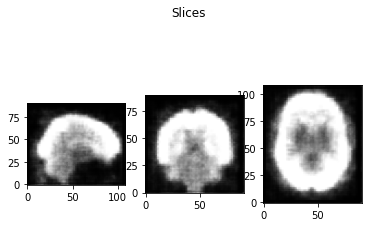

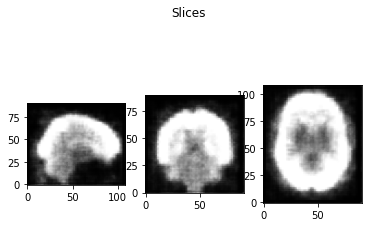

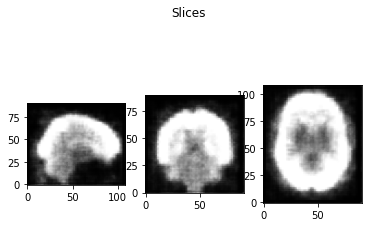

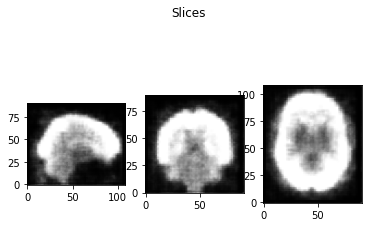

In [40]:
get_plot('try0.nii.gz')
get_plot('try1.nii.gz')
get_plot('try2.nii.gz')
get_plot('try3.nii.gz')

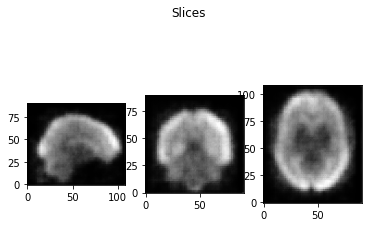

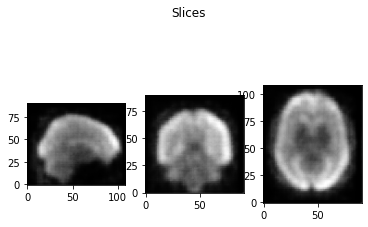

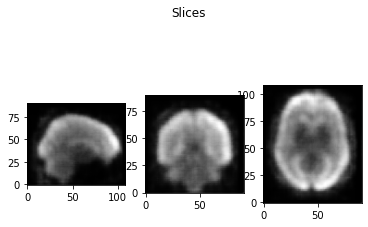

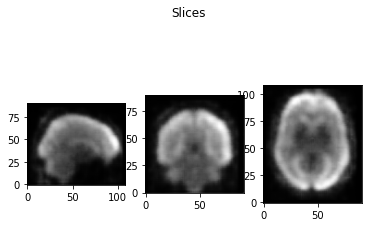

In [28]:
get_plot('newmodeltry0.nii.gz')
get_plot('newmodeltry0_1000epochs.nii.gz')
get_plot('newmodeltry0_1500epochs.nii.gz')
get_plot('newmodeltry0_2000epochs.nii.gz')

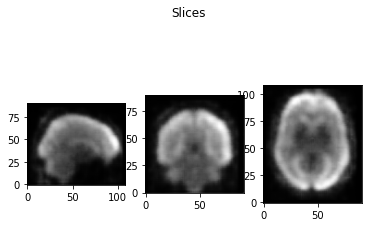

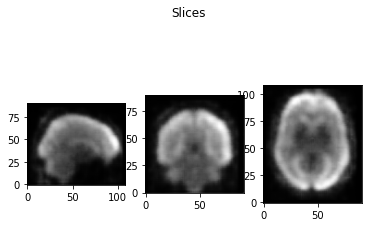

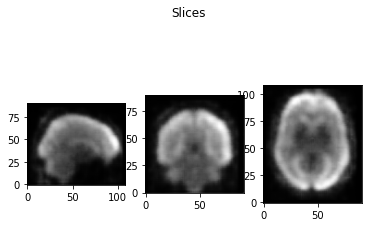

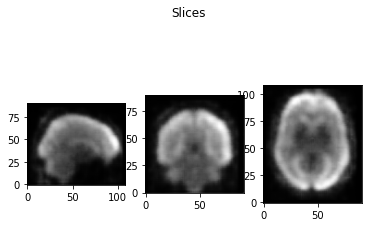

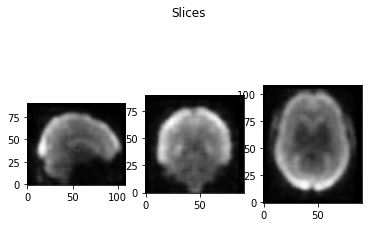

In [35]:
get_plot('newmodeltry0_2000epochs.nii.gz')
get_plot('newmodeltry1_2000epochs.nii.gz')
get_plot('newmodeltry2_2000epochs.nii.gz')
get_plot('newmodeltry3_2000epochs.nii.gz')
get_plot('newmodeltry3_2500epochs.nii.gz')

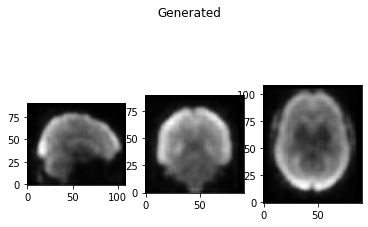

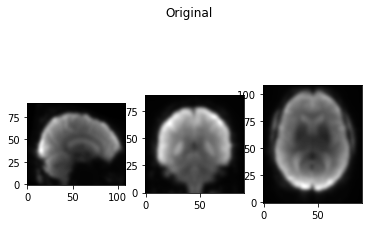

In [22]:
get_plot('newmodel_img0_2000epochs.nii.gz', plot_name = 'Generated')
get_plot('I269254_I989324imagedata.nii.gz', './Dataset', 'Original')

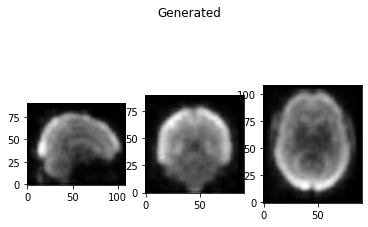

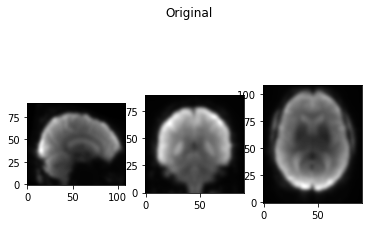

In [74]:
get_plot('model_temporal_img0_2000epochs.nii.gz', plot_name = 'Generated')
get_plot('I269254_I989324imagedata.nii.gz', './Dataset', 'Original')

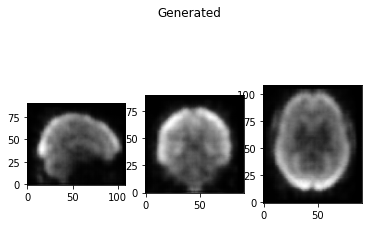

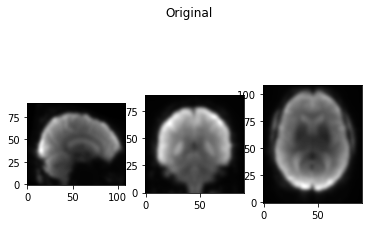

In [100]:
get_plot('newmodel_temporal_img0_2000epochs.nii.gz', plot_name = 'Generated')
get_plot('I269254_I989324imagedata.nii.gz', './Dataset', 'Original')

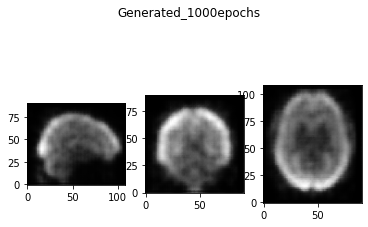

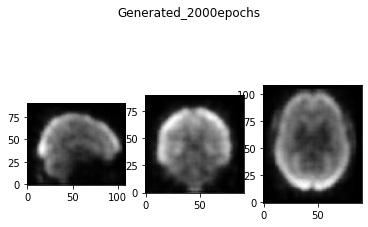

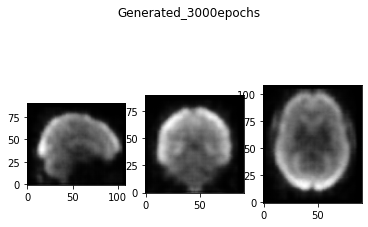

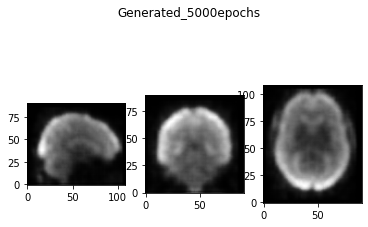

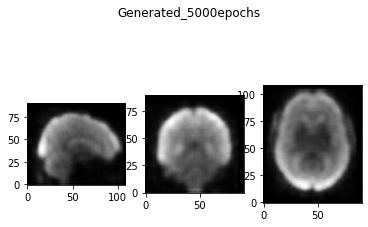

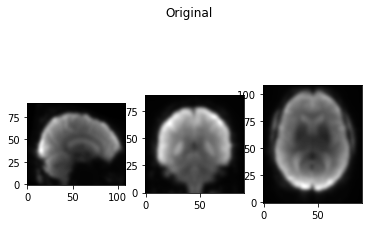

In [111]:
get_plot('newmodel_temporal_img0_1000epochs.nii.gz', plot_name = 'Generated_1000epochs')
get_plot('newmodel_temporal_img0_2000epochs.nii.gz', plot_name = 'Generated_2000epochs')
get_plot('newmodel_temporal_img0_3000epochs.nii.gz', plot_name = 'Generated_3000epochs')
get_plot('newmodel_temporal_img0_5000epochs.nii.gz', plot_name = 'Generated_5000epochs')
get_plot('newmodel_temporal_lam10_img0_5000epochs.nii.gz', plot_name = 'Generated_5000epochs')
get_plot('I269254_I989324imagedata.nii.gz', './Dataset', 'Original')

In [49]:
print(os.listdir(data_dir))

['I269254_I989324imagedata.nii.gz', 'I269254_I1304069imagedata.nii.gz', 'I269254_I1501115imagedata.nii.gz', 'I269254_I1241097imagedataLMCI.nii.gz', 'I269254_I235238imagedataLMCI.nii.gz', 'I269254_I1132801imagedata.nii.gz']


In [21]:
max_value

[tensor(2161., dtype=torch.float64),
 tensor(1921., dtype=torch.float64),
 tensor(1862., dtype=torch.float64),
 tensor(1572., dtype=torch.float64)]

The following can be ignored

In [15]:
h_new = torch.rand(1, 10)
h_new = to_device(h_new, device)
h_new

tensor([[0.2202, 0.6590, 0.7569, 0.2700, 0.8852, 0.1977, 0.5833, 0.0263, 0.1568,
         0.2667]], device='cuda:0')

In [28]:
h_new = torch.tensor([[1.1949, -0.6692,  0.2503,  0.0041, -2.3825,  0.6658, -0.0488, -0.7783,
          0.4877,  0.7172]])
h_new = to_device(h_new, device)
h_new

tensor([[ 1.1949, -0.6692,  0.2503,  0.0041, -2.3825,  0.6658, -0.0488, -0.7783,
          0.4877,  0.7172]], device='cuda:0')

In [29]:
dec_h_new = model.decode(h_new)
dec_h_new = dec_h_new.squeeze(0)
dec_h_new.shape

torch.Size([1, 91, 109, 91])

In [30]:
dec_h_new = torch.Tensor.cpu(dec_h_new)
dec_h_new = dec_h_new.detach().numpy()
dec_h_new.shape

(1, 91, 109, 91)

In [31]:
dec_h_new = dec_h_new * 1000 + 1000

In [32]:
img_new = nib.Nifti1Image(dec_h_new, np.eye(4))
nib.save(img_new, os.path.join('Generated', 'firstone.nii.gz'))  

Run one by one:

In [ ]:
epochs=0
lr=1e-5
opt_func=torch.optim.SGD
train_loss_history = []
optimizer = opt_func(model.parameters(), lr)

In [14]:
for batch in train_loader:
    debug_batch = batch
    break
debug_batch.shape

torch.Size([2, 1, 91, 109, 91, 177])

In [15]:
debug_batch = debug_batch.to(torch.float32)

In [20]:
x = debug_batch
tol_time = x.size(-1) # x is of size batch_size*channel*x1*x2*x3*tol_time
x_list = [x[:,:,:,:,:,t] for t in range(tol_time)]
h_history = []
gh_history = []
mu_history = []
t=0
h = h0.expand(batch.size(0), -1)

In [23]:
h

tensor([[0.7748, 0.9898, 0.8597, 0.2896, 0.6602, 0.5488, 0.3357, 0.4594, 0.9147,
         0.3443],
        [0.7748, 0.9898, 0.8597, 0.2896, 0.6602, 0.5488, 0.3357, 0.4594, 0.9147,
         0.3443]], device='cuda:0')

In [25]:
gh_history.append(model.g_transform(h))
gh_history

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<NativeBatchNormBackward0>),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<NativeBatchNormBackward0>),
 tensor([[-0.2693, -0.2893,  0.0075,  0.7103, -0.5138,  0.1778, -0.0302, -0.2398,
          -0.1408,  0.2811],
         [-0.2693, -0.2893,  0.0075,  0.7103, -0.5138,  0.1778, -0.0302, -0.2398,
          -0.1408,  0.2811]], device='cuda:0', grad_fn=<AddmmBackward0>)]